##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5). This is an advanced example that assumes some knowledge of:

* Sequence to sequence models
* TensorFlow fundamentals below the keras layer: 
  * Working with tensors directly 
  * Writing custom `keras.Model`s and `keras.layers`

While this architecture is somewhat outdated it is still a very useful project to work through to get a deeper understanding of attention mechanisms (before going on to [Transformers](transformer.ipynb)).

After training the model in this notebook, you will be able to input a Spanish sentence, such as "*¿todavia estan en casa?*", and return the English translation: "*are you still at home?*"

The resulting model is exportable as a `tf.saved_model`, so it can be used in other TensorFlow environments.

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

## Setup

In [2]:
!pip install tensorflow_text==2.7.3

  Using cached tensorflow_text-2.7.3-cp37-cp37m-manylinux2010_x86_64.whl (4.9 MB)


  Using cached tensorflow-2.7.1-cp37-cp37m-manylinux2010_x86_64.whl (495.0 MB)


  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)


  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)


  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)


  Attempting uninstall: keras
    Found existing installation: keras 2.8.0


    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow


    Found existing installation: tensorflow 2.8.0


    Uninstalling tensorflow-2.8.0:


      Successfully uninstalled tensorflow-2.8.0


In [3]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

This tutorial builds a few layers from scratch, use this variable if you want to switch between the custom and builtin implementations.

In [4]:
use_builtins = True

This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial. 


In [5]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but we'll use the English-Spanish dataset.

### Download and prepare the dataset

For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [6]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'


  16384/2638744 [..............................] - ETA: 0s


2646016/2638744 [==============================] - 0s 0us/step



2654208/2638744 [==============================] - 0s 0us/step


In [7]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [8]:
targ, inp = load_data(path_to_file)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [9]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [10]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [11]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'\xc2\xbfC\xc3\xb3mo est\xc3\xa1 Tom?'
 b'\xc3\x89l vendr\xc3\xa1 si t\xc3\xba le llamas.'
 b'Yo de hecho no trabajo aqu\xc3\xad.' b'\xc3\x89l debe ser del Sur.'
 b'\xc2\xbfQuieres decir que tu casa est\xc3\xa1 embrujada?'], shape=(5,), dtype=string)

tf.Tensor(
[b"How's Tom doing?" b'He will come if you call him.'
 b"I don't actually work here." b'He must be from the South.'
 b'Are you saying that your house is haunted?'], shape=(5,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. 

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

In [12]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [13]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [15]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

The `TextVectorization` layer and many other preprocessing layers have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fix`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:  

In [16]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [17]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Now these layers can convert a batch of strings into a batch of token IDs:

In [18]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   13,   38,   20,   10,   12,    3,    0,    0,    0],
       [   2,    7,  688,   45,   36,   28, 1542,    4,    3,    0],
       [   2,   39,    6,  162,    9,   83,   51,    4,    3,    0]])>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [19]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] ¿ como esta tom ? [END]             '

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

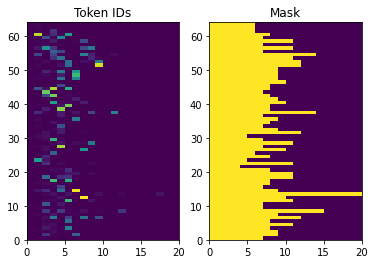

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

## The encoder/decoder model

The following diagram shows an overview of the model. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word. The diagram and formulas are from [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">


Before getting into it define a few constants for the model:

In [21]:
embedding_dim = 256
units = 1024

### The encoder

Start by building the encoder, the blue part of the diagram above.

The encoder:

1. Takes a list of token IDs (from `input_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a `layers.GRU`).
5. Returns:
  * The processed sequence. This will be passed to the attention head.
  * The internal state. This will be used to initialize the decoder


In [22]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

Here is how it fits together so far:

In [23]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 1024)
Encoder state, shape (batch, units): (64, 1024)


The encoder returns its internal state so that its state can be used to initialize the decoder.

It's also common for an RNN to return its state so that it can process a sequence over multiple calls. You'll see more of that building the decoder.

### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a _weighted_ average.

Let's look at how this works:

<img src="images/attention_equation_1.jpg" alt="attention equation 1" width="800">

<img src="images/attention_equation_2.jpg" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.


Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="images/attention_equation_4.jpg" alt="attention equation 4" width="800">

This tutorial uses [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf). TensorFlow includes implementations of both as `layers.Attention` and
`layers.AdditiveAttention`. The class below handles the weight matrices in a pair of `layers.Dense` layers, and calls the builtin implementation.

In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### Test the Attention layer

Create a `BahdanauAttention` layer:

In [25]:
attention_layer = BahdanauAttention(units)

This layer takes 3 inputs:

* The `query`: This will be generated by the decoder, later.
* The `value`: This Will be the output of the encoder.
* The `mask`: To exclude the padding, `example_tokens != 0`

In [26]:
(example_tokens != 0).shape

TensorShape([64, 20])

The vectorized implementation of the attention layer lets you pass a batch of sequences of query vectors and a batch of sequence of value vectors. The result is:

1. A batch of sequences of result vectors the size of the queries.
2. A batch attention maps, with size `(query_length, value_length)`.

In [27]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 20)


The attention weights should sum to `1.0` for each sequence.

Here are the attention weights across the sequences at `t=0`:

Text(0.5, 1.0, 'Mask')

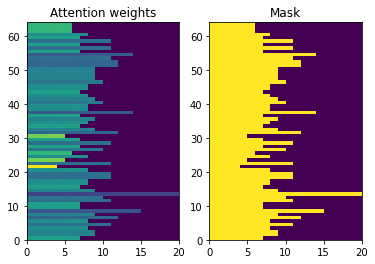

In [28]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


Because of the small-random initialization the attention weights are all close to `1/(sequence_length)`. If you zoom in on the weights for a single sequence, you can see that there is some _small_ variation that the model can learn to expand, and exploit.

In [29]:
attention_weights.shape

TensorShape([64, 2, 20])

In [30]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

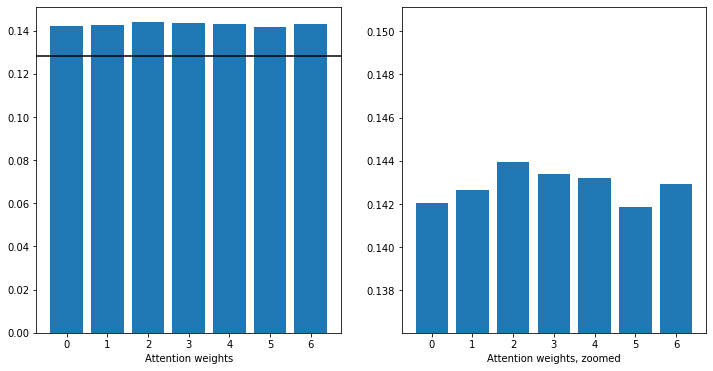

In [31]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

### The decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

<img src="images/attention_equation_3.jpg" alt="attention equation 3" width="800">


Here is the `Decoder` class and its initializer. The initializer creates all the necessary layers.

In [32]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

The `call` method for this layer takes and returns multiple tensors. Organize those into simple container classes:

In [33]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

Here is the implementation of the `call` method:

In [34]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [35]:
Decoder.call = call

The **encoder** processes its full input sequence with a single call to its RNN. This implementation of the **decoder** _can_ do that as well for efficient training. But this tutorial will run the decoder in a loop for a few reasons:

* Flexibility: Writing the loop gives you direct control over the training procedure.
* Clarity: It's possible to do masking tricks and use `layers.RNN`, or `tfa.seq2seq` APIs to pack this all into a single call. But writing it out as a loop may be clearer. 
  * Loop free training is demonstrated in the [Text generation](text_generation.ipynb) tutiorial.


Now try using this decoder.

In [36]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

The decoder takes 4 inputs.

* `new_tokens` -  The last token generated. Initialize the decoder with the `"[START]"` token.
* `enc_output` - Generated by the `Encoder`.
* `mask` - A boolean tensor indicating where `tokens != 0`
* `state` - The previous `state` output from the decoder (the internal state
  of the decoder's RNN). Pass `None` to zero-initialize it. The original
  paper initializes it from the encoder's final RNN state. 

In [37]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [38]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


Sample a token according to the logits:

In [39]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

Decode the token as the first word of the output:

In [40]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['knitting'],
       ['mondays'],
       ['addict'],
       ['england'],
       ['had']], dtype='<U16')

Now use the decoder to generate a second set of logits.

- Pass the same `enc_output` and `mask`, these haven't changed.
- Pass the sampled token as `new_tokens`.
- Pass the `decoder_state` the decoder returned last time, so the RNN continues with a memory of where it left off last time.


In [41]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [42]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['swear'],
       ['by'],
       ['yesterday'],
       ['article'],
       ['calls']], dtype='<U16')

## Training

Now that you have all the model components, it's time to start training the model. You'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Define the loss function

In [43]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### Implement the training step

Start with a model class, the training process will be implemented as the `train_step` method on this model. See [Customizing fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details.

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

In [44]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks. 
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss. 
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

The `_preprocess` method, added below, implements steps #1 and #2: 

In [45]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [46]:
TrainTranslator._preprocess = _preprocess

The `_train_step` method, added below, handles the remaining steps except for actually running the decoder: 

In [47]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [48]:
TrainTranslator._train_step = _train_step

The `_loop_step` method, added below, executes the decoder and calculates the incremental loss and new decoder state (`dec_state`).

In [49]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [50]:
TrainTranslator._loop_step = _loop_step

### Test the training step

Build a `TrainTranslator`, and configure it for training using the `Model.compile` method:

In [51]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

Test out the `train_step`. For a text model like this the loss should start near:

In [52]:
np.log(output_text_processor.vocabulary_size())

8.517193191416236

In [53]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.591636>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.560595>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.500265>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.314591>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.5578732>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.016562>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3178535>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.240227>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.048718>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9113197>}

CPU times: user 5.87 s, sys: 0 ns, total: 5.87 s
Wall time: 5.83 s


While it's easier to debug without a `tf.function` it does give a performance boost. So now that the `_train_step` method is working, try the `tf.function`-wrapped `_tf_train_step`, to maximize performance while training:

In [54]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [55]:
TrainTranslator._tf_train_step = _tf_train_step

In [56]:
translator.use_tf_function = True

The first call will be slow, because it traces the function.

In [57]:
translator.train_step([example_input_batch, example_target_batch])

2022-02-11 12:44:54.639983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2022-02-11 12:44:54.804665: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25


2022-02-11 12:44:54.968165: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
	when importing GraphDef to MLIR module in GrapplerHook
2022-02-11 12:44:55.010610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.

2022-02-11 12:44:55.191808: W tensorflow/core/common_runtime/process_function_library_runtime.cc:866] Ignoring multi-device function optimization failure: INVALID_ARGUMENT: Input 1 of node while/body/_1/while/TensorListPushBack_56 was passed float from while/body/_1/while/decoder_1/gru_3/PartitionedCall:6 incompatible with expected variant.


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8648612>}

But after that it's usually 2-3x faster than the eager `train_step` method:

In [58]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8414097>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.760918>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7111266>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6778157>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6157703>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.601778>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5580208>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5236502>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4936435>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4404585>}

CPU times: user 5.17 s, sys: 999 ms, total: 6.16 s
Wall time: 1.94 s


A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

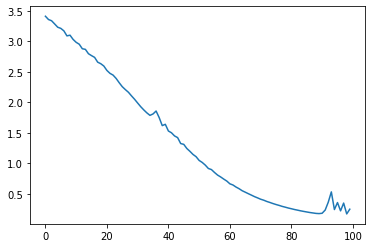

In [59]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

In [60]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [61]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [62]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3


2022-02-11 12:45:21.451525: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2022-02-11 12:45:21.614120: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25


2022-02-11 12:45:21.767082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
	when importing GraphDef to MLIR module in GrapplerHook
2022-02-11 12:45:21.804554: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/wh

2022-02-11 12:45:21.987291: W tensorflow/core/common_runtime/process_function_library_runtime.cc:866] Ignoring multi-device function optimization failure: INVALID_ARGUMENT: Input 1 of node StatefulPartitionedCall/while/body/_59/while/TensorListPushBack_56 was passed float from StatefulPartitionedCall/while/body/_59/while/decoder_2/gru_5/PartitionedCall:6 incompatible with expected variant.



   1/1859 [..............................] - ETA: 3:09:07 - batch_loss: 7.5982


   2/1859 [..............................] - ETA: 6:20 - batch_loss: 7.5950   


   3/1859 [..............................] - ETA: 6:19 - batch_loss: 7.5661


   4/1859 [..............................] - ETA: 7:00 - batch_loss: 7.5227


   5/1859 [..............................] - ETA: 7:02 - batch_loss: 7.4103


   6/1859 [..............................] - ETA: 6:48 - batch_loss: 7.1271


   7/1859 [..............................] - ETA: 6:44 - batch_loss: 7.2233


   8/1859 [..............................] - ETA: 6:47 - batch_loss: 7.1700


   9/1859 [..............................] - ETA: 6:47 - batch_loss: 7.0268


  10/1859 [..............................] - ETA: 6:50 - batch_loss: 6.8793


  11/1859 [..............................] - ETA: 7:09 - batch_loss: 6.7493


  12/1859 [..............................] - ETA: 7:02 - batch_loss: 6.6353


  13/1859 [..............................] - ETA: 6:58 - batch_loss: 6.5475


  14/1859 [..............................] - ETA: 6:52 - batch_loss: 6.4636


  15/1859 [..............................] - ETA: 7:01 - batch_loss: 6.3919


  16/1859 [..............................] - ETA: 6:53 - batch_loss: 6.3138


  17/1859 [..............................] - ETA: 6:56 - batch_loss: 6.2480


  18/1859 [..............................] - ETA: 6:51 - batch_loss: 6.1859


  19/1859 [..............................] - ETA: 6:46 - batch_loss: 6.1243


  20/1859 [..............................] - ETA: 6:48 - batch_loss: 6.0806


  21/1859 [..............................] - ETA: 6:46 - batch_loss: 6.0329


  22/1859 [..............................] - ETA: 6:45 - batch_loss: 5.9843


  23/1859 [..............................] - ETA: 6:43 - batch_loss: 5.9452


  24/1859 [..............................] - ETA: 6:39 - batch_loss: 5.8994


  25/1859 [..............................] - ETA: 6:40 - batch_loss: 5.8652


  26/1859 [..............................] - ETA: 6:37 - batch_loss: 5.8278


  27/1859 [..............................] - ETA: 6:36 - batch_loss: 5.7961


  28/1859 [..............................] - ETA: 6:37 - batch_loss: 5.7678


  29/1859 [..............................] - ETA: 6:36 - batch_loss: 5.7389


  30/1859 [..............................] - ETA: 6:43 - batch_loss: 5.7185


  31/1859 [..............................] - ETA: 6:43 - batch_loss: 5.6937


  32/1859 [..............................] - ETA: 6:39 - batch_loss: 5.6661


  33/1859 [..............................] - ETA: 6:39 - batch_loss: 5.6447


  34/1859 [..............................] - ETA: 6:39 - batch_loss: 5.6208


  35/1859 [..............................] - ETA: 6:37 - batch_loss: 5.5927


  36/1859 [..............................] - ETA: 6:35 - batch_loss: 5.5650


  37/1859 [..............................] - ETA: 6:32 - batch_loss: 5.5441


  38/1859 [..............................] - ETA: 6:33 - batch_loss: 5.5253


  39/1859 [..............................] - ETA: 6:34 - batch_loss: 5.5085


  40/1859 [..............................] - ETA: 6:33 - batch_loss: 5.4848


  41/1859 [..............................] - ETA: 6:31 - batch_loss: 5.4635


  42/1859 [..............................] - ETA: 6:30 - batch_loss: 5.4471


  43/1859 [..............................] - ETA: 6:32 - batch_loss: 5.4278


  44/1859 [..............................] - ETA: 6:34 - batch_loss: 5.4117


  45/1859 [..............................] - ETA: 6:37 - batch_loss: 5.3961


  46/1859 [..............................] - ETA: 6:35 - batch_loss: 5.3776


  47/1859 [..............................] - ETA: 6:33 - batch_loss: 5.3572


  48/1859 [..............................] - ETA: 6:32 - batch_loss: 5.3439


  49/1859 [..............................] - ETA: 6:31 - batch_loss: 5.3276


  50/1859 [..............................] - ETA: 6:30 - batch_loss: 5.3130


  51/1859 [..............................] - ETA: 6:30 - batch_loss: 5.2975


  52/1859 [..............................] - ETA: 6:29 - batch_loss: 5.2841


  53/1859 [..............................] - ETA: 6:29 - batch_loss: 5.2700


  54/1859 [..............................] - ETA: 6:29 - batch_loss: 5.2536


  55/1859 [..............................] - ETA: 6:29 - batch_loss: 5.2439


  56/1859 [..............................] - ETA: 6:28 - batch_loss: 5.2315


  57/1859 [..............................] - ETA: 6:29 - batch_loss: 5.2168


  58/1859 [..............................] - ETA: 6:29 - batch_loss: 5.2035


  59/1859 [..............................] - ETA: 6:31 - batch_loss: 5.1902


  60/1859 [..............................] - ETA: 6:32 - batch_loss: 5.1801


  61/1859 [..............................] - ETA: 6:32 - batch_loss: 5.1696


  62/1859 [>.............................] - ETA: 6:32 - batch_loss: 5.1580


  63/1859 [>.............................] - ETA: 6:31 - batch_loss: 5.1444


  64/1859 [>.............................] - ETA: 6:30 - batch_loss: 5.1324


  65/1859 [>.............................] - ETA: 6:29 - batch_loss: 5.1232


  66/1859 [>.............................] - ETA: 6:34 - batch_loss: 5.1178


  67/1859 [>.............................] - ETA: 6:33 - batch_loss: 5.1065


  68/1859 [>.............................] - ETA: 6:32 - batch_loss: 5.0964


  69/1859 [>.............................] - ETA: 6:31 - batch_loss: 5.0850


  70/1859 [>.............................] - ETA: 6:30 - batch_loss: 5.0758


  71/1859 [>.............................] - ETA: 6:30 - batch_loss: 5.0673


  72/1859 [>.............................] - ETA: 6:29 - batch_loss: 5.0589


  73/1859 [>.............................] - ETA: 6:28 - batch_loss: 5.0526


  74/1859 [>.............................] - ETA: 6:27 - batch_loss: 5.0436


  75/1859 [>.............................] - ETA: 6:26 - batch_loss: 5.0340


  76/1859 [>.............................] - ETA: 6:26 - batch_loss: 5.0271


  77/1859 [>.............................] - ETA: 6:25 - batch_loss: 5.0193


  78/1859 [>.............................] - ETA: 6:26 - batch_loss: 5.0138


  79/1859 [>.............................] - ETA: 6:27 - batch_loss: 5.0070


  80/1859 [>.............................] - ETA: 6:28 - batch_loss: 5.0027


  81/1859 [>.............................] - ETA: 6:28 - batch_loss: 4.9941


  82/1859 [>.............................] - ETA: 6:27 - batch_loss: 4.9884


  83/1859 [>.............................] - ETA: 6:29 - batch_loss: 4.9821


  84/1859 [>.............................] - ETA: 6:29 - batch_loss: 4.9745


  85/1859 [>.............................] - ETA: 6:29 - batch_loss: 4.9683


  86/1859 [>.............................] - ETA: 6:28 - batch_loss: 4.9606


  87/1859 [>.............................] - ETA: 6:29 - batch_loss: 4.9546


  88/1859 [>.............................] - ETA: 6:28 - batch_loss: 4.9477


  89/1859 [>.............................] - ETA: 6:27 - batch_loss: 4.9417


  90/1859 [>.............................] - ETA: 6:28 - batch_loss: 4.9361


  91/1859 [>.............................] - ETA: 6:27 - batch_loss: 4.9288


  92/1859 [>.............................] - ETA: 6:27 - batch_loss: 4.9204


  93/1859 [>.............................] - ETA: 6:26 - batch_loss: 4.9143


  94/1859 [>.............................] - ETA: 6:26 - batch_loss: 4.9079


  95/1859 [>.............................] - ETA: 6:26 - batch_loss: 4.9006


  96/1859 [>.............................] - ETA: 6:25 - batch_loss: 4.8960


  97/1859 [>.............................] - ETA: 6:25 - batch_loss: 4.8897


  98/1859 [>.............................] - ETA: 6:25 - batch_loss: 4.8833


  99/1859 [>.............................] - ETA: 6:26 - batch_loss: 4.8781


 100/1859 [>.............................] - ETA: 6:26 - batch_loss: 4.8722


 101/1859 [>.............................] - ETA: 6:26 - batch_loss: 4.8668


 102/1859 [>.............................] - ETA: 6:25 - batch_loss: 4.8625


 103/1859 [>.............................] - ETA: 6:25 - batch_loss: 4.8578


 104/1859 [>.............................] - ETA: 6:25 - batch_loss: 4.8523


 105/1859 [>.............................] - ETA: 6:24 - batch_loss: 4.8467


 106/1859 [>.............................] - ETA: 6:24 - batch_loss: 4.8413


 107/1859 [>.............................] - ETA: 6:23 - batch_loss: 4.8341


 108/1859 [>.............................] - ETA: 6:22 - batch_loss: 4.8292


 109/1859 [>.............................] - ETA: 6:21 - batch_loss: 4.8254


 110/1859 [>.............................] - ETA: 6:21 - batch_loss: 4.8188


 111/1859 [>.............................] - ETA: 6:22 - batch_loss: 4.8150


 112/1859 [>.............................] - ETA: 6:22 - batch_loss: 4.8090


 113/1859 [>.............................] - ETA: 6:22 - batch_loss: 4.8064


 114/1859 [>.............................] - ETA: 6:21 - batch_loss: 4.8021


 115/1859 [>.............................] - ETA: 6:21 - batch_loss: 4.7988


 116/1859 [>.............................] - ETA: 6:20 - batch_loss: 4.7941


 117/1859 [>.............................] - ETA: 6:20 - batch_loss: 4.7864


 118/1859 [>.............................] - ETA: 6:19 - batch_loss: 4.7820


 119/1859 [>.............................] - ETA: 6:19 - batch_loss: 4.7776


 120/1859 [>.............................] - ETA: 6:18 - batch_loss: 4.7735


 121/1859 [>.............................] - ETA: 6:18 - batch_loss: 4.7693


 122/1859 [>.............................] - ETA: 6:18 - batch_loss: 4.7637


 123/1859 [>.............................] - ETA: 6:18 - batch_loss: 4.7584


 124/1859 [=>............................] - ETA: 6:17 - batch_loss: 4.7564


 125/1859 [=>............................] - ETA: 6:17 - batch_loss: 4.7524


 126/1859 [=>............................] - ETA: 6:16 - batch_loss: 4.7470


 127/1859 [=>............................] - ETA: 6:15 - batch_loss: 4.7418


 128/1859 [=>............................] - ETA: 6:15 - batch_loss: 4.7384


 129/1859 [=>............................] - ETA: 6:14 - batch_loss: 4.7359


 130/1859 [=>............................] - ETA: 6:14 - batch_loss: 4.7303


 131/1859 [=>............................] - ETA: 6:15 - batch_loss: 4.7273


 132/1859 [=>............................] - ETA: 6:15 - batch_loss: 4.7234


 133/1859 [=>............................] - ETA: 6:15 - batch_loss: 4.7199


 134/1859 [=>............................] - ETA: 6:14 - batch_loss: 4.7159


 135/1859 [=>............................] - ETA: 6:14 - batch_loss: 4.7113


 136/1859 [=>............................] - ETA: 6:13 - batch_loss: 4.7082


 137/1859 [=>............................] - ETA: 6:13 - batch_loss: 4.7044


 138/1859 [=>............................] - ETA: 6:13 - batch_loss: 4.7008


 139/1859 [=>............................] - ETA: 6:12 - batch_loss: 4.6977


 140/1859 [=>............................] - ETA: 6:12 - batch_loss: 4.6944


 141/1859 [=>............................] - ETA: 6:13 - batch_loss: 4.6909


 142/1859 [=>............................] - ETA: 6:13 - batch_loss: 4.6878


 143/1859 [=>............................] - ETA: 6:12 - batch_loss: 4.6832


 144/1859 [=>............................] - ETA: 6:12 - batch_loss: 4.6776


 145/1859 [=>............................] - ETA: 6:12 - batch_loss: 4.6735


 146/1859 [=>............................] - ETA: 6:12 - batch_loss: 4.6703


 147/1859 [=>............................] - ETA: 6:12 - batch_loss: 4.6673


 148/1859 [=>............................] - ETA: 6:11 - batch_loss: 4.6634


 149/1859 [=>............................] - ETA: 6:10 - batch_loss: 4.6608


 150/1859 [=>............................] - ETA: 6:10 - batch_loss: 4.6573


 151/1859 [=>............................] - ETA: 6:10 - batch_loss: 4.6541


 152/1859 [=>............................] - ETA: 6:10 - batch_loss: 4.6498


 153/1859 [=>............................] - ETA: 6:09 - batch_loss: 4.6464


 154/1859 [=>............................] - ETA: 6:09 - batch_loss: 4.6427


 155/1859 [=>............................] - ETA: 6:09 - batch_loss: 4.6401


 156/1859 [=>............................] - ETA: 6:08 - batch_loss: 4.6362


 157/1859 [=>............................] - ETA: 6:08 - batch_loss: 4.6332


 158/1859 [=>............................] - ETA: 6:08 - batch_loss: 4.6305


 159/1859 [=>............................] - ETA: 6:08 - batch_loss: 4.6269


 160/1859 [=>............................] - ETA: 6:07 - batch_loss: 4.6241


 161/1859 [=>............................] - ETA: 6:07 - batch_loss: 4.6215


 162/1859 [=>............................] - ETA: 6:07 - batch_loss: 4.6191


 163/1859 [=>............................] - ETA: 6:07 - batch_loss: 4.6161


 164/1859 [=>............................] - ETA: 6:06 - batch_loss: 4.6132


 165/1859 [=>............................] - ETA: 6:06 - batch_loss: 4.6102


 166/1859 [=>............................] - ETA: 6:07 - batch_loss: 4.6069


 167/1859 [=>............................] - ETA: 6:06 - batch_loss: 4.6038


 168/1859 [=>............................] - ETA: 6:06 - batch_loss: 4.6002


 169/1859 [=>............................] - ETA: 6:05 - batch_loss: 4.5968


 170/1859 [=>............................] - ETA: 6:06 - batch_loss: 4.5931


 171/1859 [=>............................] - ETA: 6:05 - batch_loss: 4.5906


 172/1859 [=>............................] - ETA: 6:05 - batch_loss: 4.5868


 173/1859 [=>............................] - ETA: 6:05 - batch_loss: 4.5824


 174/1859 [=>............................] - ETA: 6:04 - batch_loss: 4.5802


 175/1859 [=>............................] - ETA: 6:04 - batch_loss: 4.5761


 176/1859 [=>............................] - ETA: 6:04 - batch_loss: 4.5736


 177/1859 [=>............................] - ETA: 6:03 - batch_loss: 4.5710


 178/1859 [=>............................] - ETA: 6:03 - batch_loss: 4.5680


 179/1859 [=>............................] - ETA: 6:03 - batch_loss: 4.5640


 180/1859 [=>............................] - ETA: 6:04 - batch_loss: 4.5627


 181/1859 [=>............................] - ETA: 6:03 - batch_loss: 4.5584


 182/1859 [=>............................] - ETA: 6:02 - batch_loss: 4.5545


 183/1859 [=>............................] - ETA: 6:02 - batch_loss: 4.5503


 184/1859 [=>............................] - ETA: 6:02 - batch_loss: 4.5477


 185/1859 [=>............................] - ETA: 6:02 - batch_loss: 4.5437


 186/1859 [==>...........................] - ETA: 6:01 - batch_loss: 4.5404


 187/1859 [==>...........................] - ETA: 6:01 - batch_loss: 4.5368


 188/1859 [==>...........................] - ETA: 6:01 - batch_loss: 4.5328


 189/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.5299


 190/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.5265


 191/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.5238


 192/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.5204


 193/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.5175


 194/1859 [==>...........................] - ETA: 6:01 - batch_loss: 4.5137


 195/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.5099


 196/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.5065


 197/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.5023


 198/1859 [==>...........................] - ETA: 6:01 - batch_loss: 4.4986


 199/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.4952


 200/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.4919


 201/1859 [==>...........................] - ETA: 5:59 - batch_loss: 4.4888


 202/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.4864


 203/1859 [==>...........................] - ETA: 6:00 - batch_loss: 4.4826


 204/1859 [==>...........................] - ETA: 5:59 - batch_loss: 4.4803


 205/1859 [==>...........................] - ETA: 5:59 - batch_loss: 4.4779


 206/1859 [==>...........................] - ETA: 5:59 - batch_loss: 4.4757


 207/1859 [==>...........................] - ETA: 5:59 - batch_loss: 4.4725


 208/1859 [==>...........................] - ETA: 5:58 - batch_loss: 4.4687


 209/1859 [==>...........................] - ETA: 5:58 - batch_loss: 4.4660


 210/1859 [==>...........................] - ETA: 5:58 - batch_loss: 4.4643


 211/1859 [==>...........................] - ETA: 5:57 - batch_loss: 4.4604


 212/1859 [==>...........................] - ETA: 5:57 - batch_loss: 4.4574


 213/1859 [==>...........................] - ETA: 5:56 - batch_loss: 4.4533


 214/1859 [==>...........................] - ETA: 5:56 - batch_loss: 4.4494


 215/1859 [==>...........................] - ETA: 5:56 - batch_loss: 4.4466


 216/1859 [==>...........................] - ETA: 5:55 - batch_loss: 4.4428


 217/1859 [==>...........................] - ETA: 5:55 - batch_loss: 4.4401


 218/1859 [==>...........................] - ETA: 5:55 - batch_loss: 4.4363


 219/1859 [==>...........................] - ETA: 5:54 - batch_loss: 4.4324


 220/1859 [==>...........................] - ETA: 5:54 - batch_loss: 4.4287


 221/1859 [==>...........................] - ETA: 5:54 - batch_loss: 4.4249


 222/1859 [==>...........................] - ETA: 5:53 - batch_loss: 4.4201


 223/1859 [==>...........................] - ETA: 5:53 - batch_loss: 4.4174


 224/1859 [==>...........................] - ETA: 5:53 - batch_loss: 4.4144


 225/1859 [==>...........................] - ETA: 5:53 - batch_loss: 4.4116


 226/1859 [==>...........................] - ETA: 5:52 - batch_loss: 4.4089


 227/1859 [==>...........................] - ETA: 5:53 - batch_loss: 4.4058


 228/1859 [==>...........................] - ETA: 5:52 - batch_loss: 4.4023


 229/1859 [==>...........................] - ETA: 5:52 - batch_loss: 4.3993


 230/1859 [==>...........................] - ETA: 5:52 - batch_loss: 4.3969


 231/1859 [==>...........................] - ETA: 5:51 - batch_loss: 4.3933


 232/1859 [==>...........................] - ETA: 5:51 - batch_loss: 4.3916


 233/1859 [==>...........................] - ETA: 5:51 - batch_loss: 4.3883


 234/1859 [==>...........................] - ETA: 5:50 - batch_loss: 4.3854


 235/1859 [==>...........................] - ETA: 5:50 - batch_loss: 4.3823


 236/1859 [==>...........................] - ETA: 5:50 - batch_loss: 4.3795


 237/1859 [==>...........................] - ETA: 5:49 - batch_loss: 4.3765


 238/1859 [==>...........................] - ETA: 5:49 - batch_loss: 4.3732


 239/1859 [==>...........................] - ETA: 5:49 - batch_loss: 4.3701


 240/1859 [==>...........................] - ETA: 5:49 - batch_loss: 4.3674


 241/1859 [==>...........................] - ETA: 5:49 - batch_loss: 4.3647


 242/1859 [==>...........................] - ETA: 5:49 - batch_loss: 4.3614


 243/1859 [==>...........................] - ETA: 5:48 - batch_loss: 4.3582


 244/1859 [==>...........................] - ETA: 5:48 - batch_loss: 4.3553


 245/1859 [==>...........................] - ETA: 5:49 - batch_loss: 4.3526


 246/1859 [==>...........................] - ETA: 5:48 - batch_loss: 4.3494


 247/1859 [==>...........................] - ETA: 5:48 - batch_loss: 4.3462


 248/1859 [===>..........................] - ETA: 5:48 - batch_loss: 4.3427


 249/1859 [===>..........................] - ETA: 5:47 - batch_loss: 4.3401


 250/1859 [===>..........................] - ETA: 5:47 - batch_loss: 4.3367


 251/1859 [===>..........................] - ETA: 5:47 - batch_loss: 4.3336


 252/1859 [===>..........................] - ETA: 5:46 - batch_loss: 4.3312


 253/1859 [===>..........................] - ETA: 5:46 - batch_loss: 4.3287


 254/1859 [===>..........................] - ETA: 5:46 - batch_loss: 4.3262


 255/1859 [===>..........................] - ETA: 5:46 - batch_loss: 4.3238


 256/1859 [===>..........................] - ETA: 5:45 - batch_loss: 4.3205


 257/1859 [===>..........................] - ETA: 5:45 - batch_loss: 4.3176


 258/1859 [===>..........................] - ETA: 5:45 - batch_loss: 4.3152


 259/1859 [===>..........................] - ETA: 5:45 - batch_loss: 4.3123


 260/1859 [===>..........................] - ETA: 5:45 - batch_loss: 4.3099


 261/1859 [===>..........................] - ETA: 5:44 - batch_loss: 4.3068


 262/1859 [===>..........................] - ETA: 5:44 - batch_loss: 4.3037


 263/1859 [===>..........................] - ETA: 5:44 - batch_loss: 4.3010


 264/1859 [===>..........................] - ETA: 5:44 - batch_loss: 4.2982


 265/1859 [===>..........................] - ETA: 5:44 - batch_loss: 4.2957


 266/1859 [===>..........................] - ETA: 5:43 - batch_loss: 4.2922


 267/1859 [===>..........................] - ETA: 5:43 - batch_loss: 4.2892


 268/1859 [===>..........................] - ETA: 5:43 - batch_loss: 4.2864


 269/1859 [===>..........................] - ETA: 5:42 - batch_loss: 4.2830


 270/1859 [===>..........................] - ETA: 5:42 - batch_loss: 4.2802


 271/1859 [===>..........................] - ETA: 5:42 - batch_loss: 4.2773


 272/1859 [===>..........................] - ETA: 5:41 - batch_loss: 4.2738


 273/1859 [===>..........................] - ETA: 5:41 - batch_loss: 4.2709


 274/1859 [===>..........................] - ETA: 5:41 - batch_loss: 4.2678


 275/1859 [===>..........................] - ETA: 5:41 - batch_loss: 4.2655


 276/1859 [===>..........................] - ETA: 5:41 - batch_loss: 4.2629


 277/1859 [===>..........................] - ETA: 5:40 - batch_loss: 4.2596


 278/1859 [===>..........................] - ETA: 5:41 - batch_loss: 4.2566


 279/1859 [===>..........................] - ETA: 5:40 - batch_loss: 4.2538


 280/1859 [===>..........................] - ETA: 5:40 - batch_loss: 4.2505


 281/1859 [===>..........................] - ETA: 5:40 - batch_loss: 4.2476


 282/1859 [===>..........................] - ETA: 5:40 - batch_loss: 4.2446


 283/1859 [===>..........................] - ETA: 5:40 - batch_loss: 4.2421


 284/1859 [===>..........................] - ETA: 5:39 - batch_loss: 4.2390


 285/1859 [===>..........................] - ETA: 5:39 - batch_loss: 4.2366


 286/1859 [===>..........................] - ETA: 5:39 - batch_loss: 4.2342


 287/1859 [===>..........................] - ETA: 5:38 - batch_loss: 4.2315


 288/1859 [===>..........................] - ETA: 5:38 - batch_loss: 4.2286


 289/1859 [===>..........................] - ETA: 5:38 - batch_loss: 4.2256


 290/1859 [===>..........................] - ETA: 5:38 - batch_loss: 4.2229


 291/1859 [===>..........................] - ETA: 5:38 - batch_loss: 4.2198


 292/1859 [===>..........................] - ETA: 5:37 - batch_loss: 4.2164


 293/1859 [===>..........................] - ETA: 5:37 - batch_loss: 4.2131


 294/1859 [===>..........................] - ETA: 5:37 - batch_loss: 4.2108


 295/1859 [===>..........................] - ETA: 5:37 - batch_loss: 4.2079


 296/1859 [===>..........................] - ETA: 5:37 - batch_loss: 4.2049


 297/1859 [===>..........................] - ETA: 5:36 - batch_loss: 4.2022


 298/1859 [===>..........................] - ETA: 5:36 - batch_loss: 4.1987


 299/1859 [===>..........................] - ETA: 5:36 - batch_loss: 4.1959


 300/1859 [===>..........................] - ETA: 5:35 - batch_loss: 4.1927


 301/1859 [===>..........................] - ETA: 5:35 - batch_loss: 4.1901


 302/1859 [===>..........................] - ETA: 5:35 - batch_loss: 4.1873


 303/1859 [===>..........................] - ETA: 5:34 - batch_loss: 4.1847


 304/1859 [===>..........................] - ETA: 5:34 - batch_loss: 4.1817


 305/1859 [===>..........................] - ETA: 5:33 - batch_loss: 4.1780


 306/1859 [===>..........................] - ETA: 5:33 - batch_loss: 4.1747


 307/1859 [===>..........................] - ETA: 5:33 - batch_loss: 4.1717


 308/1859 [===>..........................] - ETA: 5:33 - batch_loss: 4.1696


 309/1859 [===>..........................] - ETA: 5:32 - batch_loss: 4.1668


 310/1859 [====>.........................] - ETA: 5:32 - batch_loss: 4.1641


 311/1859 [====>.........................] - ETA: 5:32 - batch_loss: 4.1616


 312/1859 [====>.........................] - ETA: 5:32 - batch_loss: 4.1584


 313/1859 [====>.........................] - ETA: 5:32 - batch_loss: 4.1555


 314/1859 [====>.........................] - ETA: 5:31 - batch_loss: 4.1525


 315/1859 [====>.........................] - ETA: 5:31 - batch_loss: 4.1498


 316/1859 [====>.........................] - ETA: 5:31 - batch_loss: 4.1474


 317/1859 [====>.........................] - ETA: 5:31 - batch_loss: 4.1445


 318/1859 [====>.........................] - ETA: 5:30 - batch_loss: 4.1409


 319/1859 [====>.........................] - ETA: 5:30 - batch_loss: 4.1377


 320/1859 [====>.........................] - ETA: 5:30 - batch_loss: 4.1349


 321/1859 [====>.........................] - ETA: 5:30 - batch_loss: 4.1326


 322/1859 [====>.........................] - ETA: 5:30 - batch_loss: 4.1296


 323/1859 [====>.........................] - ETA: 5:30 - batch_loss: 4.1268


 324/1859 [====>.........................] - ETA: 5:30 - batch_loss: 4.1235


 325/1859 [====>.........................] - ETA: 5:29 - batch_loss: 4.1210


 326/1859 [====>.........................] - ETA: 5:29 - batch_loss: 4.1182


 327/1859 [====>.........................] - ETA: 5:29 - batch_loss: 4.1157


 328/1859 [====>.........................] - ETA: 5:29 - batch_loss: 4.1130


 329/1859 [====>.........................] - ETA: 5:28 - batch_loss: 4.1106


 330/1859 [====>.........................] - ETA: 5:28 - batch_loss: 4.1074


 331/1859 [====>.........................] - ETA: 5:28 - batch_loss: 4.1045


 332/1859 [====>.........................] - ETA: 5:27 - batch_loss: 4.1013


 333/1859 [====>.........................] - ETA: 5:27 - batch_loss: 4.0993


 334/1859 [====>.........................] - ETA: 5:27 - batch_loss: 4.0963


 335/1859 [====>.........................] - ETA: 5:26 - batch_loss: 4.0937


 336/1859 [====>.........................] - ETA: 5:26 - batch_loss: 4.0909


 337/1859 [====>.........................] - ETA: 5:26 - batch_loss: 4.0876


 338/1859 [====>.........................] - ETA: 5:25 - batch_loss: 4.0843


 339/1859 [====>.........................] - ETA: 5:25 - batch_loss: 4.0817


 340/1859 [====>.........................] - ETA: 5:25 - batch_loss: 4.0792


 341/1859 [====>.........................] - ETA: 5:25 - batch_loss: 4.0765


 342/1859 [====>.........................] - ETA: 5:25 - batch_loss: 4.0732


 343/1859 [====>.........................] - ETA: 5:24 - batch_loss: 4.0701


 344/1859 [====>.........................] - ETA: 5:24 - batch_loss: 4.0674


 345/1859 [====>.........................] - ETA: 5:24 - batch_loss: 4.0639


 346/1859 [====>.........................] - ETA: 5:24 - batch_loss: 4.0610


 347/1859 [====>.........................] - ETA: 5:24 - batch_loss: 4.0580


 348/1859 [====>.........................] - ETA: 5:24 - batch_loss: 4.0556


 349/1859 [====>.........................] - ETA: 5:23 - batch_loss: 4.0531


 350/1859 [====>.........................] - ETA: 5:23 - batch_loss: 4.0506


 351/1859 [====>.........................] - ETA: 5:23 - batch_loss: 4.0482


 352/1859 [====>.........................] - ETA: 5:23 - batch_loss: 4.0460


 353/1859 [====>.........................] - ETA: 5:23 - batch_loss: 4.0431


 354/1859 [====>.........................] - ETA: 5:23 - batch_loss: 4.0403


 355/1859 [====>.........................] - ETA: 5:22 - batch_loss: 4.0375


 356/1859 [====>.........................] - ETA: 5:22 - batch_loss: 4.0348


 357/1859 [====>.........................] - ETA: 5:22 - batch_loss: 4.0323


 358/1859 [====>.........................] - ETA: 5:21 - batch_loss: 4.0301


 359/1859 [====>.........................] - ETA: 5:21 - batch_loss: 4.0271


 360/1859 [====>.........................] - ETA: 5:21 - batch_loss: 4.0247


 361/1859 [====>.........................] - ETA: 5:21 - batch_loss: 4.0225


 362/1859 [====>.........................] - ETA: 5:21 - batch_loss: 4.0196


 363/1859 [====>.........................] - ETA: 5:20 - batch_loss: 4.0164


 364/1859 [====>.........................] - ETA: 5:20 - batch_loss: 4.0137


 365/1859 [====>.........................] - ETA: 5:20 - batch_loss: 4.0113


 366/1859 [====>.........................] - ETA: 5:20 - batch_loss: 4.0091


 367/1859 [====>.........................] - ETA: 5:19 - batch_loss: 4.0068


 368/1859 [====>.........................] - ETA: 5:19 - batch_loss: 4.0048


 369/1859 [====>.........................] - ETA: 5:19 - batch_loss: 4.0022


 370/1859 [====>.........................] - ETA: 5:19 - batch_loss: 3.9995


 371/1859 [====>.........................] - ETA: 5:19 - batch_loss: 3.9973


 372/1859 [=====>........................] - ETA: 5:18 - batch_loss: 3.9943


 373/1859 [=====>........................] - ETA: 5:18 - batch_loss: 3.9918


 374/1859 [=====>........................] - ETA: 5:18 - batch_loss: 3.9893


 375/1859 [=====>........................] - ETA: 5:18 - batch_loss: 3.9866


 376/1859 [=====>........................] - ETA: 5:18 - batch_loss: 3.9838


 377/1859 [=====>........................] - ETA: 5:17 - batch_loss: 3.9809


 378/1859 [=====>........................] - ETA: 5:17 - batch_loss: 3.9785


 379/1859 [=====>........................] - ETA: 5:17 - batch_loss: 3.9763


 380/1859 [=====>........................] - ETA: 5:17 - batch_loss: 3.9737


 381/1859 [=====>........................] - ETA: 5:16 - batch_loss: 3.9712


 382/1859 [=====>........................] - ETA: 5:16 - batch_loss: 3.9691


 383/1859 [=====>........................] - ETA: 5:16 - batch_loss: 3.9666


 384/1859 [=====>........................] - ETA: 5:16 - batch_loss: 3.9636


 385/1859 [=====>........................] - ETA: 5:16 - batch_loss: 3.9608


 386/1859 [=====>........................] - ETA: 5:15 - batch_loss: 3.9585


 387/1859 [=====>........................] - ETA: 5:15 - batch_loss: 3.9560


 388/1859 [=====>........................] - ETA: 5:15 - batch_loss: 3.9542


 389/1859 [=====>........................] - ETA: 5:15 - batch_loss: 3.9517


 390/1859 [=====>........................] - ETA: 5:15 - batch_loss: 3.9491


 391/1859 [=====>........................] - ETA: 5:14 - batch_loss: 3.9467


 392/1859 [=====>........................] - ETA: 5:14 - batch_loss: 3.9443


 393/1859 [=====>........................] - ETA: 5:14 - batch_loss: 3.9416


 394/1859 [=====>........................] - ETA: 5:14 - batch_loss: 3.9385


 395/1859 [=====>........................] - ETA: 5:14 - batch_loss: 3.9362


 396/1859 [=====>........................] - ETA: 5:14 - batch_loss: 3.9337


 397/1859 [=====>........................] - ETA: 5:14 - batch_loss: 3.9312


 398/1859 [=====>........................] - ETA: 5:13 - batch_loss: 3.9286


 399/1859 [=====>........................] - ETA: 5:13 - batch_loss: 3.9264


 400/1859 [=====>........................] - ETA: 5:13 - batch_loss: 3.9236


 401/1859 [=====>........................] - ETA: 5:13 - batch_loss: 3.9211


 402/1859 [=====>........................] - ETA: 5:12 - batch_loss: 3.9184


 403/1859 [=====>........................] - ETA: 5:12 - batch_loss: 3.9156


 404/1859 [=====>........................] - ETA: 5:12 - batch_loss: 3.9127


 405/1859 [=====>........................] - ETA: 5:12 - batch_loss: 3.9100


 406/1859 [=====>........................] - ETA: 5:11 - batch_loss: 3.9079


 407/1859 [=====>........................] - ETA: 5:12 - batch_loss: 3.9057


 408/1859 [=====>........................] - ETA: 5:12 - batch_loss: 3.9041


 409/1859 [=====>........................] - ETA: 5:12 - batch_loss: 3.9015


 410/1859 [=====>........................] - ETA: 5:12 - batch_loss: 3.8985


 411/1859 [=====>........................] - ETA: 5:12 - batch_loss: 3.8963


 412/1859 [=====>........................] - ETA: 5:11 - batch_loss: 3.8940


 413/1859 [=====>........................] - ETA: 5:11 - batch_loss: 3.8919


 414/1859 [=====>........................] - ETA: 5:11 - batch_loss: 3.8893


 415/1859 [=====>........................] - ETA: 5:11 - batch_loss: 3.8865


 416/1859 [=====>........................] - ETA: 5:11 - batch_loss: 3.8848


 417/1859 [=====>........................] - ETA: 5:11 - batch_loss: 3.8820


 418/1859 [=====>........................] - ETA: 5:11 - batch_loss: 3.8795


 419/1859 [=====>........................] - ETA: 5:10 - batch_loss: 3.8768


 420/1859 [=====>........................] - ETA: 5:10 - batch_loss: 3.8743


 421/1859 [=====>........................] - ETA: 5:10 - batch_loss: 3.8716


 422/1859 [=====>........................] - ETA: 5:10 - batch_loss: 3.8694


 423/1859 [=====>........................] - ETA: 5:10 - batch_loss: 3.8669


 424/1859 [=====>........................] - ETA: 5:09 - batch_loss: 3.8648


 425/1859 [=====>........................] - ETA: 5:09 - batch_loss: 3.8623


 426/1859 [=====>........................] - ETA: 5:09 - batch_loss: 3.8602


 427/1859 [=====>........................] - ETA: 5:10 - batch_loss: 3.8582


 428/1859 [=====>........................] - ETA: 5:10 - batch_loss: 3.8557


 429/1859 [=====>........................] - ETA: 5:10 - batch_loss: 3.8526


 430/1859 [=====>........................] - ETA: 5:09 - batch_loss: 3.8499


 431/1859 [=====>........................] - ETA: 5:09 - batch_loss: 3.8476


 432/1859 [=====>........................] - ETA: 5:09 - batch_loss: 3.8453


 433/1859 [=====>........................] - ETA: 5:09 - batch_loss: 3.8425


 434/1859 [======>.......................] - ETA: 5:09 - batch_loss: 3.8402


 435/1859 [======>.......................] - ETA: 5:08 - batch_loss: 3.8375


 436/1859 [======>.......................] - ETA: 5:08 - batch_loss: 3.8349


 437/1859 [======>.......................] - ETA: 5:08 - batch_loss: 3.8327


 438/1859 [======>.......................] - ETA: 5:08 - batch_loss: 3.8301


 439/1859 [======>.......................] - ETA: 5:08 - batch_loss: 3.8278


 440/1859 [======>.......................] - ETA: 5:07 - batch_loss: 3.8253


 441/1859 [======>.......................] - ETA: 5:07 - batch_loss: 3.8227


 442/1859 [======>.......................] - ETA: 5:07 - batch_loss: 3.8205


 443/1859 [======>.......................] - ETA: 5:07 - batch_loss: 3.8182


 444/1859 [======>.......................] - ETA: 5:07 - batch_loss: 3.8153


 445/1859 [======>.......................] - ETA: 5:06 - batch_loss: 3.8127


 446/1859 [======>.......................] - ETA: 5:06 - batch_loss: 3.8096


 447/1859 [======>.......................] - ETA: 5:05 - batch_loss: 3.8071


 448/1859 [======>.......................] - ETA: 5:05 - batch_loss: 3.8053


 449/1859 [======>.......................] - ETA: 5:05 - batch_loss: 3.8030


 450/1859 [======>.......................] - ETA: 5:05 - batch_loss: 3.8005


 451/1859 [======>.......................] - ETA: 5:05 - batch_loss: 3.7978


 452/1859 [======>.......................] - ETA: 5:04 - batch_loss: 3.7952


 453/1859 [======>.......................] - ETA: 5:04 - batch_loss: 3.7923


 454/1859 [======>.......................] - ETA: 5:04 - batch_loss: 3.7898


 455/1859 [======>.......................] - ETA: 5:04 - batch_loss: 3.7873


 456/1859 [======>.......................] - ETA: 5:03 - batch_loss: 3.7854


 457/1859 [======>.......................] - ETA: 5:03 - batch_loss: 3.7828


 458/1859 [======>.......................] - ETA: 5:03 - batch_loss: 3.7806


 459/1859 [======>.......................] - ETA: 5:03 - batch_loss: 3.7781


 460/1859 [======>.......................] - ETA: 5:02 - batch_loss: 3.7759


 461/1859 [======>.......................] - ETA: 5:02 - batch_loss: 3.7735


 462/1859 [======>.......................] - ETA: 5:02 - batch_loss: 3.7712


 463/1859 [======>.......................] - ETA: 5:01 - batch_loss: 3.7693


 464/1859 [======>.......................] - ETA: 5:01 - batch_loss: 3.7672


 465/1859 [======>.......................] - ETA: 5:01 - batch_loss: 3.7652


 466/1859 [======>.......................] - ETA: 5:01 - batch_loss: 3.7633


 467/1859 [======>.......................] - ETA: 5:01 - batch_loss: 3.7611


 468/1859 [======>.......................] - ETA: 5:01 - batch_loss: 3.7589


 469/1859 [======>.......................] - ETA: 5:00 - batch_loss: 3.7570


 470/1859 [======>.......................] - ETA: 5:00 - batch_loss: 3.7546


 471/1859 [======>.......................] - ETA: 5:00 - batch_loss: 3.7519


 472/1859 [======>.......................] - ETA: 5:00 - batch_loss: 3.7503


 473/1859 [======>.......................] - ETA: 5:00 - batch_loss: 3.7481


 474/1859 [======>.......................] - ETA: 4:59 - batch_loss: 3.7452


 475/1859 [======>.......................] - ETA: 4:59 - batch_loss: 3.7424


 476/1859 [======>.......................] - ETA: 4:59 - batch_loss: 3.7399


 477/1859 [======>.......................] - ETA: 4:59 - batch_loss: 3.7373


 478/1859 [======>.......................] - ETA: 4:59 - batch_loss: 3.7351


 479/1859 [======>.......................] - ETA: 4:58 - batch_loss: 3.7326


 480/1859 [======>.......................] - ETA: 4:58 - batch_loss: 3.7302


 481/1859 [======>.......................] - ETA: 4:58 - batch_loss: 3.7279


 482/1859 [======>.......................] - ETA: 4:58 - batch_loss: 3.7261


 483/1859 [======>.......................] - ETA: 4:57 - batch_loss: 3.7234


 484/1859 [======>.......................] - ETA: 4:57 - batch_loss: 3.7211


 485/1859 [======>.......................] - ETA: 4:57 - batch_loss: 3.7189


 486/1859 [======>.......................] - ETA: 4:57 - batch_loss: 3.7169


 487/1859 [======>.......................] - ETA: 4:57 - batch_loss: 3.7149


 488/1859 [======>.......................] - ETA: 4:56 - batch_loss: 3.7121


 489/1859 [======>.......................] - ETA: 4:56 - batch_loss: 3.7100


 490/1859 [======>.......................] - ETA: 4:56 - batch_loss: 3.7071


 491/1859 [======>.......................] - ETA: 4:56 - batch_loss: 3.7047


 492/1859 [======>.......................] - ETA: 4:56 - batch_loss: 3.7027


 493/1859 [======>.......................] - ETA: 4:55 - batch_loss: 3.7003


 494/1859 [======>.......................] - ETA: 4:55 - batch_loss: 3.6979


 495/1859 [======>.......................] - ETA: 4:55 - batch_loss: 3.6956


 496/1859 [=======>......................] - ETA: 4:55 - batch_loss: 3.6936


 497/1859 [=======>......................] - ETA: 4:54 - batch_loss: 3.6910


 498/1859 [=======>......................] - ETA: 4:54 - batch_loss: 3.6887


 499/1859 [=======>......................] - ETA: 4:54 - batch_loss: 3.6862


 500/1859 [=======>......................] - ETA: 4:54 - batch_loss: 3.6841


 501/1859 [=======>......................] - ETA: 4:53 - batch_loss: 3.6815


 502/1859 [=======>......................] - ETA: 4:53 - batch_loss: 3.6797


 503/1859 [=======>......................] - ETA: 4:53 - batch_loss: 3.6778


 504/1859 [=======>......................] - ETA: 4:53 - batch_loss: 3.6756


 505/1859 [=======>......................] - ETA: 4:53 - batch_loss: 3.6730


 506/1859 [=======>......................] - ETA: 4:53 - batch_loss: 3.6712


 507/1859 [=======>......................] - ETA: 4:52 - batch_loss: 3.6687


 508/1859 [=======>......................] - ETA: 4:52 - batch_loss: 3.6665


 509/1859 [=======>......................] - ETA: 4:52 - batch_loss: 3.6643


 510/1859 [=======>......................] - ETA: 4:51 - batch_loss: 3.6623


 511/1859 [=======>......................] - ETA: 4:51 - batch_loss: 3.6602


 512/1859 [=======>......................] - ETA: 4:51 - batch_loss: 3.6578


 513/1859 [=======>......................] - ETA: 4:51 - batch_loss: 3.6551


 514/1859 [=======>......................] - ETA: 4:51 - batch_loss: 3.6532


 515/1859 [=======>......................] - ETA: 4:51 - batch_loss: 3.6508


 516/1859 [=======>......................] - ETA: 4:50 - batch_loss: 3.6482


 517/1859 [=======>......................] - ETA: 4:50 - batch_loss: 3.6460


 518/1859 [=======>......................] - ETA: 4:50 - batch_loss: 3.6439


 519/1859 [=======>......................] - ETA: 4:50 - batch_loss: 3.6419


 520/1859 [=======>......................] - ETA: 4:50 - batch_loss: 3.6398


 521/1859 [=======>......................] - ETA: 4:49 - batch_loss: 3.6376


 522/1859 [=======>......................] - ETA: 4:49 - batch_loss: 3.6354


 523/1859 [=======>......................] - ETA: 4:49 - batch_loss: 3.6334


 524/1859 [=======>......................] - ETA: 4:49 - batch_loss: 3.6311


 525/1859 [=======>......................] - ETA: 4:49 - batch_loss: 3.6293


 526/1859 [=======>......................] - ETA: 4:48 - batch_loss: 3.6269


 527/1859 [=======>......................] - ETA: 4:48 - batch_loss: 3.6248


 528/1859 [=======>......................] - ETA: 4:48 - batch_loss: 3.6223


 529/1859 [=======>......................] - ETA: 4:48 - batch_loss: 3.6204


 530/1859 [=======>......................] - ETA: 4:47 - batch_loss: 3.6185


 531/1859 [=======>......................] - ETA: 4:47 - batch_loss: 3.6167


 532/1859 [=======>......................] - ETA: 4:47 - batch_loss: 3.6144


 533/1859 [=======>......................] - ETA: 4:47 - batch_loss: 3.6125


 534/1859 [=======>......................] - ETA: 4:46 - batch_loss: 3.6105


 535/1859 [=======>......................] - ETA: 4:46 - batch_loss: 3.6081


 536/1859 [=======>......................] - ETA: 4:46 - batch_loss: 3.6061


 537/1859 [=======>......................] - ETA: 4:46 - batch_loss: 3.6042


 538/1859 [=======>......................] - ETA: 4:46 - batch_loss: 3.6020


 539/1859 [=======>......................] - ETA: 4:45 - batch_loss: 3.6004


 540/1859 [=======>......................] - ETA: 4:45 - batch_loss: 3.5975


 541/1859 [=======>......................] - ETA: 4:45 - batch_loss: 3.5954


 542/1859 [=======>......................] - ETA: 4:44 - batch_loss: 3.5935


 543/1859 [=======>......................] - ETA: 4:44 - batch_loss: 3.5914


 544/1859 [=======>......................] - ETA: 4:44 - batch_loss: 3.5891


 545/1859 [=======>......................] - ETA: 4:44 - batch_loss: 3.5871


 546/1859 [=======>......................] - ETA: 4:43 - batch_loss: 3.5853


 547/1859 [=======>......................] - ETA: 4:43 - batch_loss: 3.5832


 548/1859 [=======>......................] - ETA: 4:43 - batch_loss: 3.5816


 549/1859 [=======>......................] - ETA: 4:43 - batch_loss: 3.5799


 550/1859 [=======>......................] - ETA: 4:43 - batch_loss: 3.5780


 551/1859 [=======>......................] - ETA: 4:43 - batch_loss: 3.5758


 552/1859 [=======>......................] - ETA: 4:42 - batch_loss: 3.5734


 553/1859 [=======>......................] - ETA: 4:42 - batch_loss: 3.5711


 554/1859 [=======>......................] - ETA: 4:42 - batch_loss: 3.5690


 555/1859 [=======>......................] - ETA: 4:42 - batch_loss: 3.5667


 556/1859 [=======>......................] - ETA: 4:41 - batch_loss: 3.5645


 557/1859 [=======>......................] - ETA: 4:41 - batch_loss: 3.5622


 558/1859 [========>.....................] - ETA: 4:41 - batch_loss: 3.5602


 559/1859 [========>.....................] - ETA: 4:40 - batch_loss: 3.5580


 560/1859 [========>.....................] - ETA: 4:41 - batch_loss: 3.5564


 561/1859 [========>.....................] - ETA: 4:40 - batch_loss: 3.5543


 562/1859 [========>.....................] - ETA: 4:40 - batch_loss: 3.5520


 563/1859 [========>.....................] - ETA: 4:40 - batch_loss: 3.5502


 564/1859 [========>.....................] - ETA: 4:40 - batch_loss: 3.5481


 565/1859 [========>.....................] - ETA: 4:40 - batch_loss: 3.5464


 566/1859 [========>.....................] - ETA: 4:40 - batch_loss: 3.5443


 567/1859 [========>.....................] - ETA: 4:39 - batch_loss: 3.5422


 568/1859 [========>.....................] - ETA: 4:39 - batch_loss: 3.5401


 569/1859 [========>.....................] - ETA: 4:39 - batch_loss: 3.5381


 570/1859 [========>.....................] - ETA: 4:39 - batch_loss: 3.5361


 571/1859 [========>.....................] - ETA: 4:39 - batch_loss: 3.5338


 572/1859 [========>.....................] - ETA: 4:38 - batch_loss: 3.5316


 573/1859 [========>.....................] - ETA: 4:38 - batch_loss: 3.5293


 574/1859 [========>.....................] - ETA: 4:38 - batch_loss: 3.5277


 575/1859 [========>.....................] - ETA: 4:38 - batch_loss: 3.5257


 576/1859 [========>.....................] - ETA: 4:38 - batch_loss: 3.5235


 577/1859 [========>.....................] - ETA: 4:38 - batch_loss: 3.5214


 578/1859 [========>.....................] - ETA: 4:37 - batch_loss: 3.5193


 579/1859 [========>.....................] - ETA: 4:37 - batch_loss: 3.5173


 580/1859 [========>.....................] - ETA: 4:37 - batch_loss: 3.5153


 581/1859 [========>.....................] - ETA: 4:37 - batch_loss: 3.5130


 582/1859 [========>.....................] - ETA: 4:37 - batch_loss: 3.5108


 583/1859 [========>.....................] - ETA: 4:37 - batch_loss: 3.5088


 584/1859 [========>.....................] - ETA: 4:36 - batch_loss: 3.5069


 585/1859 [========>.....................] - ETA: 4:36 - batch_loss: 3.5051


 586/1859 [========>.....................] - ETA: 4:36 - batch_loss: 3.5031


 587/1859 [========>.....................] - ETA: 4:36 - batch_loss: 3.5012


 588/1859 [========>.....................] - ETA: 4:35 - batch_loss: 3.4995


 589/1859 [========>.....................] - ETA: 4:35 - batch_loss: 3.4975


 590/1859 [========>.....................] - ETA: 4:35 - batch_loss: 3.4955


 591/1859 [========>.....................] - ETA: 4:35 - batch_loss: 3.4936


 592/1859 [========>.....................] - ETA: 4:35 - batch_loss: 3.4916


 593/1859 [========>.....................] - ETA: 4:34 - batch_loss: 3.4894


 594/1859 [========>.....................] - ETA: 4:34 - batch_loss: 3.4873


 595/1859 [========>.....................] - ETA: 4:34 - batch_loss: 3.4852


 596/1859 [========>.....................] - ETA: 4:34 - batch_loss: 3.4833


 597/1859 [========>.....................] - ETA: 4:34 - batch_loss: 3.4815


 598/1859 [========>.....................] - ETA: 4:34 - batch_loss: 3.4798


 599/1859 [========>.....................] - ETA: 4:33 - batch_loss: 3.4775


 600/1859 [========>.....................] - ETA: 4:33 - batch_loss: 3.4755


 601/1859 [========>.....................] - ETA: 4:33 - batch_loss: 3.4734


 602/1859 [========>.....................] - ETA: 4:33 - batch_loss: 3.4716


 603/1859 [========>.....................] - ETA: 4:32 - batch_loss: 3.4698


 604/1859 [========>.....................] - ETA: 4:32 - batch_loss: 3.4680


 605/1859 [========>.....................] - ETA: 4:32 - batch_loss: 3.4661


 606/1859 [========>.....................] - ETA: 4:32 - batch_loss: 3.4641


 607/1859 [========>.....................] - ETA: 4:31 - batch_loss: 3.4623


 608/1859 [========>.....................] - ETA: 4:31 - batch_loss: 3.4602


 609/1859 [========>.....................] - ETA: 4:31 - batch_loss: 3.4584


 610/1859 [========>.....................] - ETA: 4:31 - batch_loss: 3.4565


 611/1859 [========>.....................] - ETA: 4:30 - batch_loss: 3.4545


 612/1859 [========>.....................] - ETA: 4:30 - batch_loss: 3.4530


 613/1859 [========>.....................] - ETA: 4:30 - batch_loss: 3.4510


 614/1859 [========>.....................] - ETA: 4:30 - batch_loss: 3.4491


 615/1859 [========>.....................] - ETA: 4:30 - batch_loss: 3.4471


 616/1859 [========>.....................] - ETA: 4:29 - batch_loss: 3.4447


 617/1859 [========>.....................] - ETA: 4:29 - batch_loss: 3.4430


 618/1859 [========>.....................] - ETA: 4:29 - batch_loss: 3.4413


 619/1859 [========>.....................] - ETA: 4:29 - batch_loss: 3.4396


 620/1859 [=========>....................] - ETA: 4:29 - batch_loss: 3.4376


 621/1859 [=========>....................] - ETA: 4:28 - batch_loss: 3.4356


 622/1859 [=========>....................] - ETA: 4:28 - batch_loss: 3.4336


 623/1859 [=========>....................] - ETA: 4:28 - batch_loss: 3.4316


 624/1859 [=========>....................] - ETA: 4:28 - batch_loss: 3.4295


 625/1859 [=========>....................] - ETA: 4:28 - batch_loss: 3.4273


 626/1859 [=========>....................] - ETA: 4:27 - batch_loss: 3.4255


 627/1859 [=========>....................] - ETA: 4:27 - batch_loss: 3.4237


 628/1859 [=========>....................] - ETA: 4:27 - batch_loss: 3.4217


 629/1859 [=========>....................] - ETA: 4:27 - batch_loss: 3.4200


 630/1859 [=========>....................] - ETA: 4:27 - batch_loss: 3.4182


 631/1859 [=========>....................] - ETA: 4:26 - batch_loss: 3.4162


 632/1859 [=========>....................] - ETA: 4:26 - batch_loss: 3.4141


 633/1859 [=========>....................] - ETA: 4:26 - batch_loss: 3.4123


 634/1859 [=========>....................] - ETA: 4:26 - batch_loss: 3.4102


 635/1859 [=========>....................] - ETA: 4:25 - batch_loss: 3.4085


 636/1859 [=========>....................] - ETA: 4:25 - batch_loss: 3.4062


 637/1859 [=========>....................] - ETA: 4:25 - batch_loss: 3.4044


 638/1859 [=========>....................] - ETA: 4:24 - batch_loss: 3.4024


 639/1859 [=========>....................] - ETA: 4:24 - batch_loss: 3.4010


 640/1859 [=========>....................] - ETA: 4:24 - batch_loss: 3.3988


 641/1859 [=========>....................] - ETA: 4:24 - batch_loss: 3.3969


 642/1859 [=========>....................] - ETA: 4:24 - batch_loss: 3.3949


 643/1859 [=========>....................] - ETA: 4:23 - batch_loss: 3.3933


 644/1859 [=========>....................] - ETA: 4:23 - batch_loss: 3.3914


 645/1859 [=========>....................] - ETA: 4:23 - batch_loss: 3.3894

 646/1859 [=========>....................] - ETA: 4:23 - batch_loss: 3.3877


 647/1859 [=========>....................] - ETA: 4:23 - batch_loss: 3.3858


 648/1859 [=========>....................] - ETA: 4:22 - batch_loss: 3.3842


 649/1859 [=========>....................] - ETA: 4:22 - batch_loss: 3.3823


 650/1859 [=========>....................] - ETA: 4:22 - batch_loss: 3.3803


 651/1859 [=========>....................] - ETA: 4:21 - batch_loss: 3.3786


 652/1859 [=========>....................] - ETA: 4:21 - batch_loss: 3.3763


 653/1859 [=========>....................] - ETA: 4:21 - batch_loss: 3.3743


 654/1859 [=========>....................] - ETA: 4:21 - batch_loss: 3.3724


 655/1859 [=========>....................] - ETA: 4:20 - batch_loss: 3.3708


 656/1859 [=========>....................] - ETA: 4:20 - batch_loss: 3.3688


 657/1859 [=========>....................] - ETA: 4:20 - batch_loss: 3.3670


 658/1859 [=========>....................] - ETA: 4:20 - batch_loss: 3.3650


 659/1859 [=========>....................] - ETA: 4:20 - batch_loss: 3.3634


 660/1859 [=========>....................] - ETA: 4:20 - batch_loss: 3.3617


 661/1859 [=========>....................] - ETA: 4:19 - batch_loss: 3.3599


 662/1859 [=========>....................] - ETA: 4:19 - batch_loss: 3.3580


 663/1859 [=========>....................] - ETA: 4:19 - batch_loss: 3.3559


 664/1859 [=========>....................] - ETA: 4:19 - batch_loss: 3.3537


 665/1859 [=========>....................] - ETA: 4:18 - batch_loss: 3.3519


 666/1859 [=========>....................] - ETA: 4:18 - batch_loss: 3.3504


 667/1859 [=========>....................] - ETA: 4:18 - batch_loss: 3.3486


 668/1859 [=========>....................] - ETA: 4:17 - batch_loss: 3.3468


 669/1859 [=========>....................] - ETA: 4:17 - batch_loss: 3.3449


 670/1859 [=========>....................] - ETA: 4:17 - batch_loss: 3.3431


 671/1859 [=========>....................] - ETA: 4:17 - batch_loss: 3.3415


 672/1859 [=========>....................] - ETA: 4:16 - batch_loss: 3.3397


 673/1859 [=========>....................] - ETA: 4:16 - batch_loss: 3.3381


 674/1859 [=========>....................] - ETA: 4:16 - batch_loss: 3.3366


 675/1859 [=========>....................] - ETA: 4:16 - batch_loss: 3.3348


 676/1859 [=========>....................] - ETA: 4:16 - batch_loss: 3.3326


 677/1859 [=========>....................] - ETA: 4:15 - batch_loss: 3.3310


 678/1859 [=========>....................] - ETA: 4:15 - batch_loss: 3.3292


 679/1859 [=========>....................] - ETA: 4:15 - batch_loss: 3.3273


 680/1859 [=========>....................] - ETA: 4:15 - batch_loss: 3.3254


 681/1859 [=========>....................] - ETA: 4:14 - batch_loss: 3.3236


 682/1859 [==========>...................] - ETA: 4:14 - batch_loss: 3.3217


 683/1859 [==========>...................] - ETA: 4:14 - batch_loss: 3.3198


 684/1859 [==========>...................] - ETA: 4:14 - batch_loss: 3.3178


 685/1859 [==========>...................] - ETA: 4:13 - batch_loss: 3.3158


 686/1859 [==========>...................] - ETA: 4:14 - batch_loss: 3.3138


 687/1859 [==========>...................] - ETA: 4:13 - batch_loss: 3.3121


 688/1859 [==========>...................] - ETA: 4:13 - batch_loss: 3.3105


 689/1859 [==========>...................] - ETA: 4:13 - batch_loss: 3.3087


 690/1859 [==========>...................] - ETA: 4:13 - batch_loss: 3.3071


 691/1859 [==========>...................] - ETA: 4:13 - batch_loss: 3.3052


 692/1859 [==========>...................] - ETA: 4:12 - batch_loss: 3.3037


 693/1859 [==========>...................] - ETA: 4:12 - batch_loss: 3.3020


 694/1859 [==========>...................] - ETA: 4:12 - batch_loss: 3.3000


 695/1859 [==========>...................] - ETA: 4:12 - batch_loss: 3.2989


 696/1859 [==========>...................] - ETA: 4:11 - batch_loss: 3.2969


 697/1859 [==========>...................] - ETA: 4:11 - batch_loss: 3.2949


 698/1859 [==========>...................] - ETA: 4:11 - batch_loss: 3.2934


 699/1859 [==========>...................] - ETA: 4:11 - batch_loss: 3.2916


 700/1859 [==========>...................] - ETA: 4:10 - batch_loss: 3.2897


 701/1859 [==========>...................] - ETA: 4:10 - batch_loss: 3.2883


 702/1859 [==========>...................] - ETA: 4:10 - batch_loss: 3.2868


 703/1859 [==========>...................] - ETA: 4:10 - batch_loss: 3.2851


 704/1859 [==========>...................] - ETA: 4:10 - batch_loss: 3.2838


 705/1859 [==========>...................] - ETA: 4:09 - batch_loss: 3.2822


 706/1859 [==========>...................] - ETA: 4:09 - batch_loss: 3.2804


 707/1859 [==========>...................] - ETA: 4:09 - batch_loss: 3.2789


 708/1859 [==========>...................] - ETA: 4:09 - batch_loss: 3.2771


 709/1859 [==========>...................] - ETA: 4:08 - batch_loss: 3.2754


 710/1859 [==========>...................] - ETA: 4:08 - batch_loss: 3.2739


 711/1859 [==========>...................] - ETA: 4:08 - batch_loss: 3.2721


 712/1859 [==========>...................] - ETA: 4:07 - batch_loss: 3.2704


 713/1859 [==========>...................] - ETA: 4:07 - batch_loss: 3.2690


 714/1859 [==========>...................] - ETA: 4:07 - batch_loss: 3.2672


 715/1859 [==========>...................] - ETA: 4:07 - batch_loss: 3.2657


 716/1859 [==========>...................] - ETA: 4:07 - batch_loss: 3.2638


 717/1859 [==========>...................] - ETA: 4:07 - batch_loss: 3.2620


 718/1859 [==========>...................] - ETA: 4:06 - batch_loss: 3.2605


 719/1859 [==========>...................] - ETA: 4:06 - batch_loss: 3.2592


 720/1859 [==========>...................] - ETA: 4:06 - batch_loss: 3.2578


 721/1859 [==========>...................] - ETA: 4:06 - batch_loss: 3.2561


 722/1859 [==========>...................] - ETA: 4:06 - batch_loss: 3.2547


 723/1859 [==========>...................] - ETA: 4:05 - batch_loss: 3.2531


 724/1859 [==========>...................] - ETA: 4:05 - batch_loss: 3.2514


 725/1859 [==========>...................] - ETA: 4:05 - batch_loss: 3.2499


 726/1859 [==========>...................] - ETA: 4:05 - batch_loss: 3.2482


 727/1859 [==========>...................] - ETA: 4:04 - batch_loss: 3.2467


 728/1859 [==========>...................] - ETA: 4:04 - batch_loss: 3.2453


 729/1859 [==========>...................] - ETA: 4:04 - batch_loss: 3.2436


 730/1859 [==========>...................] - ETA: 4:04 - batch_loss: 3.2419


 731/1859 [==========>...................] - ETA: 4:03 - batch_loss: 3.2398


 732/1859 [==========>...................] - ETA: 4:03 - batch_loss: 3.2381


 733/1859 [==========>...................] - ETA: 4:03 - batch_loss: 3.2366


 734/1859 [==========>...................] - ETA: 4:03 - batch_loss: 3.2350


 735/1859 [==========>...................] - ETA: 4:02 - batch_loss: 3.2333


 736/1859 [==========>...................] - ETA: 4:02 - batch_loss: 3.2315


 737/1859 [==========>...................] - ETA: 4:02 - batch_loss: 3.2296


 738/1859 [==========>...................] - ETA: 4:02 - batch_loss: 3.2278


 739/1859 [==========>...................] - ETA: 4:01 - batch_loss: 3.2263


 740/1859 [==========>...................] - ETA: 4:01 - batch_loss: 3.2246


 741/1859 [==========>...................] - ETA: 4:01 - batch_loss: 3.2230


 742/1859 [==========>...................] - ETA: 4:01 - batch_loss: 3.2216


 743/1859 [==========>...................] - ETA: 4:01 - batch_loss: 3.2199


 744/1859 [===========>..................] - ETA: 4:00 - batch_loss: 3.2181


 745/1859 [===========>..................] - ETA: 4:00 - batch_loss: 3.2164


 746/1859 [===========>..................] - ETA: 4:00 - batch_loss: 3.2147


 747/1859 [===========>..................] - ETA: 3:59 - batch_loss: 3.2130


 748/1859 [===========>..................] - ETA: 3:59 - batch_loss: 3.2110


 749/1859 [===========>..................] - ETA: 3:59 - batch_loss: 3.2094


 750/1859 [===========>..................] - ETA: 3:59 - batch_loss: 3.2078


 751/1859 [===========>..................] - ETA: 3:58 - batch_loss: 3.2060


 752/1859 [===========>..................] - ETA: 3:58 - batch_loss: 3.2044


 753/1859 [===========>..................] - ETA: 3:58 - batch_loss: 3.2027


 754/1859 [===========>..................] - ETA: 3:58 - batch_loss: 3.2013


 755/1859 [===========>..................] - ETA: 3:57 - batch_loss: 3.1996


 756/1859 [===========>..................] - ETA: 3:57 - batch_loss: 3.1979


 757/1859 [===========>..................] - ETA: 3:57 - batch_loss: 3.1963


 758/1859 [===========>..................] - ETA: 3:57 - batch_loss: 3.1947


 759/1859 [===========>..................] - ETA: 3:56 - batch_loss: 3.1931


 760/1859 [===========>..................] - ETA: 3:57 - batch_loss: 3.1918


 761/1859 [===========>..................] - ETA: 3:56 - batch_loss: 3.1904


 762/1859 [===========>..................] - ETA: 3:56 - batch_loss: 3.1886


 763/1859 [===========>..................] - ETA: 3:56 - batch_loss: 3.1868


 764/1859 [===========>..................] - ETA: 3:56 - batch_loss: 3.1856


 765/1859 [===========>..................] - ETA: 3:56 - batch_loss: 3.1840


 766/1859 [===========>..................] - ETA: 3:55 - batch_loss: 3.1825


 767/1859 [===========>..................] - ETA: 3:55 - batch_loss: 3.1810


 768/1859 [===========>..................] - ETA: 3:55 - batch_loss: 3.1794


 769/1859 [===========>..................] - ETA: 3:55 - batch_loss: 3.1777


 770/1859 [===========>..................] - ETA: 3:55 - batch_loss: 3.1766


 771/1859 [===========>..................] - ETA: 3:54 - batch_loss: 3.1750


 772/1859 [===========>..................] - ETA: 3:54 - batch_loss: 3.1736


 773/1859 [===========>..................] - ETA: 3:54 - batch_loss: 3.1721


 774/1859 [===========>..................] - ETA: 3:54 - batch_loss: 3.1703


 775/1859 [===========>..................] - ETA: 3:53 - batch_loss: 3.1686


 776/1859 [===========>..................] - ETA: 3:53 - batch_loss: 3.1675


 777/1859 [===========>..................] - ETA: 3:53 - batch_loss: 3.1659


 778/1859 [===========>..................] - ETA: 3:53 - batch_loss: 3.1642


 779/1859 [===========>..................] - ETA: 3:53 - batch_loss: 3.1628


 780/1859 [===========>..................] - ETA: 3:52 - batch_loss: 3.1613


 781/1859 [===========>..................] - ETA: 3:52 - batch_loss: 3.1597


 782/1859 [===========>..................] - ETA: 3:52 - batch_loss: 3.1580


 783/1859 [===========>..................] - ETA: 3:52 - batch_loss: 3.1565


 784/1859 [===========>..................] - ETA: 3:51 - batch_loss: 3.1548


 785/1859 [===========>..................] - ETA: 3:51 - batch_loss: 3.1531


 786/1859 [===========>..................] - ETA: 3:51 - batch_loss: 3.1515


 787/1859 [===========>..................] - ETA: 3:51 - batch_loss: 3.1499


 788/1859 [===========>..................] - ETA: 3:50 - batch_loss: 3.1482


 789/1859 [===========>..................] - ETA: 3:50 - batch_loss: 3.1467


 790/1859 [===========>..................] - ETA: 3:50 - batch_loss: 3.1452


 791/1859 [===========>..................] - ETA: 3:50 - batch_loss: 3.1436


 792/1859 [===========>..................] - ETA: 3:49 - batch_loss: 3.1420


 793/1859 [===========>..................] - ETA: 3:49 - batch_loss: 3.1404


 794/1859 [===========>..................] - ETA: 3:49 - batch_loss: 3.1389


 795/1859 [===========>..................] - ETA: 3:49 - batch_loss: 3.1377


 796/1859 [===========>..................] - ETA: 3:49 - batch_loss: 3.1362


 797/1859 [===========>..................] - ETA: 3:48 - batch_loss: 3.1342


 798/1859 [===========>..................] - ETA: 3:48 - batch_loss: 3.1332


 799/1859 [===========>..................] - ETA: 3:48 - batch_loss: 3.1317


 800/1859 [===========>..................] - ETA: 3:48 - batch_loss: 3.1303


 801/1859 [===========>..................] - ETA: 3:48 - batch_loss: 3.1287


 802/1859 [===========>..................] - ETA: 3:47 - batch_loss: 3.1270


 803/1859 [===========>..................] - ETA: 3:47 - batch_loss: 3.1254


 804/1859 [===========>..................] - ETA: 3:47 - batch_loss: 3.1241


 805/1859 [===========>..................] - ETA: 3:47 - batch_loss: 3.1227


 806/1859 [============>.................] - ETA: 3:46 - batch_loss: 3.1211


 807/1859 [============>.................] - ETA: 3:46 - batch_loss: 3.1199


 808/1859 [============>.................] - ETA: 3:46 - batch_loss: 3.1180


 809/1859 [============>.................] - ETA: 3:46 - batch_loss: 3.1166


 810/1859 [============>.................] - ETA: 3:45 - batch_loss: 3.1152


 811/1859 [============>.................] - ETA: 3:45 - batch_loss: 3.1135


 812/1859 [============>.................] - ETA: 3:45 - batch_loss: 3.1119


 813/1859 [============>.................] - ETA: 3:45 - batch_loss: 3.1105


 814/1859 [============>.................] - ETA: 3:44 - batch_loss: 3.1091


 815/1859 [============>.................] - ETA: 3:44 - batch_loss: 3.1076


 816/1859 [============>.................] - ETA: 3:44 - batch_loss: 3.1061


 817/1859 [============>.................] - ETA: 3:44 - batch_loss: 3.1045


 818/1859 [============>.................] - ETA: 3:43 - batch_loss: 3.1030


 819/1859 [============>.................] - ETA: 3:43 - batch_loss: 3.1013


 820/1859 [============>.................] - ETA: 3:43 - batch_loss: 3.0997


 821/1859 [============>.................] - ETA: 3:43 - batch_loss: 3.0981


 822/1859 [============>.................] - ETA: 3:43 - batch_loss: 3.0968


 823/1859 [============>.................] - ETA: 3:42 - batch_loss: 3.0952


 824/1859 [============>.................] - ETA: 3:42 - batch_loss: 3.0938


 825/1859 [============>.................] - ETA: 3:42 - batch_loss: 3.0923


 826/1859 [============>.................] - ETA: 3:42 - batch_loss: 3.0911


 827/1859 [============>.................] - ETA: 3:41 - batch_loss: 3.0901


 828/1859 [============>.................] - ETA: 3:41 - batch_loss: 3.0888


 829/1859 [============>.................] - ETA: 3:41 - batch_loss: 3.0872


 830/1859 [============>.................] - ETA: 3:41 - batch_loss: 3.0858


 831/1859 [============>.................] - ETA: 3:40 - batch_loss: 3.0842


 832/1859 [============>.................] - ETA: 3:40 - batch_loss: 3.0826


 833/1859 [============>.................] - ETA: 3:40 - batch_loss: 3.0811


 834/1859 [============>.................] - ETA: 3:40 - batch_loss: 3.0795


 835/1859 [============>.................] - ETA: 3:39 - batch_loss: 3.0782


 836/1859 [============>.................] - ETA: 3:39 - batch_loss: 3.0766


 837/1859 [============>.................] - ETA: 3:39 - batch_loss: 3.0751


 838/1859 [============>.................] - ETA: 3:39 - batch_loss: 3.0735


 839/1859 [============>.................] - ETA: 3:38 - batch_loss: 3.0722


 840/1859 [============>.................] - ETA: 3:38 - batch_loss: 3.0708


 841/1859 [============>.................] - ETA: 3:38 - batch_loss: 3.0695


 842/1859 [============>.................] - ETA: 3:38 - batch_loss: 3.0681


 843/1859 [============>.................] - ETA: 3:38 - batch_loss: 3.0666


 844/1859 [============>.................] - ETA: 3:37 - batch_loss: 3.0652


 845/1859 [============>.................] - ETA: 3:37 - batch_loss: 3.0639


 846/1859 [============>.................] - ETA: 3:37 - batch_loss: 3.0622


 847/1859 [============>.................] - ETA: 3:37 - batch_loss: 3.0609


 848/1859 [============>.................] - ETA: 3:36 - batch_loss: 3.0594


 849/1859 [============>.................] - ETA: 3:36 - batch_loss: 3.0579


 850/1859 [============>.................] - ETA: 3:36 - batch_loss: 3.0568


 851/1859 [============>.................] - ETA: 3:36 - batch_loss: 3.0554


 852/1859 [============>.................] - ETA: 3:35 - batch_loss: 3.0540


 853/1859 [============>.................] - ETA: 3:35 - batch_loss: 3.0524


 854/1859 [============>.................] - ETA: 3:35 - batch_loss: 3.0508


 855/1859 [============>.................] - ETA: 3:35 - batch_loss: 3.0494


 856/1859 [============>.................] - ETA: 3:34 - batch_loss: 3.0479


 857/1859 [============>.................] - ETA: 3:34 - batch_loss: 3.0464


 858/1859 [============>.................] - ETA: 3:34 - batch_loss: 3.0450


 859/1859 [============>.................] - ETA: 3:34 - batch_loss: 3.0434


 860/1859 [============>.................] - ETA: 3:33 - batch_loss: 3.0421


 861/1859 [============>.................] - ETA: 3:33 - batch_loss: 3.0409


 862/1859 [============>.................] - ETA: 3:33 - batch_loss: 3.0396


 863/1859 [============>.................] - ETA: 3:33 - batch_loss: 3.0383


 864/1859 [============>.................] - ETA: 3:33 - batch_loss: 3.0366


 865/1859 [============>.................] - ETA: 3:32 - batch_loss: 3.0352


 866/1859 [============>.................] - ETA: 3:32 - batch_loss: 3.0336


 867/1859 [============>.................] - ETA: 3:32 - batch_loss: 3.0323


 868/1859 [=============>................] - ETA: 3:32 - batch_loss: 3.0313


 869/1859 [=============>................] - ETA: 3:31 - batch_loss: 3.0300


 870/1859 [=============>................] - ETA: 3:31 - batch_loss: 3.0284


 871/1859 [=============>................] - ETA: 3:31 - batch_loss: 3.0270


 872/1859 [=============>................] - ETA: 3:31 - batch_loss: 3.0259


 873/1859 [=============>................] - ETA: 3:30 - batch_loss: 3.0246


 874/1859 [=============>................] - ETA: 3:30 - batch_loss: 3.0230


 875/1859 [=============>................] - ETA: 3:30 - batch_loss: 3.0216


 876/1859 [=============>................] - ETA: 3:30 - batch_loss: 3.0201


 877/1859 [=============>................] - ETA: 3:29 - batch_loss: 3.0190


 878/1859 [=============>................] - ETA: 3:29 - batch_loss: 3.0175


 879/1859 [=============>................] - ETA: 3:29 - batch_loss: 3.0160


 880/1859 [=============>................] - ETA: 3:29 - batch_loss: 3.0147


 881/1859 [=============>................] - ETA: 3:28 - batch_loss: 3.0133


 882/1859 [=============>................] - ETA: 3:28 - batch_loss: 3.0118


 883/1859 [=============>................] - ETA: 3:28 - batch_loss: 3.0105


 884/1859 [=============>................] - ETA: 3:28 - batch_loss: 3.0090


 885/1859 [=============>................] - ETA: 3:28 - batch_loss: 3.0080


 886/1859 [=============>................] - ETA: 3:27 - batch_loss: 3.0065


 887/1859 [=============>................] - ETA: 3:27 - batch_loss: 3.0054


 888/1859 [=============>................] - ETA: 3:27 - batch_loss: 3.0040


 889/1859 [=============>................] - ETA: 3:27 - batch_loss: 3.0024


 890/1859 [=============>................] - ETA: 3:26 - batch_loss: 3.0011


 891/1859 [=============>................] - ETA: 3:26 - batch_loss: 2.9999


 892/1859 [=============>................] - ETA: 3:26 - batch_loss: 2.9986


 893/1859 [=============>................] - ETA: 3:26 - batch_loss: 2.9972


 894/1859 [=============>................] - ETA: 3:25 - batch_loss: 2.9959


 895/1859 [=============>................] - ETA: 3:25 - batch_loss: 2.9946


 896/1859 [=============>................] - ETA: 3:25 - batch_loss: 2.9932


 897/1859 [=============>................] - ETA: 3:25 - batch_loss: 2.9918


 898/1859 [=============>................] - ETA: 3:24 - batch_loss: 2.9903


 899/1859 [=============>................] - ETA: 3:24 - batch_loss: 2.9892


 900/1859 [=============>................] - ETA: 3:24 - batch_loss: 2.9881


 901/1859 [=============>................] - ETA: 3:24 - batch_loss: 2.9867


 902/1859 [=============>................] - ETA: 3:23 - batch_loss: 2.9854


 903/1859 [=============>................] - ETA: 3:23 - batch_loss: 2.9841


 904/1859 [=============>................] - ETA: 3:23 - batch_loss: 2.9826


 905/1859 [=============>................] - ETA: 3:23 - batch_loss: 2.9811


 906/1859 [=============>................] - ETA: 3:23 - batch_loss: 2.9797


 907/1859 [=============>................] - ETA: 3:22 - batch_loss: 2.9784


 908/1859 [=============>................] - ETA: 3:22 - batch_loss: 2.9771


 909/1859 [=============>................] - ETA: 3:22 - batch_loss: 2.9758


 910/1859 [=============>................] - ETA: 3:22 - batch_loss: 2.9743


 911/1859 [=============>................] - ETA: 3:21 - batch_loss: 2.9729


 912/1859 [=============>................] - ETA: 3:21 - batch_loss: 2.9714


 913/1859 [=============>................] - ETA: 3:21 - batch_loss: 2.9700


 914/1859 [=============>................] - ETA: 3:21 - batch_loss: 2.9687


 915/1859 [=============>................] - ETA: 3:20 - batch_loss: 2.9670


 916/1859 [=============>................] - ETA: 3:20 - batch_loss: 2.9655


 917/1859 [=============>................] - ETA: 3:20 - batch_loss: 2.9641


 918/1859 [=============>................] - ETA: 3:20 - batch_loss: 2.9627


 919/1859 [=============>................] - ETA: 3:20 - batch_loss: 2.9618


 920/1859 [=============>................] - ETA: 3:20 - batch_loss: 2.9605


 921/1859 [=============>................] - ETA: 3:19 - batch_loss: 2.9594


 922/1859 [=============>................] - ETA: 3:19 - batch_loss: 2.9581


 923/1859 [=============>................] - ETA: 3:19 - batch_loss: 2.9568


 924/1859 [=============>................] - ETA: 3:19 - batch_loss: 2.9557


 925/1859 [=============>................] - ETA: 3:19 - batch_loss: 2.9545


 926/1859 [=============>................] - ETA: 3:18 - batch_loss: 2.9529


 927/1859 [=============>................] - ETA: 3:18 - batch_loss: 2.9517


 928/1859 [=============>................] - ETA: 3:18 - batch_loss: 2.9504


 929/1859 [=============>................] - ETA: 3:18 - batch_loss: 2.9492


 930/1859 [==============>...............] - ETA: 3:18 - batch_loss: 2.9479


 931/1859 [==============>...............] - ETA: 3:17 - batch_loss: 2.9466


 932/1859 [==============>...............] - ETA: 3:17 - batch_loss: 2.9454


 933/1859 [==============>...............] - ETA: 3:17 - batch_loss: 2.9444


 934/1859 [==============>...............] - ETA: 3:17 - batch_loss: 2.9432


 935/1859 [==============>...............] - ETA: 3:16 - batch_loss: 2.9419


 936/1859 [==============>...............] - ETA: 3:16 - batch_loss: 2.9407


 937/1859 [==============>...............] - ETA: 3:16 - batch_loss: 2.9392


 938/1859 [==============>...............] - ETA: 3:16 - batch_loss: 2.9381


 939/1859 [==============>...............] - ETA: 3:16 - batch_loss: 2.9370


 940/1859 [==============>...............] - ETA: 3:16 - batch_loss: 2.9357


 941/1859 [==============>...............] - ETA: 3:15 - batch_loss: 2.9344


 942/1859 [==============>...............] - ETA: 3:15 - batch_loss: 2.9333


 943/1859 [==============>...............] - ETA: 3:15 - batch_loss: 2.9321


 944/1859 [==============>...............] - ETA: 3:15 - batch_loss: 2.9306


 945/1859 [==============>...............] - ETA: 3:14 - batch_loss: 2.9292


 946/1859 [==============>...............] - ETA: 3:14 - batch_loss: 2.9279


 947/1859 [==============>...............] - ETA: 3:14 - batch_loss: 2.9267


 948/1859 [==============>...............] - ETA: 3:14 - batch_loss: 2.9254


 949/1859 [==============>...............] - ETA: 3:14 - batch_loss: 2.9241


 950/1859 [==============>...............] - ETA: 3:13 - batch_loss: 2.9228


 951/1859 [==============>...............] - ETA: 3:13 - batch_loss: 2.9219


 952/1859 [==============>...............] - ETA: 3:13 - batch_loss: 2.9207


 953/1859 [==============>...............] - ETA: 3:13 - batch_loss: 2.9190


 954/1859 [==============>...............] - ETA: 3:13 - batch_loss: 2.9176


 955/1859 [==============>...............] - ETA: 3:12 - batch_loss: 2.9163


 956/1859 [==============>...............] - ETA: 3:12 - batch_loss: 2.9151


 957/1859 [==============>...............] - ETA: 3:12 - batch_loss: 2.9137


 958/1859 [==============>...............] - ETA: 3:12 - batch_loss: 2.9124


 959/1859 [==============>...............] - ETA: 3:11 - batch_loss: 2.9113


 960/1859 [==============>...............] - ETA: 3:11 - batch_loss: 2.9103


 961/1859 [==============>...............] - ETA: 3:11 - batch_loss: 2.9089


 962/1859 [==============>...............] - ETA: 3:11 - batch_loss: 2.9076


 963/1859 [==============>...............] - ETA: 3:10 - batch_loss: 2.9062


 964/1859 [==============>...............] - ETA: 3:10 - batch_loss: 2.9048


 965/1859 [==============>...............] - ETA: 3:10 - batch_loss: 2.9037


 966/1859 [==============>...............] - ETA: 3:10 - batch_loss: 2.9027


 967/1859 [==============>...............] - ETA: 3:10 - batch_loss: 2.9015


 968/1859 [==============>...............] - ETA: 3:09 - batch_loss: 2.9003


 969/1859 [==============>...............] - ETA: 3:09 - batch_loss: 2.8992


 970/1859 [==============>...............] - ETA: 3:09 - batch_loss: 2.8979


 971/1859 [==============>...............] - ETA: 3:09 - batch_loss: 2.8967


 972/1859 [==============>...............] - ETA: 3:08 - batch_loss: 2.8954


 973/1859 [==============>...............] - ETA: 3:08 - batch_loss: 2.8944


 974/1859 [==============>...............] - ETA: 3:08 - batch_loss: 2.8932


 975/1859 [==============>...............] - ETA: 3:08 - batch_loss: 2.8920


 976/1859 [==============>...............] - ETA: 3:08 - batch_loss: 2.8908


 977/1859 [==============>...............] - ETA: 3:07 - batch_loss: 2.8894


 978/1859 [==============>...............] - ETA: 3:07 - batch_loss: 2.8881


 979/1859 [==============>...............] - ETA: 3:07 - batch_loss: 2.8867


 980/1859 [==============>...............] - ETA: 3:07 - batch_loss: 2.8855


 981/1859 [==============>...............] - ETA: 3:06 - batch_loss: 2.8843


 982/1859 [==============>...............] - ETA: 3:06 - batch_loss: 2.8832


 983/1859 [==============>...............] - ETA: 3:06 - batch_loss: 2.8820


 984/1859 [==============>...............] - ETA: 3:06 - batch_loss: 2.8806


 985/1859 [==============>...............] - ETA: 3:05 - batch_loss: 2.8794


 986/1859 [==============>...............] - ETA: 3:05 - batch_loss: 2.8780


 987/1859 [==============>...............] - ETA: 3:05 - batch_loss: 2.8771


 988/1859 [==============>...............] - ETA: 3:05 - batch_loss: 2.8758


 989/1859 [==============>...............] - ETA: 3:04 - batch_loss: 2.8747


 990/1859 [==============>...............] - ETA: 3:04 - batch_loss: 2.8736


 991/1859 [==============>...............] - ETA: 3:04 - batch_loss: 2.8723


 992/1859 [===============>..............] - ETA: 3:04 - batch_loss: 2.8713


 993/1859 [===============>..............] - ETA: 3:04 - batch_loss: 2.8701


 994/1859 [===============>..............] - ETA: 3:03 - batch_loss: 2.8688


 995/1859 [===============>..............] - ETA: 3:03 - batch_loss: 2.8674


 996/1859 [===============>..............] - ETA: 3:03 - batch_loss: 2.8663


 997/1859 [===============>..............] - ETA: 3:03 - batch_loss: 2.8650


 998/1859 [===============>..............] - ETA: 3:02 - batch_loss: 2.8639

 999/1859 [===============>..............] - ETA: 3:02 - batch_loss: 2.8628


1000/1859 [===============>..............] - ETA: 3:02 - batch_loss: 2.8616


1001/1859 [===============>..............] - ETA: 3:02 - batch_loss: 2.8605


1002/1859 [===============>..............] - ETA: 3:02 - batch_loss: 2.8592


1003/1859 [===============>..............] - ETA: 3:01 - batch_loss: 2.8581


1004/1859 [===============>..............] - ETA: 3:01 - batch_loss: 2.8568


1005/1859 [===============>..............] - ETA: 3:01 - batch_loss: 2.8557


1006/1859 [===============>..............] - ETA: 3:01 - batch_loss: 2.8546


1007/1859 [===============>..............] - ETA: 3:01 - batch_loss: 2.8538


1008/1859 [===============>..............] - ETA: 3:00 - batch_loss: 2.8526


1009/1859 [===============>..............] - ETA: 3:00 - batch_loss: 2.8516


1010/1859 [===============>..............] - ETA: 3:00 - batch_loss: 2.8504


1011/1859 [===============>..............] - ETA: 3:00 - batch_loss: 2.8495


1012/1859 [===============>..............] - ETA: 3:00 - batch_loss: 2.8484


1013/1859 [===============>..............] - ETA: 2:59 - batch_loss: 2.8474


1014/1859 [===============>..............] - ETA: 2:59 - batch_loss: 2.8467


1015/1859 [===============>..............] - ETA: 2:59 - batch_loss: 2.8456


1016/1859 [===============>..............] - ETA: 2:59 - batch_loss: 2.8445


1017/1859 [===============>..............] - ETA: 2:58 - batch_loss: 2.8434


1018/1859 [===============>..............] - ETA: 2:58 - batch_loss: 2.8420


1019/1859 [===============>..............] - ETA: 2:58 - batch_loss: 2.8408


1020/1859 [===============>..............] - ETA: 2:58 - batch_loss: 2.8396


1021/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.8384


1022/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.8370


1023/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.8358


1024/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.8346


1025/1859 [===============>..............] - ETA: 2:57 - batch_loss: 2.8335


1026/1859 [===============>..............] - ETA: 2:56 - batch_loss: 2.8322


1027/1859 [===============>..............] - ETA: 2:56 - batch_loss: 2.8310


1028/1859 [===============>..............] - ETA: 2:56 - batch_loss: 2.8297


1029/1859 [===============>..............] - ETA: 2:56 - batch_loss: 2.8285


1030/1859 [===============>..............] - ETA: 2:56 - batch_loss: 2.8275


1031/1859 [===============>..............] - ETA: 2:55 - batch_loss: 2.8263


1032/1859 [===============>..............] - ETA: 2:55 - batch_loss: 2.8250


1033/1859 [===============>..............] - ETA: 2:55 - batch_loss: 2.8241


1034/1859 [===============>..............] - ETA: 2:55 - batch_loss: 2.8228


1035/1859 [===============>..............] - ETA: 2:55 - batch_loss: 2.8217


1036/1859 [===============>..............] - ETA: 2:54 - batch_loss: 2.8203


1037/1859 [===============>..............] - ETA: 2:54 - batch_loss: 2.8192


1038/1859 [===============>..............] - ETA: 2:54 - batch_loss: 2.8181


1039/1859 [===============>..............] - ETA: 2:54 - batch_loss: 2.8169


1040/1859 [===============>..............] - ETA: 2:54 - batch_loss: 2.8158


1041/1859 [===============>..............] - ETA: 2:53 - batch_loss: 2.8147


1042/1859 [===============>..............] - ETA: 2:53 - batch_loss: 2.8136


1043/1859 [===============>..............] - ETA: 2:53 - batch_loss: 2.8123


1044/1859 [===============>..............] - ETA: 2:53 - batch_loss: 2.8110


1045/1859 [===============>..............] - ETA: 2:52 - batch_loss: 2.8101


1046/1859 [===============>..............] - ETA: 2:52 - batch_loss: 2.8090


1047/1859 [===============>..............] - ETA: 2:52 - batch_loss: 2.8078


1048/1859 [===============>..............] - ETA: 2:52 - batch_loss: 2.8069


1049/1859 [===============>..............] - ETA: 2:52 - batch_loss: 2.8058


1050/1859 [===============>..............] - ETA: 2:51 - batch_loss: 2.8044


1051/1859 [===============>..............] - ETA: 2:51 - batch_loss: 2.8033


1052/1859 [===============>..............] - ETA: 2:51 - batch_loss: 2.8024


1053/1859 [===============>..............] - ETA: 2:51 - batch_loss: 2.8015


1054/1859 [================>.............] - ETA: 2:50 - batch_loss: 2.8004


1055/1859 [================>.............] - ETA: 2:50 - batch_loss: 2.7994


1056/1859 [================>.............] - ETA: 2:50 - batch_loss: 2.7981


1057/1859 [================>.............] - ETA: 2:50 - batch_loss: 2.7972


1058/1859 [================>.............] - ETA: 2:49 - batch_loss: 2.7959


1059/1859 [================>.............] - ETA: 2:49 - batch_loss: 2.7948


1060/1859 [================>.............] - ETA: 2:49 - batch_loss: 2.7939


1061/1859 [================>.............] - ETA: 2:49 - batch_loss: 2.7929


1062/1859 [================>.............] - ETA: 2:49 - batch_loss: 2.7915


1063/1859 [================>.............] - ETA: 2:48 - batch_loss: 2.7905


1064/1859 [================>.............] - ETA: 2:48 - batch_loss: 2.7895


1065/1859 [================>.............] - ETA: 2:48 - batch_loss: 2.7883


1066/1859 [================>.............] - ETA: 2:48 - batch_loss: 2.7871


1067/1859 [================>.............] - ETA: 2:47 - batch_loss: 2.7861


1068/1859 [================>.............] - ETA: 2:47 - batch_loss: 2.7851


1069/1859 [================>.............] - ETA: 2:47 - batch_loss: 2.7840


1070/1859 [================>.............] - ETA: 2:47 - batch_loss: 2.7828


1071/1859 [================>.............] - ETA: 2:46 - batch_loss: 2.7816


1072/1859 [================>.............] - ETA: 2:46 - batch_loss: 2.7805


1073/1859 [================>.............] - ETA: 2:46 - batch_loss: 2.7794


1074/1859 [================>.............] - ETA: 2:46 - batch_loss: 2.7785


1075/1859 [================>.............] - ETA: 2:46 - batch_loss: 2.7775


1076/1859 [================>.............] - ETA: 2:45 - batch_loss: 2.7766


1077/1859 [================>.............] - ETA: 2:45 - batch_loss: 2.7758


1078/1859 [================>.............] - ETA: 2:45 - batch_loss: 2.7744


1079/1859 [================>.............] - ETA: 2:45 - batch_loss: 2.7734


1080/1859 [================>.............] - ETA: 2:45 - batch_loss: 2.7725


1081/1859 [================>.............] - ETA: 2:44 - batch_loss: 2.7714


1082/1859 [================>.............] - ETA: 2:44 - batch_loss: 2.7705


1083/1859 [================>.............] - ETA: 2:44 - batch_loss: 2.7695


1084/1859 [================>.............] - ETA: 2:44 - batch_loss: 2.7684


1085/1859 [================>.............] - ETA: 2:43 - batch_loss: 2.7673


1086/1859 [================>.............] - ETA: 2:43 - batch_loss: 2.7662


1087/1859 [================>.............] - ETA: 2:43 - batch_loss: 2.7651


1088/1859 [================>.............] - ETA: 2:43 - batch_loss: 2.7640


1089/1859 [================>.............] - ETA: 2:43 - batch_loss: 2.7630


1090/1859 [================>.............] - ETA: 2:42 - batch_loss: 2.7621


1091/1859 [================>.............] - ETA: 2:42 - batch_loss: 2.7614


1092/1859 [================>.............] - ETA: 2:42 - batch_loss: 2.7604


1093/1859 [================>.............] - ETA: 2:42 - batch_loss: 2.7593


1094/1859 [================>.............] - ETA: 2:42 - batch_loss: 2.7584


1095/1859 [================>.............] - ETA: 2:41 - batch_loss: 2.7574


1096/1859 [================>.............] - ETA: 2:41 - batch_loss: 2.7565


1097/1859 [================>.............] - ETA: 2:41 - batch_loss: 2.7555


1098/1859 [================>.............] - ETA: 2:41 - batch_loss: 2.7544


1099/1859 [================>.............] - ETA: 2:40 - batch_loss: 2.7533


1100/1859 [================>.............] - ETA: 2:40 - batch_loss: 2.7525


1101/1859 [================>.............] - ETA: 2:40 - batch_loss: 2.7515


1102/1859 [================>.............] - ETA: 2:40 - batch_loss: 2.7504


1103/1859 [================>.............] - ETA: 2:40 - batch_loss: 2.7493


1104/1859 [================>.............] - ETA: 2:39 - batch_loss: 2.7483


1105/1859 [================>.............] - ETA: 2:39 - batch_loss: 2.7473


1106/1859 [================>.............] - ETA: 2:39 - batch_loss: 2.7460


1107/1859 [================>.............] - ETA: 2:39 - batch_loss: 2.7447


1108/1859 [================>.............] - ETA: 2:38 - batch_loss: 2.7436


1109/1859 [================>.............] - ETA: 2:38 - batch_loss: 2.7423


1110/1859 [================>.............] - ETA: 2:38 - batch_loss: 2.7412


1111/1859 [================>.............] - ETA: 2:38 - batch_loss: 2.7400


1112/1859 [================>.............] - ETA: 2:38 - batch_loss: 2.7391


1113/1859 [================>.............] - ETA: 2:37 - batch_loss: 2.7380


1114/1859 [================>.............] - ETA: 2:37 - batch_loss: 2.7368


1115/1859 [================>.............] - ETA: 2:37 - batch_loss: 2.7357


1116/1859 [=================>............] - ETA: 2:37 - batch_loss: 2.7346


1117/1859 [=================>............] - ETA: 2:36 - batch_loss: 2.7336


1118/1859 [=================>............] - ETA: 2:36 - batch_loss: 2.7327


1119/1859 [=================>............] - ETA: 2:36 - batch_loss: 2.7317


1120/1859 [=================>............] - ETA: 2:36 - batch_loss: 2.7308


1121/1859 [=================>............] - ETA: 2:35 - batch_loss: 2.7297


1122/1859 [=================>............] - ETA: 2:35 - batch_loss: 2.7289


1123/1859 [=================>............] - ETA: 2:35 - batch_loss: 2.7279


1124/1859 [=================>............] - ETA: 2:35 - batch_loss: 2.7266


1125/1859 [=================>............] - ETA: 2:35 - batch_loss: 2.7257


1126/1859 [=================>............] - ETA: 2:34 - batch_loss: 2.7245


1127/1859 [=================>............] - ETA: 2:34 - batch_loss: 2.7235


1128/1859 [=================>............] - ETA: 2:34 - batch_loss: 2.7225


1129/1859 [=================>............] - ETA: 2:34 - batch_loss: 2.7216


1130/1859 [=================>............] - ETA: 2:34 - batch_loss: 2.7207


1131/1859 [=================>............] - ETA: 2:33 - batch_loss: 2.7200


1132/1859 [=================>............] - ETA: 2:33 - batch_loss: 2.7190


1133/1859 [=================>............] - ETA: 2:33 - batch_loss: 2.7180


1134/1859 [=================>............] - ETA: 2:33 - batch_loss: 2.7169


1135/1859 [=================>............] - ETA: 2:32 - batch_loss: 2.7160


1136/1859 [=================>............] - ETA: 2:32 - batch_loss: 2.7151


1137/1859 [=================>............] - ETA: 2:32 - batch_loss: 2.7140


1138/1859 [=================>............] - ETA: 2:32 - batch_loss: 2.7130


1139/1859 [=================>............] - ETA: 2:32 - batch_loss: 2.7121


1140/1859 [=================>............] - ETA: 2:31 - batch_loss: 2.7113


1141/1859 [=================>............] - ETA: 2:31 - batch_loss: 2.7104


1142/1859 [=================>............] - ETA: 2:31 - batch_loss: 2.7094


1143/1859 [=================>............] - ETA: 2:31 - batch_loss: 2.7082


1144/1859 [=================>............] - ETA: 2:30 - batch_loss: 2.7073


1145/1859 [=================>............] - ETA: 2:30 - batch_loss: 2.7065


1146/1859 [=================>............] - ETA: 2:30 - batch_loss: 2.7053


1147/1859 [=================>............] - ETA: 2:30 - batch_loss: 2.7041


1148/1859 [=================>............] - ETA: 2:30 - batch_loss: 2.7030


1149/1859 [=================>............] - ETA: 2:29 - batch_loss: 2.7018


1150/1859 [=================>............] - ETA: 2:29 - batch_loss: 2.7010


1151/1859 [=================>............] - ETA: 2:29 - batch_loss: 2.7001


1152/1859 [=================>............] - ETA: 2:29 - batch_loss: 2.6991


1153/1859 [=================>............] - ETA: 2:29 - batch_loss: 2.6980


1154/1859 [=================>............] - ETA: 2:28 - batch_loss: 2.6969


1155/1859 [=================>............] - ETA: 2:28 - batch_loss: 2.6959


1156/1859 [=================>............] - ETA: 2:28 - batch_loss: 2.6952


1157/1859 [=================>............] - ETA: 2:28 - batch_loss: 2.6944


1158/1859 [=================>............] - ETA: 2:27 - batch_loss: 2.6935


1159/1859 [=================>............] - ETA: 2:27 - batch_loss: 2.6926


1160/1859 [=================>............] - ETA: 2:27 - batch_loss: 2.6915


1161/1859 [=================>............] - ETA: 2:27 - batch_loss: 2.6903


1162/1859 [=================>............] - ETA: 2:27 - batch_loss: 2.6893


1163/1859 [=================>............] - ETA: 2:26 - batch_loss: 2.6882


1164/1859 [=================>............] - ETA: 2:26 - batch_loss: 2.6872


1165/1859 [=================>............] - ETA: 2:26 - batch_loss: 2.6861


1166/1859 [=================>............] - ETA: 2:26 - batch_loss: 2.6850


1167/1859 [=================>............] - ETA: 2:26 - batch_loss: 2.6839


1168/1859 [=================>............] - ETA: 2:25 - batch_loss: 2.6830


1169/1859 [=================>............] - ETA: 2:25 - batch_loss: 2.6819


1170/1859 [=================>............] - ETA: 2:25 - batch_loss: 2.6812


1171/1859 [=================>............] - ETA: 2:25 - batch_loss: 2.6801


1172/1859 [=================>............] - ETA: 2:25 - batch_loss: 2.6790


1173/1859 [=================>............] - ETA: 2:24 - batch_loss: 2.6781


1174/1859 [=================>............] - ETA: 2:24 - batch_loss: 2.6773


1175/1859 [=================>............] - ETA: 2:24 - batch_loss: 2.6763


1176/1859 [=================>............] - ETA: 2:24 - batch_loss: 2.6755


1177/1859 [=================>............] - ETA: 2:24 - batch_loss: 2.6746


1178/1859 [==================>...........] - ETA: 2:23 - batch_loss: 2.6737


1179/1859 [==================>...........] - ETA: 2:23 - batch_loss: 2.6727


1180/1859 [==================>...........] - ETA: 2:23 - batch_loss: 2.6718


1181/1859 [==================>...........] - ETA: 2:23 - batch_loss: 2.6706


1182/1859 [==================>...........] - ETA: 2:22 - batch_loss: 2.6697


1183/1859 [==================>...........] - ETA: 2:22 - batch_loss: 2.6687


1184/1859 [==================>...........] - ETA: 2:22 - batch_loss: 2.6676


1185/1859 [==================>...........] - ETA: 2:22 - batch_loss: 2.6666


1186/1859 [==================>...........] - ETA: 2:22 - batch_loss: 2.6657


1187/1859 [==================>...........] - ETA: 2:21 - batch_loss: 2.6648


1188/1859 [==================>...........] - ETA: 2:21 - batch_loss: 2.6638


1189/1859 [==================>...........] - ETA: 2:21 - batch_loss: 2.6627


1190/1859 [==================>...........] - ETA: 2:21 - batch_loss: 2.6618


1191/1859 [==================>...........] - ETA: 2:21 - batch_loss: 2.6608


1192/1859 [==================>...........] - ETA: 2:20 - batch_loss: 2.6598


1193/1859 [==================>...........] - ETA: 2:20 - batch_loss: 2.6589


1194/1859 [==================>...........] - ETA: 2:20 - batch_loss: 2.6581


1195/1859 [==================>...........] - ETA: 2:20 - batch_loss: 2.6573


1196/1859 [==================>...........] - ETA: 2:20 - batch_loss: 2.6564


1197/1859 [==================>...........] - ETA: 2:19 - batch_loss: 2.6551


1198/1859 [==================>...........] - ETA: 2:19 - batch_loss: 2.6543


1199/1859 [==================>...........] - ETA: 2:19 - batch_loss: 2.6533


1200/1859 [==================>...........] - ETA: 2:19 - batch_loss: 2.6526


1201/1859 [==================>...........] - ETA: 2:18 - batch_loss: 2.6515


1202/1859 [==================>...........] - ETA: 2:18 - batch_loss: 2.6506


1203/1859 [==================>...........] - ETA: 2:18 - batch_loss: 2.6499


1204/1859 [==================>...........] - ETA: 2:18 - batch_loss: 2.6488


1205/1859 [==================>...........] - ETA: 2:18 - batch_loss: 2.6479


1206/1859 [==================>...........] - ETA: 2:17 - batch_loss: 2.6470


1207/1859 [==================>...........] - ETA: 2:17 - batch_loss: 2.6459


1208/1859 [==================>...........] - ETA: 2:17 - batch_loss: 2.6450


1209/1859 [==================>...........] - ETA: 2:17 - batch_loss: 2.6438


1210/1859 [==================>...........] - ETA: 2:16 - batch_loss: 2.6429


1211/1859 [==================>...........] - ETA: 2:16 - batch_loss: 2.6419


1212/1859 [==================>...........] - ETA: 2:16 - batch_loss: 2.6411


1213/1859 [==================>...........] - ETA: 2:16 - batch_loss: 2.6402


1214/1859 [==================>...........] - ETA: 2:16 - batch_loss: 2.6392


1215/1859 [==================>...........] - ETA: 2:15 - batch_loss: 2.6381


1216/1859 [==================>...........] - ETA: 2:15 - batch_loss: 2.6370


1217/1859 [==================>...........] - ETA: 2:15 - batch_loss: 2.6362


1218/1859 [==================>...........] - ETA: 2:15 - batch_loss: 2.6353


1219/1859 [==================>...........] - ETA: 2:15 - batch_loss: 2.6344


1220/1859 [==================>...........] - ETA: 2:14 - batch_loss: 2.6332


1221/1859 [==================>...........] - ETA: 2:14 - batch_loss: 2.6324


1222/1859 [==================>...........] - ETA: 2:14 - batch_loss: 2.6316


1223/1859 [==================>...........] - ETA: 2:14 - batch_loss: 2.6308


1224/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.6300


1225/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.6290


1226/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.6281


1227/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.6271


1228/1859 [==================>...........] - ETA: 2:13 - batch_loss: 2.6261


1229/1859 [==================>...........] - ETA: 2:12 - batch_loss: 2.6253


1230/1859 [==================>...........] - ETA: 2:12 - batch_loss: 2.6245


1231/1859 [==================>...........] - ETA: 2:12 - batch_loss: 2.6236


1232/1859 [==================>...........] - ETA: 2:12 - batch_loss: 2.6226


1233/1859 [==================>...........] - ETA: 2:12 - batch_loss: 2.6217


1234/1859 [==================>...........] - ETA: 2:11 - batch_loss: 2.6207


1235/1859 [==================>...........] - ETA: 2:11 - batch_loss: 2.6195


1236/1859 [==================>...........] - ETA: 2:11 - batch_loss: 2.6187


1237/1859 [==================>...........] - ETA: 2:11 - batch_loss: 2.6181


1238/1859 [==================>...........] - ETA: 2:10 - batch_loss: 2.6172


1239/1859 [==================>...........] - ETA: 2:10 - batch_loss: 2.6164


1240/1859 [===================>..........] - ETA: 2:10 - batch_loss: 2.6155


1241/1859 [===================>..........] - ETA: 2:10 - batch_loss: 2.6148


1242/1859 [===================>..........] - ETA: 2:10 - batch_loss: 2.6139


1243/1859 [===================>..........] - ETA: 2:09 - batch_loss: 2.6130


1244/1859 [===================>..........] - ETA: 2:09 - batch_loss: 2.6121


1245/1859 [===================>..........] - ETA: 2:09 - batch_loss: 2.6111


1246/1859 [===================>..........] - ETA: 2:09 - batch_loss: 2.6100


1247/1859 [===================>..........] - ETA: 2:09 - batch_loss: 2.6091


1248/1859 [===================>..........] - ETA: 2:08 - batch_loss: 2.6083


1249/1859 [===================>..........] - ETA: 2:08 - batch_loss: 2.6075


1250/1859 [===================>..........] - ETA: 2:08 - batch_loss: 2.6065


1251/1859 [===================>..........] - ETA: 2:08 - batch_loss: 2.6055


1252/1859 [===================>..........] - ETA: 2:07 - batch_loss: 2.6047


1253/1859 [===================>..........] - ETA: 2:07 - batch_loss: 2.6039


1254/1859 [===================>..........] - ETA: 2:07 - batch_loss: 2.6030


1255/1859 [===================>..........] - ETA: 2:07 - batch_loss: 2.6022


1256/1859 [===================>..........] - ETA: 2:07 - batch_loss: 2.6015


1257/1859 [===================>..........] - ETA: 2:06 - batch_loss: 2.6007


1258/1859 [===================>..........] - ETA: 2:06 - batch_loss: 2.5996


1259/1859 [===================>..........] - ETA: 2:06 - batch_loss: 2.5989


1260/1859 [===================>..........] - ETA: 2:06 - batch_loss: 2.5979


1261/1859 [===================>..........] - ETA: 2:06 - batch_loss: 2.5969


1262/1859 [===================>..........] - ETA: 2:05 - batch_loss: 2.5959


1263/1859 [===================>..........] - ETA: 2:05 - batch_loss: 2.5951


1264/1859 [===================>..........] - ETA: 2:05 - batch_loss: 2.5941


1265/1859 [===================>..........] - ETA: 2:05 - batch_loss: 2.5933


1266/1859 [===================>..........] - ETA: 2:04 - batch_loss: 2.5926


1267/1859 [===================>..........] - ETA: 2:04 - batch_loss: 2.5917


1268/1859 [===================>..........] - ETA: 2:04 - batch_loss: 2.5909


1269/1859 [===================>..........] - ETA: 2:04 - batch_loss: 2.5900


1270/1859 [===================>..........] - ETA: 2:04 - batch_loss: 2.5891


1271/1859 [===================>..........] - ETA: 2:03 - batch_loss: 2.5884


1272/1859 [===================>..........] - ETA: 2:03 - batch_loss: 2.5875


1273/1859 [===================>..........] - ETA: 2:03 - batch_loss: 2.5865


1274/1859 [===================>..........] - ETA: 2:03 - batch_loss: 2.5855


1275/1859 [===================>..........] - ETA: 2:03 - batch_loss: 2.5846


1276/1859 [===================>..........] - ETA: 2:02 - batch_loss: 2.5837


1277/1859 [===================>..........] - ETA: 2:02 - batch_loss: 2.5829


1278/1859 [===================>..........] - ETA: 2:02 - batch_loss: 2.5820


1279/1859 [===================>..........] - ETA: 2:02 - batch_loss: 2.5811


1280/1859 [===================>..........] - ETA: 2:01 - batch_loss: 2.5801


1281/1859 [===================>..........] - ETA: 2:01 - batch_loss: 2.5792


1282/1859 [===================>..........] - ETA: 2:01 - batch_loss: 2.5784


1283/1859 [===================>..........] - ETA: 2:01 - batch_loss: 2.5775


1284/1859 [===================>..........] - ETA: 2:01 - batch_loss: 2.5766


1285/1859 [===================>..........] - ETA: 2:00 - batch_loss: 2.5758


1286/1859 [===================>..........] - ETA: 2:00 - batch_loss: 2.5749


1287/1859 [===================>..........] - ETA: 2:00 - batch_loss: 2.5740


1288/1859 [===================>..........] - ETA: 2:00 - batch_loss: 2.5731


1289/1859 [===================>..........] - ETA: 2:00 - batch_loss: 2.5723


1290/1859 [===================>..........] - ETA: 1:59 - batch_loss: 2.5714


1291/1859 [===================>..........] - ETA: 1:59 - batch_loss: 2.5708


1292/1859 [===================>..........] - ETA: 1:59 - batch_loss: 2.5698


1293/1859 [===================>..........] - ETA: 1:59 - batch_loss: 2.5690


1294/1859 [===================>..........] - ETA: 1:58 - batch_loss: 2.5682


1295/1859 [===================>..........] - ETA: 1:58 - batch_loss: 2.5672


1296/1859 [===================>..........] - ETA: 1:58 - batch_loss: 2.5666


1297/1859 [===================>..........] - ETA: 1:58 - batch_loss: 2.5659


1298/1859 [===================>..........] - ETA: 1:58 - batch_loss: 2.5652


1299/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.5642


1300/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.5634


1301/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.5626


1302/1859 [====================>.........] - ETA: 1:57 - batch_loss: 2.5618


1303/1859 [====================>.........] - ETA: 1:57 - batch_loss: 2.5611


1304/1859 [====================>.........] - ETA: 1:56 - batch_loss: 2.5604


1305/1859 [====================>.........] - ETA: 1:56 - batch_loss: 2.5594


1306/1859 [====================>.........] - ETA: 1:56 - batch_loss: 2.5586


1307/1859 [====================>.........] - ETA: 1:56 - batch_loss: 2.5577


1308/1859 [====================>.........] - ETA: 1:56 - batch_loss: 2.5568


1309/1859 [====================>.........] - ETA: 1:55 - batch_loss: 2.5561


1310/1859 [====================>.........] - ETA: 1:55 - batch_loss: 2.5552


1311/1859 [====================>.........] - ETA: 1:55 - batch_loss: 2.5545


1312/1859 [====================>.........] - ETA: 1:55 - batch_loss: 2.5537


1313/1859 [====================>.........] - ETA: 1:54 - batch_loss: 2.5531


1314/1859 [====================>.........] - ETA: 1:54 - batch_loss: 2.5522


1315/1859 [====================>.........] - ETA: 1:54 - batch_loss: 2.5514


1316/1859 [====================>.........] - ETA: 1:54 - batch_loss: 2.5506


1317/1859 [====================>.........] - ETA: 1:54 - batch_loss: 2.5497


1318/1859 [====================>.........] - ETA: 1:53 - batch_loss: 2.5489


1319/1859 [====================>.........] - ETA: 1:53 - batch_loss: 2.5480


1320/1859 [====================>.........] - ETA: 1:53 - batch_loss: 2.5471


1321/1859 [====================>.........] - ETA: 1:53 - batch_loss: 2.5463


1322/1859 [====================>.........] - ETA: 1:53 - batch_loss: 2.5455


1323/1859 [====================>.........] - ETA: 1:52 - batch_loss: 2.5447


1324/1859 [====================>.........] - ETA: 1:52 - batch_loss: 2.5438


1325/1859 [====================>.........] - ETA: 1:52 - batch_loss: 2.5428


1326/1859 [====================>.........] - ETA: 1:52 - batch_loss: 2.5419


1327/1859 [====================>.........] - ETA: 1:51 - batch_loss: 2.5411


1328/1859 [====================>.........] - ETA: 1:51 - batch_loss: 2.5403


1329/1859 [====================>.........] - ETA: 1:51 - batch_loss: 2.5396


1330/1859 [====================>.........] - ETA: 1:51 - batch_loss: 2.5388


1331/1859 [====================>.........] - ETA: 1:51 - batch_loss: 2.5381


1332/1859 [====================>.........] - ETA: 1:50 - batch_loss: 2.5374


1333/1859 [====================>.........] - ETA: 1:50 - batch_loss: 2.5366


1334/1859 [====================>.........] - ETA: 1:50 - batch_loss: 2.5359


1335/1859 [====================>.........] - ETA: 1:50 - batch_loss: 2.5349


1336/1859 [====================>.........] - ETA: 1:50 - batch_loss: 2.5342


1337/1859 [====================>.........] - ETA: 1:49 - batch_loss: 2.5332


1338/1859 [====================>.........] - ETA: 1:49 - batch_loss: 2.5324


1339/1859 [====================>.........] - ETA: 1:49 - batch_loss: 2.5315


1340/1859 [====================>.........] - ETA: 1:49 - batch_loss: 2.5307


1341/1859 [====================>.........] - ETA: 1:49 - batch_loss: 2.5300


1342/1859 [====================>.........] - ETA: 1:48 - batch_loss: 2.5291


1343/1859 [====================>.........] - ETA: 1:48 - batch_loss: 2.5284


1344/1859 [====================>.........] - ETA: 1:48 - batch_loss: 2.5274


1345/1859 [====================>.........] - ETA: 1:48 - batch_loss: 2.5268


1346/1859 [====================>.........] - ETA: 1:47 - batch_loss: 2.5260


1347/1859 [====================>.........] - ETA: 1:47 - batch_loss: 2.5252


1348/1859 [====================>.........] - ETA: 1:47 - batch_loss: 2.5245


1349/1859 [====================>.........] - ETA: 1:47 - batch_loss: 2.5237


1350/1859 [====================>.........] - ETA: 1:47 - batch_loss: 2.5227


1351/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.5219

1352/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.5212


1353/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.5204


1354/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.5196


1355/1859 [====================>.........] - ETA: 1:46 - batch_loss: 2.5190


1356/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.5182


1357/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.5175


1358/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.5169


1359/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.5160


1360/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.5155


1361/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.5147


1362/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.5139


1363/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.5131


1364/1859 [=====================>........] - ETA: 1:44 - batch_loss: 2.5122


1365/1859 [=====================>........] - ETA: 1:43 - batch_loss: 2.5115


1366/1859 [=====================>........] - ETA: 1:43 - batch_loss: 2.5107


1367/1859 [=====================>........] - ETA: 1:43 - batch_loss: 2.5101


1368/1859 [=====================>........] - ETA: 1:43 - batch_loss: 2.5093


1369/1859 [=====================>........] - ETA: 1:43 - batch_loss: 2.5086


1370/1859 [=====================>........] - ETA: 1:42 - batch_loss: 2.5078


1371/1859 [=====================>........] - ETA: 1:42 - batch_loss: 2.5071


1372/1859 [=====================>........] - ETA: 1:42 - batch_loss: 2.5062


1373/1859 [=====================>........] - ETA: 1:42 - batch_loss: 2.5054


1374/1859 [=====================>........] - ETA: 1:41 - batch_loss: 2.5046


1375/1859 [=====================>........] - ETA: 1:41 - batch_loss: 2.5040


1376/1859 [=====================>........] - ETA: 1:41 - batch_loss: 2.5033


1377/1859 [=====================>........] - ETA: 1:41 - batch_loss: 2.5025


1378/1859 [=====================>........] - ETA: 1:41 - batch_loss: 2.5016


1379/1859 [=====================>........] - ETA: 1:40 - batch_loss: 2.5010


1380/1859 [=====================>........] - ETA: 1:40 - batch_loss: 2.5003


1381/1859 [=====================>........] - ETA: 1:40 - batch_loss: 2.4997


1382/1859 [=====================>........] - ETA: 1:40 - batch_loss: 2.4988


1383/1859 [=====================>........] - ETA: 1:40 - batch_loss: 2.4981


1384/1859 [=====================>........] - ETA: 1:39 - batch_loss: 2.4972


1385/1859 [=====================>........] - ETA: 1:39 - batch_loss: 2.4965


1386/1859 [=====================>........] - ETA: 1:39 - batch_loss: 2.4958


1387/1859 [=====================>........] - ETA: 1:39 - batch_loss: 2.4951


1388/1859 [=====================>........] - ETA: 1:38 - batch_loss: 2.4944


1389/1859 [=====================>........] - ETA: 1:38 - batch_loss: 2.4937


1390/1859 [=====================>........] - ETA: 1:38 - batch_loss: 2.4928


1391/1859 [=====================>........] - ETA: 1:38 - batch_loss: 2.4921


1392/1859 [=====================>........] - ETA: 1:38 - batch_loss: 2.4913


1393/1859 [=====================>........] - ETA: 1:37 - batch_loss: 2.4905


1394/1859 [=====================>........] - ETA: 1:37 - batch_loss: 2.4897


1395/1859 [=====================>........] - ETA: 1:37 - batch_loss: 2.4890


1396/1859 [=====================>........] - ETA: 1:37 - batch_loss: 2.4881


1397/1859 [=====================>........] - ETA: 1:37 - batch_loss: 2.4875


1398/1859 [=====================>........] - ETA: 1:36 - batch_loss: 2.4866


1399/1859 [=====================>........] - ETA: 1:36 - batch_loss: 2.4859


1400/1859 [=====================>........] - ETA: 1:36 - batch_loss: 2.4849

1401/1859 [=====================>........] - ETA: 1:36 - batch_loss: 2.4841


1402/1859 [=====================>........] - ETA: 1:36 - batch_loss: 2.4833


1403/1859 [=====================>........] - ETA: 1:35 - batch_loss: 2.4825


1404/1859 [=====================>........] - ETA: 1:35 - batch_loss: 2.4819


1405/1859 [=====================>........] - ETA: 1:35 - batch_loss: 2.4812


1406/1859 [=====================>........] - ETA: 1:35 - batch_loss: 2.4806


1407/1859 [=====================>........] - ETA: 1:34 - batch_loss: 2.4799


1408/1859 [=====================>........] - ETA: 1:34 - batch_loss: 2.4791


1409/1859 [=====================>........] - ETA: 1:34 - batch_loss: 2.4785


1410/1859 [=====================>........] - ETA: 1:34 - batch_loss: 2.4778


1411/1859 [=====================>........] - ETA: 1:34 - batch_loss: 2.4772


1412/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.4763


1413/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.4756


1414/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.4749


1415/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.4741


1416/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.4734


1417/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.4726


1418/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.4721


1419/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.4715


1420/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.4710


1421/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.4702


1422/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.4696


1423/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.4688


1424/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.4681


1425/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.4674


1426/1859 [======================>.......] - ETA: 1:31 - batch_loss: 2.4667


1427/1859 [======================>.......] - ETA: 1:30 - batch_loss: 2.4659


1428/1859 [======================>.......] - ETA: 1:30 - batch_loss: 2.4650


1429/1859 [======================>.......] - ETA: 1:30 - batch_loss: 2.4645


1430/1859 [======================>.......] - ETA: 1:30 - batch_loss: 2.4638


1431/1859 [======================>.......] - ETA: 1:30 - batch_loss: 2.4629


1432/1859 [======================>.......] - ETA: 1:29 - batch_loss: 2.4622


1433/1859 [======================>.......] - ETA: 1:29 - batch_loss: 2.4613


1434/1859 [======================>.......] - ETA: 1:29 - batch_loss: 2.4605


1435/1859 [======================>.......] - ETA: 1:29 - batch_loss: 2.4598


1436/1859 [======================>.......] - ETA: 1:29 - batch_loss: 2.4590


1437/1859 [======================>.......] - ETA: 1:28 - batch_loss: 2.4583


1438/1859 [======================>.......] - ETA: 1:28 - batch_loss: 2.4576


1439/1859 [======================>.......] - ETA: 1:28 - batch_loss: 2.4568


1440/1859 [======================>.......] - ETA: 1:28 - batch_loss: 2.4561


1441/1859 [======================>.......] - ETA: 1:27 - batch_loss: 2.4554


1442/1859 [======================>.......] - ETA: 1:27 - batch_loss: 2.4546


1443/1859 [======================>.......] - ETA: 1:27 - batch_loss: 2.4538


1444/1859 [======================>.......] - ETA: 1:27 - batch_loss: 2.4530


1445/1859 [======================>.......] - ETA: 1:27 - batch_loss: 2.4521


1446/1859 [======================>.......] - ETA: 1:26 - batch_loss: 2.4514


1447/1859 [======================>.......] - ETA: 1:26 - batch_loss: 2.4506


1448/1859 [======================>.......] - ETA: 1:26 - batch_loss: 2.4499


1449/1859 [======================>.......] - ETA: 1:26 - batch_loss: 2.4492


1450/1859 [======================>.......] - ETA: 1:26 - batch_loss: 2.4482


1451/1859 [======================>.......] - ETA: 1:25 - batch_loss: 2.4476


1452/1859 [======================>.......] - ETA: 1:25 - batch_loss: 2.4469


1453/1859 [======================>.......] - ETA: 1:25 - batch_loss: 2.4462


1454/1859 [======================>.......] - ETA: 1:25 - batch_loss: 2.4456


1455/1859 [======================>.......] - ETA: 1:25 - batch_loss: 2.4450


1456/1859 [======================>.......] - ETA: 1:24 - batch_loss: 2.4442


1457/1859 [======================>.......] - ETA: 1:24 - batch_loss: 2.4435


1458/1859 [======================>.......] - ETA: 1:24 - batch_loss: 2.4429


1459/1859 [======================>.......] - ETA: 1:24 - batch_loss: 2.4421


1460/1859 [======================>.......] - ETA: 1:24 - batch_loss: 2.4414


1461/1859 [======================>.......] - ETA: 1:23 - batch_loss: 2.4406


1462/1859 [======================>.......] - ETA: 1:23 - batch_loss: 2.4399


1463/1859 [======================>.......] - ETA: 1:23 - batch_loss: 2.4392

1464/1859 [======================>.......] - ETA: 1:23 - batch_loss: 2.4385


1465/1859 [======================>.......] - ETA: 1:22 - batch_loss: 2.4376


1466/1859 [======================>.......] - ETA: 1:22 - batch_loss: 2.4369


1467/1859 [======================>.......] - ETA: 1:22 - batch_loss: 2.4361

1468/1859 [======================>.......] - ETA: 1:22 - batch_loss: 2.4353


1469/1859 [======================>.......] - ETA: 1:22 - batch_loss: 2.4346


1470/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.4340


1471/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.4332


1472/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.4326


1473/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.4319


1474/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.4312


1475/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.4305


1476/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.4298


1477/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.4291


1478/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.4282


1479/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.4275


1480/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.4271


1481/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.4263


1482/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.4258


1483/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.4251


1484/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.4245


1485/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.4237


1486/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.4232


1487/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.4226


1488/1859 [=======================>......] - ETA: 1:18 - batch_loss: 2.4219


1489/1859 [=======================>......] - ETA: 1:17 - batch_loss: 2.4212


1490/1859 [=======================>......] - ETA: 1:17 - batch_loss: 2.4206


1491/1859 [=======================>......] - ETA: 1:17 - batch_loss: 2.4199


1492/1859 [=======================>......] - ETA: 1:17 - batch_loss: 2.4192


1493/1859 [=======================>......] - ETA: 1:17 - batch_loss: 2.4186


1494/1859 [=======================>......] - ETA: 1:16 - batch_loss: 2.4179


1495/1859 [=======================>......] - ETA: 1:16 - batch_loss: 2.4171


1496/1859 [=======================>......] - ETA: 1:16 - batch_loss: 2.4164


1497/1859 [=======================>......] - ETA: 1:16 - batch_loss: 2.4157


1498/1859 [=======================>......] - ETA: 1:16 - batch_loss: 2.4150


1499/1859 [=======================>......] - ETA: 1:15 - batch_loss: 2.4142


1500/1859 [=======================>......] - ETA: 1:15 - batch_loss: 2.4136


1501/1859 [=======================>......] - ETA: 1:15 - batch_loss: 2.4131


1502/1859 [=======================>......] - ETA: 1:15 - batch_loss: 2.4124


1503/1859 [=======================>......] - ETA: 1:14 - batch_loss: 2.4117


1504/1859 [=======================>......] - ETA: 1:14 - batch_loss: 2.4109


1505/1859 [=======================>......] - ETA: 1:14 - batch_loss: 2.4102


1506/1859 [=======================>......] - ETA: 1:14 - batch_loss: 2.4096


1507/1859 [=======================>......] - ETA: 1:14 - batch_loss: 2.4089


1508/1859 [=======================>......] - ETA: 1:13 - batch_loss: 2.4081


1509/1859 [=======================>......] - ETA: 1:13 - batch_loss: 2.4076


1510/1859 [=======================>......] - ETA: 1:13 - batch_loss: 2.4070


1511/1859 [=======================>......] - ETA: 1:13 - batch_loss: 2.4064


1512/1859 [=======================>......] - ETA: 1:13 - batch_loss: 2.4057


1513/1859 [=======================>......] - ETA: 1:12 - batch_loss: 2.4051


1514/1859 [=======================>......] - ETA: 1:12 - batch_loss: 2.4043


1515/1859 [=======================>......] - ETA: 1:12 - batch_loss: 2.4038


1516/1859 [=======================>......] - ETA: 1:12 - batch_loss: 2.4031


1517/1859 [=======================>......] - ETA: 1:11 - batch_loss: 2.4024


1518/1859 [=======================>......] - ETA: 1:11 - batch_loss: 2.4017


1519/1859 [=======================>......] - ETA: 1:11 - batch_loss: 2.4009


1520/1859 [=======================>......] - ETA: 1:11 - batch_loss: 2.4002


1521/1859 [=======================>......] - ETA: 1:11 - batch_loss: 2.3995


1522/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.3989


1523/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.3982


1524/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.3975


1525/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.3967


1526/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.3960


1527/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.3953


1528/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.3948


1529/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.3943


1530/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.3936


1531/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.3929


1532/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.3921


1533/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.3915


1534/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.3911


1535/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.3905


1536/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.3897


1537/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.3889


1538/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.3881


1539/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.3876


1540/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.3870


1541/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.3862


1542/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.3855


1543/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.3849


1544/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.3842


1545/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.3835


1546/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.3828


1547/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.3821


1548/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.3815


1549/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.3808


1550/1859 [========================>.....] - ETA: 1:05 - batch_loss: 2.3801


1551/1859 [========================>.....] - ETA: 1:04 - batch_loss: 2.3794


1552/1859 [========================>.....] - ETA: 1:04 - batch_loss: 2.3788


1553/1859 [========================>.....] - ETA: 1:04 - batch_loss: 2.3780


1554/1859 [========================>.....] - ETA: 1:04 - batch_loss: 2.3773


1555/1859 [========================>.....] - ETA: 1:04 - batch_loss: 2.3766


1556/1859 [========================>.....] - ETA: 1:03 - batch_loss: 2.3759


1557/1859 [========================>.....] - ETA: 1:03 - batch_loss: 2.3752


1558/1859 [========================>.....] - ETA: 1:03 - batch_loss: 2.3746


1559/1859 [========================>.....] - ETA: 1:03 - batch_loss: 2.3738


1560/1859 [========================>.....] - ETA: 1:02 - batch_loss: 2.3731


1561/1859 [========================>.....] - ETA: 1:02 - batch_loss: 2.3725


1562/1859 [========================>.....] - ETA: 1:02 - batch_loss: 2.3718


1563/1859 [========================>.....] - ETA: 1:02 - batch_loss: 2.3713


1564/1859 [========================>.....] - ETA: 1:02 - batch_loss: 2.3707


1565/1859 [========================>.....] - ETA: 1:01 - batch_loss: 2.3700


1566/1859 [========================>.....] - ETA: 1:01 - batch_loss: 2.3693


1567/1859 [========================>.....] - ETA: 1:01 - batch_loss: 2.3689


1568/1859 [========================>.....] - ETA: 1:01 - batch_loss: 2.3683


1569/1859 [========================>.....] - ETA: 1:01 - batch_loss: 2.3676


1570/1859 [========================>.....] - ETA: 1:00 - batch_loss: 2.3671


1571/1859 [========================>.....] - ETA: 1:00 - batch_loss: 2.3664


1572/1859 [========================>.....] - ETA: 1:00 - batch_loss: 2.3657


1573/1859 [========================>.....] - ETA: 1:00 - batch_loss: 2.3650


1574/1859 [========================>.....] - ETA: 1:00 - batch_loss: 2.3643


1575/1859 [========================>.....] - ETA: 59s - batch_loss: 2.3636 


1576/1859 [========================>.....] - ETA: 59s - batch_loss: 2.3629


1577/1859 [========================>.....] - ETA: 59s - batch_loss: 2.3623


1578/1859 [========================>.....] - ETA: 59s - batch_loss: 2.3618


1579/1859 [========================>.....] - ETA: 59s - batch_loss: 2.3611


1580/1859 [========================>.....] - ETA: 58s - batch_loss: 2.3605


1581/1859 [========================>.....] - ETA: 58s - batch_loss: 2.3597


1582/1859 [========================>.....] - ETA: 58s - batch_loss: 2.3591


1583/1859 [========================>.....] - ETA: 58s - batch_loss: 2.3583


1584/1859 [========================>.....] - ETA: 57s - batch_loss: 2.3577


1585/1859 [========================>.....] - ETA: 57s - batch_loss: 2.3571


1586/1859 [========================>.....] - ETA: 57s - batch_loss: 2.3565


1587/1859 [========================>.....] - ETA: 57s - batch_loss: 2.3560


1588/1859 [========================>.....] - ETA: 57s - batch_loss: 2.3555


1589/1859 [========================>.....] - ETA: 56s - batch_loss: 2.3549


1590/1859 [========================>.....] - ETA: 56s - batch_loss: 2.3543


1591/1859 [========================>.....] - ETA: 56s - batch_loss: 2.3539


1592/1859 [========================>.....] - ETA: 56s - batch_loss: 2.3533


1593/1859 [========================>.....] - ETA: 56s - batch_loss: 2.3526


1594/1859 [========================>.....] - ETA: 55s - batch_loss: 2.3519


1595/1859 [========================>.....] - ETA: 55s - batch_loss: 2.3513


1596/1859 [========================>.....] - ETA: 55s - batch_loss: 2.3508


1597/1859 [========================>.....] - ETA: 55s - batch_loss: 2.3502


1598/1859 [========================>.....] - ETA: 54s - batch_loss: 2.3495


1599/1859 [========================>.....] - ETA: 54s - batch_loss: 2.3489


1600/1859 [========================>.....] - ETA: 54s - batch_loss: 2.3482


1601/1859 [========================>.....] - ETA: 54s - batch_loss: 2.3475


1602/1859 [========================>.....] - ETA: 54s - batch_loss: 2.3469


1603/1859 [========================>.....] - ETA: 53s - batch_loss: 2.3463


1604/1859 [========================>.....] - ETA: 53s - batch_loss: 2.3456


1605/1859 [========================>.....] - ETA: 53s - batch_loss: 2.3450


1606/1859 [========================>.....] - ETA: 53s - batch_loss: 2.3443


1607/1859 [========================>.....] - ETA: 53s - batch_loss: 2.3437


1608/1859 [========================>.....] - ETA: 52s - batch_loss: 2.3431


1609/1859 [========================>.....] - ETA: 52s - batch_loss: 2.3425


1610/1859 [========================>.....] - ETA: 52s - batch_loss: 2.3419


1611/1859 [========================>.....] - ETA: 52s - batch_loss: 2.3413


1612/1859 [=========================>....] - ETA: 52s - batch_loss: 2.3407


1613/1859 [=========================>....] - ETA: 51s - batch_loss: 2.3400


1614/1859 [=========================>....] - ETA: 51s - batch_loss: 2.3394


1615/1859 [=========================>....] - ETA: 51s - batch_loss: 2.3389


1616/1859 [=========================>....] - ETA: 51s - batch_loss: 2.3384


1617/1859 [=========================>....] - ETA: 50s - batch_loss: 2.3378


1618/1859 [=========================>....] - ETA: 50s - batch_loss: 2.3372


1619/1859 [=========================>....] - ETA: 50s - batch_loss: 2.3367


1620/1859 [=========================>....] - ETA: 50s - batch_loss: 2.3360


1621/1859 [=========================>....] - ETA: 50s - batch_loss: 2.3354


1622/1859 [=========================>....] - ETA: 49s - batch_loss: 2.3347


1623/1859 [=========================>....] - ETA: 49s - batch_loss: 2.3342


1624/1859 [=========================>....] - ETA: 49s - batch_loss: 2.3335


1625/1859 [=========================>....] - ETA: 49s - batch_loss: 2.3328


1626/1859 [=========================>....] - ETA: 49s - batch_loss: 2.3322


1627/1859 [=========================>....] - ETA: 48s - batch_loss: 2.3316


1628/1859 [=========================>....] - ETA: 48s - batch_loss: 2.3309


1629/1859 [=========================>....] - ETA: 48s - batch_loss: 2.3303


1630/1859 [=========================>....] - ETA: 48s - batch_loss: 2.3296


1631/1859 [=========================>....] - ETA: 47s - batch_loss: 2.3290


1632/1859 [=========================>....] - ETA: 47s - batch_loss: 2.3285


1633/1859 [=========================>....] - ETA: 47s - batch_loss: 2.3278


1634/1859 [=========================>....] - ETA: 47s - batch_loss: 2.3271


1635/1859 [=========================>....] - ETA: 47s - batch_loss: 2.3265


1636/1859 [=========================>....] - ETA: 46s - batch_loss: 2.3258


1637/1859 [=========================>....] - ETA: 46s - batch_loss: 2.3252


1638/1859 [=========================>....] - ETA: 46s - batch_loss: 2.3245


1639/1859 [=========================>....] - ETA: 46s - batch_loss: 2.3239


1640/1859 [=========================>....] - ETA: 46s - batch_loss: 2.3233


1641/1859 [=========================>....] - ETA: 45s - batch_loss: 2.3228


1642/1859 [=========================>....] - ETA: 45s - batch_loss: 2.3221


1643/1859 [=========================>....] - ETA: 45s - batch_loss: 2.3215


1644/1859 [=========================>....] - ETA: 45s - batch_loss: 2.3209


1645/1859 [=========================>....] - ETA: 45s - batch_loss: 2.3202


1646/1859 [=========================>....] - ETA: 44s - batch_loss: 2.3195


1647/1859 [=========================>....] - ETA: 44s - batch_loss: 2.3188


1648/1859 [=========================>....] - ETA: 44s - batch_loss: 2.3182


1649/1859 [=========================>....] - ETA: 44s - batch_loss: 2.3175


1650/1859 [=========================>....] - ETA: 44s - batch_loss: 2.3170


1651/1859 [=========================>....] - ETA: 43s - batch_loss: 2.3163


1652/1859 [=========================>....] - ETA: 43s - batch_loss: 2.3156


1653/1859 [=========================>....] - ETA: 43s - batch_loss: 2.3152


1654/1859 [=========================>....] - ETA: 43s - batch_loss: 2.3146


1655/1859 [=========================>....] - ETA: 42s - batch_loss: 2.3140


1656/1859 [=========================>....] - ETA: 42s - batch_loss: 2.3134


1657/1859 [=========================>....] - ETA: 42s - batch_loss: 2.3128


1658/1859 [=========================>....] - ETA: 42s - batch_loss: 2.3123


1659/1859 [=========================>....] - ETA: 42s - batch_loss: 2.3116


1660/1859 [=========================>....] - ETA: 41s - batch_loss: 2.3111


1661/1859 [=========================>....] - ETA: 41s - batch_loss: 2.3104


1662/1859 [=========================>....] - ETA: 41s - batch_loss: 2.3098


1663/1859 [=========================>....] - ETA: 41s - batch_loss: 2.3091


1664/1859 [=========================>....] - ETA: 41s - batch_loss: 2.3085


1665/1859 [=========================>....] - ETA: 40s - batch_loss: 2.3079


1666/1859 [=========================>....] - ETA: 40s - batch_loss: 2.3074


1667/1859 [=========================>....] - ETA: 40s - batch_loss: 2.3067


1668/1859 [=========================>....] - ETA: 40s - batch_loss: 2.3062


1669/1859 [=========================>....] - ETA: 40s - batch_loss: 2.3057


1670/1859 [=========================>....] - ETA: 39s - batch_loss: 2.3051


1671/1859 [=========================>....] - ETA: 39s - batch_loss: 2.3045


1672/1859 [=========================>....] - ETA: 39s - batch_loss: 2.3040


1673/1859 [=========================>....] - ETA: 39s - batch_loss: 2.3033


1674/1859 [==========================>...] - ETA: 38s - batch_loss: 2.3028


1675/1859 [==========================>...] - ETA: 38s - batch_loss: 2.3022


1676/1859 [==========================>...] - ETA: 38s - batch_loss: 2.3016


1677/1859 [==========================>...] - ETA: 38s - batch_loss: 2.3009


1678/1859 [==========================>...] - ETA: 38s - batch_loss: 2.3004


1679/1859 [==========================>...] - ETA: 37s - batch_loss: 2.2999


1680/1859 [==========================>...] - ETA: 37s - batch_loss: 2.2993


1681/1859 [==========================>...] - ETA: 37s - batch_loss: 2.2988


1682/1859 [==========================>...] - ETA: 37s - batch_loss: 2.2982


1683/1859 [==========================>...] - ETA: 37s - batch_loss: 2.2977


1684/1859 [==========================>...] - ETA: 36s - batch_loss: 2.2971


1685/1859 [==========================>...] - ETA: 36s - batch_loss: 2.2966


1686/1859 [==========================>...] - ETA: 36s - batch_loss: 2.2961


1687/1859 [==========================>...] - ETA: 36s - batch_loss: 2.2956


1688/1859 [==========================>...] - ETA: 36s - batch_loss: 2.2950


1689/1859 [==========================>...] - ETA: 35s - batch_loss: 2.2945


1690/1859 [==========================>...] - ETA: 35s - batch_loss: 2.2940


1691/1859 [==========================>...] - ETA: 35s - batch_loss: 2.2934


1692/1859 [==========================>...] - ETA: 35s - batch_loss: 2.2928


1693/1859 [==========================>...] - ETA: 34s - batch_loss: 2.2922


1694/1859 [==========================>...] - ETA: 34s - batch_loss: 2.2917


1695/1859 [==========================>...] - ETA: 34s - batch_loss: 2.2912


1696/1859 [==========================>...] - ETA: 34s - batch_loss: 2.2906


1697/1859 [==========================>...] - ETA: 34s - batch_loss: 2.2902


1698/1859 [==========================>...] - ETA: 33s - batch_loss: 2.2897


1699/1859 [==========================>...] - ETA: 33s - batch_loss: 2.2890


1700/1859 [==========================>...] - ETA: 33s - batch_loss: 2.2885


1701/1859 [==========================>...] - ETA: 33s - batch_loss: 2.2880


1702/1859 [==========================>...] - ETA: 33s - batch_loss: 2.2874


1703/1859 [==========================>...] - ETA: 32s - batch_loss: 2.2870


1704/1859 [==========================>...] - ETA: 32s - batch_loss: 2.2864


1705/1859 [==========================>...] - ETA: 32s - batch_loss: 2.2858


1706/1859 [==========================>...] - ETA: 32s - batch_loss: 2.2855


1707/1859 [==========================>...] - ETA: 32s - batch_loss: 2.2850


1708/1859 [==========================>...] - ETA: 31s - batch_loss: 2.2845


1709/1859 [==========================>...] - ETA: 31s - batch_loss: 2.2841


1710/1859 [==========================>...] - ETA: 31s - batch_loss: 2.2836


1711/1859 [==========================>...] - ETA: 31s - batch_loss: 2.2829


1712/1859 [==========================>...] - ETA: 30s - batch_loss: 2.2823


1713/1859 [==========================>...] - ETA: 30s - batch_loss: 2.2816


1714/1859 [==========================>...] - ETA: 30s - batch_loss: 2.2813


1715/1859 [==========================>...] - ETA: 30s - batch_loss: 2.2807


1716/1859 [==========================>...] - ETA: 30s - batch_loss: 2.2801


1717/1859 [==========================>...] - ETA: 29s - batch_loss: 2.2797


1718/1859 [==========================>...] - ETA: 29s - batch_loss: 2.2791


1719/1859 [==========================>...] - ETA: 29s - batch_loss: 2.2786


1720/1859 [==========================>...] - ETA: 29s - batch_loss: 2.2780


1721/1859 [==========================>...] - ETA: 29s - batch_loss: 2.2775


1722/1859 [==========================>...] - ETA: 28s - batch_loss: 2.2770


1723/1859 [==========================>...] - ETA: 28s - batch_loss: 2.2765


1724/1859 [==========================>...] - ETA: 28s - batch_loss: 2.2758


1725/1859 [==========================>...] - ETA: 28s - batch_loss: 2.2753


1726/1859 [==========================>...] - ETA: 28s - batch_loss: 2.2747


1727/1859 [==========================>...] - ETA: 27s - batch_loss: 2.2740


1728/1859 [==========================>...] - ETA: 27s - batch_loss: 2.2734


1729/1859 [==========================>...] - ETA: 27s - batch_loss: 2.2728


1730/1859 [==========================>...] - ETA: 27s - batch_loss: 2.2722


1731/1859 [==========================>...] - ETA: 26s - batch_loss: 2.2716


1732/1859 [==========================>...] - ETA: 26s - batch_loss: 2.2711


1733/1859 [==========================>...] - ETA: 26s - batch_loss: 2.2705


1734/1859 [==========================>...] - ETA: 26s - batch_loss: 2.2700


1735/1859 [==========================>...] - ETA: 26s - batch_loss: 2.2694


1736/1859 [===========================>..] - ETA: 25s - batch_loss: 2.2687


1737/1859 [===========================>..] - ETA: 25s - batch_loss: 2.2682


1738/1859 [===========================>..] - ETA: 25s - batch_loss: 2.2677


1739/1859 [===========================>..] - ETA: 25s - batch_loss: 2.2671


1740/1859 [===========================>..] - ETA: 25s - batch_loss: 2.2665


1741/1859 [===========================>..] - ETA: 24s - batch_loss: 2.2660


1742/1859 [===========================>..] - ETA: 24s - batch_loss: 2.2655


1743/1859 [===========================>..] - ETA: 24s - batch_loss: 2.2650


1744/1859 [===========================>..] - ETA: 24s - batch_loss: 2.2645


1745/1859 [===========================>..] - ETA: 24s - batch_loss: 2.2639


1746/1859 [===========================>..] - ETA: 23s - batch_loss: 2.2634


1747/1859 [===========================>..] - ETA: 23s - batch_loss: 2.2629


1748/1859 [===========================>..] - ETA: 23s - batch_loss: 2.2621


1749/1859 [===========================>..] - ETA: 23s - batch_loss: 2.2617


1750/1859 [===========================>..] - ETA: 22s - batch_loss: 2.2613


1751/1859 [===========================>..] - ETA: 22s - batch_loss: 2.2608


1752/1859 [===========================>..] - ETA: 22s - batch_loss: 2.2602


1753/1859 [===========================>..] - ETA: 22s - batch_loss: 2.2596


1754/1859 [===========================>..] - ETA: 22s - batch_loss: 2.2591


1755/1859 [===========================>..] - ETA: 21s - batch_loss: 2.2586


1756/1859 [===========================>..] - ETA: 21s - batch_loss: 2.2581


1757/1859 [===========================>..] - ETA: 21s - batch_loss: 2.2576


1758/1859 [===========================>..] - ETA: 21s - batch_loss: 2.2571


1759/1859 [===========================>..] - ETA: 21s - batch_loss: 2.2566


1760/1859 [===========================>..] - ETA: 20s - batch_loss: 2.2561


1761/1859 [===========================>..] - ETA: 20s - batch_loss: 2.2556


1762/1859 [===========================>..] - ETA: 20s - batch_loss: 2.2549


1763/1859 [===========================>..] - ETA: 20s - batch_loss: 2.2545


1764/1859 [===========================>..] - ETA: 20s - batch_loss: 2.2538


1765/1859 [===========================>..] - ETA: 19s - batch_loss: 2.2533


1766/1859 [===========================>..] - ETA: 19s - batch_loss: 2.2528


1767/1859 [===========================>..] - ETA: 19s - batch_loss: 2.2523


1768/1859 [===========================>..] - ETA: 19s - batch_loss: 2.2518


1769/1859 [===========================>..] - ETA: 18s - batch_loss: 2.2511


1770/1859 [===========================>..] - ETA: 18s - batch_loss: 2.2505


1771/1859 [===========================>..] - ETA: 18s - batch_loss: 2.2501


1772/1859 [===========================>..] - ETA: 18s - batch_loss: 2.2495


1773/1859 [===========================>..] - ETA: 18s - batch_loss: 2.2491


1774/1859 [===========================>..] - ETA: 17s - batch_loss: 2.2484


1775/1859 [===========================>..] - ETA: 17s - batch_loss: 2.2479


1776/1859 [===========================>..] - ETA: 17s - batch_loss: 2.2474


1777/1859 [===========================>..] - ETA: 17s - batch_loss: 2.2468


1778/1859 [===========================>..] - ETA: 17s - batch_loss: 2.2462


1779/1859 [===========================>..] - ETA: 16s - batch_loss: 2.2456


1780/1859 [===========================>..] - ETA: 16s - batch_loss: 2.2452


1781/1859 [===========================>..] - ETA: 16s - batch_loss: 2.2446


1782/1859 [===========================>..] - ETA: 16s - batch_loss: 2.2441


1783/1859 [===========================>..] - ETA: 16s - batch_loss: 2.2436


1784/1859 [===========================>..] - ETA: 15s - batch_loss: 2.2429


1785/1859 [===========================>..] - ETA: 15s - batch_loss: 2.2423


1786/1859 [===========================>..] - ETA: 15s - batch_loss: 2.2418


1787/1859 [===========================>..] - ETA: 15s - batch_loss: 2.2413


1788/1859 [===========================>..] - ETA: 14s - batch_loss: 2.2408


1789/1859 [===========================>..] - ETA: 14s - batch_loss: 2.2403


1790/1859 [===========================>..] - ETA: 14s - batch_loss: 2.2398


1791/1859 [===========================>..] - ETA: 14s - batch_loss: 2.2393


1792/1859 [===========================>..] - ETA: 14s - batch_loss: 2.2387


1793/1859 [===========================>..] - ETA: 13s - batch_loss: 2.2382


1794/1859 [===========================>..] - ETA: 13s - batch_loss: 2.2376


1795/1859 [===========================>..] - ETA: 13s - batch_loss: 2.2370


1796/1859 [===========================>..] - ETA: 13s - batch_loss: 2.2365


1797/1859 [===========================>..] - ETA: 13s - batch_loss: 2.2361


1798/1859 [============================>.] - ETA: 12s - batch_loss: 2.2355


1799/1859 [============================>.] - ETA: 12s - batch_loss: 2.2349


1800/1859 [============================>.] - ETA: 12s - batch_loss: 2.2345


1801/1859 [============================>.] - ETA: 12s - batch_loss: 2.2340


1802/1859 [============================>.] - ETA: 12s - batch_loss: 2.2336


1803/1859 [============================>.] - ETA: 11s - batch_loss: 2.2332


1804/1859 [============================>.] - ETA: 11s - batch_loss: 2.2325


1805/1859 [============================>.] - ETA: 11s - batch_loss: 2.2320


1806/1859 [============================>.] - ETA: 11s - batch_loss: 2.2315


1807/1859 [============================>.] - ETA: 10s - batch_loss: 2.2310


1808/1859 [============================>.] - ETA: 10s - batch_loss: 2.2305


1809/1859 [============================>.] - ETA: 10s - batch_loss: 2.2299


1810/1859 [============================>.] - ETA: 10s - batch_loss: 2.2293


1811/1859 [============================>.] - ETA: 10s - batch_loss: 2.2287


1812/1859 [============================>.] - ETA: 9s - batch_loss: 2.2282 


1813/1859 [============================>.] - ETA: 9s - batch_loss: 2.2276


1814/1859 [============================>.] - ETA: 9s - batch_loss: 2.2272


1815/1859 [============================>.] - ETA: 9s - batch_loss: 2.2267


1816/1859 [============================>.] - ETA: 9s - batch_loss: 2.2262


1817/1859 [============================>.] - ETA: 8s - batch_loss: 2.2257


1818/1859 [============================>.] - ETA: 8s - batch_loss: 2.2251


1819/1859 [============================>.] - ETA: 8s - batch_loss: 2.2245


1820/1859 [============================>.] - ETA: 8s - batch_loss: 2.2240


1821/1859 [============================>.] - ETA: 8s - batch_loss: 2.2234


1822/1859 [============================>.] - ETA: 7s - batch_loss: 2.2229


1823/1859 [============================>.] - ETA: 7s - batch_loss: 2.2226


1824/1859 [============================>.] - ETA: 7s - batch_loss: 2.2220


1825/1859 [============================>.] - ETA: 7s - batch_loss: 2.2215


1826/1859 [============================>.] - ETA: 6s - batch_loss: 2.2211


1827/1859 [============================>.] - ETA: 6s - batch_loss: 2.2205


1828/1859 [============================>.] - ETA: 6s - batch_loss: 2.2202


1829/1859 [============================>.] - ETA: 6s - batch_loss: 2.2196


1830/1859 [============================>.] - ETA: 6s - batch_loss: 2.2191


1831/1859 [============================>.] - ETA: 5s - batch_loss: 2.2185


1832/1859 [============================>.] - ETA: 5s - batch_loss: 2.2180


1833/1859 [============================>.] - ETA: 5s - batch_loss: 2.2175


1834/1859 [============================>.] - ETA: 5s - batch_loss: 2.2170


1835/1859 [============================>.] - ETA: 5s - batch_loss: 2.2164


1836/1859 [============================>.] - ETA: 4s - batch_loss: 2.2158


1837/1859 [============================>.] - ETA: 4s - batch_loss: 2.2153


1838/1859 [============================>.] - ETA: 4s - batch_loss: 2.2148


1839/1859 [============================>.] - ETA: 4s - batch_loss: 2.2144


1840/1859 [============================>.] - ETA: 4s - batch_loss: 2.2140


1841/1859 [============================>.] - ETA: 3s - batch_loss: 2.2135


1842/1859 [============================>.] - ETA: 3s - batch_loss: 2.2130


1843/1859 [============================>.] - ETA: 3s - batch_loss: 2.2126


1844/1859 [============================>.] - ETA: 3s - batch_loss: 2.2120


1845/1859 [============================>.] - ETA: 2s - batch_loss: 2.2115


1846/1859 [============================>.] - ETA: 2s - batch_loss: 2.2110


1847/1859 [============================>.] - ETA: 2s - batch_loss: 2.2105


1848/1859 [============================>.] - ETA: 2s - batch_loss: 2.2100


1849/1859 [============================>.] - ETA: 2s - batch_loss: 2.2095


1850/1859 [============================>.] - ETA: 1s - batch_loss: 2.2088


1851/1859 [============================>.] - ETA: 1s - batch_loss: 2.2083


1852/1859 [============================>.] - ETA: 1s - batch_loss: 2.2077


1853/1859 [============================>.] - ETA: 1s - batch_loss: 2.2072


1854/1859 [============================>.] - ETA: 1s - batch_loss: 2.2066


1855/1859 [============================>.] - ETA: 0s - batch_loss: 2.2061


1856/1859 [============================>.] - ETA: 0s - batch_loss: 2.2055


1857/1859 [============================>.] - ETA: 0s - batch_loss: 2.2050


1858/1859 [============================>.] - ETA: 0s - batch_loss: 2.2044


1859/1859 [==============================] - ETA: 0s - batch_loss: 2.2040


1859/1859 [==============================] - 397s 211ms/step - batch_loss: 2.2035


Epoch 2/3



   1/1859 [..............................] - ETA: 8:22 - batch_loss: 0.9921


   2/1859 [..............................] - ETA: 5:32 - batch_loss: 1.1150


   3/1859 [..............................] - ETA: 5:43 - batch_loss: 1.0189


   4/1859 [..............................] - ETA: 5:38 - batch_loss: 1.0070


   5/1859 [..............................] - ETA: 6:20 - batch_loss: 1.0493


   6/1859 [..............................] - ETA: 6:50 - batch_loss: 1.0334


   7/1859 [..............................] - ETA: 6:46 - batch_loss: 1.0501


   8/1859 [..............................] - ETA: 6:35 - batch_loss: 1.0540


   9/1859 [..............................] - ETA: 6:30 - batch_loss: 1.0711


  10/1859 [..............................] - ETA: 6:25 - batch_loss: 1.0951


  11/1859 [..............................] - ETA: 6:19 - batch_loss: 1.0927


  12/1859 [..............................] - ETA: 6:16 - batch_loss: 1.0825


  13/1859 [..............................] - ETA: 6:18 - batch_loss: 1.0971


  14/1859 [..............................] - ETA: 6:15 - batch_loss: 1.0933


  15/1859 [..............................] - ETA: 6:16 - batch_loss: 1.1026


  16/1859 [..............................] - ETA: 6:12 - batch_loss: 1.1001


  17/1859 [..............................] - ETA: 6:17 - batch_loss: 1.1096


  18/1859 [..............................] - ETA: 6:16 - batch_loss: 1.1058


  19/1859 [..............................] - ETA: 6:16 - batch_loss: 1.1015


  20/1859 [..............................] - ETA: 6:16 - batch_loss: 1.0997


  21/1859 [..............................] - ETA: 6:12 - batch_loss: 1.0958


  22/1859 [..............................] - ETA: 6:10 - batch_loss: 1.0918


  23/1859 [..............................] - ETA: 6:10 - batch_loss: 1.1010


  24/1859 [..............................] - ETA: 6:08 - batch_loss: 1.1005


  25/1859 [..............................] - ETA: 6:10 - batch_loss: 1.1013


  26/1859 [..............................] - ETA: 6:07 - batch_loss: 1.1019


  27/1859 [..............................] - ETA: 6:09 - batch_loss: 1.1029


  28/1859 [..............................] - ETA: 6:09 - batch_loss: 1.1064


  29/1859 [..............................] - ETA: 6:14 - batch_loss: 1.1047


  30/1859 [..............................] - ETA: 6:11 - batch_loss: 1.1013


  31/1859 [..............................] - ETA: 6:15 - batch_loss: 1.0956


  32/1859 [..............................] - ETA: 6:14 - batch_loss: 1.0983


  33/1859 [..............................] - ETA: 6:14 - batch_loss: 1.1028


  34/1859 [..............................] - ETA: 6:14 - batch_loss: 1.1003


  35/1859 [..............................] - ETA: 6:12 - batch_loss: 1.1048


  36/1859 [..............................] - ETA: 6:14 - batch_loss: 1.1081


  37/1859 [..............................] - ETA: 6:15 - batch_loss: 1.1088


  38/1859 [..............................] - ETA: 6:19 - batch_loss: 1.1137


  39/1859 [..............................] - ETA: 6:18 - batch_loss: 1.1126


  40/1859 [..............................] - ETA: 6:18 - batch_loss: 1.1129


  41/1859 [..............................] - ETA: 6:21 - batch_loss: 1.1085


  42/1859 [..............................] - ETA: 6:21 - batch_loss: 1.1049


  43/1859 [..............................] - ETA: 6:21 - batch_loss: 1.1061


  44/1859 [..............................] - ETA: 6:24 - batch_loss: 1.1107


  45/1859 [..............................] - ETA: 6:27 - batch_loss: 1.1120


  46/1859 [..............................] - ETA: 6:26 - batch_loss: 1.1111


  47/1859 [..............................] - ETA: 6:26 - batch_loss: 1.1085


  48/1859 [..............................] - ETA: 6:26 - batch_loss: 1.1053


  49/1859 [..............................] - ETA: 6:26 - batch_loss: 1.1070


  50/1859 [..............................] - ETA: 6:29 - batch_loss: 1.1094


  51/1859 [..............................] - ETA: 6:29 - batch_loss: 1.1109


  52/1859 [..............................] - ETA: 6:27 - batch_loss: 1.1089


  53/1859 [..............................] - ETA: 6:26 - batch_loss: 1.1078


  54/1859 [..............................] - ETA: 6:26 - batch_loss: 1.1062


  55/1859 [..............................] - ETA: 6:25 - batch_loss: 1.1031


  56/1859 [..............................] - ETA: 6:25 - batch_loss: 1.1053


  57/1859 [..............................] - ETA: 6:26 - batch_loss: 1.1071


  58/1859 [..............................] - ETA: 6:25 - batch_loss: 1.1090


  59/1859 [..............................] - ETA: 6:26 - batch_loss: 1.1098


  60/1859 [..............................] - ETA: 6:27 - batch_loss: 1.1090


  61/1859 [..............................] - ETA: 6:26 - batch_loss: 1.1094


  62/1859 [>.............................] - ETA: 6:28 - batch_loss: 1.1114


  63/1859 [>.............................] - ETA: 6:26 - batch_loss: 1.1119


  64/1859 [>.............................] - ETA: 6:27 - batch_loss: 1.1136


  65/1859 [>.............................] - ETA: 6:29 - batch_loss: 1.1175


  66/1859 [>.............................] - ETA: 6:28 - batch_loss: 1.1149


  67/1859 [>.............................] - ETA: 6:27 - batch_loss: 1.1141


  68/1859 [>.............................] - ETA: 6:26 - batch_loss: 1.1121


  69/1859 [>.............................] - ETA: 6:26 - batch_loss: 1.1123


  70/1859 [>.............................] - ETA: 6:25 - batch_loss: 1.1098


  71/1859 [>.............................] - ETA: 6:24 - batch_loss: 1.1095


  72/1859 [>.............................] - ETA: 6:23 - batch_loss: 1.1091


  73/1859 [>.............................] - ETA: 6:22 - batch_loss: 1.1080


  74/1859 [>.............................] - ETA: 6:23 - batch_loss: 1.1087


  75/1859 [>.............................] - ETA: 6:21 - batch_loss: 1.1077


  76/1859 [>.............................] - ETA: 6:21 - batch_loss: 1.1085


  77/1859 [>.............................] - ETA: 6:23 - batch_loss: 1.1101


  78/1859 [>.............................] - ETA: 6:22 - batch_loss: 1.1112


  79/1859 [>.............................] - ETA: 6:21 - batch_loss: 1.1105


  80/1859 [>.............................] - ETA: 6:20 - batch_loss: 1.1106


  81/1859 [>.............................] - ETA: 6:19 - batch_loss: 1.1123


  82/1859 [>.............................] - ETA: 6:19 - batch_loss: 1.1136


  83/1859 [>.............................] - ETA: 6:18 - batch_loss: 1.1141


  84/1859 [>.............................] - ETA: 6:18 - batch_loss: 1.1169


  85/1859 [>.............................] - ETA: 6:18 - batch_loss: 1.1176


  86/1859 [>.............................] - ETA: 6:17 - batch_loss: 1.1196


  87/1859 [>.............................] - ETA: 6:17 - batch_loss: 1.1213


  88/1859 [>.............................] - ETA: 6:17 - batch_loss: 1.1215


  89/1859 [>.............................] - ETA: 6:16 - batch_loss: 1.1200


  90/1859 [>.............................] - ETA: 6:16 - batch_loss: 1.1206


  91/1859 [>.............................] - ETA: 6:15 - batch_loss: 1.1199


  92/1859 [>.............................] - ETA: 6:17 - batch_loss: 1.1225


  93/1859 [>.............................] - ETA: 6:15 - batch_loss: 1.1236


  94/1859 [>.............................] - ETA: 6:15 - batch_loss: 1.1229


  95/1859 [>.............................] - ETA: 6:15 - batch_loss: 1.1227


  96/1859 [>.............................] - ETA: 6:14 - batch_loss: 1.1214


  97/1859 [>.............................] - ETA: 6:14 - batch_loss: 1.1215


  98/1859 [>.............................] - ETA: 6:13 - batch_loss: 1.1201


  99/1859 [>.............................] - ETA: 6:12 - batch_loss: 1.1203


 100/1859 [>.............................] - ETA: 6:12 - batch_loss: 1.1228


 101/1859 [>.............................] - ETA: 6:12 - batch_loss: 1.1221


 102/1859 [>.............................] - ETA: 6:11 - batch_loss: 1.1212


 103/1859 [>.............................] - ETA: 6:11 - batch_loss: 1.1208


 104/1859 [>.............................] - ETA: 6:11 - batch_loss: 1.1202


 105/1859 [>.............................] - ETA: 6:10 - batch_loss: 1.1212


 106/1859 [>.............................] - ETA: 6:10 - batch_loss: 1.1221


 107/1859 [>.............................] - ETA: 6:10 - batch_loss: 1.1213


 108/1859 [>.............................] - ETA: 6:09 - batch_loss: 1.1201


 109/1859 [>.............................] - ETA: 6:09 - batch_loss: 1.1195


 110/1859 [>.............................] - ETA: 6:10 - batch_loss: 1.1200


 111/1859 [>.............................] - ETA: 6:09 - batch_loss: 1.1204


 112/1859 [>.............................] - ETA: 6:09 - batch_loss: 1.1206


 113/1859 [>.............................] - ETA: 6:10 - batch_loss: 1.1208


 114/1859 [>.............................] - ETA: 6:10 - batch_loss: 1.1199


 115/1859 [>.............................] - ETA: 6:09 - batch_loss: 1.1196


 116/1859 [>.............................] - ETA: 6:09 - batch_loss: 1.1196


 117/1859 [>.............................] - ETA: 6:08 - batch_loss: 1.1184


 118/1859 [>.............................] - ETA: 6:08 - batch_loss: 1.1178


 119/1859 [>.............................] - ETA: 6:07 - batch_loss: 1.1169


 120/1859 [>.............................] - ETA: 6:06 - batch_loss: 1.1162


 121/1859 [>.............................] - ETA: 6:06 - batch_loss: 1.1168


 122/1859 [>.............................] - ETA: 6:05 - batch_loss: 1.1159


 123/1859 [>.............................] - ETA: 6:05 - batch_loss: 1.1159


 124/1859 [=>............................] - ETA: 6:04 - batch_loss: 1.1166


 125/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1152


 126/1859 [=>............................] - ETA: 6:04 - batch_loss: 1.1143


 127/1859 [=>............................] - ETA: 6:04 - batch_loss: 1.1150


 128/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1139


 129/1859 [=>............................] - ETA: 6:04 - batch_loss: 1.1132


 130/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1129


 131/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1126


 132/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1130


 133/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1113


 134/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1117


 135/1859 [=>............................] - ETA: 6:06 - batch_loss: 1.1126


 136/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1130


 137/1859 [=>............................] - ETA: 6:06 - batch_loss: 1.1122


 138/1859 [=>............................] - ETA: 6:06 - batch_loss: 1.1129


 139/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1127


 140/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1135


 141/1859 [=>............................] - ETA: 6:05 - batch_loss: 1.1129


 142/1859 [=>............................] - ETA: 6:04 - batch_loss: 1.1120


 143/1859 [=>............................] - ETA: 6:04 - batch_loss: 1.1112


 144/1859 [=>............................] - ETA: 6:04 - batch_loss: 1.1103


 145/1859 [=>............................] - ETA: 6:04 - batch_loss: 1.1111


 146/1859 [=>............................] - ETA: 6:03 - batch_loss: 1.1105


 147/1859 [=>............................] - ETA: 6:03 - batch_loss: 1.1109


 148/1859 [=>............................] - ETA: 6:03 - batch_loss: 1.1113

 149/1859 [=>............................] - ETA: 6:02 - batch_loss: 1.1108


 150/1859 [=>............................] - ETA: 6:02 - batch_loss: 1.1122


 151/1859 [=>............................] - ETA: 6:03 - batch_loss: 1.1136


 152/1859 [=>............................] - ETA: 6:03 - batch_loss: 1.1128


 153/1859 [=>............................] - ETA: 6:03 - batch_loss: 1.1119


 154/1859 [=>............................] - ETA: 6:02 - batch_loss: 1.1110


 155/1859 [=>............................] - ETA: 6:02 - batch_loss: 1.1112


 156/1859 [=>............................] - ETA: 6:02 - batch_loss: 1.1125


 157/1859 [=>............................] - ETA: 6:01 - batch_loss: 1.1126


 158/1859 [=>............................] - ETA: 6:01 - batch_loss: 1.1117


 159/1859 [=>............................] - ETA: 6:01 - batch_loss: 1.1121


 160/1859 [=>............................] - ETA: 6:01 - batch_loss: 1.1123


 161/1859 [=>............................] - ETA: 6:00 - batch_loss: 1.1126


 162/1859 [=>............................] - ETA: 6:00 - batch_loss: 1.1122


 163/1859 [=>............................] - ETA: 6:00 - batch_loss: 1.1118


 164/1859 [=>............................] - ETA: 5:59 - batch_loss: 1.1129


 165/1859 [=>............................] - ETA: 5:59 - batch_loss: 1.1134


 166/1859 [=>............................] - ETA: 5:59 - batch_loss: 1.1123


 167/1859 [=>............................] - ETA: 5:58 - batch_loss: 1.1126


 168/1859 [=>............................] - ETA: 5:58 - batch_loss: 1.1132


 169/1859 [=>............................] - ETA: 5:58 - batch_loss: 1.1138


 170/1859 [=>............................] - ETA: 5:57 - batch_loss: 1.1142


 171/1859 [=>............................] - ETA: 5:57 - batch_loss: 1.1130


 172/1859 [=>............................] - ETA: 5:57 - batch_loss: 1.1137


 173/1859 [=>............................] - ETA: 5:56 - batch_loss: 1.1135


 174/1859 [=>............................] - ETA: 5:56 - batch_loss: 1.1127


 175/1859 [=>............................] - ETA: 5:55 - batch_loss: 1.1121


 176/1859 [=>............................] - ETA: 5:55 - batch_loss: 1.1121


 177/1859 [=>............................] - ETA: 5:54 - batch_loss: 1.1119


 178/1859 [=>............................] - ETA: 5:54 - batch_loss: 1.1123


 179/1859 [=>............................] - ETA: 5:54 - batch_loss: 1.1123


 180/1859 [=>............................] - ETA: 5:54 - batch_loss: 1.1130


 181/1859 [=>............................] - ETA: 5:53 - batch_loss: 1.1124


 182/1859 [=>............................] - ETA: 5:53 - batch_loss: 1.1114


 183/1859 [=>............................] - ETA: 5:53 - batch_loss: 1.1118


 184/1859 [=>............................] - ETA: 5:53 - batch_loss: 1.1121


 185/1859 [=>............................] - ETA: 5:53 - batch_loss: 1.1122


 186/1859 [==>...........................] - ETA: 5:52 - batch_loss: 1.1119


 187/1859 [==>...........................] - ETA: 5:52 - batch_loss: 1.1112


 188/1859 [==>...........................] - ETA: 5:51 - batch_loss: 1.1123


 189/1859 [==>...........................] - ETA: 5:51 - batch_loss: 1.1120


 190/1859 [==>...........................] - ETA: 5:51 - batch_loss: 1.1120


 191/1859 [==>...........................] - ETA: 5:51 - batch_loss: 1.1110


 192/1859 [==>...........................] - ETA: 5:51 - batch_loss: 1.1117


 193/1859 [==>...........................] - ETA: 5:51 - batch_loss: 1.1121


 194/1859 [==>...........................] - ETA: 5:50 - batch_loss: 1.1123


 195/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1124


 196/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1119


 197/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1113


 198/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1114


 199/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1119


 200/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1117


 201/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1117


 202/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1125


 203/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1123


 204/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1115


 205/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1110


 206/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1115


 207/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1121


 208/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1126


 209/1859 [==>...........................] - ETA: 5:47 - batch_loss: 1.1135


 210/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1150


 211/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1139


 212/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1136


 213/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1134


 214/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1141


 215/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1140


 216/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1138


 217/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1140


 218/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1146


 219/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1149


 220/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1148


 221/1859 [==>...........................] - ETA: 5:47 - batch_loss: 1.1161


 222/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1163


 223/1859 [==>...........................] - ETA: 5:49 - batch_loss: 1.1160


 224/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1163

 225/1859 [==>...........................] - ETA: 5:48 - batch_loss: 1.1174


 226/1859 [==>...........................] - ETA: 5:47 - batch_loss: 1.1170


 227/1859 [==>...........................] - ETA: 5:47 - batch_loss: 1.1168


 228/1859 [==>...........................] - ETA: 5:47 - batch_loss: 1.1165


 229/1859 [==>...........................] - ETA: 5:46 - batch_loss: 1.1156


 230/1859 [==>...........................] - ETA: 5:46 - batch_loss: 1.1161


 231/1859 [==>...........................] - ETA: 5:46 - batch_loss: 1.1162


 232/1859 [==>...........................] - ETA: 5:45 - batch_loss: 1.1160


 233/1859 [==>...........................] - ETA: 5:46 - batch_loss: 1.1160


 234/1859 [==>...........................] - ETA: 5:46 - batch_loss: 1.1155


 235/1859 [==>...........................] - ETA: 5:45 - batch_loss: 1.1157


 236/1859 [==>...........................] - ETA: 5:45 - batch_loss: 1.1154


 237/1859 [==>...........................] - ETA: 5:46 - batch_loss: 1.1159


 238/1859 [==>...........................] - ETA: 5:46 - batch_loss: 1.1152


 239/1859 [==>...........................] - ETA: 5:46 - batch_loss: 1.1148


 240/1859 [==>...........................] - ETA: 5:46 - batch_loss: 1.1144


 241/1859 [==>...........................] - ETA: 5:45 - batch_loss: 1.1138


 242/1859 [==>...........................] - ETA: 5:45 - batch_loss: 1.1134


 243/1859 [==>...........................] - ETA: 5:44 - batch_loss: 1.1135


 244/1859 [==>...........................] - ETA: 5:44 - batch_loss: 1.1134


 245/1859 [==>...........................] - ETA: 5:44 - batch_loss: 1.1140


 246/1859 [==>...........................] - ETA: 5:44 - batch_loss: 1.1135


 247/1859 [==>...........................] - ETA: 5:44 - batch_loss: 1.1128


 248/1859 [===>..........................] - ETA: 5:43 - batch_loss: 1.1136


 249/1859 [===>..........................] - ETA: 5:43 - batch_loss: 1.1142


 250/1859 [===>..........................] - ETA: 5:43 - batch_loss: 1.1145


 251/1859 [===>..........................] - ETA: 5:43 - batch_loss: 1.1152


 252/1859 [===>..........................] - ETA: 5:43 - batch_loss: 1.1154


 253/1859 [===>..........................] - ETA: 5:42 - batch_loss: 1.1172


 254/1859 [===>..........................] - ETA: 5:42 - batch_loss: 1.1167


 255/1859 [===>..........................] - ETA: 5:42 - batch_loss: 1.1171


 256/1859 [===>..........................] - ETA: 5:42 - batch_loss: 1.1170


 257/1859 [===>..........................] - ETA: 5:42 - batch_loss: 1.1181


 258/1859 [===>..........................] - ETA: 5:41 - batch_loss: 1.1186


 259/1859 [===>..........................] - ETA: 5:41 - batch_loss: 1.1180


 260/1859 [===>..........................] - ETA: 5:40 - batch_loss: 1.1179


 261/1859 [===>..........................] - ETA: 5:40 - batch_loss: 1.1180


 262/1859 [===>..........................] - ETA: 5:40 - batch_loss: 1.1175


 263/1859 [===>..........................] - ETA: 5:40 - batch_loss: 1.1166


 264/1859 [===>..........................] - ETA: 5:39 - batch_loss: 1.1165


 265/1859 [===>..........................] - ETA: 5:39 - batch_loss: 1.1168


 266/1859 [===>..........................] - ETA: 5:39 - batch_loss: 1.1167


 267/1859 [===>..........................] - ETA: 5:38 - batch_loss: 1.1168


 268/1859 [===>..........................] - ETA: 5:38 - batch_loss: 1.1164


 269/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1165


 270/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1167


 271/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1161


 272/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1161


 273/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1160


 274/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1160


 275/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1164


 276/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1169


 277/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1162


 278/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1160


 279/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1157


 280/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1163


 281/1859 [===>..........................] - ETA: 5:37 - batch_loss: 1.1165


 282/1859 [===>..........................] - ETA: 5:36 - batch_loss: 1.1172


 283/1859 [===>..........................] - ETA: 5:36 - batch_loss: 1.1166


 284/1859 [===>..........................] - ETA: 5:36 - batch_loss: 1.1159


 285/1859 [===>..........................] - ETA: 5:36 - batch_loss: 1.1154


 286/1859 [===>..........................] - ETA: 5:35 - batch_loss: 1.1152


 287/1859 [===>..........................] - ETA: 5:35 - batch_loss: 1.1150


 288/1859 [===>..........................] - ETA: 5:35 - batch_loss: 1.1144


 289/1859 [===>..........................] - ETA: 5:34 - batch_loss: 1.1143


 290/1859 [===>..........................] - ETA: 5:34 - batch_loss: 1.1146


 291/1859 [===>..........................] - ETA: 5:34 - batch_loss: 1.1151


 292/1859 [===>..........................] - ETA: 5:33 - batch_loss: 1.1154


 293/1859 [===>..........................] - ETA: 5:33 - batch_loss: 1.1152


 294/1859 [===>..........................] - ETA: 5:33 - batch_loss: 1.1153


 295/1859 [===>..........................] - ETA: 5:33 - batch_loss: 1.1157


 296/1859 [===>..........................] - ETA: 5:33 - batch_loss: 1.1157


 297/1859 [===>..........................] - ETA: 5:32 - batch_loss: 1.1158


 298/1859 [===>..........................] - ETA: 5:32 - batch_loss: 1.1165


 299/1859 [===>..........................] - ETA: 5:32 - batch_loss: 1.1166


 300/1859 [===>..........................] - ETA: 5:32 - batch_loss: 1.1171


 301/1859 [===>..........................] - ETA: 5:32 - batch_loss: 1.1173


 302/1859 [===>..........................] - ETA: 5:31 - batch_loss: 1.1175


 303/1859 [===>..........................] - ETA: 5:31 - batch_loss: 1.1173


 304/1859 [===>..........................] - ETA: 5:31 - batch_loss: 1.1184


 305/1859 [===>..........................] - ETA: 5:31 - batch_loss: 1.1177


 306/1859 [===>..........................] - ETA: 5:30 - batch_loss: 1.1176


 307/1859 [===>..........................] - ETA: 5:30 - batch_loss: 1.1171


 308/1859 [===>..........................] - ETA: 5:30 - batch_loss: 1.1172


 309/1859 [===>..........................] - ETA: 5:29 - batch_loss: 1.1174


 310/1859 [====>.........................] - ETA: 5:29 - batch_loss: 1.1174


 311/1859 [====>.........................] - ETA: 5:29 - batch_loss: 1.1170


 312/1859 [====>.........................] - ETA: 5:28 - batch_loss: 1.1173


 313/1859 [====>.........................] - ETA: 5:28 - batch_loss: 1.1174


 314/1859 [====>.........................] - ETA: 5:28 - batch_loss: 1.1178


 315/1859 [====>.........................] - ETA: 5:28 - batch_loss: 1.1178


 316/1859 [====>.........................] - ETA: 5:27 - batch_loss: 1.1177


 317/1859 [====>.........................] - ETA: 5:27 - batch_loss: 1.1176


 318/1859 [====>.........................] - ETA: 5:27 - batch_loss: 1.1179


 319/1859 [====>.........................] - ETA: 5:27 - batch_loss: 1.1178


 320/1859 [====>.........................] - ETA: 5:26 - batch_loss: 1.1180


 321/1859 [====>.........................] - ETA: 5:26 - batch_loss: 1.1180


 322/1859 [====>.........................] - ETA: 5:26 - batch_loss: 1.1183


 323/1859 [====>.........................] - ETA: 5:25 - batch_loss: 1.1183


 324/1859 [====>.........................] - ETA: 5:25 - batch_loss: 1.1180

 325/1859 [====>.........................] - ETA: 5:25 - batch_loss: 1.1185


 326/1859 [====>.........................] - ETA: 5:25 - batch_loss: 1.1184


 327/1859 [====>.........................] - ETA: 5:24 - batch_loss: 1.1182


 328/1859 [====>.........................] - ETA: 5:24 - batch_loss: 1.1178


 329/1859 [====>.........................] - ETA: 5:24 - batch_loss: 1.1175


 330/1859 [====>.........................] - ETA: 5:24 - batch_loss: 1.1173


 331/1859 [====>.........................] - ETA: 5:24 - batch_loss: 1.1175


 332/1859 [====>.........................] - ETA: 5:24 - batch_loss: 1.1174


 333/1859 [====>.........................] - ETA: 5:24 - batch_loss: 1.1173


 334/1859 [====>.........................] - ETA: 5:24 - batch_loss: 1.1177


 335/1859 [====>.........................] - ETA: 5:24 - batch_loss: 1.1179


 336/1859 [====>.........................] - ETA: 5:23 - batch_loss: 1.1179


 337/1859 [====>.........................] - ETA: 5:23 - batch_loss: 1.1178


 338/1859 [====>.........................] - ETA: 5:23 - batch_loss: 1.1174


 339/1859 [====>.........................] - ETA: 5:23 - batch_loss: 1.1175


 340/1859 [====>.........................] - ETA: 5:22 - batch_loss: 1.1170


 341/1859 [====>.........................] - ETA: 5:22 - batch_loss: 1.1166


 342/1859 [====>.........................] - ETA: 5:22 - batch_loss: 1.1159


 343/1859 [====>.........................] - ETA: 5:22 - batch_loss: 1.1163


 344/1859 [====>.........................] - ETA: 5:22 - batch_loss: 1.1162


 345/1859 [====>.........................] - ETA: 5:21 - batch_loss: 1.1158


 346/1859 [====>.........................] - ETA: 5:21 - batch_loss: 1.1158


 347/1859 [====>.........................] - ETA: 5:20 - batch_loss: 1.1156


 348/1859 [====>.........................] - ETA: 5:20 - batch_loss: 1.1157


 349/1859 [====>.........................] - ETA: 5:20 - batch_loss: 1.1156


 350/1859 [====>.........................] - ETA: 5:19 - batch_loss: 1.1158


 351/1859 [====>.........................] - ETA: 5:19 - batch_loss: 1.1163


 352/1859 [====>.........................] - ETA: 5:19 - batch_loss: 1.1160


 353/1859 [====>.........................] - ETA: 5:20 - batch_loss: 1.1166


 354/1859 [====>.........................] - ETA: 5:20 - batch_loss: 1.1164


 355/1859 [====>.........................] - ETA: 5:20 - batch_loss: 1.1165


 356/1859 [====>.........................] - ETA: 5:20 - batch_loss: 1.1164


 357/1859 [====>.........................] - ETA: 5:19 - batch_loss: 1.1161


 358/1859 [====>.........................] - ETA: 5:19 - batch_loss: 1.1160


 359/1859 [====>.........................] - ETA: 5:19 - batch_loss: 1.1156


 360/1859 [====>.........................] - ETA: 5:19 - batch_loss: 1.1157


 361/1859 [====>.........................] - ETA: 5:19 - batch_loss: 1.1161


 362/1859 [====>.........................] - ETA: 5:19 - batch_loss: 1.1162


 363/1859 [====>.........................] - ETA: 5:18 - batch_loss: 1.1158


 364/1859 [====>.........................] - ETA: 5:18 - batch_loss: 1.1153


 365/1859 [====>.........................] - ETA: 5:18 - batch_loss: 1.1150


 366/1859 [====>.........................] - ETA: 5:17 - batch_loss: 1.1155


 367/1859 [====>.........................] - ETA: 5:17 - batch_loss: 1.1155


 368/1859 [====>.........................] - ETA: 5:17 - batch_loss: 1.1152


 369/1859 [====>.........................] - ETA: 5:17 - batch_loss: 1.1153


 370/1859 [====>.........................] - ETA: 5:16 - batch_loss: 1.1153


 371/1859 [====>.........................] - ETA: 5:16 - batch_loss: 1.1158


 372/1859 [=====>........................] - ETA: 5:16 - batch_loss: 1.1157


 373/1859 [=====>........................] - ETA: 5:16 - batch_loss: 1.1156


 374/1859 [=====>........................] - ETA: 5:16 - batch_loss: 1.1155


 375/1859 [=====>........................] - ETA: 5:15 - batch_loss: 1.1152


 376/1859 [=====>........................] - ETA: 5:15 - batch_loss: 1.1148


 377/1859 [=====>........................] - ETA: 5:15 - batch_loss: 1.1150


 378/1859 [=====>........................] - ETA: 5:15 - batch_loss: 1.1143


 379/1859 [=====>........................] - ETA: 5:15 - batch_loss: 1.1142


 380/1859 [=====>........................] - ETA: 5:15 - batch_loss: 1.1144


 381/1859 [=====>........................] - ETA: 5:14 - batch_loss: 1.1144


 382/1859 [=====>........................] - ETA: 5:14 - batch_loss: 1.1141


 383/1859 [=====>........................] - ETA: 5:14 - batch_loss: 1.1142


 384/1859 [=====>........................] - ETA: 5:14 - batch_loss: 1.1145


 385/1859 [=====>........................] - ETA: 5:13 - batch_loss: 1.1141


 386/1859 [=====>........................] - ETA: 5:13 - batch_loss: 1.1145


 387/1859 [=====>........................] - ETA: 5:13 - batch_loss: 1.1147


 388/1859 [=====>........................] - ETA: 5:13 - batch_loss: 1.1142


 389/1859 [=====>........................] - ETA: 5:12 - batch_loss: 1.1138


 390/1859 [=====>........................] - ETA: 5:12 - batch_loss: 1.1138


 391/1859 [=====>........................] - ETA: 5:12 - batch_loss: 1.1137


 392/1859 [=====>........................] - ETA: 5:12 - batch_loss: 1.1134


 393/1859 [=====>........................] - ETA: 5:11 - batch_loss: 1.1131


 394/1859 [=====>........................] - ETA: 5:11 - batch_loss: 1.1131


 395/1859 [=====>........................] - ETA: 5:11 - batch_loss: 1.1135


 396/1859 [=====>........................] - ETA: 5:11 - batch_loss: 1.1141


 397/1859 [=====>........................] - ETA: 5:11 - batch_loss: 1.1142


 398/1859 [=====>........................] - ETA: 5:10 - batch_loss: 1.1138


 399/1859 [=====>........................] - ETA: 5:10 - batch_loss: 1.1140


 400/1859 [=====>........................] - ETA: 5:10 - batch_loss: 1.1144


 401/1859 [=====>........................] - ETA: 5:10 - batch_loss: 1.1136


 402/1859 [=====>........................] - ETA: 5:09 - batch_loss: 1.1139


 403/1859 [=====>........................] - ETA: 5:09 - batch_loss: 1.1141


 404/1859 [=====>........................] - ETA: 5:09 - batch_loss: 1.1141


 405/1859 [=====>........................] - ETA: 5:08 - batch_loss: 1.1138


 406/1859 [=====>........................] - ETA: 5:08 - batch_loss: 1.1134


 407/1859 [=====>........................] - ETA: 5:08 - batch_loss: 1.1134


 408/1859 [=====>........................] - ETA: 5:08 - batch_loss: 1.1133


 409/1859 [=====>........................] - ETA: 5:07 - batch_loss: 1.1133


 410/1859 [=====>........................] - ETA: 5:07 - batch_loss: 1.1129


 411/1859 [=====>........................] - ETA: 5:07 - batch_loss: 1.1128


 412/1859 [=====>........................] - ETA: 5:07 - batch_loss: 1.1129


 413/1859 [=====>........................] - ETA: 5:07 - batch_loss: 1.1129


 414/1859 [=====>........................] - ETA: 5:06 - batch_loss: 1.1131


 415/1859 [=====>........................] - ETA: 5:06 - batch_loss: 1.1130


 416/1859 [=====>........................] - ETA: 5:06 - batch_loss: 1.1134


 417/1859 [=====>........................] - ETA: 5:06 - batch_loss: 1.1129


 418/1859 [=====>........................] - ETA: 5:06 - batch_loss: 1.1127


 419/1859 [=====>........................] - ETA: 5:05 - batch_loss: 1.1129


 420/1859 [=====>........................] - ETA: 5:05 - batch_loss: 1.1133


 421/1859 [=====>........................] - ETA: 5:05 - batch_loss: 1.1134


 422/1859 [=====>........................] - ETA: 5:05 - batch_loss: 1.1135


 423/1859 [=====>........................] - ETA: 5:05 - batch_loss: 1.1136


 424/1859 [=====>........................] - ETA: 5:04 - batch_loss: 1.1134


 425/1859 [=====>........................] - ETA: 5:04 - batch_loss: 1.1131


 426/1859 [=====>........................] - ETA: 5:04 - batch_loss: 1.1134


 427/1859 [=====>........................] - ETA: 5:03 - batch_loss: 1.1134


 428/1859 [=====>........................] - ETA: 5:03 - batch_loss: 1.1139


 429/1859 [=====>........................] - ETA: 5:03 - batch_loss: 1.1136


 430/1859 [=====>........................] - ETA: 5:03 - batch_loss: 1.1136


 431/1859 [=====>........................] - ETA: 5:03 - batch_loss: 1.1133


 432/1859 [=====>........................] - ETA: 5:02 - batch_loss: 1.1132


 433/1859 [=====>........................] - ETA: 5:02 - batch_loss: 1.1130


 434/1859 [======>.......................] - ETA: 5:02 - batch_loss: 1.1130


 435/1859 [======>.......................] - ETA: 5:01 - batch_loss: 1.1129


 436/1859 [======>.......................] - ETA: 5:01 - batch_loss: 1.1135


 437/1859 [======>.......................] - ETA: 5:01 - batch_loss: 1.1139


 438/1859 [======>.......................] - ETA: 5:01 - batch_loss: 1.1137


 439/1859 [======>.......................] - ETA: 5:00 - batch_loss: 1.1135


 440/1859 [======>.......................] - ETA: 5:00 - batch_loss: 1.1132


 441/1859 [======>.......................] - ETA: 5:00 - batch_loss: 1.1134


 442/1859 [======>.......................] - ETA: 5:00 - batch_loss: 1.1133


 443/1859 [======>.......................] - ETA: 5:00 - batch_loss: 1.1134


 444/1859 [======>.......................] - ETA: 4:59 - batch_loss: 1.1135


 445/1859 [======>.......................] - ETA: 4:59 - batch_loss: 1.1134


 446/1859 [======>.......................] - ETA: 4:59 - batch_loss: 1.1137


 447/1859 [======>.......................] - ETA: 4:59 - batch_loss: 1.1139


 448/1859 [======>.......................] - ETA: 4:59 - batch_loss: 1.1139


 449/1859 [======>.......................] - ETA: 4:59 - batch_loss: 1.1140


 450/1859 [======>.......................] - ETA: 4:59 - batch_loss: 1.1136


 451/1859 [======>.......................] - ETA: 4:59 - batch_loss: 1.1137


 452/1859 [======>.......................] - ETA: 4:59 - batch_loss: 1.1138


 453/1859 [======>.......................] - ETA: 4:58 - batch_loss: 1.1138


 454/1859 [======>.......................] - ETA: 4:58 - batch_loss: 1.1138


 455/1859 [======>.......................] - ETA: 4:58 - batch_loss: 1.1136


 456/1859 [======>.......................] - ETA: 4:58 - batch_loss: 1.1134


 457/1859 [======>.......................] - ETA: 4:58 - batch_loss: 1.1132


 458/1859 [======>.......................] - ETA: 4:57 - batch_loss: 1.1132


 459/1859 [======>.......................] - ETA: 4:57 - batch_loss: 1.1136


 460/1859 [======>.......................] - ETA: 4:57 - batch_loss: 1.1137


 461/1859 [======>.......................] - ETA: 4:57 - batch_loss: 1.1139


 462/1859 [======>.......................] - ETA: 4:56 - batch_loss: 1.1137


 463/1859 [======>.......................] - ETA: 4:56 - batch_loss: 1.1140


 464/1859 [======>.......................] - ETA: 4:56 - batch_loss: 1.1141


 465/1859 [======>.......................] - ETA: 4:56 - batch_loss: 1.1140


 466/1859 [======>.......................] - ETA: 4:55 - batch_loss: 1.1140


 467/1859 [======>.......................] - ETA: 4:55 - batch_loss: 1.1143


 468/1859 [======>.......................] - ETA: 4:55 - batch_loss: 1.1144


 469/1859 [======>.......................] - ETA: 4:55 - batch_loss: 1.1143


 470/1859 [======>.......................] - ETA: 4:54 - batch_loss: 1.1146


 471/1859 [======>.......................] - ETA: 4:54 - batch_loss: 1.1143


 472/1859 [======>.......................] - ETA: 4:54 - batch_loss: 1.1147


 473/1859 [======>.......................] - ETA: 4:54 - batch_loss: 1.1152


 474/1859 [======>.......................] - ETA: 4:54 - batch_loss: 1.1148


 475/1859 [======>.......................] - ETA: 4:54 - batch_loss: 1.1150


 476/1859 [======>.......................] - ETA: 4:53 - batch_loss: 1.1153


 477/1859 [======>.......................] - ETA: 4:53 - batch_loss: 1.1153


 478/1859 [======>.......................] - ETA: 4:53 - batch_loss: 1.1151


 479/1859 [======>.......................] - ETA: 4:52 - batch_loss: 1.1153


 480/1859 [======>.......................] - ETA: 4:52 - batch_loss: 1.1158


 481/1859 [======>.......................] - ETA: 4:52 - batch_loss: 1.1155


 482/1859 [======>.......................] - ETA: 4:52 - batch_loss: 1.1157


 483/1859 [======>.......................] - ETA: 4:52 - batch_loss: 1.1157


 484/1859 [======>.......................] - ETA: 4:52 - batch_loss: 1.1155


 485/1859 [======>.......................] - ETA: 4:51 - batch_loss: 1.1155

 486/1859 [======>.......................] - ETA: 4:51 - batch_loss: 1.1154


 487/1859 [======>.......................] - ETA: 4:51 - batch_loss: 1.1153


 488/1859 [======>.......................] - ETA: 4:51 - batch_loss: 1.1155


 489/1859 [======>.......................] - ETA: 4:50 - batch_loss: 1.1153


 490/1859 [======>.......................] - ETA: 4:50 - batch_loss: 1.1158


 491/1859 [======>.......................] - ETA: 4:50 - batch_loss: 1.1156


 492/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.1153


 493/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.1151


 494/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.1151


 495/1859 [======>.......................] - ETA: 4:49 - batch_loss: 1.1149


 496/1859 [=======>......................] - ETA: 4:48 - batch_loss: 1.1144


 497/1859 [=======>......................] - ETA: 4:48 - batch_loss: 1.1142


 498/1859 [=======>......................] - ETA: 4:48 - batch_loss: 1.1142


 499/1859 [=======>......................] - ETA: 4:48 - batch_loss: 1.1142


 500/1859 [=======>......................] - ETA: 4:48 - batch_loss: 1.1143


 501/1859 [=======>......................] - ETA: 4:47 - batch_loss: 1.1143


 502/1859 [=======>......................] - ETA: 4:47 - batch_loss: 1.1140


 503/1859 [=======>......................] - ETA: 4:47 - batch_loss: 1.1137


 504/1859 [=======>......................] - ETA: 4:47 - batch_loss: 1.1138


 505/1859 [=======>......................] - ETA: 4:47 - batch_loss: 1.1136


 506/1859 [=======>......................] - ETA: 4:46 - batch_loss: 1.1135


 507/1859 [=======>......................] - ETA: 4:46 - batch_loss: 1.1133


 508/1859 [=======>......................] - ETA: 4:46 - batch_loss: 1.1131


 509/1859 [=======>......................] - ETA: 4:46 - batch_loss: 1.1134


 510/1859 [=======>......................] - ETA: 4:45 - batch_loss: 1.1130


 511/1859 [=======>......................] - ETA: 4:45 - batch_loss: 1.1131


 512/1859 [=======>......................] - ETA: 4:45 - batch_loss: 1.1127


 513/1859 [=======>......................] - ETA: 4:45 - batch_loss: 1.1123


 514/1859 [=======>......................] - ETA: 4:45 - batch_loss: 1.1124


 515/1859 [=======>......................] - ETA: 4:44 - batch_loss: 1.1125


 516/1859 [=======>......................] - ETA: 4:44 - batch_loss: 1.1126


 517/1859 [=======>......................] - ETA: 4:44 - batch_loss: 1.1126


 518/1859 [=======>......................] - ETA: 4:44 - batch_loss: 1.1127


 519/1859 [=======>......................] - ETA: 4:43 - batch_loss: 1.1124


 520/1859 [=======>......................] - ETA: 4:43 - batch_loss: 1.1123


 521/1859 [=======>......................] - ETA: 4:43 - batch_loss: 1.1124


 522/1859 [=======>......................] - ETA: 4:43 - batch_loss: 1.1121


 523/1859 [=======>......................] - ETA: 4:43 - batch_loss: 1.1119


 524/1859 [=======>......................] - ETA: 4:42 - batch_loss: 1.1117


 525/1859 [=======>......................] - ETA: 4:42 - batch_loss: 1.1117


 526/1859 [=======>......................] - ETA: 4:42 - batch_loss: 1.1120


 527/1859 [=======>......................] - ETA: 4:42 - batch_loss: 1.1120


 528/1859 [=======>......................] - ETA: 4:42 - batch_loss: 1.1121


 529/1859 [=======>......................] - ETA: 4:42 - batch_loss: 1.1119


 530/1859 [=======>......................] - ETA: 4:41 - batch_loss: 1.1121


 531/1859 [=======>......................] - ETA: 4:41 - batch_loss: 1.1122


 532/1859 [=======>......................] - ETA: 4:41 - batch_loss: 1.1121


 533/1859 [=======>......................] - ETA: 4:41 - batch_loss: 1.1119


 534/1859 [=======>......................] - ETA: 4:41 - batch_loss: 1.1123


 535/1859 [=======>......................] - ETA: 4:40 - batch_loss: 1.1124


 536/1859 [=======>......................] - ETA: 4:40 - batch_loss: 1.1122


 537/1859 [=======>......................] - ETA: 4:40 - batch_loss: 1.1123


 538/1859 [=======>......................] - ETA: 4:40 - batch_loss: 1.1126


 539/1859 [=======>......................] - ETA: 4:39 - batch_loss: 1.1126


 540/1859 [=======>......................] - ETA: 4:39 - batch_loss: 1.1122


 541/1859 [=======>......................] - ETA: 4:39 - batch_loss: 1.1119


 542/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.1119


 543/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.1120


 544/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.1120


 545/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.1121


 546/1859 [=======>......................] - ETA: 4:38 - batch_loss: 1.1120


 547/1859 [=======>......................] - ETA: 4:37 - batch_loss: 1.1126


 548/1859 [=======>......................] - ETA: 4:37 - batch_loss: 1.1125


 549/1859 [=======>......................] - ETA: 4:37 - batch_loss: 1.1121


 550/1859 [=======>......................] - ETA: 4:37 - batch_loss: 1.1119


 551/1859 [=======>......................] - ETA: 4:36 - batch_loss: 1.1119


 552/1859 [=======>......................] - ETA: 4:36 - batch_loss: 1.1119


 553/1859 [=======>......................] - ETA: 4:36 - batch_loss: 1.1116


 554/1859 [=======>......................] - ETA: 4:36 - batch_loss: 1.1113


 555/1859 [=======>......................] - ETA: 4:35 - batch_loss: 1.1112


 556/1859 [=======>......................] - ETA: 4:35 - batch_loss: 1.1112


 557/1859 [=======>......................] - ETA: 4:35 - batch_loss: 1.1116


 558/1859 [========>.....................] - ETA: 4:35 - batch_loss: 1.1114


 559/1859 [========>.....................] - ETA: 4:35 - batch_loss: 1.1115


 560/1859 [========>.....................] - ETA: 4:34 - batch_loss: 1.1118


 561/1859 [========>.....................] - ETA: 4:34 - batch_loss: 1.1120


 562/1859 [========>.....................] - ETA: 4:34 - batch_loss: 1.1121


 563/1859 [========>.....................] - ETA: 4:34 - batch_loss: 1.1120


 564/1859 [========>.....................] - ETA: 4:33 - batch_loss: 1.1122


 565/1859 [========>.....................] - ETA: 4:33 - batch_loss: 1.1120


 566/1859 [========>.....................] - ETA: 4:33 - batch_loss: 1.1121


 567/1859 [========>.....................] - ETA: 4:33 - batch_loss: 1.1122


 568/1859 [========>.....................] - ETA: 4:32 - batch_loss: 1.1121


 569/1859 [========>.....................] - ETA: 4:32 - batch_loss: 1.1122


 570/1859 [========>.....................] - ETA: 4:32 - batch_loss: 1.1125


 571/1859 [========>.....................] - ETA: 4:32 - batch_loss: 1.1127


 572/1859 [========>.....................] - ETA: 4:32 - batch_loss: 1.1127


 573/1859 [========>.....................] - ETA: 4:32 - batch_loss: 1.1126


 574/1859 [========>.....................] - ETA: 4:32 - batch_loss: 1.1128


 575/1859 [========>.....................] - ETA: 4:32 - batch_loss: 1.1128


 576/1859 [========>.....................] - ETA: 4:32 - batch_loss: 1.1131


 577/1859 [========>.....................] - ETA: 4:31 - batch_loss: 1.1133


 578/1859 [========>.....................] - ETA: 4:31 - batch_loss: 1.1131


 579/1859 [========>.....................] - ETA: 4:31 - batch_loss: 1.1134


 580/1859 [========>.....................] - ETA: 4:31 - batch_loss: 1.1133


 581/1859 [========>.....................] - ETA: 4:30 - batch_loss: 1.1130


 582/1859 [========>.....................] - ETA: 4:30 - batch_loss: 1.1128


 583/1859 [========>.....................] - ETA: 4:30 - batch_loss: 1.1126


 584/1859 [========>.....................] - ETA: 4:30 - batch_loss: 1.1125


 585/1859 [========>.....................] - ETA: 4:29 - batch_loss: 1.1123


 586/1859 [========>.....................] - ETA: 4:29 - batch_loss: 1.1127


 587/1859 [========>.....................] - ETA: 4:29 - batch_loss: 1.1128


 588/1859 [========>.....................] - ETA: 4:29 - batch_loss: 1.1129


 589/1859 [========>.....................] - ETA: 4:28 - batch_loss: 1.1128


 590/1859 [========>.....................] - ETA: 4:28 - batch_loss: 1.1129


 591/1859 [========>.....................] - ETA: 4:28 - batch_loss: 1.1126


 592/1859 [========>.....................] - ETA: 4:28 - batch_loss: 1.1126


 593/1859 [========>.....................] - ETA: 4:28 - batch_loss: 1.1130


 594/1859 [========>.....................] - ETA: 4:27 - batch_loss: 1.1132


 595/1859 [========>.....................] - ETA: 4:27 - batch_loss: 1.1130


 596/1859 [========>.....................] - ETA: 4:27 - batch_loss: 1.1133


 597/1859 [========>.....................] - ETA: 4:27 - batch_loss: 1.1130


 598/1859 [========>.....................] - ETA: 4:26 - batch_loss: 1.1131


 599/1859 [========>.....................] - ETA: 4:26 - batch_loss: 1.1128


 600/1859 [========>.....................] - ETA: 4:26 - batch_loss: 1.1127


 601/1859 [========>.....................] - ETA: 4:26 - batch_loss: 1.1123


 602/1859 [========>.....................] - ETA: 4:26 - batch_loss: 1.1121


 603/1859 [========>.....................] - ETA: 4:25 - batch_loss: 1.1118


 604/1859 [========>.....................] - ETA: 4:25 - batch_loss: 1.1118


 605/1859 [========>.....................] - ETA: 4:25 - batch_loss: 1.1116


 606/1859 [========>.....................] - ETA: 4:25 - batch_loss: 1.1113


 607/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.1116


 608/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.1116


 609/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.1116


 610/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.1115


 611/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.1112


 612/1859 [========>.....................] - ETA: 4:24 - batch_loss: 1.1110


 613/1859 [========>.....................] - ETA: 4:23 - batch_loss: 1.1106


 614/1859 [========>.....................] - ETA: 4:23 - batch_loss: 1.1108


 615/1859 [========>.....................] - ETA: 4:23 - batch_loss: 1.1105


 616/1859 [========>.....................] - ETA: 4:23 - batch_loss: 1.1104


 617/1859 [========>.....................] - ETA: 4:23 - batch_loss: 1.1101


 618/1859 [========>.....................] - ETA: 4:23 - batch_loss: 1.1102


 619/1859 [========>.....................] - ETA: 4:22 - batch_loss: 1.1102


 620/1859 [=========>....................] - ETA: 4:22 - batch_loss: 1.1104


 621/1859 [=========>....................] - ETA: 4:22 - batch_loss: 1.1102


 622/1859 [=========>....................] - ETA: 4:22 - batch_loss: 1.1103


 623/1859 [=========>....................] - ETA: 4:21 - batch_loss: 1.1101


 624/1859 [=========>....................] - ETA: 4:21 - batch_loss: 1.1100


 625/1859 [=========>....................] - ETA: 4:21 - batch_loss: 1.1102


 626/1859 [=========>....................] - ETA: 4:21 - batch_loss: 1.1102


 627/1859 [=========>....................] - ETA: 4:21 - batch_loss: 1.1099


 628/1859 [=========>....................] - ETA: 4:20 - batch_loss: 1.1099


 629/1859 [=========>....................] - ETA: 4:20 - batch_loss: 1.1096


 630/1859 [=========>....................] - ETA: 4:20 - batch_loss: 1.1096


 631/1859 [=========>....................] - ETA: 4:20 - batch_loss: 1.1095


 632/1859 [=========>....................] - ETA: 4:19 - batch_loss: 1.1098


 633/1859 [=========>....................] - ETA: 4:19 - batch_loss: 1.1099


 634/1859 [=========>....................] - ETA: 4:19 - batch_loss: 1.1102


 635/1859 [=========>....................] - ETA: 4:19 - batch_loss: 1.1101


 636/1859 [=========>....................] - ETA: 4:19 - batch_loss: 1.1099


 637/1859 [=========>....................] - ETA: 4:18 - batch_loss: 1.1101


 638/1859 [=========>....................] - ETA: 4:18 - batch_loss: 1.1100


 639/1859 [=========>....................] - ETA: 4:18 - batch_loss: 1.1101


 640/1859 [=========>....................] - ETA: 4:18 - batch_loss: 1.1098


 641/1859 [=========>....................] - ETA: 4:18 - batch_loss: 1.1099


 642/1859 [=========>....................] - ETA: 4:18 - batch_loss: 1.1096


 643/1859 [=========>....................] - ETA: 4:17 - batch_loss: 1.1094


 644/1859 [=========>....................] - ETA: 4:17 - batch_loss: 1.1095


 645/1859 [=========>....................] - ETA: 4:17 - batch_loss: 1.1094


 646/1859 [=========>....................] - ETA: 4:17 - batch_loss: 1.1093


 647/1859 [=========>....................] - ETA: 4:16 - batch_loss: 1.1089


 648/1859 [=========>....................] - ETA: 4:16 - batch_loss: 1.1088


 649/1859 [=========>....................] - ETA: 4:16 - batch_loss: 1.1089


 650/1859 [=========>....................] - ETA: 4:16 - batch_loss: 1.1087


 651/1859 [=========>....................] - ETA: 4:16 - batch_loss: 1.1090


 652/1859 [=========>....................] - ETA: 4:15 - batch_loss: 1.1088


 653/1859 [=========>....................] - ETA: 4:15 - batch_loss: 1.1086


 654/1859 [=========>....................] - ETA: 4:15 - batch_loss: 1.1087


 655/1859 [=========>....................] - ETA: 4:15 - batch_loss: 1.1087


 656/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.1086


 657/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.1087


 658/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.1083


 659/1859 [=========>....................] - ETA: 4:14 - batch_loss: 1.1078


 660/1859 [=========>....................] - ETA: 4:13 - batch_loss: 1.1080


 661/1859 [=========>....................] - ETA: 4:13 - batch_loss: 1.1078


 662/1859 [=========>....................] - ETA: 4:13 - batch_loss: 1.1077


 663/1859 [=========>....................] - ETA: 4:13 - batch_loss: 1.1074


 664/1859 [=========>....................] - ETA: 4:13 - batch_loss: 1.1072


 665/1859 [=========>....................] - ETA: 4:12 - batch_loss: 1.1073


 666/1859 [=========>....................] - ETA: 4:12 - batch_loss: 1.1068


 667/1859 [=========>....................] - ETA: 4:12 - batch_loss: 1.1070


 668/1859 [=========>....................] - ETA: 4:12 - batch_loss: 1.1070


 669/1859 [=========>....................] - ETA: 4:11 - batch_loss: 1.1068


 670/1859 [=========>....................] - ETA: 4:11 - batch_loss: 1.1067


 671/1859 [=========>....................] - ETA: 4:11 - batch_loss: 1.1066


 672/1859 [=========>....................] - ETA: 4:11 - batch_loss: 1.1064


 673/1859 [=========>....................] - ETA: 4:10 - batch_loss: 1.1064


 674/1859 [=========>....................] - ETA: 4:10 - batch_loss: 1.1057


 675/1859 [=========>....................] - ETA: 4:10 - batch_loss: 1.1053


 676/1859 [=========>....................] - ETA: 4:10 - batch_loss: 1.1051


 677/1859 [=========>....................] - ETA: 4:09 - batch_loss: 1.1050


 678/1859 [=========>....................] - ETA: 4:09 - batch_loss: 1.1051


 679/1859 [=========>....................] - ETA: 4:09 - batch_loss: 1.1052


 680/1859 [=========>....................] - ETA: 4:09 - batch_loss: 1.1056


 681/1859 [=========>....................] - ETA: 4:09 - batch_loss: 1.1058


 682/1859 [==========>...................] - ETA: 4:08 - batch_loss: 1.1062


 683/1859 [==========>...................] - ETA: 4:08 - batch_loss: 1.1063


 684/1859 [==========>...................] - ETA: 4:08 - batch_loss: 1.1064


 685/1859 [==========>...................] - ETA: 4:08 - batch_loss: 1.1061


 686/1859 [==========>...................] - ETA: 4:08 - batch_loss: 1.1064


 687/1859 [==========>...................] - ETA: 4:08 - batch_loss: 1.1064


 688/1859 [==========>...................] - ETA: 4:08 - batch_loss: 1.1064


 689/1859 [==========>...................] - ETA: 4:07 - batch_loss: 1.1063


 690/1859 [==========>...................] - ETA: 4:07 - batch_loss: 1.1067


 691/1859 [==========>...................] - ETA: 4:07 - batch_loss: 1.1068


 692/1859 [==========>...................] - ETA: 4:07 - batch_loss: 1.1071


 693/1859 [==========>...................] - ETA: 4:07 - batch_loss: 1.1072


 694/1859 [==========>...................] - ETA: 4:06 - batch_loss: 1.1071


 695/1859 [==========>...................] - ETA: 4:06 - batch_loss: 1.1071


 696/1859 [==========>...................] - ETA: 4:06 - batch_loss: 1.1073


 697/1859 [==========>...................] - ETA: 4:06 - batch_loss: 1.1073


 698/1859 [==========>...................] - ETA: 4:06 - batch_loss: 1.1076


 699/1859 [==========>...................] - ETA: 4:06 - batch_loss: 1.1079


 700/1859 [==========>...................] - ETA: 4:05 - batch_loss: 1.1079


 701/1859 [==========>...................] - ETA: 4:05 - batch_loss: 1.1076


 702/1859 [==========>...................] - ETA: 4:05 - batch_loss: 1.1078


 703/1859 [==========>...................] - ETA: 4:05 - batch_loss: 1.1076


 704/1859 [==========>...................] - ETA: 4:05 - batch_loss: 1.1073


 705/1859 [==========>...................] - ETA: 4:05 - batch_loss: 1.1071


 706/1859 [==========>...................] - ETA: 4:04 - batch_loss: 1.1069


 707/1859 [==========>...................] - ETA: 4:04 - batch_loss: 1.1070


 708/1859 [==========>...................] - ETA: 4:04 - batch_loss: 1.1069


 709/1859 [==========>...................] - ETA: 4:04 - batch_loss: 1.1069


 710/1859 [==========>...................] - ETA: 4:03 - batch_loss: 1.1070


 711/1859 [==========>...................] - ETA: 4:03 - batch_loss: 1.1070


 712/1859 [==========>...................] - ETA: 4:03 - batch_loss: 1.1070


 713/1859 [==========>...................] - ETA: 4:03 - batch_loss: 1.1069


 714/1859 [==========>...................] - ETA: 4:03 - batch_loss: 1.1073


 715/1859 [==========>...................] - ETA: 4:02 - batch_loss: 1.1073


 716/1859 [==========>...................] - ETA: 4:02 - batch_loss: 1.1073


 717/1859 [==========>...................] - ETA: 4:02 - batch_loss: 1.1074


 718/1859 [==========>...................] - ETA: 4:02 - batch_loss: 1.1073


 719/1859 [==========>...................] - ETA: 4:01 - batch_loss: 1.1073


 720/1859 [==========>...................] - ETA: 4:01 - batch_loss: 1.1074


 721/1859 [==========>...................] - ETA: 4:01 - batch_loss: 1.1070


 722/1859 [==========>...................] - ETA: 4:01 - batch_loss: 1.1070


 723/1859 [==========>...................] - ETA: 4:00 - batch_loss: 1.1070


 724/1859 [==========>...................] - ETA: 4:00 - batch_loss: 1.1071


 725/1859 [==========>...................] - ETA: 4:00 - batch_loss: 1.1071


 726/1859 [==========>...................] - ETA: 4:00 - batch_loss: 1.1069


 727/1859 [==========>...................] - ETA: 4:00 - batch_loss: 1.1069


 728/1859 [==========>...................] - ETA: 3:59 - batch_loss: 1.1069


 729/1859 [==========>...................] - ETA: 3:59 - batch_loss: 1.1069


 730/1859 [==========>...................] - ETA: 3:59 - batch_loss: 1.1068


 731/1859 [==========>...................] - ETA: 3:59 - batch_loss: 1.1067


 732/1859 [==========>...................] - ETA: 3:59 - batch_loss: 1.1067


 733/1859 [==========>...................] - ETA: 3:58 - batch_loss: 1.1066


 734/1859 [==========>...................] - ETA: 3:58 - batch_loss: 1.1067


 735/1859 [==========>...................] - ETA: 3:58 - batch_loss: 1.1067


 736/1859 [==========>...................] - ETA: 3:58 - batch_loss: 1.1067


 737/1859 [==========>...................] - ETA: 3:57 - batch_loss: 1.1066


 738/1859 [==========>...................] - ETA: 3:57 - batch_loss: 1.1067


 739/1859 [==========>...................] - ETA: 3:57 - batch_loss: 1.1067


 740/1859 [==========>...................] - ETA: 3:57 - batch_loss: 1.1066


 741/1859 [==========>...................] - ETA: 3:56 - batch_loss: 1.1065


 742/1859 [==========>...................] - ETA: 3:56 - batch_loss: 1.1067


 743/1859 [==========>...................] - ETA: 3:56 - batch_loss: 1.1066


 744/1859 [===========>..................] - ETA: 3:56 - batch_loss: 1.1066


 745/1859 [===========>..................] - ETA: 3:56 - batch_loss: 1.1065


 746/1859 [===========>..................] - ETA: 3:56 - batch_loss: 1.1066


 747/1859 [===========>..................] - ETA: 3:55 - batch_loss: 1.1066


 748/1859 [===========>..................] - ETA: 3:55 - batch_loss: 1.1067


 749/1859 [===========>..................] - ETA: 3:55 - batch_loss: 1.1066


 750/1859 [===========>..................] - ETA: 3:55 - batch_loss: 1.1067


 751/1859 [===========>..................] - ETA: 3:55 - batch_loss: 1.1067


 752/1859 [===========>..................] - ETA: 3:54 - batch_loss: 1.1070


 753/1859 [===========>..................] - ETA: 3:54 - batch_loss: 1.1070


 754/1859 [===========>..................] - ETA: 3:54 - batch_loss: 1.1069


 755/1859 [===========>..................] - ETA: 3:54 - batch_loss: 1.1068


 756/1859 [===========>..................] - ETA: 3:54 - batch_loss: 1.1069


 757/1859 [===========>..................] - ETA: 3:53 - batch_loss: 1.1069


 758/1859 [===========>..................] - ETA: 3:53 - batch_loss: 1.1071


 759/1859 [===========>..................] - ETA: 3:53 - batch_loss: 1.1066


 760/1859 [===========>..................] - ETA: 3:53 - batch_loss: 1.1066


 761/1859 [===========>..................] - ETA: 3:52 - batch_loss: 1.1064


 762/1859 [===========>..................] - ETA: 3:52 - batch_loss: 1.1063


 763/1859 [===========>..................] - ETA: 3:52 - batch_loss: 1.1061


 764/1859 [===========>..................] - ETA: 3:52 - batch_loss: 1.1059


 765/1859 [===========>..................] - ETA: 3:51 - batch_loss: 1.1059


 766/1859 [===========>..................] - ETA: 3:51 - batch_loss: 1.1058


 767/1859 [===========>..................] - ETA: 3:51 - batch_loss: 1.1060


 768/1859 [===========>..................] - ETA: 3:51 - batch_loss: 1.1062


 769/1859 [===========>..................] - ETA: 3:51 - batch_loss: 1.1062


 770/1859 [===========>..................] - ETA: 3:50 - batch_loss: 1.1063


 771/1859 [===========>..................] - ETA: 3:50 - batch_loss: 1.1064


 772/1859 [===========>..................] - ETA: 3:50 - batch_loss: 1.1063


 773/1859 [===========>..................] - ETA: 3:50 - batch_loss: 1.1059


 774/1859 [===========>..................] - ETA: 3:50 - batch_loss: 1.1059


 775/1859 [===========>..................] - ETA: 3:49 - batch_loss: 1.1059


 776/1859 [===========>..................] - ETA: 3:49 - batch_loss: 1.1059


 777/1859 [===========>..................] - ETA: 3:49 - batch_loss: 1.1058


 778/1859 [===========>..................] - ETA: 3:49 - batch_loss: 1.1058


 779/1859 [===========>..................] - ETA: 3:48 - batch_loss: 1.1057


 780/1859 [===========>..................] - ETA: 3:48 - batch_loss: 1.1056


 781/1859 [===========>..................] - ETA: 3:48 - batch_loss: 1.1055


 782/1859 [===========>..................] - ETA: 3:48 - batch_loss: 1.1055


 783/1859 [===========>..................] - ETA: 3:48 - batch_loss: 1.1055


 784/1859 [===========>..................] - ETA: 3:47 - batch_loss: 1.1056


 785/1859 [===========>..................] - ETA: 3:47 - batch_loss: 1.1054


 786/1859 [===========>..................] - ETA: 3:47 - batch_loss: 1.1053


 787/1859 [===========>..................] - ETA: 3:47 - batch_loss: 1.1051


 788/1859 [===========>..................] - ETA: 3:46 - batch_loss: 1.1052


 789/1859 [===========>..................] - ETA: 3:46 - batch_loss: 1.1053


 790/1859 [===========>..................] - ETA: 3:46 - batch_loss: 1.1052


 791/1859 [===========>..................] - ETA: 3:46 - batch_loss: 1.1050


 792/1859 [===========>..................] - ETA: 3:46 - batch_loss: 1.1051


 793/1859 [===========>..................] - ETA: 3:45 - batch_loss: 1.1051


 794/1859 [===========>..................] - ETA: 3:45 - batch_loss: 1.1050


 795/1859 [===========>..................] - ETA: 3:45 - batch_loss: 1.1050


 796/1859 [===========>..................] - ETA: 3:45 - batch_loss: 1.1051


 797/1859 [===========>..................] - ETA: 3:45 - batch_loss: 1.1048


 798/1859 [===========>..................] - ETA: 3:44 - batch_loss: 1.1046


 799/1859 [===========>..................] - ETA: 3:44 - batch_loss: 1.1045


 800/1859 [===========>..................] - ETA: 3:44 - batch_loss: 1.1045


 801/1859 [===========>..................] - ETA: 3:44 - batch_loss: 1.1047


 802/1859 [===========>..................] - ETA: 3:44 - batch_loss: 1.1046


 803/1859 [===========>..................] - ETA: 3:43 - batch_loss: 1.1044


 804/1859 [===========>..................] - ETA: 3:43 - batch_loss: 1.1045


 805/1859 [===========>..................] - ETA: 3:43 - batch_loss: 1.1042


 806/1859 [============>.................] - ETA: 3:43 - batch_loss: 1.1042


 807/1859 [============>.................] - ETA: 3:42 - batch_loss: 1.1042


 808/1859 [============>.................] - ETA: 3:42 - batch_loss: 1.1040


 809/1859 [============>.................] - ETA: 3:42 - batch_loss: 1.1045


 810/1859 [============>.................] - ETA: 3:42 - batch_loss: 1.1043


 811/1859 [============>.................] - ETA: 3:41 - batch_loss: 1.1042


 812/1859 [============>.................] - ETA: 3:41 - batch_loss: 1.1041


 813/1859 [============>.................] - ETA: 3:41 - batch_loss: 1.1041


 814/1859 [============>.................] - ETA: 3:41 - batch_loss: 1.1041


 815/1859 [============>.................] - ETA: 3:41 - batch_loss: 1.1040


 816/1859 [============>.................] - ETA: 3:40 - batch_loss: 1.1040


 817/1859 [============>.................] - ETA: 3:40 - batch_loss: 1.1039


 818/1859 [============>.................] - ETA: 3:40 - batch_loss: 1.1038


 819/1859 [============>.................] - ETA: 3:40 - batch_loss: 1.1039


 820/1859 [============>.................] - ETA: 3:39 - batch_loss: 1.1038


 821/1859 [============>.................] - ETA: 3:39 - batch_loss: 1.1035


 822/1859 [============>.................] - ETA: 3:39 - batch_loss: 1.1037


 823/1859 [============>.................] - ETA: 3:39 - batch_loss: 1.1037


 824/1859 [============>.................] - ETA: 3:39 - batch_loss: 1.1036


 825/1859 [============>.................] - ETA: 3:38 - batch_loss: 1.1035


 826/1859 [============>.................] - ETA: 3:38 - batch_loss: 1.1033


 827/1859 [============>.................] - ETA: 3:38 - batch_loss: 1.1031


 828/1859 [============>.................] - ETA: 3:38 - batch_loss: 1.1032


 829/1859 [============>.................] - ETA: 3:37 - batch_loss: 1.1033


 830/1859 [============>.................] - ETA: 3:37 - batch_loss: 1.1031


 831/1859 [============>.................] - ETA: 3:37 - batch_loss: 1.1031


 832/1859 [============>.................] - ETA: 3:37 - batch_loss: 1.1031


 833/1859 [============>.................] - ETA: 3:37 - batch_loss: 1.1031


 834/1859 [============>.................] - ETA: 3:36 - batch_loss: 1.1033


 835/1859 [============>.................] - ETA: 3:36 - batch_loss: 1.1032


 836/1859 [============>.................] - ETA: 3:36 - batch_loss: 1.1031


 837/1859 [============>.................] - ETA: 3:36 - batch_loss: 1.1031


 838/1859 [============>.................] - ETA: 3:35 - batch_loss: 1.1034


 839/1859 [============>.................] - ETA: 3:35 - batch_loss: 1.1034


 840/1859 [============>.................] - ETA: 3:35 - batch_loss: 1.1034


 841/1859 [============>.................] - ETA: 3:35 - batch_loss: 1.1035


 842/1859 [============>.................] - ETA: 3:35 - batch_loss: 1.1033


 843/1859 [============>.................] - ETA: 3:34 - batch_loss: 1.1032


 844/1859 [============>.................] - ETA: 3:34 - batch_loss: 1.1031


 845/1859 [============>.................] - ETA: 3:34 - batch_loss: 1.1033


 846/1859 [============>.................] - ETA: 3:34 - batch_loss: 1.1032


 847/1859 [============>.................] - ETA: 3:34 - batch_loss: 1.1034


 848/1859 [============>.................] - ETA: 3:33 - batch_loss: 1.1034


 849/1859 [============>.................] - ETA: 3:33 - batch_loss: 1.1032


 850/1859 [============>.................] - ETA: 3:33 - batch_loss: 1.1030


 851/1859 [============>.................] - ETA: 3:33 - batch_loss: 1.1030


 852/1859 [============>.................] - ETA: 3:33 - batch_loss: 1.1030


 853/1859 [============>.................] - ETA: 3:32 - batch_loss: 1.1029


 854/1859 [============>.................] - ETA: 3:32 - batch_loss: 1.1029


 855/1859 [============>.................] - ETA: 3:32 - batch_loss: 1.1029


 856/1859 [============>.................] - ETA: 3:32 - batch_loss: 1.1028


 857/1859 [============>.................] - ETA: 3:32 - batch_loss: 1.1026


 858/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.1025


 859/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.1027


 860/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.1028


 861/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.1026


 862/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.1025


 863/1859 [============>.................] - ETA: 3:31 - batch_loss: 1.1024


 864/1859 [============>.................] - ETA: 3:30 - batch_loss: 1.1023


 865/1859 [============>.................] - ETA: 3:30 - batch_loss: 1.1020


 866/1859 [============>.................] - ETA: 3:30 - batch_loss: 1.1020


 867/1859 [============>.................] - ETA: 3:30 - batch_loss: 1.1021


 868/1859 [=============>................] - ETA: 3:30 - batch_loss: 1.1019


 869/1859 [=============>................] - ETA: 3:29 - batch_loss: 1.1016


 870/1859 [=============>................] - ETA: 3:29 - batch_loss: 1.1020


 871/1859 [=============>................] - ETA: 3:29 - batch_loss: 1.1019


 872/1859 [=============>................] - ETA: 3:29 - batch_loss: 1.1020


 873/1859 [=============>................] - ETA: 3:29 - batch_loss: 1.1018


 874/1859 [=============>................] - ETA: 3:28 - batch_loss: 1.1018


 875/1859 [=============>................] - ETA: 3:28 - batch_loss: 1.1018


 876/1859 [=============>................] - ETA: 3:28 - batch_loss: 1.1018


 877/1859 [=============>................] - ETA: 3:28 - batch_loss: 1.1016


 878/1859 [=============>................] - ETA: 3:27 - batch_loss: 1.1014


 879/1859 [=============>................] - ETA: 3:27 - batch_loss: 1.1012


 880/1859 [=============>................] - ETA: 3:27 - batch_loss: 1.1014


 881/1859 [=============>................] - ETA: 3:27 - batch_loss: 1.1013


 882/1859 [=============>................] - ETA: 3:26 - batch_loss: 1.1013


 883/1859 [=============>................] - ETA: 3:26 - batch_loss: 1.1011


 884/1859 [=============>................] - ETA: 3:26 - batch_loss: 1.1009


 885/1859 [=============>................] - ETA: 3:26 - batch_loss: 1.1006


 886/1859 [=============>................] - ETA: 3:25 - batch_loss: 1.1005


 887/1859 [=============>................] - ETA: 3:25 - batch_loss: 1.1005


 888/1859 [=============>................] - ETA: 3:25 - batch_loss: 1.1005


 889/1859 [=============>................] - ETA: 3:25 - batch_loss: 1.1005


 890/1859 [=============>................] - ETA: 3:25 - batch_loss: 1.1005


 891/1859 [=============>................] - ETA: 3:24 - batch_loss: 1.1006


 892/1859 [=============>................] - ETA: 3:24 - batch_loss: 1.1004


 893/1859 [=============>................] - ETA: 3:24 - batch_loss: 1.1003


 894/1859 [=============>................] - ETA: 3:24 - batch_loss: 1.1002


 895/1859 [=============>................] - ETA: 3:24 - batch_loss: 1.1001


 896/1859 [=============>................] - ETA: 3:23 - batch_loss: 1.0999


 897/1859 [=============>................] - ETA: 3:23 - batch_loss: 1.0999


 898/1859 [=============>................] - ETA: 3:23 - batch_loss: 1.0999


 899/1859 [=============>................] - ETA: 3:23 - batch_loss: 1.1001


 900/1859 [=============>................] - ETA: 3:23 - batch_loss: 1.0999


 901/1859 [=============>................] - ETA: 3:22 - batch_loss: 1.1001


 902/1859 [=============>................] - ETA: 3:22 - batch_loss: 1.0999


 903/1859 [=============>................] - ETA: 3:22 - batch_loss: 1.0997


 904/1859 [=============>................] - ETA: 3:22 - batch_loss: 1.0997


 905/1859 [=============>................] - ETA: 3:22 - batch_loss: 1.0996


 906/1859 [=============>................] - ETA: 3:21 - batch_loss: 1.0993


 907/1859 [=============>................] - ETA: 3:21 - batch_loss: 1.0994


 908/1859 [=============>................] - ETA: 3:21 - batch_loss: 1.0992


 909/1859 [=============>................] - ETA: 3:21 - batch_loss: 1.0990


 910/1859 [=============>................] - ETA: 3:20 - batch_loss: 1.0991


 911/1859 [=============>................] - ETA: 3:20 - batch_loss: 1.0990


 912/1859 [=============>................] - ETA: 3:20 - batch_loss: 1.0988


 913/1859 [=============>................] - ETA: 3:20 - batch_loss: 1.0988


 914/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0986


 915/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0986


 916/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0985


 917/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0986


 918/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0985


 919/1859 [=============>................] - ETA: 3:19 - batch_loss: 1.0984


 920/1859 [=============>................] - ETA: 3:18 - batch_loss: 1.0984


 921/1859 [=============>................] - ETA: 3:18 - batch_loss: 1.0984


 922/1859 [=============>................] - ETA: 3:18 - batch_loss: 1.0984


 923/1859 [=============>................] - ETA: 3:18 - batch_loss: 1.0982


 924/1859 [=============>................] - ETA: 3:18 - batch_loss: 1.0981


 925/1859 [=============>................] - ETA: 3:17 - batch_loss: 1.0980


 926/1859 [=============>................] - ETA: 3:17 - batch_loss: 1.0980


 927/1859 [=============>................] - ETA: 3:17 - batch_loss: 1.0979


 928/1859 [=============>................] - ETA: 3:17 - batch_loss: 1.0978


 929/1859 [=============>................] - ETA: 3:17 - batch_loss: 1.0981


 930/1859 [==============>...............] - ETA: 3:17 - batch_loss: 1.0981


 931/1859 [==============>...............] - ETA: 3:17 - batch_loss: 1.0982


 932/1859 [==============>...............] - ETA: 3:16 - batch_loss: 1.0981


 933/1859 [==============>...............] - ETA: 3:16 - batch_loss: 1.0981


 934/1859 [==============>...............] - ETA: 3:16 - batch_loss: 1.0979


 935/1859 [==============>...............] - ETA: 3:16 - batch_loss: 1.0977


 936/1859 [==============>...............] - ETA: 3:15 - batch_loss: 1.0976


 937/1859 [==============>...............] - ETA: 3:15 - batch_loss: 1.0977


 938/1859 [==============>...............] - ETA: 3:15 - batch_loss: 1.0977


 939/1859 [==============>...............] - ETA: 3:15 - batch_loss: 1.0977


 940/1859 [==============>...............] - ETA: 3:15 - batch_loss: 1.0975


 941/1859 [==============>...............] - ETA: 3:15 - batch_loss: 1.0974


 942/1859 [==============>...............] - ETA: 3:14 - batch_loss: 1.0975


 943/1859 [==============>...............] - ETA: 3:14 - batch_loss: 1.0974


 944/1859 [==============>...............] - ETA: 3:14 - batch_loss: 1.0974


 945/1859 [==============>...............] - ETA: 3:14 - batch_loss: 1.0972


 946/1859 [==============>...............] - ETA: 3:14 - batch_loss: 1.0973


 947/1859 [==============>...............] - ETA: 3:13 - batch_loss: 1.0973


 948/1859 [==============>...............] - ETA: 3:13 - batch_loss: 1.0973


 949/1859 [==============>...............] - ETA: 3:13 - batch_loss: 1.0972


 950/1859 [==============>...............] - ETA: 3:13 - batch_loss: 1.0972


 951/1859 [==============>...............] - ETA: 3:13 - batch_loss: 1.0971


 952/1859 [==============>...............] - ETA: 3:12 - batch_loss: 1.0970


 953/1859 [==============>...............] - ETA: 3:12 - batch_loss: 1.0969


 954/1859 [==============>...............] - ETA: 3:12 - batch_loss: 1.0969


 955/1859 [==============>...............] - ETA: 3:12 - batch_loss: 1.0971


 956/1859 [==============>...............] - ETA: 3:11 - batch_loss: 1.0971


 957/1859 [==============>...............] - ETA: 3:11 - batch_loss: 1.0970


 958/1859 [==============>...............] - ETA: 3:11 - batch_loss: 1.0970


 959/1859 [==============>...............] - ETA: 3:11 - batch_loss: 1.0970


 960/1859 [==============>...............] - ETA: 3:11 - batch_loss: 1.0971


 961/1859 [==============>...............] - ETA: 3:10 - batch_loss: 1.0969


 962/1859 [==============>...............] - ETA: 3:10 - batch_loss: 1.0966


 963/1859 [==============>...............] - ETA: 3:10 - batch_loss: 1.0965


 964/1859 [==============>...............] - ETA: 3:10 - batch_loss: 1.0963


 965/1859 [==============>...............] - ETA: 3:09 - batch_loss: 1.0964


 966/1859 [==============>...............] - ETA: 3:09 - batch_loss: 1.0961


 967/1859 [==============>...............] - ETA: 3:09 - batch_loss: 1.0962


 968/1859 [==============>...............] - ETA: 3:09 - batch_loss: 1.0964


 969/1859 [==============>...............] - ETA: 3:09 - batch_loss: 1.0963


 970/1859 [==============>...............] - ETA: 3:08 - batch_loss: 1.0963


 971/1859 [==============>...............] - ETA: 3:08 - batch_loss: 1.0962


 972/1859 [==============>...............] - ETA: 3:08 - batch_loss: 1.0963


 973/1859 [==============>...............] - ETA: 3:08 - batch_loss: 1.0963


 974/1859 [==============>...............] - ETA: 3:07 - batch_loss: 1.0963


 975/1859 [==============>...............] - ETA: 3:07 - batch_loss: 1.0961


 976/1859 [==============>...............] - ETA: 3:07 - batch_loss: 1.0959


 977/1859 [==============>...............] - ETA: 3:07 - batch_loss: 1.0956


 978/1859 [==============>...............] - ETA: 3:07 - batch_loss: 1.0953


 979/1859 [==============>...............] - ETA: 3:06 - batch_loss: 1.0951


 980/1859 [==============>...............] - ETA: 3:06 - batch_loss: 1.0952


 981/1859 [==============>...............] - ETA: 3:06 - batch_loss: 1.0952


 982/1859 [==============>...............] - ETA: 3:06 - batch_loss: 1.0950


 983/1859 [==============>...............] - ETA: 3:06 - batch_loss: 1.0951


 984/1859 [==============>...............] - ETA: 3:05 - batch_loss: 1.0953


 985/1859 [==============>...............] - ETA: 3:05 - batch_loss: 1.0952


 986/1859 [==============>...............] - ETA: 3:05 - batch_loss: 1.0951


 987/1859 [==============>...............] - ETA: 3:05 - batch_loss: 1.0952


 988/1859 [==============>...............] - ETA: 3:05 - batch_loss: 1.0953


 989/1859 [==============>...............] - ETA: 3:04 - batch_loss: 1.0954


 990/1859 [==============>...............] - ETA: 3:04 - batch_loss: 1.0953


 991/1859 [==============>...............] - ETA: 3:04 - batch_loss: 1.0952


 992/1859 [===============>..............] - ETA: 3:04 - batch_loss: 1.0952


 993/1859 [===============>..............] - ETA: 3:03 - batch_loss: 1.0949


 994/1859 [===============>..............] - ETA: 3:03 - batch_loss: 1.0949


 995/1859 [===============>..............] - ETA: 3:03 - batch_loss: 1.0950


 996/1859 [===============>..............] - ETA: 3:03 - batch_loss: 1.0951


 997/1859 [===============>..............] - ETA: 3:03 - batch_loss: 1.0950


 998/1859 [===============>..............] - ETA: 3:02 - batch_loss: 1.0951


 999/1859 [===============>..............] - ETA: 3:02 - batch_loss: 1.0951


1000/1859 [===============>..............] - ETA: 3:02 - batch_loss: 1.0951


1001/1859 [===============>..............] - ETA: 3:02 - batch_loss: 1.0950


1002/1859 [===============>..............] - ETA: 3:02 - batch_loss: 1.0950


1003/1859 [===============>..............] - ETA: 3:01 - batch_loss: 1.0950


1004/1859 [===============>..............] - ETA: 3:01 - batch_loss: 1.0949


1005/1859 [===============>..............] - ETA: 3:01 - batch_loss: 1.0948


1006/1859 [===============>..............] - ETA: 3:01 - batch_loss: 1.0948


1007/1859 [===============>..............] - ETA: 3:01 - batch_loss: 1.0947


1008/1859 [===============>..............] - ETA: 3:00 - batch_loss: 1.0947


1009/1859 [===============>..............] - ETA: 3:00 - batch_loss: 1.0945


1010/1859 [===============>..............] - ETA: 3:00 - batch_loss: 1.0945


1011/1859 [===============>..............] - ETA: 3:00 - batch_loss: 1.0945


1012/1859 [===============>..............] - ETA: 3:00 - batch_loss: 1.0946


1013/1859 [===============>..............] - ETA: 2:59 - batch_loss: 1.0946


1014/1859 [===============>..............] - ETA: 2:59 - batch_loss: 1.0946


1015/1859 [===============>..............] - ETA: 2:59 - batch_loss: 1.0946


1016/1859 [===============>..............] - ETA: 2:59 - batch_loss: 1.0945


1017/1859 [===============>..............] - ETA: 2:58 - batch_loss: 1.0942


1018/1859 [===============>..............] - ETA: 2:58 - batch_loss: 1.0942


1019/1859 [===============>..............] - ETA: 2:58 - batch_loss: 1.0942


1020/1859 [===============>..............] - ETA: 2:58 - batch_loss: 1.0939


1021/1859 [===============>..............] - ETA: 2:58 - batch_loss: 1.0938


1022/1859 [===============>..............] - ETA: 2:57 - batch_loss: 1.0937


1023/1859 [===============>..............] - ETA: 2:57 - batch_loss: 1.0935


1024/1859 [===============>..............] - ETA: 2:57 - batch_loss: 1.0933


1025/1859 [===============>..............] - ETA: 2:57 - batch_loss: 1.0933


1026/1859 [===============>..............] - ETA: 2:57 - batch_loss: 1.0933


1027/1859 [===============>..............] - ETA: 2:56 - batch_loss: 1.0933


1028/1859 [===============>..............] - ETA: 2:56 - batch_loss: 1.0932


1029/1859 [===============>..............] - ETA: 2:56 - batch_loss: 1.0931


1030/1859 [===============>..............] - ETA: 2:56 - batch_loss: 1.0930


1031/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0931


1032/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0928


1033/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0928


1034/1859 [===============>..............] - ETA: 2:55 - batch_loss: 1.0927


1035/1859 [===============>..............] - ETA: 2:54 - batch_loss: 1.0926


1036/1859 [===============>..............] - ETA: 2:54 - batch_loss: 1.0926


1037/1859 [===============>..............] - ETA: 2:54 - batch_loss: 1.0924


1038/1859 [===============>..............] - ETA: 2:54 - batch_loss: 1.0924


1039/1859 [===============>..............] - ETA: 2:54 - batch_loss: 1.0922


1040/1859 [===============>..............] - ETA: 2:53 - batch_loss: 1.0923


1041/1859 [===============>..............] - ETA: 2:53 - batch_loss: 1.0920


1042/1859 [===============>..............] - ETA: 2:53 - batch_loss: 1.0920


1043/1859 [===============>..............] - ETA: 2:53 - batch_loss: 1.0918


1044/1859 [===============>..............] - ETA: 2:53 - batch_loss: 1.0920


1045/1859 [===============>..............] - ETA: 2:52 - batch_loss: 1.0920


1046/1859 [===============>..............] - ETA: 2:52 - batch_loss: 1.0919


1047/1859 [===============>..............] - ETA: 2:52 - batch_loss: 1.0919


1048/1859 [===============>..............] - ETA: 2:52 - batch_loss: 1.0918


1049/1859 [===============>..............] - ETA: 2:52 - batch_loss: 1.0918


1050/1859 [===============>..............] - ETA: 2:51 - batch_loss: 1.0918


1051/1859 [===============>..............] - ETA: 2:51 - batch_loss: 1.0916


1052/1859 [===============>..............] - ETA: 2:51 - batch_loss: 1.0914


1053/1859 [===============>..............] - ETA: 2:51 - batch_loss: 1.0912


1054/1859 [================>.............] - ETA: 2:51 - batch_loss: 1.0914


1055/1859 [================>.............] - ETA: 2:51 - batch_loss: 1.0913


1056/1859 [================>.............] - ETA: 2:50 - batch_loss: 1.0913


1057/1859 [================>.............] - ETA: 2:50 - batch_loss: 1.0912


1058/1859 [================>.............] - ETA: 2:50 - batch_loss: 1.0912


1059/1859 [================>.............] - ETA: 2:50 - batch_loss: 1.0912


1060/1859 [================>.............] - ETA: 2:50 - batch_loss: 1.0911


1061/1859 [================>.............] - ETA: 2:49 - batch_loss: 1.0911


1062/1859 [================>.............] - ETA: 2:49 - batch_loss: 1.0911


1063/1859 [================>.............] - ETA: 2:49 - batch_loss: 1.0911


1064/1859 [================>.............] - ETA: 2:49 - batch_loss: 1.0909


1065/1859 [================>.............] - ETA: 2:48 - batch_loss: 1.0908


1066/1859 [================>.............] - ETA: 2:48 - batch_loss: 1.0907


1067/1859 [================>.............] - ETA: 2:48 - batch_loss: 1.0907


1068/1859 [================>.............] - ETA: 2:48 - batch_loss: 1.0907


1069/1859 [================>.............] - ETA: 2:48 - batch_loss: 1.0904


1070/1859 [================>.............] - ETA: 2:47 - batch_loss: 1.0904


1071/1859 [================>.............] - ETA: 2:47 - batch_loss: 1.0904


1072/1859 [================>.............] - ETA: 2:47 - batch_loss: 1.0903


1073/1859 [================>.............] - ETA: 2:47 - batch_loss: 1.0904


1074/1859 [================>.............] - ETA: 2:47 - batch_loss: 1.0903


1075/1859 [================>.............] - ETA: 2:47 - batch_loss: 1.0905


1076/1859 [================>.............] - ETA: 2:46 - batch_loss: 1.0905


1077/1859 [================>.............] - ETA: 2:46 - batch_loss: 1.0905


1078/1859 [================>.............] - ETA: 2:46 - batch_loss: 1.0904


1079/1859 [================>.............] - ETA: 2:46 - batch_loss: 1.0904


1080/1859 [================>.............] - ETA: 2:45 - batch_loss: 1.0904


1081/1859 [================>.............] - ETA: 2:45 - batch_loss: 1.0904


1082/1859 [================>.............] - ETA: 2:45 - batch_loss: 1.0905


1083/1859 [================>.............] - ETA: 2:45 - batch_loss: 1.0904


1084/1859 [================>.............] - ETA: 2:44 - batch_loss: 1.0904


1085/1859 [================>.............] - ETA: 2:44 - batch_loss: 1.0904


1086/1859 [================>.............] - ETA: 2:44 - batch_loss: 1.0903


1087/1859 [================>.............] - ETA: 2:44 - batch_loss: 1.0902


1088/1859 [================>.............] - ETA: 2:44 - batch_loss: 1.0900


1089/1859 [================>.............] - ETA: 2:43 - batch_loss: 1.0899


1090/1859 [================>.............] - ETA: 2:43 - batch_loss: 1.0897


1091/1859 [================>.............] - ETA: 2:43 - batch_loss: 1.0898


1092/1859 [================>.............] - ETA: 2:43 - batch_loss: 1.0897


1093/1859 [================>.............] - ETA: 2:43 - batch_loss: 1.0898


1094/1859 [================>.............] - ETA: 2:42 - batch_loss: 1.0897


1095/1859 [================>.............] - ETA: 2:42 - batch_loss: 1.0899


1096/1859 [================>.............] - ETA: 2:42 - batch_loss: 1.0898


1097/1859 [================>.............] - ETA: 2:42 - batch_loss: 1.0896


1098/1859 [================>.............] - ETA: 2:41 - batch_loss: 1.0896


1099/1859 [================>.............] - ETA: 2:41 - batch_loss: 1.0896


1100/1859 [================>.............] - ETA: 2:41 - batch_loss: 1.0896


1101/1859 [================>.............] - ETA: 2:41 - batch_loss: 1.0898


1102/1859 [================>.............] - ETA: 2:41 - batch_loss: 1.0897


1103/1859 [================>.............] - ETA: 2:40 - batch_loss: 1.0898


1104/1859 [================>.............] - ETA: 2:40 - batch_loss: 1.0896


1105/1859 [================>.............] - ETA: 2:40 - batch_loss: 1.0896


1106/1859 [================>.............] - ETA: 2:40 - batch_loss: 1.0895


1107/1859 [================>.............] - ETA: 2:40 - batch_loss: 1.0894


1108/1859 [================>.............] - ETA: 2:39 - batch_loss: 1.0895


1109/1859 [================>.............] - ETA: 2:39 - batch_loss: 1.0894


1110/1859 [================>.............] - ETA: 2:39 - batch_loss: 1.0894


1111/1859 [================>.............] - ETA: 2:39 - batch_loss: 1.0896


1112/1859 [================>.............] - ETA: 2:38 - batch_loss: 1.0898


1113/1859 [================>.............] - ETA: 2:38 - batch_loss: 1.0898


1114/1859 [================>.............] - ETA: 2:38 - batch_loss: 1.0897


1115/1859 [================>.............] - ETA: 2:38 - batch_loss: 1.0897


1116/1859 [=================>............] - ETA: 2:38 - batch_loss: 1.0896


1117/1859 [=================>............] - ETA: 2:37 - batch_loss: 1.0895


1118/1859 [=================>............] - ETA: 2:37 - batch_loss: 1.0893


1119/1859 [=================>............] - ETA: 2:37 - batch_loss: 1.0892


1120/1859 [=================>............] - ETA: 2:37 - batch_loss: 1.0891


1121/1859 [=================>............] - ETA: 2:36 - batch_loss: 1.0888


1122/1859 [=================>............] - ETA: 2:36 - batch_loss: 1.0888


1123/1859 [=================>............] - ETA: 2:36 - batch_loss: 1.0887


1124/1859 [=================>............] - ETA: 2:36 - batch_loss: 1.0886


1125/1859 [=================>............] - ETA: 2:35 - batch_loss: 1.0884


1126/1859 [=================>............] - ETA: 2:35 - batch_loss: 1.0884


1127/1859 [=================>............] - ETA: 2:35 - batch_loss: 1.0887


1128/1859 [=================>............] - ETA: 2:35 - batch_loss: 1.0887


1129/1859 [=================>............] - ETA: 2:35 - batch_loss: 1.0888


1130/1859 [=================>............] - ETA: 2:34 - batch_loss: 1.0889


1131/1859 [=================>............] - ETA: 2:34 - batch_loss: 1.0887


1132/1859 [=================>............] - ETA: 2:34 - batch_loss: 1.0887


1133/1859 [=================>............] - ETA: 2:34 - batch_loss: 1.0885


1134/1859 [=================>............] - ETA: 2:33 - batch_loss: 1.0884


1135/1859 [=================>............] - ETA: 2:33 - batch_loss: 1.0885


1136/1859 [=================>............] - ETA: 2:33 - batch_loss: 1.0885


1137/1859 [=================>............] - ETA: 2:33 - batch_loss: 1.0884


1138/1859 [=================>............] - ETA: 2:33 - batch_loss: 1.0886


1139/1859 [=================>............] - ETA: 2:32 - batch_loss: 1.0885


1140/1859 [=================>............] - ETA: 2:32 - batch_loss: 1.0885


1141/1859 [=================>............] - ETA: 2:32 - batch_loss: 1.0883


1142/1859 [=================>............] - ETA: 2:32 - batch_loss: 1.0881


1143/1859 [=================>............] - ETA: 2:32 - batch_loss: 1.0881


1144/1859 [=================>............] - ETA: 2:31 - batch_loss: 1.0882


1145/1859 [=================>............] - ETA: 2:31 - batch_loss: 1.0880


1146/1859 [=================>............] - ETA: 2:31 - batch_loss: 1.0880


1147/1859 [=================>............] - ETA: 2:31 - batch_loss: 1.0879


1148/1859 [=================>............] - ETA: 2:31 - batch_loss: 1.0880


1149/1859 [=================>............] - ETA: 2:30 - batch_loss: 1.0878


1150/1859 [=================>............] - ETA: 2:30 - batch_loss: 1.0877


1151/1859 [=================>............] - ETA: 2:30 - batch_loss: 1.0876


1152/1859 [=================>............] - ETA: 2:30 - batch_loss: 1.0876


1153/1859 [=================>............] - ETA: 2:29 - batch_loss: 1.0875


1154/1859 [=================>............] - ETA: 2:29 - batch_loss: 1.0875


1155/1859 [=================>............] - ETA: 2:29 - batch_loss: 1.0877


1156/1859 [=================>............] - ETA: 2:29 - batch_loss: 1.0876


1157/1859 [=================>............] - ETA: 2:29 - batch_loss: 1.0877


1158/1859 [=================>............] - ETA: 2:28 - batch_loss: 1.0875


1159/1859 [=================>............] - ETA: 2:28 - batch_loss: 1.0876


1160/1859 [=================>............] - ETA: 2:28 - batch_loss: 1.0874


1161/1859 [=================>............] - ETA: 2:28 - batch_loss: 1.0877


1162/1859 [=================>............] - ETA: 2:27 - batch_loss: 1.0877


1163/1859 [=================>............] - ETA: 2:27 - batch_loss: 1.0876


1164/1859 [=================>............] - ETA: 2:27 - batch_loss: 1.0875


1165/1859 [=================>............] - ETA: 2:27 - batch_loss: 1.0875


1166/1859 [=================>............] - ETA: 2:27 - batch_loss: 1.0874


1167/1859 [=================>............] - ETA: 2:26 - batch_loss: 1.0875


1168/1859 [=================>............] - ETA: 2:26 - batch_loss: 1.0875


1169/1859 [=================>............] - ETA: 2:26 - batch_loss: 1.0873


1170/1859 [=================>............] - ETA: 2:26 - batch_loss: 1.0873


1171/1859 [=================>............] - ETA: 2:25 - batch_loss: 1.0873


1172/1859 [=================>............] - ETA: 2:25 - batch_loss: 1.0873


1173/1859 [=================>............] - ETA: 2:25 - batch_loss: 1.0873


1174/1859 [=================>............] - ETA: 2:25 - batch_loss: 1.0872


1175/1859 [=================>............] - ETA: 2:25 - batch_loss: 1.0871


1176/1859 [=================>............] - ETA: 2:24 - batch_loss: 1.0870


1177/1859 [=================>............] - ETA: 2:24 - batch_loss: 1.0870


1178/1859 [==================>...........] - ETA: 2:24 - batch_loss: 1.0870


1179/1859 [==================>...........] - ETA: 2:24 - batch_loss: 1.0868


1180/1859 [==================>...........] - ETA: 2:23 - batch_loss: 1.0867


1181/1859 [==================>...........] - ETA: 2:23 - batch_loss: 1.0868


1182/1859 [==================>...........] - ETA: 2:23 - batch_loss: 1.0868


1183/1859 [==================>...........] - ETA: 2:23 - batch_loss: 1.0867


1184/1859 [==================>...........] - ETA: 2:23 - batch_loss: 1.0866


1185/1859 [==================>...........] - ETA: 2:22 - batch_loss: 1.0867


1186/1859 [==================>...........] - ETA: 2:22 - batch_loss: 1.0867


1187/1859 [==================>...........] - ETA: 2:22 - batch_loss: 1.0865


1188/1859 [==================>...........] - ETA: 2:22 - batch_loss: 1.0865


1189/1859 [==================>...........] - ETA: 2:22 - batch_loss: 1.0864


1190/1859 [==================>...........] - ETA: 2:21 - batch_loss: 1.0863


1191/1859 [==================>...........] - ETA: 2:21 - batch_loss: 1.0862


1192/1859 [==================>...........] - ETA: 2:21 - batch_loss: 1.0861


1193/1859 [==================>...........] - ETA: 2:21 - batch_loss: 1.0860


1194/1859 [==================>...........] - ETA: 2:20 - batch_loss: 1.0859


1195/1859 [==================>...........] - ETA: 2:20 - batch_loss: 1.0858


1196/1859 [==================>...........] - ETA: 2:20 - batch_loss: 1.0858


1197/1859 [==================>...........] - ETA: 2:20 - batch_loss: 1.0856


1198/1859 [==================>...........] - ETA: 2:20 - batch_loss: 1.0857


1199/1859 [==================>...........] - ETA: 2:19 - batch_loss: 1.0858


1200/1859 [==================>...........] - ETA: 2:19 - batch_loss: 1.0859


1201/1859 [==================>...........] - ETA: 2:19 - batch_loss: 1.0857


1202/1859 [==================>...........] - ETA: 2:19 - batch_loss: 1.0857


1203/1859 [==================>...........] - ETA: 2:19 - batch_loss: 1.0855


1204/1859 [==================>...........] - ETA: 2:18 - batch_loss: 1.0855


1205/1859 [==================>...........] - ETA: 2:18 - batch_loss: 1.0854


1206/1859 [==================>...........] - ETA: 2:18 - batch_loss: 1.0854


1207/1859 [==================>...........] - ETA: 2:18 - batch_loss: 1.0854


1208/1859 [==================>...........] - ETA: 2:17 - batch_loss: 1.0855


1209/1859 [==================>...........] - ETA: 2:17 - batch_loss: 1.0854


1210/1859 [==================>...........] - ETA: 2:17 - batch_loss: 1.0852


1211/1859 [==================>...........] - ETA: 2:17 - batch_loss: 1.0850


1212/1859 [==================>...........] - ETA: 2:17 - batch_loss: 1.0850


1213/1859 [==================>...........] - ETA: 2:16 - batch_loss: 1.0850


1214/1859 [==================>...........] - ETA: 2:16 - batch_loss: 1.0850


1215/1859 [==================>...........] - ETA: 2:16 - batch_loss: 1.0850


1216/1859 [==================>...........] - ETA: 2:16 - batch_loss: 1.0851


1217/1859 [==================>...........] - ETA: 2:16 - batch_loss: 1.0851


1218/1859 [==================>...........] - ETA: 2:15 - batch_loss: 1.0853


1219/1859 [==================>...........] - ETA: 2:15 - batch_loss: 1.0853


1220/1859 [==================>...........] - ETA: 2:15 - batch_loss: 1.0852


1221/1859 [==================>...........] - ETA: 2:15 - batch_loss: 1.0852


1222/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0853


1223/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0850


1224/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0850


1225/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0848


1226/1859 [==================>...........] - ETA: 2:14 - batch_loss: 1.0848


1227/1859 [==================>...........] - ETA: 2:13 - batch_loss: 1.0848


1228/1859 [==================>...........] - ETA: 2:13 - batch_loss: 1.0846


1229/1859 [==================>...........] - ETA: 2:13 - batch_loss: 1.0846


1230/1859 [==================>...........] - ETA: 2:13 - batch_loss: 1.0846


1231/1859 [==================>...........] - ETA: 2:12 - batch_loss: 1.0847


1232/1859 [==================>...........] - ETA: 2:12 - batch_loss: 1.0846


1233/1859 [==================>...........] - ETA: 2:12 - batch_loss: 1.0845


1234/1859 [==================>...........] - ETA: 2:12 - batch_loss: 1.0844


1235/1859 [==================>...........] - ETA: 2:12 - batch_loss: 1.0844


1236/1859 [==================>...........] - ETA: 2:11 - batch_loss: 1.0844


1237/1859 [==================>...........] - ETA: 2:11 - batch_loss: 1.0843


1238/1859 [==================>...........] - ETA: 2:11 - batch_loss: 1.0843


1239/1859 [==================>...........] - ETA: 2:11 - batch_loss: 1.0843


1240/1859 [===================>..........] - ETA: 2:11 - batch_loss: 1.0844


1241/1859 [===================>..........] - ETA: 2:10 - batch_loss: 1.0842


1242/1859 [===================>..........] - ETA: 2:10 - batch_loss: 1.0840


1243/1859 [===================>..........] - ETA: 2:10 - batch_loss: 1.0839


1244/1859 [===================>..........] - ETA: 2:10 - batch_loss: 1.0839


1245/1859 [===================>..........] - ETA: 2:10 - batch_loss: 1.0839


1246/1859 [===================>..........] - ETA: 2:09 - batch_loss: 1.0837


1247/1859 [===================>..........] - ETA: 2:09 - batch_loss: 1.0837


1248/1859 [===================>..........] - ETA: 2:09 - batch_loss: 1.0838


1249/1859 [===================>..........] - ETA: 2:09 - batch_loss: 1.0838

1250/1859 [===================>..........] - ETA: 2:09 - batch_loss: 1.0839


1251/1859 [===================>..........] - ETA: 2:08 - batch_loss: 1.0839


1252/1859 [===================>..........] - ETA: 2:08 - batch_loss: 1.0837


1253/1859 [===================>..........] - ETA: 2:08 - batch_loss: 1.0836


1254/1859 [===================>..........] - ETA: 2:08 - batch_loss: 1.0837


1255/1859 [===================>..........] - ETA: 2:08 - batch_loss: 1.0838


1256/1859 [===================>..........] - ETA: 2:07 - batch_loss: 1.0838


1257/1859 [===================>..........] - ETA: 2:07 - batch_loss: 1.0837


1258/1859 [===================>..........] - ETA: 2:07 - batch_loss: 1.0837


1259/1859 [===================>..........] - ETA: 2:07 - batch_loss: 1.0836


1260/1859 [===================>..........] - ETA: 2:06 - batch_loss: 1.0835


1261/1859 [===================>..........] - ETA: 2:06 - batch_loss: 1.0835


1262/1859 [===================>..........] - ETA: 2:06 - batch_loss: 1.0835


1263/1859 [===================>..........] - ETA: 2:06 - batch_loss: 1.0835


1264/1859 [===================>..........] - ETA: 2:06 - batch_loss: 1.0836


1265/1859 [===================>..........] - ETA: 2:05 - batch_loss: 1.0835


1266/1859 [===================>..........] - ETA: 2:05 - batch_loss: 1.0835


1267/1859 [===================>..........] - ETA: 2:05 - batch_loss: 1.0835


1268/1859 [===================>..........] - ETA: 2:05 - batch_loss: 1.0835


1269/1859 [===================>..........] - ETA: 2:05 - batch_loss: 1.0833


1270/1859 [===================>..........] - ETA: 2:04 - batch_loss: 1.0836


1271/1859 [===================>..........] - ETA: 2:04 - batch_loss: 1.0835


1272/1859 [===================>..........] - ETA: 2:04 - batch_loss: 1.0833


1273/1859 [===================>..........] - ETA: 2:04 - batch_loss: 1.0832


1274/1859 [===================>..........] - ETA: 2:03 - batch_loss: 1.0831


1275/1859 [===================>..........] - ETA: 2:03 - batch_loss: 1.0832


1276/1859 [===================>..........] - ETA: 2:03 - batch_loss: 1.0832


1277/1859 [===================>..........] - ETA: 2:03 - batch_loss: 1.0832


1278/1859 [===================>..........] - ETA: 2:03 - batch_loss: 1.0832


1279/1859 [===================>..........] - ETA: 2:02 - batch_loss: 1.0832


1280/1859 [===================>..........] - ETA: 2:02 - batch_loss: 1.0830


1281/1859 [===================>..........] - ETA: 2:02 - batch_loss: 1.0829


1282/1859 [===================>..........] - ETA: 2:02 - batch_loss: 1.0828


1283/1859 [===================>..........] - ETA: 2:02 - batch_loss: 1.0830


1284/1859 [===================>..........] - ETA: 2:01 - batch_loss: 1.0830


1285/1859 [===================>..........] - ETA: 2:01 - batch_loss: 1.0829


1286/1859 [===================>..........] - ETA: 2:01 - batch_loss: 1.0829


1287/1859 [===================>..........] - ETA: 2:01 - batch_loss: 1.0827


1288/1859 [===================>..........] - ETA: 2:00 - batch_loss: 1.0828


1289/1859 [===================>..........] - ETA: 2:00 - batch_loss: 1.0827


1290/1859 [===================>..........] - ETA: 2:00 - batch_loss: 1.0827


1291/1859 [===================>..........] - ETA: 2:00 - batch_loss: 1.0828


1292/1859 [===================>..........] - ETA: 2:00 - batch_loss: 1.0829


1293/1859 [===================>..........] - ETA: 1:59 - batch_loss: 1.0829


1294/1859 [===================>..........] - ETA: 1:59 - batch_loss: 1.0828


1295/1859 [===================>..........] - ETA: 1:59 - batch_loss: 1.0829


1296/1859 [===================>..........] - ETA: 1:59 - batch_loss: 1.0829


1297/1859 [===================>..........] - ETA: 1:59 - batch_loss: 1.0828


1298/1859 [===================>..........] - ETA: 1:58 - batch_loss: 1.0828


1299/1859 [===================>..........] - ETA: 1:58 - batch_loss: 1.0828


1300/1859 [===================>..........] - ETA: 1:58 - batch_loss: 1.0827


1301/1859 [===================>..........] - ETA: 1:58 - batch_loss: 1.0826


1302/1859 [====================>.........] - ETA: 1:57 - batch_loss: 1.0826


1303/1859 [====================>.........] - ETA: 1:57 - batch_loss: 1.0825


1304/1859 [====================>.........] - ETA: 1:57 - batch_loss: 1.0825


1305/1859 [====================>.........] - ETA: 1:57 - batch_loss: 1.0825


1306/1859 [====================>.........] - ETA: 1:57 - batch_loss: 1.0825


1307/1859 [====================>.........] - ETA: 1:56 - batch_loss: 1.0823


1308/1859 [====================>.........] - ETA: 1:56 - batch_loss: 1.0823


1309/1859 [====================>.........] - ETA: 1:56 - batch_loss: 1.0822


1310/1859 [====================>.........] - ETA: 1:56 - batch_loss: 1.0820


1311/1859 [====================>.........] - ETA: 1:56 - batch_loss: 1.0819


1312/1859 [====================>.........] - ETA: 1:55 - batch_loss: 1.0819


1313/1859 [====================>.........] - ETA: 1:55 - batch_loss: 1.0818


1314/1859 [====================>.........] - ETA: 1:55 - batch_loss: 1.0818


1315/1859 [====================>.........] - ETA: 1:55 - batch_loss: 1.0819


1316/1859 [====================>.........] - ETA: 1:54 - batch_loss: 1.0818


1317/1859 [====================>.........] - ETA: 1:54 - batch_loss: 1.0816


1318/1859 [====================>.........] - ETA: 1:54 - batch_loss: 1.0817


1319/1859 [====================>.........] - ETA: 1:54 - batch_loss: 1.0816


1320/1859 [====================>.........] - ETA: 1:54 - batch_loss: 1.0816


1321/1859 [====================>.........] - ETA: 1:53 - batch_loss: 1.0815


1322/1859 [====================>.........] - ETA: 1:53 - batch_loss: 1.0814


1323/1859 [====================>.........] - ETA: 1:53 - batch_loss: 1.0815


1324/1859 [====================>.........] - ETA: 1:53 - batch_loss: 1.0813


1325/1859 [====================>.........] - ETA: 1:53 - batch_loss: 1.0813


1326/1859 [====================>.........] - ETA: 1:52 - batch_loss: 1.0813


1327/1859 [====================>.........] - ETA: 1:52 - batch_loss: 1.0813


1328/1859 [====================>.........] - ETA: 1:52 - batch_loss: 1.0811


1329/1859 [====================>.........] - ETA: 1:52 - batch_loss: 1.0810


1330/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0808


1331/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0809


1332/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0808


1333/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0807


1334/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0806


1335/1859 [====================>.........] - ETA: 1:51 - batch_loss: 1.0807


1336/1859 [====================>.........] - ETA: 1:50 - batch_loss: 1.0807


1337/1859 [====================>.........] - ETA: 1:50 - batch_loss: 1.0807


1338/1859 [====================>.........] - ETA: 1:50 - batch_loss: 1.0806


1339/1859 [====================>.........] - ETA: 1:50 - batch_loss: 1.0804


1340/1859 [====================>.........] - ETA: 1:49 - batch_loss: 1.0803


1341/1859 [====================>.........] - ETA: 1:49 - batch_loss: 1.0803


1342/1859 [====================>.........] - ETA: 1:49 - batch_loss: 1.0803


1343/1859 [====================>.........] - ETA: 1:49 - batch_loss: 1.0802


1344/1859 [====================>.........] - ETA: 1:49 - batch_loss: 1.0802


1345/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0801


1346/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0799


1347/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0798


1348/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0797


1349/1859 [====================>.........] - ETA: 1:48 - batch_loss: 1.0796


1350/1859 [====================>.........] - ETA: 1:47 - batch_loss: 1.0795


1351/1859 [====================>.........] - ETA: 1:47 - batch_loss: 1.0794


1352/1859 [====================>.........] - ETA: 1:47 - batch_loss: 1.0793


1353/1859 [====================>.........] - ETA: 1:47 - batch_loss: 1.0794


1354/1859 [====================>.........] - ETA: 1:47 - batch_loss: 1.0792


1355/1859 [====================>.........] - ETA: 1:46 - batch_loss: 1.0791


1356/1859 [====================>.........] - ETA: 1:46 - batch_loss: 1.0790


1357/1859 [====================>.........] - ETA: 1:46 - batch_loss: 1.0790


1358/1859 [====================>.........] - ETA: 1:46 - batch_loss: 1.0790


1359/1859 [====================>.........] - ETA: 1:46 - batch_loss: 1.0790


1360/1859 [====================>.........] - ETA: 1:45 - batch_loss: 1.0790


1361/1859 [====================>.........] - ETA: 1:45 - batch_loss: 1.0791


1362/1859 [====================>.........] - ETA: 1:45 - batch_loss: 1.0791


1363/1859 [====================>.........] - ETA: 1:45 - batch_loss: 1.0789


1364/1859 [=====================>........] - ETA: 1:45 - batch_loss: 1.0790


1365/1859 [=====================>........] - ETA: 1:44 - batch_loss: 1.0789


1366/1859 [=====================>........] - ETA: 1:44 - batch_loss: 1.0789


1367/1859 [=====================>........] - ETA: 1:44 - batch_loss: 1.0788


1368/1859 [=====================>........] - ETA: 1:44 - batch_loss: 1.0788


1369/1859 [=====================>........] - ETA: 1:43 - batch_loss: 1.0788


1370/1859 [=====================>........] - ETA: 1:43 - batch_loss: 1.0788


1371/1859 [=====================>........] - ETA: 1:43 - batch_loss: 1.0787


1372/1859 [=====================>........] - ETA: 1:43 - batch_loss: 1.0786


1373/1859 [=====================>........] - ETA: 1:43 - batch_loss: 1.0787


1374/1859 [=====================>........] - ETA: 1:42 - batch_loss: 1.0785


1375/1859 [=====================>........] - ETA: 1:42 - batch_loss: 1.0784


1376/1859 [=====================>........] - ETA: 1:42 - batch_loss: 1.0785


1377/1859 [=====================>........] - ETA: 1:42 - batch_loss: 1.0784


1378/1859 [=====================>........] - ETA: 1:42 - batch_loss: 1.0783


1379/1859 [=====================>........] - ETA: 1:41 - batch_loss: 1.0782


1380/1859 [=====================>........] - ETA: 1:41 - batch_loss: 1.0782


1381/1859 [=====================>........] - ETA: 1:41 - batch_loss: 1.0783


1382/1859 [=====================>........] - ETA: 1:41 - batch_loss: 1.0782


1383/1859 [=====================>........] - ETA: 1:41 - batch_loss: 1.0782


1384/1859 [=====================>........] - ETA: 1:40 - batch_loss: 1.0781


1385/1859 [=====================>........] - ETA: 1:40 - batch_loss: 1.0782


1386/1859 [=====================>........] - ETA: 1:40 - batch_loss: 1.0781


1387/1859 [=====================>........] - ETA: 1:40 - batch_loss: 1.0781


1388/1859 [=====================>........] - ETA: 1:39 - batch_loss: 1.0780


1389/1859 [=====================>........] - ETA: 1:39 - batch_loss: 1.0780


1390/1859 [=====================>........] - ETA: 1:39 - batch_loss: 1.0779


1391/1859 [=====================>........] - ETA: 1:39 - batch_loss: 1.0780


1392/1859 [=====================>........] - ETA: 1:39 - batch_loss: 1.0779


1393/1859 [=====================>........] - ETA: 1:38 - batch_loss: 1.0778


1394/1859 [=====================>........] - ETA: 1:38 - batch_loss: 1.0777


1395/1859 [=====================>........] - ETA: 1:38 - batch_loss: 1.0777


1396/1859 [=====================>........] - ETA: 1:38 - batch_loss: 1.0776


1397/1859 [=====================>........] - ETA: 1:38 - batch_loss: 1.0777


1398/1859 [=====================>........] - ETA: 1:37 - batch_loss: 1.0777


1399/1859 [=====================>........] - ETA: 1:37 - batch_loss: 1.0778


1400/1859 [=====================>........] - ETA: 1:37 - batch_loss: 1.0776


1401/1859 [=====================>........] - ETA: 1:37 - batch_loss: 1.0776


1402/1859 [=====================>........] - ETA: 1:36 - batch_loss: 1.0776


1403/1859 [=====================>........] - ETA: 1:36 - batch_loss: 1.0776


1404/1859 [=====================>........] - ETA: 1:36 - batch_loss: 1.0777


1405/1859 [=====================>........] - ETA: 1:36 - batch_loss: 1.0776


1406/1859 [=====================>........] - ETA: 1:36 - batch_loss: 1.0776


1407/1859 [=====================>........] - ETA: 1:35 - batch_loss: 1.0776


1408/1859 [=====================>........] - ETA: 1:35 - batch_loss: 1.0775


1409/1859 [=====================>........] - ETA: 1:35 - batch_loss: 1.0775


1410/1859 [=====================>........] - ETA: 1:35 - batch_loss: 1.0773


1411/1859 [=====================>........] - ETA: 1:35 - batch_loss: 1.0771


1412/1859 [=====================>........] - ETA: 1:34 - batch_loss: 1.0771


1413/1859 [=====================>........] - ETA: 1:34 - batch_loss: 1.0771


1414/1859 [=====================>........] - ETA: 1:34 - batch_loss: 1.0771


1415/1859 [=====================>........] - ETA: 1:34 - batch_loss: 1.0770


1416/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0770


1417/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0770


1418/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0770


1419/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0770


1420/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0769


1421/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0770


1422/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0770


1423/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0769


1424/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0770


1425/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0770


1426/1859 [======================>.......] - ETA: 1:31 - batch_loss: 1.0771


1427/1859 [======================>.......] - ETA: 1:31 - batch_loss: 1.0770


1428/1859 [======================>.......] - ETA: 1:31 - batch_loss: 1.0771


1429/1859 [======================>.......] - ETA: 1:31 - batch_loss: 1.0769


1430/1859 [======================>.......] - ETA: 1:30 - batch_loss: 1.0770


1431/1859 [======================>.......] - ETA: 1:30 - batch_loss: 1.0769


1432/1859 [======================>.......] - ETA: 1:30 - batch_loss: 1.0768


1433/1859 [======================>.......] - ETA: 1:30 - batch_loss: 1.0766


1434/1859 [======================>.......] - ETA: 1:30 - batch_loss: 1.0766


1435/1859 [======================>.......] - ETA: 1:29 - batch_loss: 1.0764


1436/1859 [======================>.......] - ETA: 1:29 - batch_loss: 1.0763


1437/1859 [======================>.......] - ETA: 1:29 - batch_loss: 1.0764


1438/1859 [======================>.......] - ETA: 1:29 - batch_loss: 1.0764


1439/1859 [======================>.......] - ETA: 1:29 - batch_loss: 1.0764


1440/1859 [======================>.......] - ETA: 1:28 - batch_loss: 1.0763


1441/1859 [======================>.......] - ETA: 1:28 - batch_loss: 1.0761


1442/1859 [======================>.......] - ETA: 1:28 - batch_loss: 1.0760


1443/1859 [======================>.......] - ETA: 1:28 - batch_loss: 1.0761


1444/1859 [======================>.......] - ETA: 1:27 - batch_loss: 1.0760


1445/1859 [======================>.......] - ETA: 1:27 - batch_loss: 1.0760


1446/1859 [======================>.......] - ETA: 1:27 - batch_loss: 1.0760


1447/1859 [======================>.......] - ETA: 1:27 - batch_loss: 1.0760


1448/1859 [======================>.......] - ETA: 1:27 - batch_loss: 1.0759


1449/1859 [======================>.......] - ETA: 1:26 - batch_loss: 1.0758


1450/1859 [======================>.......] - ETA: 1:26 - batch_loss: 1.0758


1451/1859 [======================>.......] - ETA: 1:26 - batch_loss: 1.0758


1452/1859 [======================>.......] - ETA: 1:26 - batch_loss: 1.0758


1453/1859 [======================>.......] - ETA: 1:26 - batch_loss: 1.0757


1454/1859 [======================>.......] - ETA: 1:25 - batch_loss: 1.0756


1455/1859 [======================>.......] - ETA: 1:25 - batch_loss: 1.0756


1456/1859 [======================>.......] - ETA: 1:25 - batch_loss: 1.0754


1457/1859 [======================>.......] - ETA: 1:25 - batch_loss: 1.0755


1458/1859 [======================>.......] - ETA: 1:24 - batch_loss: 1.0755


1459/1859 [======================>.......] - ETA: 1:24 - batch_loss: 1.0755


1460/1859 [======================>.......] - ETA: 1:24 - batch_loss: 1.0754


1461/1859 [======================>.......] - ETA: 1:24 - batch_loss: 1.0752


1462/1859 [======================>.......] - ETA: 1:24 - batch_loss: 1.0752


1463/1859 [======================>.......] - ETA: 1:23 - batch_loss: 1.0752


1464/1859 [======================>.......] - ETA: 1:23 - batch_loss: 1.0751


1465/1859 [======================>.......] - ETA: 1:23 - batch_loss: 1.0751


1466/1859 [======================>.......] - ETA: 1:23 - batch_loss: 1.0751


1467/1859 [======================>.......] - ETA: 1:23 - batch_loss: 1.0750


1468/1859 [======================>.......] - ETA: 1:22 - batch_loss: 1.0750


1469/1859 [======================>.......] - ETA: 1:22 - batch_loss: 1.0750


1470/1859 [======================>.......] - ETA: 1:22 - batch_loss: 1.0750


1471/1859 [======================>.......] - ETA: 1:22 - batch_loss: 1.0750


1472/1859 [======================>.......] - ETA: 1:22 - batch_loss: 1.0750


1473/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0749


1474/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0748


1475/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0749


1476/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0748


1477/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0748


1478/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0748


1479/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0748


1480/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0749


1481/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0748


1482/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0748


1483/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0747


1484/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0747


1485/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0746


1486/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0746


1487/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0745


1488/1859 [=======================>......] - ETA: 1:18 - batch_loss: 1.0744


1489/1859 [=======================>......] - ETA: 1:18 - batch_loss: 1.0744


1490/1859 [=======================>......] - ETA: 1:18 - batch_loss: 1.0742


1491/1859 [=======================>......] - ETA: 1:17 - batch_loss: 1.0742


1492/1859 [=======================>......] - ETA: 1:17 - batch_loss: 1.0741


1493/1859 [=======================>......] - ETA: 1:17 - batch_loss: 1.0741


1494/1859 [=======================>......] - ETA: 1:17 - batch_loss: 1.0740


1495/1859 [=======================>......] - ETA: 1:17 - batch_loss: 1.0739


1496/1859 [=======================>......] - ETA: 1:16 - batch_loss: 1.0738


1497/1859 [=======================>......] - ETA: 1:16 - batch_loss: 1.0737


1498/1859 [=======================>......] - ETA: 1:16 - batch_loss: 1.0736


1499/1859 [=======================>......] - ETA: 1:16 - batch_loss: 1.0735


1500/1859 [=======================>......] - ETA: 1:16 - batch_loss: 1.0736


1501/1859 [=======================>......] - ETA: 1:15 - batch_loss: 1.0737


1502/1859 [=======================>......] - ETA: 1:15 - batch_loss: 1.0736


1503/1859 [=======================>......] - ETA: 1:15 - batch_loss: 1.0735


1504/1859 [=======================>......] - ETA: 1:15 - batch_loss: 1.0735


1505/1859 [=======================>......] - ETA: 1:14 - batch_loss: 1.0735


1506/1859 [=======================>......] - ETA: 1:14 - batch_loss: 1.0734


1507/1859 [=======================>......] - ETA: 1:14 - batch_loss: 1.0735


1508/1859 [=======================>......] - ETA: 1:14 - batch_loss: 1.0735


1509/1859 [=======================>......] - ETA: 1:14 - batch_loss: 1.0735


1510/1859 [=======================>......] - ETA: 1:13 - batch_loss: 1.0734


1511/1859 [=======================>......] - ETA: 1:13 - batch_loss: 1.0734


1512/1859 [=======================>......] - ETA: 1:13 - batch_loss: 1.0734


1513/1859 [=======================>......] - ETA: 1:13 - batch_loss: 1.0734


1514/1859 [=======================>......] - ETA: 1:13 - batch_loss: 1.0733


1515/1859 [=======================>......] - ETA: 1:12 - batch_loss: 1.0731


1516/1859 [=======================>......] - ETA: 1:12 - batch_loss: 1.0730


1517/1859 [=======================>......] - ETA: 1:12 - batch_loss: 1.0730


1518/1859 [=======================>......] - ETA: 1:12 - batch_loss: 1.0729


1519/1859 [=======================>......] - ETA: 1:11 - batch_loss: 1.0727


1520/1859 [=======================>......] - ETA: 1:11 - batch_loss: 1.0727


1521/1859 [=======================>......] - ETA: 1:11 - batch_loss: 1.0726


1522/1859 [=======================>......] - ETA: 1:11 - batch_loss: 1.0726


1523/1859 [=======================>......] - ETA: 1:11 - batch_loss: 1.0726


1524/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0726


1525/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0726


1526/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0726


1527/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0725


1528/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0725


1529/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0725


1530/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0725


1531/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0725


1532/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0724


1533/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0724


1534/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0724


1535/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0724


1536/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0724


1537/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0723


1538/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0722


1539/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0720


1540/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0720


1541/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0719


1542/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0719


1543/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0719


1544/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0720


1545/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0718


1546/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0719


1547/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0718


1548/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0718


1549/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0718


1550/1859 [========================>.....] - ETA: 1:05 - batch_loss: 1.0717


1551/1859 [========================>.....] - ETA: 1:05 - batch_loss: 1.0716


1552/1859 [========================>.....] - ETA: 1:05 - batch_loss: 1.0717


1553/1859 [========================>.....] - ETA: 1:04 - batch_loss: 1.0717


1554/1859 [========================>.....] - ETA: 1:04 - batch_loss: 1.0716


1555/1859 [========================>.....] - ETA: 1:04 - batch_loss: 1.0716


1556/1859 [========================>.....] - ETA: 1:04 - batch_loss: 1.0716


1557/1859 [========================>.....] - ETA: 1:03 - batch_loss: 1.0716


1558/1859 [========================>.....] - ETA: 1:03 - batch_loss: 1.0716


1559/1859 [========================>.....] - ETA: 1:03 - batch_loss: 1.0714


1560/1859 [========================>.....] - ETA: 1:03 - batch_loss: 1.0714


1561/1859 [========================>.....] - ETA: 1:03 - batch_loss: 1.0714


1562/1859 [========================>.....] - ETA: 1:02 - batch_loss: 1.0715


1563/1859 [========================>.....] - ETA: 1:02 - batch_loss: 1.0714


1564/1859 [========================>.....] - ETA: 1:02 - batch_loss: 1.0713


1565/1859 [========================>.....] - ETA: 1:02 - batch_loss: 1.0713


1566/1859 [========================>.....] - ETA: 1:02 - batch_loss: 1.0711


1567/1859 [========================>.....] - ETA: 1:01 - batch_loss: 1.0710


1568/1859 [========================>.....] - ETA: 1:01 - batch_loss: 1.0710


1569/1859 [========================>.....] - ETA: 1:01 - batch_loss: 1.0710


1570/1859 [========================>.....] - ETA: 1:01 - batch_loss: 1.0709


1571/1859 [========================>.....] - ETA: 1:00 - batch_loss: 1.0708


1572/1859 [========================>.....] - ETA: 1:00 - batch_loss: 1.0707


1573/1859 [========================>.....] - ETA: 1:00 - batch_loss: 1.0707


1574/1859 [========================>.....] - ETA: 1:00 - batch_loss: 1.0706


1575/1859 [========================>.....] - ETA: 1:00 - batch_loss: 1.0705


1576/1859 [========================>.....] - ETA: 59s - batch_loss: 1.0704 


1577/1859 [========================>.....] - ETA: 59s - batch_loss: 1.0704


1578/1859 [========================>.....] - ETA: 59s - batch_loss: 1.0704


1579/1859 [========================>.....] - ETA: 59s - batch_loss: 1.0703


1580/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0702


1581/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0701


1582/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0701


1583/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0699


1584/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0697


1585/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0696


1586/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0695


1587/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0694


1588/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0693


1589/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0693


1590/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0692


1591/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0693


1592/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0692


1593/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0692


1594/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0692


1595/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0691


1596/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0692


1597/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0692


1598/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0692


1599/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0691


1600/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0689


1601/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0689


1602/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0689


1603/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0690


1604/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0689


1605/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0689


1606/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0689


1607/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0688


1608/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0688


1609/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0688


1610/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0687


1611/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0687


1612/1859 [=========================>....] - ETA: 52s - batch_loss: 1.0686


1613/1859 [=========================>....] - ETA: 51s - batch_loss: 1.0685


1614/1859 [=========================>....] - ETA: 51s - batch_loss: 1.0685


1615/1859 [=========================>....] - ETA: 51s - batch_loss: 1.0686


1616/1859 [=========================>....] - ETA: 51s - batch_loss: 1.0685


1617/1859 [=========================>....] - ETA: 51s - batch_loss: 1.0684


1618/1859 [=========================>....] - ETA: 50s - batch_loss: 1.0684


1619/1859 [=========================>....] - ETA: 50s - batch_loss: 1.0684


1620/1859 [=========================>....] - ETA: 50s - batch_loss: 1.0683


1621/1859 [=========================>....] - ETA: 50s - batch_loss: 1.0682


1622/1859 [=========================>....] - ETA: 50s - batch_loss: 1.0684


1623/1859 [=========================>....] - ETA: 49s - batch_loss: 1.0685


1624/1859 [=========================>....] - ETA: 49s - batch_loss: 1.0684


1625/1859 [=========================>....] - ETA: 49s - batch_loss: 1.0683


1626/1859 [=========================>....] - ETA: 49s - batch_loss: 1.0683


1627/1859 [=========================>....] - ETA: 49s - batch_loss: 1.0681


1628/1859 [=========================>....] - ETA: 48s - batch_loss: 1.0680


1629/1859 [=========================>....] - ETA: 48s - batch_loss: 1.0678


1630/1859 [=========================>....] - ETA: 48s - batch_loss: 1.0678


1631/1859 [=========================>....] - ETA: 48s - batch_loss: 1.0678


1632/1859 [=========================>....] - ETA: 47s - batch_loss: 1.0677


1633/1859 [=========================>....] - ETA: 47s - batch_loss: 1.0677


1634/1859 [=========================>....] - ETA: 47s - batch_loss: 1.0676


1635/1859 [=========================>....] - ETA: 47s - batch_loss: 1.0674


1636/1859 [=========================>....] - ETA: 47s - batch_loss: 1.0674


1637/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0673


1638/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0672


1639/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0671


1640/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0671


1641/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0672


1642/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0671


1643/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0671


1644/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0670


1645/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0669


1646/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0668


1647/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0668


1648/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0667


1649/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0668


1650/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0667


1651/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0666


1652/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0667


1653/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0666


1654/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0666


1655/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0666


1656/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0665


1657/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0664


1658/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0664


1659/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0664


1660/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0664


1661/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0664


1662/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0664


1663/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0664


1664/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0664


1665/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0663


1666/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0664


1667/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0663


1668/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0664


1669/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0664


1670/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0662


1671/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0662


1672/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0662


1673/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0662


1674/1859 [==========================>...] - ETA: 39s - batch_loss: 1.0661


1675/1859 [==========================>...] - ETA: 38s - batch_loss: 1.0660


1676/1859 [==========================>...] - ETA: 38s - batch_loss: 1.0661


1677/1859 [==========================>...] - ETA: 38s - batch_loss: 1.0661


1678/1859 [==========================>...] - ETA: 38s - batch_loss: 1.0659


1679/1859 [==========================>...] - ETA: 38s - batch_loss: 1.0658


1680/1859 [==========================>...] - ETA: 37s - batch_loss: 1.0657


1681/1859 [==========================>...] - ETA: 37s - batch_loss: 1.0656


1682/1859 [==========================>...] - ETA: 37s - batch_loss: 1.0655


1683/1859 [==========================>...] - ETA: 37s - batch_loss: 1.0654


1684/1859 [==========================>...] - ETA: 36s - batch_loss: 1.0654


1685/1859 [==========================>...] - ETA: 36s - batch_loss: 1.0653


1686/1859 [==========================>...] - ETA: 36s - batch_loss: 1.0653


1687/1859 [==========================>...] - ETA: 36s - batch_loss: 1.0653


1688/1859 [==========================>...] - ETA: 36s - batch_loss: 1.0652


1689/1859 [==========================>...] - ETA: 35s - batch_loss: 1.0651


1690/1859 [==========================>...] - ETA: 35s - batch_loss: 1.0650


1691/1859 [==========================>...] - ETA: 35s - batch_loss: 1.0649


1692/1859 [==========================>...] - ETA: 35s - batch_loss: 1.0649


1693/1859 [==========================>...] - ETA: 35s - batch_loss: 1.0649


1694/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0649


1695/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0648


1696/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0648


1697/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0648


1698/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0648


1699/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0649


1700/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0648


1701/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0648


1702/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0649


1703/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0648


1704/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0647


1705/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0646


1706/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0646


1707/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0646


1708/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0647


1709/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0646


1710/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0646


1711/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0646


1712/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0645


1713/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0646


1714/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0644


1715/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0643


1716/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0643


1717/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0643


1718/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0642


1719/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0641


1720/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0641


1721/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0642


1722/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0640


1723/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0640


1724/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0640


1725/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0639


1726/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0639


1727/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0639


1728/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0639


1729/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0638


1730/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0639


1731/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0638


1732/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0637


1733/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0637


1734/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0637


1735/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0636


1736/1859 [===========================>..] - ETA: 25s - batch_loss: 1.0636


1737/1859 [===========================>..] - ETA: 25s - batch_loss: 1.0636


1738/1859 [===========================>..] - ETA: 25s - batch_loss: 1.0637


1739/1859 [===========================>..] - ETA: 25s - batch_loss: 1.0636


1740/1859 [===========================>..] - ETA: 25s - batch_loss: 1.0635


1741/1859 [===========================>..] - ETA: 24s - batch_loss: 1.0634


1742/1859 [===========================>..] - ETA: 24s - batch_loss: 1.0635


1743/1859 [===========================>..] - ETA: 24s - batch_loss: 1.0634


1744/1859 [===========================>..] - ETA: 24s - batch_loss: 1.0635


1745/1859 [===========================>..] - ETA: 24s - batch_loss: 1.0635


1746/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0636


1747/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0637


1748/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0637


1749/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0635


1750/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0634


1751/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0635


1752/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0634


1753/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0634


1754/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0634


1755/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0633


1756/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0632


1757/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0632


1758/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0632


1759/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0632


1760/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0632


1761/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0633


1762/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0632


1763/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0633


1764/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0632


1765/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0632


1766/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0631


1767/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0631


1768/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0631


1769/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0629


1770/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0628


1771/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0627


1772/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0627


1773/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0628


1774/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0628


1775/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0628


1776/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0629


1777/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0629


1778/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0629


1779/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0627


1780/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0627


1781/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0627


1782/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0626


1783/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0626


1784/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0626


1785/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0625


1786/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0625


1787/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0625


1788/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0624


1789/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0623


1790/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0623


1791/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0622


1792/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0623


1793/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0622


1794/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0621


1795/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0620


1796/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0619


1797/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0618


1798/1859 [============================>.] - ETA: 12s - batch_loss: 1.0618


1799/1859 [============================>.] - ETA: 12s - batch_loss: 1.0618


1800/1859 [============================>.] - ETA: 12s - batch_loss: 1.0617


1801/1859 [============================>.] - ETA: 12s - batch_loss: 1.0617


1802/1859 [============================>.] - ETA: 11s - batch_loss: 1.0616


1803/1859 [============================>.] - ETA: 11s - batch_loss: 1.0616


1804/1859 [============================>.] - ETA: 11s - batch_loss: 1.0616


1805/1859 [============================>.] - ETA: 11s - batch_loss: 1.0615


1806/1859 [============================>.] - ETA: 11s - batch_loss: 1.0614


1807/1859 [============================>.] - ETA: 10s - batch_loss: 1.0614


1808/1859 [============================>.] - ETA: 10s - batch_loss: 1.0613


1809/1859 [============================>.] - ETA: 10s - batch_loss: 1.0612


1810/1859 [============================>.] - ETA: 10s - batch_loss: 1.0613


1811/1859 [============================>.] - ETA: 10s - batch_loss: 1.0613


1812/1859 [============================>.] - ETA: 9s - batch_loss: 1.0612 


1813/1859 [============================>.] - ETA: 9s - batch_loss: 1.0612


1814/1859 [============================>.] - ETA: 9s - batch_loss: 1.0612


1815/1859 [============================>.] - ETA: 9s - batch_loss: 1.0611


1816/1859 [============================>.] - ETA: 9s - batch_loss: 1.0611


1817/1859 [============================>.] - ETA: 8s - batch_loss: 1.0611


1818/1859 [============================>.] - ETA: 8s - batch_loss: 1.0611


1819/1859 [============================>.] - ETA: 8s - batch_loss: 1.0611


1820/1859 [============================>.] - ETA: 8s - batch_loss: 1.0610


1821/1859 [============================>.] - ETA: 7s - batch_loss: 1.0609


1822/1859 [============================>.] - ETA: 7s - batch_loss: 1.0608


1823/1859 [============================>.] - ETA: 7s - batch_loss: 1.0608


1824/1859 [============================>.] - ETA: 7s - batch_loss: 1.0608


1825/1859 [============================>.] - ETA: 7s - batch_loss: 1.0608


1826/1859 [============================>.] - ETA: 6s - batch_loss: 1.0608


1827/1859 [============================>.] - ETA: 6s - batch_loss: 1.0608


1828/1859 [============================>.] - ETA: 6s - batch_loss: 1.0606


1829/1859 [============================>.] - ETA: 6s - batch_loss: 1.0606


1830/1859 [============================>.] - ETA: 6s - batch_loss: 1.0605


1831/1859 [============================>.] - ETA: 5s - batch_loss: 1.0605


1832/1859 [============================>.] - ETA: 5s - batch_loss: 1.0604


1833/1859 [============================>.] - ETA: 5s - batch_loss: 1.0602


1834/1859 [============================>.] - ETA: 5s - batch_loss: 1.0602


1835/1859 [============================>.] - ETA: 5s - batch_loss: 1.0601


1836/1859 [============================>.] - ETA: 4s - batch_loss: 1.0602


1837/1859 [============================>.] - ETA: 4s - batch_loss: 1.0602


1838/1859 [============================>.] - ETA: 4s - batch_loss: 1.0601


1839/1859 [============================>.] - ETA: 4s - batch_loss: 1.0600


1840/1859 [============================>.] - ETA: 3s - batch_loss: 1.0600


1841/1859 [============================>.] - ETA: 3s - batch_loss: 1.0600


1842/1859 [============================>.] - ETA: 3s - batch_loss: 1.0600


1843/1859 [============================>.] - ETA: 3s - batch_loss: 1.0599


1844/1859 [============================>.] - ETA: 3s - batch_loss: 1.0599


1845/1859 [============================>.] - ETA: 2s - batch_loss: 1.0600


1846/1859 [============================>.] - ETA: 2s - batch_loss: 1.0601


1847/1859 [============================>.] - ETA: 2s - batch_loss: 1.0600


1848/1859 [============================>.] - ETA: 2s - batch_loss: 1.0599


1849/1859 [============================>.] - ETA: 2s - batch_loss: 1.0598


1850/1859 [============================>.] - ETA: 1s - batch_loss: 1.0598


1851/1859 [============================>.] - ETA: 1s - batch_loss: 1.0598


1852/1859 [============================>.] - ETA: 1s - batch_loss: 1.0597


1853/1859 [============================>.] - ETA: 1s - batch_loss: 1.0597


1854/1859 [============================>.] - ETA: 1s - batch_loss: 1.0596


1855/1859 [============================>.] - ETA: 0s - batch_loss: 1.0596


1856/1859 [============================>.] - ETA: 0s - batch_loss: 1.0596


1857/1859 [============================>.] - ETA: 0s - batch_loss: 1.0595


1858/1859 [============================>.] - ETA: 0s - batch_loss: 1.0594


1859/1859 [==============================] - ETA: 0s - batch_loss: 1.0593


1859/1859 [==============================] - 391s 210ms/step - batch_loss: 1.0592


Epoch 3/3



   1/1859 [..............................] - ETA: 8:06 - batch_loss: 0.6835


   2/1859 [..............................] - ETA: 7:10 - batch_loss: 0.7407


   3/1859 [..............................] - ETA: 5:52 - batch_loss: 0.6849


   4/1859 [..............................] - ETA: 6:13 - batch_loss: 0.7156


   5/1859 [..............................] - ETA: 6:25 - batch_loss: 0.7229


   6/1859 [..............................] - ETA: 6:27 - batch_loss: 0.7275


   7/1859 [..............................] - ETA: 6:22 - batch_loss: 0.7262


   8/1859 [..............................] - ETA: 6:18 - batch_loss: 0.7240


   9/1859 [..............................] - ETA: 6:15 - batch_loss: 0.7138


  10/1859 [..............................] - ETA: 6:22 - batch_loss: 0.7215


  11/1859 [..............................] - ETA: 6:13 - batch_loss: 0.7382


  12/1859 [..............................] - ETA: 6:07 - batch_loss: 0.7380


  13/1859 [..............................] - ETA: 6:13 - batch_loss: 0.7407


  14/1859 [..............................] - ETA: 6:13 - batch_loss: 0.7432


  15/1859 [..............................] - ETA: 6:18 - batch_loss: 0.7575


  16/1859 [..............................] - ETA: 6:15 - batch_loss: 0.7533


  17/1859 [..............................] - ETA: 6:15 - batch_loss: 0.7555


  18/1859 [..............................] - ETA: 6:13 - batch_loss: 0.7593


  19/1859 [..............................] - ETA: 6:10 - batch_loss: 0.7604


  20/1859 [..............................] - ETA: 6:07 - batch_loss: 0.7650


  21/1859 [..............................] - ETA: 6:09 - batch_loss: 0.7613


  22/1859 [..............................] - ETA: 6:10 - batch_loss: 0.7598


  23/1859 [..............................] - ETA: 6:08 - batch_loss: 0.7546


  24/1859 [..............................] - ETA: 6:09 - batch_loss: 0.7566


  25/1859 [..............................] - ETA: 6:08 - batch_loss: 0.7600


  26/1859 [..............................] - ETA: 6:05 - batch_loss: 0.7603


  27/1859 [..............................] - ETA: 6:03 - batch_loss: 0.7642


  28/1859 [..............................] - ETA: 6:01 - batch_loss: 0.7629


  29/1859 [..............................] - ETA: 6:01 - batch_loss: 0.7689


  30/1859 [..............................] - ETA: 6:23 - batch_loss: 0.7777


  31/1859 [..............................] - ETA: 6:21 - batch_loss: 0.7730


  32/1859 [..............................] - ETA: 6:30 - batch_loss: 0.7701


  33/1859 [..............................] - ETA: 6:29 - batch_loss: 0.7683


  34/1859 [..............................] - ETA: 6:28 - batch_loss: 0.7763


  35/1859 [..............................] - ETA: 6:26 - batch_loss: 0.7745


  36/1859 [..............................] - ETA: 6:28 - batch_loss: 0.7708


  37/1859 [..............................] - ETA: 6:25 - batch_loss: 0.7660


  38/1859 [..............................] - ETA: 6:23 - batch_loss: 0.7634


  39/1859 [..............................] - ETA: 6:22 - batch_loss: 0.7669


  40/1859 [..............................] - ETA: 6:21 - batch_loss: 0.7681


  41/1859 [..............................] - ETA: 6:22 - batch_loss: 0.7683


  42/1859 [..............................] - ETA: 6:23 - batch_loss: 0.7649


  43/1859 [..............................] - ETA: 6:20 - batch_loss: 0.7612


  44/1859 [..............................] - ETA: 6:20 - batch_loss: 0.7613


  45/1859 [..............................] - ETA: 6:19 - batch_loss: 0.7619


  46/1859 [..............................] - ETA: 6:19 - batch_loss: 0.7606


  47/1859 [..............................] - ETA: 6:19 - batch_loss: 0.7585


  48/1859 [..............................] - ETA: 6:18 - batch_loss: 0.7587


  49/1859 [..............................] - ETA: 6:18 - batch_loss: 0.7597


  50/1859 [..............................] - ETA: 6:20 - batch_loss: 0.7583


  51/1859 [..............................] - ETA: 6:20 - batch_loss: 0.7575


  52/1859 [..............................] - ETA: 6:19 - batch_loss: 0.7524


  53/1859 [..............................] - ETA: 6:19 - batch_loss: 0.7524


  54/1859 [..............................] - ETA: 6:21 - batch_loss: 0.7549


  55/1859 [..............................] - ETA: 6:24 - batch_loss: 0.7593


  56/1859 [..............................] - ETA: 6:23 - batch_loss: 0.7577


  57/1859 [..............................] - ETA: 6:22 - batch_loss: 0.7585


  58/1859 [..............................] - ETA: 6:21 - batch_loss: 0.7561


  59/1859 [..............................] - ETA: 6:21 - batch_loss: 0.7551


  60/1859 [..............................] - ETA: 6:20 - batch_loss: 0.7550


  61/1859 [..............................] - ETA: 6:20 - batch_loss: 0.7552


  62/1859 [>.............................] - ETA: 6:19 - batch_loss: 0.7540


  63/1859 [>.............................] - ETA: 6:19 - batch_loss: 0.7570


  64/1859 [>.............................] - ETA: 6:18 - batch_loss: 0.7583


  65/1859 [>.............................] - ETA: 6:18 - batch_loss: 0.7576


  66/1859 [>.............................] - ETA: 6:17 - batch_loss: 0.7564


  67/1859 [>.............................] - ETA: 6:17 - batch_loss: 0.7558


  68/1859 [>.............................] - ETA: 6:16 - batch_loss: 0.7558


  69/1859 [>.............................] - ETA: 6:15 - batch_loss: 0.7572


  70/1859 [>.............................] - ETA: 6:14 - batch_loss: 0.7561


  71/1859 [>.............................] - ETA: 6:13 - batch_loss: 0.7552


  72/1859 [>.............................] - ETA: 6:12 - batch_loss: 0.7553


  73/1859 [>.............................] - ETA: 6:14 - batch_loss: 0.7575


  74/1859 [>.............................] - ETA: 6:15 - batch_loss: 0.7569


  75/1859 [>.............................] - ETA: 6:15 - batch_loss: 0.7553


  76/1859 [>.............................] - ETA: 6:14 - batch_loss: 0.7537


  77/1859 [>.............................] - ETA: 6:13 - batch_loss: 0.7539


  78/1859 [>.............................] - ETA: 6:12 - batch_loss: 0.7535


  79/1859 [>.............................] - ETA: 6:12 - batch_loss: 0.7542


  80/1859 [>.............................] - ETA: 6:11 - batch_loss: 0.7534


  81/1859 [>.............................] - ETA: 6:12 - batch_loss: 0.7547


  82/1859 [>.............................] - ETA: 6:11 - batch_loss: 0.7545


  83/1859 [>.............................] - ETA: 6:10 - batch_loss: 0.7554


  84/1859 [>.............................] - ETA: 6:09 - batch_loss: 0.7575


  85/1859 [>.............................] - ETA: 6:09 - batch_loss: 0.7587


  86/1859 [>.............................] - ETA: 6:08 - batch_loss: 0.7577


  87/1859 [>.............................] - ETA: 6:07 - batch_loss: 0.7563


  88/1859 [>.............................] - ETA: 6:06 - batch_loss: 0.7554


  89/1859 [>.............................] - ETA: 6:07 - batch_loss: 0.7567


  90/1859 [>.............................] - ETA: 6:08 - batch_loss: 0.7580


  91/1859 [>.............................] - ETA: 6:07 - batch_loss: 0.7579


  92/1859 [>.............................] - ETA: 6:07 - batch_loss: 0.7576


  93/1859 [>.............................] - ETA: 6:07 - batch_loss: 0.7579


  94/1859 [>.............................] - ETA: 6:07 - batch_loss: 0.7577


  95/1859 [>.............................] - ETA: 6:07 - batch_loss: 0.7594


  96/1859 [>.............................] - ETA: 6:06 - batch_loss: 0.7605


  97/1859 [>.............................] - ETA: 6:06 - batch_loss: 0.7620


  98/1859 [>.............................] - ETA: 6:05 - batch_loss: 0.7620


  99/1859 [>.............................] - ETA: 6:05 - batch_loss: 0.7621


 100/1859 [>.............................] - ETA: 6:05 - batch_loss: 0.7619


 101/1859 [>.............................] - ETA: 6:04 - batch_loss: 0.7609


 102/1859 [>.............................] - ETA: 6:04 - batch_loss: 0.7612


 103/1859 [>.............................] - ETA: 6:03 - batch_loss: 0.7599


 104/1859 [>.............................] - ETA: 6:02 - batch_loss: 0.7597


 105/1859 [>.............................] - ETA: 6:01 - batch_loss: 0.7595


 106/1859 [>.............................] - ETA: 6:01 - batch_loss: 0.7620


 107/1859 [>.............................] - ETA: 6:01 - batch_loss: 0.7620


 108/1859 [>.............................] - ETA: 6:01 - batch_loss: 0.7639


 109/1859 [>.............................] - ETA: 6:00 - batch_loss: 0.7636


 110/1859 [>.............................] - ETA: 6:00 - batch_loss: 0.7640


 111/1859 [>.............................] - ETA: 5:59 - batch_loss: 0.7643


 112/1859 [>.............................] - ETA: 5:59 - batch_loss: 0.7641


 113/1859 [>.............................] - ETA: 5:58 - batch_loss: 0.7634


 114/1859 [>.............................] - ETA: 5:57 - batch_loss: 0.7638


 115/1859 [>.............................] - ETA: 5:57 - batch_loss: 0.7635


 116/1859 [>.............................] - ETA: 5:56 - batch_loss: 0.7641


 117/1859 [>.............................] - ETA: 5:56 - batch_loss: 0.7635


 118/1859 [>.............................] - ETA: 5:55 - batch_loss: 0.7638


 119/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7637


 120/1859 [>.............................] - ETA: 5:54 - batch_loss: 0.7640


 121/1859 [>.............................] - ETA: 5:53 - batch_loss: 0.7640


 122/1859 [>.............................] - ETA: 5:53 - batch_loss: 0.7644


 123/1859 [>.............................] - ETA: 5:53 - batch_loss: 0.7642


 124/1859 [=>............................] - ETA: 5:52 - batch_loss: 0.7634


 125/1859 [=>............................] - ETA: 5:52 - batch_loss: 0.7629


 126/1859 [=>............................] - ETA: 5:52 - batch_loss: 0.7628


 127/1859 [=>............................] - ETA: 5:51 - batch_loss: 0.7612


 128/1859 [=>............................] - ETA: 5:51 - batch_loss: 0.7620


 129/1859 [=>............................] - ETA: 5:51 - batch_loss: 0.7631


 130/1859 [=>............................] - ETA: 5:51 - batch_loss: 0.7639


 131/1859 [=>............................] - ETA: 5:50 - batch_loss: 0.7641


 132/1859 [=>............................] - ETA: 5:50 - batch_loss: 0.7644


 133/1859 [=>............................] - ETA: 5:51 - batch_loss: 0.7645


 134/1859 [=>............................] - ETA: 5:52 - batch_loss: 0.7641


 135/1859 [=>............................] - ETA: 5:52 - batch_loss: 0.7643


 136/1859 [=>............................] - ETA: 5:52 - batch_loss: 0.7638


 137/1859 [=>............................] - ETA: 5:51 - batch_loss: 0.7625


 138/1859 [=>............................] - ETA: 5:51 - batch_loss: 0.7623


 139/1859 [=>............................] - ETA: 5:51 - batch_loss: 0.7621


 140/1859 [=>............................] - ETA: 5:51 - batch_loss: 0.7621


 141/1859 [=>............................] - ETA: 5:50 - batch_loss: 0.7613


 142/1859 [=>............................] - ETA: 5:49 - batch_loss: 0.7625


 143/1859 [=>............................] - ETA: 5:49 - batch_loss: 0.7624


 144/1859 [=>............................] - ETA: 5:48 - batch_loss: 0.7628


 145/1859 [=>............................] - ETA: 5:48 - batch_loss: 0.7629


 146/1859 [=>............................] - ETA: 5:48 - batch_loss: 0.7627


 147/1859 [=>............................] - ETA: 5:48 - batch_loss: 0.7626


 148/1859 [=>............................] - ETA: 5:47 - batch_loss: 0.7624


 149/1859 [=>............................] - ETA: 5:47 - batch_loss: 0.7631


 150/1859 [=>............................] - ETA: 5:47 - batch_loss: 0.7625


 151/1859 [=>............................] - ETA: 5:47 - batch_loss: 0.7625


 152/1859 [=>............................] - ETA: 5:46 - batch_loss: 0.7619


 153/1859 [=>............................] - ETA: 5:46 - batch_loss: 0.7622


 154/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7624


 155/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7614


 156/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7619


 157/1859 [=>............................] - ETA: 5:45 - batch_loss: 0.7618


 158/1859 [=>............................] - ETA: 5:44 - batch_loss: 0.7620


 159/1859 [=>............................] - ETA: 5:44 - batch_loss: 0.7619


 160/1859 [=>............................] - ETA: 5:44 - batch_loss: 0.7623


 161/1859 [=>............................] - ETA: 5:44 - batch_loss: 0.7622


 162/1859 [=>............................] - ETA: 5:43 - batch_loss: 0.7621


 163/1859 [=>............................] - ETA: 5:43 - batch_loss: 0.7623


 164/1859 [=>............................] - ETA: 5:43 - batch_loss: 0.7632


 165/1859 [=>............................] - ETA: 5:42 - batch_loss: 0.7633


 166/1859 [=>............................] - ETA: 5:42 - batch_loss: 0.7625


 167/1859 [=>............................] - ETA: 5:42 - batch_loss: 0.7629


 168/1859 [=>............................] - ETA: 5:42 - batch_loss: 0.7628


 169/1859 [=>............................] - ETA: 5:42 - batch_loss: 0.7632


 170/1859 [=>............................] - ETA: 5:42 - batch_loss: 0.7643


 171/1859 [=>............................] - ETA: 5:41 - batch_loss: 0.7643


 172/1859 [=>............................] - ETA: 5:41 - batch_loss: 0.7639


 173/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7642


 174/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7638


 175/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7632


 176/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7646


 177/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7638


 178/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7649


 179/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7648


 180/1859 [=>............................] - ETA: 5:40 - batch_loss: 0.7656


 181/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7654


 182/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7656


 183/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7663


 184/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7662


 185/1859 [=>............................] - ETA: 5:39 - batch_loss: 0.7665


 186/1859 [==>...........................] - ETA: 5:38 - batch_loss: 0.7673


 187/1859 [==>...........................] - ETA: 5:38 - batch_loss: 0.7667


 188/1859 [==>...........................] - ETA: 5:37 - batch_loss: 0.7669


 189/1859 [==>...........................] - ETA: 5:37 - batch_loss: 0.7664


 190/1859 [==>...........................] - ETA: 5:37 - batch_loss: 0.7669


 191/1859 [==>...........................] - ETA: 5:37 - batch_loss: 0.7674


 192/1859 [==>...........................] - ETA: 5:37 - batch_loss: 0.7674


 193/1859 [==>...........................] - ETA: 5:37 - batch_loss: 0.7675


 194/1859 [==>...........................] - ETA: 5:36 - batch_loss: 0.7671


 195/1859 [==>...........................] - ETA: 5:36 - batch_loss: 0.7679


 196/1859 [==>...........................] - ETA: 5:36 - batch_loss: 0.7680


 197/1859 [==>...........................] - ETA: 5:36 - batch_loss: 0.7675


 198/1859 [==>...........................] - ETA: 5:36 - batch_loss: 0.7669


 199/1859 [==>...........................] - ETA: 5:35 - batch_loss: 0.7680


 200/1859 [==>...........................] - ETA: 5:35 - batch_loss: 0.7678


 201/1859 [==>...........................] - ETA: 5:35 - batch_loss: 0.7684


 202/1859 [==>...........................] - ETA: 5:35 - batch_loss: 0.7684


 203/1859 [==>...........................] - ETA: 5:35 - batch_loss: 0.7685


 204/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7683


 205/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7682


 206/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7692


 207/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7697


 208/1859 [==>...........................] - ETA: 5:35 - batch_loss: 0.7701


 209/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7693


 210/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7689


 211/1859 [==>...........................] - ETA: 5:34 - batch_loss: 0.7686


 212/1859 [==>...........................] - ETA: 5:33 - batch_loss: 0.7681


 213/1859 [==>...........................] - ETA: 5:33 - batch_loss: 0.7684


 214/1859 [==>...........................] - ETA: 5:33 - batch_loss: 0.7676


 215/1859 [==>...........................] - ETA: 5:33 - batch_loss: 0.7679


 216/1859 [==>...........................] - ETA: 5:33 - batch_loss: 0.7677


 217/1859 [==>...........................] - ETA: 5:33 - batch_loss: 0.7675


 218/1859 [==>...........................] - ETA: 5:32 - batch_loss: 0.7668


 219/1859 [==>...........................] - ETA: 5:32 - batch_loss: 0.7669


 220/1859 [==>...........................] - ETA: 5:32 - batch_loss: 0.7669


 221/1859 [==>...........................] - ETA: 5:31 - batch_loss: 0.7671


 222/1859 [==>...........................] - ETA: 5:31 - batch_loss: 0.7664


 223/1859 [==>...........................] - ETA: 5:31 - batch_loss: 0.7665


 224/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7667


 225/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7664


 226/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7664


 227/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7665


 228/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7664


 229/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7665


 230/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7667


 231/1859 [==>...........................] - ETA: 5:30 - batch_loss: 0.7664


 232/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7670


 233/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7666


 234/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7668


 235/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7672


 236/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7677


 237/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7673


 238/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7668


 239/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7668


 240/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7672


 241/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7677


 242/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7673


 243/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7672


 244/1859 [==>...........................] - ETA: 5:29 - batch_loss: 0.7669


 245/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7667


 246/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7663


 247/1859 [==>...........................] - ETA: 5:28 - batch_loss: 0.7670


 248/1859 [===>..........................] - ETA: 5:28 - batch_loss: 0.7670


 249/1859 [===>..........................] - ETA: 5:27 - batch_loss: 0.7670


 250/1859 [===>..........................] - ETA: 5:28 - batch_loss: 0.7678


 251/1859 [===>..........................] - ETA: 5:27 - batch_loss: 0.7683


 252/1859 [===>..........................] - ETA: 5:27 - batch_loss: 0.7680


 253/1859 [===>..........................] - ETA: 5:27 - batch_loss: 0.7677


 254/1859 [===>..........................] - ETA: 5:27 - batch_loss: 0.7679


 255/1859 [===>..........................] - ETA: 5:26 - batch_loss: 0.7684


 256/1859 [===>..........................] - ETA: 5:26 - batch_loss: 0.7679


 257/1859 [===>..........................] - ETA: 5:26 - batch_loss: 0.7679


 258/1859 [===>..........................] - ETA: 5:26 - batch_loss: 0.7682


 259/1859 [===>..........................] - ETA: 5:26 - batch_loss: 0.7679


 260/1859 [===>..........................] - ETA: 5:26 - batch_loss: 0.7679


 261/1859 [===>..........................] - ETA: 5:25 - batch_loss: 0.7674


 262/1859 [===>..........................] - ETA: 5:25 - batch_loss: 0.7674


 263/1859 [===>..........................] - ETA: 5:25 - batch_loss: 0.7674


 264/1859 [===>..........................] - ETA: 5:24 - batch_loss: 0.7670


 265/1859 [===>..........................] - ETA: 5:24 - batch_loss: 0.7671


 266/1859 [===>..........................] - ETA: 5:24 - batch_loss: 0.7674


 267/1859 [===>..........................] - ETA: 5:24 - batch_loss: 0.7668


 268/1859 [===>..........................] - ETA: 5:23 - batch_loss: 0.7661


 269/1859 [===>..........................] - ETA: 5:23 - batch_loss: 0.7661


 270/1859 [===>..........................] - ETA: 5:23 - batch_loss: 0.7666


 271/1859 [===>..........................] - ETA: 5:24 - batch_loss: 0.7670


 272/1859 [===>..........................] - ETA: 5:23 - batch_loss: 0.7674


 273/1859 [===>..........................] - ETA: 5:23 - batch_loss: 0.7675


 274/1859 [===>..........................] - ETA: 5:23 - batch_loss: 0.7680


 275/1859 [===>..........................] - ETA: 5:23 - batch_loss: 0.7677


 276/1859 [===>..........................] - ETA: 5:22 - batch_loss: 0.7677


 277/1859 [===>..........................] - ETA: 5:22 - batch_loss: 0.7673


 278/1859 [===>..........................] - ETA: 5:22 - batch_loss: 0.7679


 279/1859 [===>..........................] - ETA: 5:22 - batch_loss: 0.7678


 280/1859 [===>..........................] - ETA: 5:21 - batch_loss: 0.7675


 281/1859 [===>..........................] - ETA: 5:21 - batch_loss: 0.7675


 282/1859 [===>..........................] - ETA: 5:21 - batch_loss: 0.7675


 283/1859 [===>..........................] - ETA: 5:20 - batch_loss: 0.7678


 284/1859 [===>..........................] - ETA: 5:20 - batch_loss: 0.7678


 285/1859 [===>..........................] - ETA: 5:20 - batch_loss: 0.7676


 286/1859 [===>..........................] - ETA: 5:20 - batch_loss: 0.7678


 287/1859 [===>..........................] - ETA: 5:20 - batch_loss: 0.7678


 288/1859 [===>..........................] - ETA: 5:19 - batch_loss: 0.7671


 289/1859 [===>..........................] - ETA: 5:19 - batch_loss: 0.7671


 290/1859 [===>..........................] - ETA: 5:19 - batch_loss: 0.7670


 291/1859 [===>..........................] - ETA: 5:19 - batch_loss: 0.7671


 292/1859 [===>..........................] - ETA: 5:19 - batch_loss: 0.7668


 293/1859 [===>..........................] - ETA: 5:18 - batch_loss: 0.7673


 294/1859 [===>..........................] - ETA: 5:18 - batch_loss: 0.7674


 295/1859 [===>..........................] - ETA: 5:18 - batch_loss: 0.7669


 296/1859 [===>..........................] - ETA: 5:18 - batch_loss: 0.7666


 297/1859 [===>..........................] - ETA: 5:17 - batch_loss: 0.7665


 298/1859 [===>..........................] - ETA: 5:17 - batch_loss: 0.7664


 299/1859 [===>..........................] - ETA: 5:17 - batch_loss: 0.7667


 300/1859 [===>..........................] - ETA: 5:17 - batch_loss: 0.7666


 301/1859 [===>..........................] - ETA: 5:17 - batch_loss: 0.7663


 302/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7662


 303/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7660


 304/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7663


 305/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7666


 306/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7670


 307/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7673


 308/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7675


 309/1859 [===>..........................] - ETA: 5:16 - batch_loss: 0.7680


 310/1859 [====>.........................] - ETA: 5:16 - batch_loss: 0.7678


 311/1859 [====>.........................] - ETA: 5:16 - batch_loss: 0.7681


 312/1859 [====>.........................] - ETA: 5:15 - batch_loss: 0.7683


 313/1859 [====>.........................] - ETA: 5:15 - batch_loss: 0.7688


 314/1859 [====>.........................] - ETA: 5:15 - batch_loss: 0.7685


 315/1859 [====>.........................] - ETA: 5:15 - batch_loss: 0.7687


 316/1859 [====>.........................] - ETA: 5:14 - batch_loss: 0.7684


 317/1859 [====>.........................] - ETA: 5:14 - batch_loss: 0.7683


 318/1859 [====>.........................] - ETA: 5:14 - batch_loss: 0.7684


 319/1859 [====>.........................] - ETA: 5:13 - batch_loss: 0.7682


 320/1859 [====>.........................] - ETA: 5:13 - batch_loss: 0.7686


 321/1859 [====>.........................] - ETA: 5:13 - batch_loss: 0.7688


 322/1859 [====>.........................] - ETA: 5:12 - batch_loss: 0.7686


 323/1859 [====>.........................] - ETA: 5:12 - batch_loss: 0.7679


 324/1859 [====>.........................] - ETA: 5:13 - batch_loss: 0.7679


 325/1859 [====>.........................] - ETA: 5:12 - batch_loss: 0.7682


 326/1859 [====>.........................] - ETA: 5:12 - batch_loss: 0.7684


 327/1859 [====>.........................] - ETA: 5:12 - batch_loss: 0.7680


 328/1859 [====>.........................] - ETA: 5:11 - batch_loss: 0.7683


 329/1859 [====>.........................] - ETA: 5:11 - batch_loss: 0.7682


 330/1859 [====>.........................] - ETA: 5:11 - batch_loss: 0.7679


 331/1859 [====>.........................] - ETA: 5:10 - batch_loss: 0.7678


 332/1859 [====>.........................] - ETA: 5:10 - batch_loss: 0.7679


 333/1859 [====>.........................] - ETA: 5:10 - batch_loss: 0.7679


 334/1859 [====>.........................] - ETA: 5:09 - batch_loss: 0.7679


 335/1859 [====>.........................] - ETA: 5:09 - batch_loss: 0.7678


 336/1859 [====>.........................] - ETA: 5:09 - batch_loss: 0.7680


 337/1859 [====>.........................] - ETA: 5:09 - batch_loss: 0.7679


 338/1859 [====>.........................] - ETA: 5:09 - batch_loss: 0.7679


 339/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7676


 340/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7682


 341/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7684


 342/1859 [====>.........................] - ETA: 5:08 - batch_loss: 0.7684


 343/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7687


 344/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7687


 345/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7686


 346/1859 [====>.........................] - ETA: 5:07 - batch_loss: 0.7682


 347/1859 [====>.........................] - ETA: 5:06 - batch_loss: 0.7679


 348/1859 [====>.........................] - ETA: 5:06 - batch_loss: 0.7687


 349/1859 [====>.........................] - ETA: 5:06 - batch_loss: 0.7689


 350/1859 [====>.........................] - ETA: 5:06 - batch_loss: 0.7689


 351/1859 [====>.........................] - ETA: 5:06 - batch_loss: 0.7687


 352/1859 [====>.........................] - ETA: 5:05 - batch_loss: 0.7689


 353/1859 [====>.........................] - ETA: 5:05 - batch_loss: 0.7686


 354/1859 [====>.........................] - ETA: 5:05 - batch_loss: 0.7686


 355/1859 [====>.........................] - ETA: 5:04 - batch_loss: 0.7687


 356/1859 [====>.........................] - ETA: 5:04 - batch_loss: 0.7691


 357/1859 [====>.........................] - ETA: 5:04 - batch_loss: 0.7694


 358/1859 [====>.........................] - ETA: 5:04 - batch_loss: 0.7697


 359/1859 [====>.........................] - ETA: 5:03 - batch_loss: 0.7702


 360/1859 [====>.........................] - ETA: 5:03 - batch_loss: 0.7698


 361/1859 [====>.........................] - ETA: 5:03 - batch_loss: 0.7699


 362/1859 [====>.........................] - ETA: 5:03 - batch_loss: 0.7698


 363/1859 [====>.........................] - ETA: 5:02 - batch_loss: 0.7699


 364/1859 [====>.........................] - ETA: 5:02 - batch_loss: 0.7697


 365/1859 [====>.........................] - ETA: 5:02 - batch_loss: 0.7696


 366/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7699


 367/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7698


 368/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7695


 369/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7697


 370/1859 [====>.........................] - ETA: 5:01 - batch_loss: 0.7702


 371/1859 [====>.........................] - ETA: 5:00 - batch_loss: 0.7704


 372/1859 [=====>........................] - ETA: 5:00 - batch_loss: 0.7704


 373/1859 [=====>........................] - ETA: 5:00 - batch_loss: 0.7705


 374/1859 [=====>........................] - ETA: 5:00 - batch_loss: 0.7707


 375/1859 [=====>........................] - ETA: 5:00 - batch_loss: 0.7708


 376/1859 [=====>........................] - ETA: 5:00 - batch_loss: 0.7704


 377/1859 [=====>........................] - ETA: 5:00 - batch_loss: 0.7704


 378/1859 [=====>........................] - ETA: 4:59 - batch_loss: 0.7700


 379/1859 [=====>........................] - ETA: 4:59 - batch_loss: 0.7707


 380/1859 [=====>........................] - ETA: 4:59 - batch_loss: 0.7708


 381/1859 [=====>........................] - ETA: 4:59 - batch_loss: 0.7710


 382/1859 [=====>........................] - ETA: 4:58 - batch_loss: 0.7713


 383/1859 [=====>........................] - ETA: 4:58 - batch_loss: 0.7713


 384/1859 [=====>........................] - ETA: 4:58 - batch_loss: 0.7717


 385/1859 [=====>........................] - ETA: 4:58 - batch_loss: 0.7719


 386/1859 [=====>........................] - ETA: 4:58 - batch_loss: 0.7722


 387/1859 [=====>........................] - ETA: 4:57 - batch_loss: 0.7720


 388/1859 [=====>........................] - ETA: 4:57 - batch_loss: 0.7720


 389/1859 [=====>........................] - ETA: 4:57 - batch_loss: 0.7724


 390/1859 [=====>........................] - ETA: 4:57 - batch_loss: 0.7723


 391/1859 [=====>........................] - ETA: 4:57 - batch_loss: 0.7723


 392/1859 [=====>........................] - ETA: 4:56 - batch_loss: 0.7724


 393/1859 [=====>........................] - ETA: 4:56 - batch_loss: 0.7729


 394/1859 [=====>........................] - ETA: 4:56 - batch_loss: 0.7730


 395/1859 [=====>........................] - ETA: 4:55 - batch_loss: 0.7732


 396/1859 [=====>........................] - ETA: 4:55 - batch_loss: 0.7734


 397/1859 [=====>........................] - ETA: 4:56 - batch_loss: 0.7734


 398/1859 [=====>........................] - ETA: 4:55 - batch_loss: 0.7735


 399/1859 [=====>........................] - ETA: 4:55 - batch_loss: 0.7736


 400/1859 [=====>........................] - ETA: 4:55 - batch_loss: 0.7740


 401/1859 [=====>........................] - ETA: 4:54 - batch_loss: 0.7744


 402/1859 [=====>........................] - ETA: 4:54 - batch_loss: 0.7743


 403/1859 [=====>........................] - ETA: 4:54 - batch_loss: 0.7743


 404/1859 [=====>........................] - ETA: 4:54 - batch_loss: 0.7744


 405/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7742


 406/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7743


 407/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7745


 408/1859 [=====>........................] - ETA: 4:53 - batch_loss: 0.7745


 409/1859 [=====>........................] - ETA: 4:52 - batch_loss: 0.7745


 410/1859 [=====>........................] - ETA: 4:52 - batch_loss: 0.7747


 411/1859 [=====>........................] - ETA: 4:52 - batch_loss: 0.7751


 412/1859 [=====>........................] - ETA: 4:52 - batch_loss: 0.7753


 413/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7754


 414/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7756


 415/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7761


 416/1859 [=====>........................] - ETA: 4:51 - batch_loss: 0.7760


 417/1859 [=====>........................] - ETA: 4:50 - batch_loss: 0.7761


 418/1859 [=====>........................] - ETA: 4:50 - batch_loss: 0.7761


 419/1859 [=====>........................] - ETA: 4:50 - batch_loss: 0.7759


 420/1859 [=====>........................] - ETA: 4:50 - batch_loss: 0.7760


 421/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7760


 422/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7762


 423/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7763


 424/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7760


 425/1859 [=====>........................] - ETA: 4:49 - batch_loss: 0.7762


 426/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7763


 427/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7760


 428/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7760


 429/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7760


 430/1859 [=====>........................] - ETA: 4:48 - batch_loss: 0.7760


 431/1859 [=====>........................] - ETA: 4:47 - batch_loss: 0.7760


 432/1859 [=====>........................] - ETA: 4:47 - batch_loss: 0.7758


 433/1859 [=====>........................] - ETA: 4:47 - batch_loss: 0.7756


 434/1859 [======>.......................] - ETA: 4:47 - batch_loss: 0.7757


 435/1859 [======>.......................] - ETA: 4:47 - batch_loss: 0.7757


 436/1859 [======>.......................] - ETA: 4:46 - batch_loss: 0.7757


 437/1859 [======>.......................] - ETA: 4:46 - batch_loss: 0.7757


 438/1859 [======>.......................] - ETA: 4:46 - batch_loss: 0.7757


 439/1859 [======>.......................] - ETA: 4:46 - batch_loss: 0.7760


 440/1859 [======>.......................] - ETA: 4:46 - batch_loss: 0.7761


 441/1859 [======>.......................] - ETA: 4:46 - batch_loss: 0.7764


 442/1859 [======>.......................] - ETA: 4:45 - batch_loss: 0.7767


 443/1859 [======>.......................] - ETA: 4:45 - batch_loss: 0.7767


 444/1859 [======>.......................] - ETA: 4:45 - batch_loss: 0.7767


 445/1859 [======>.......................] - ETA: 4:45 - batch_loss: 0.7768


 446/1859 [======>.......................] - ETA: 4:44 - batch_loss: 0.7765


 447/1859 [======>.......................] - ETA: 4:44 - batch_loss: 0.7765


 448/1859 [======>.......................] - ETA: 4:44 - batch_loss: 0.7766


 449/1859 [======>.......................] - ETA: 4:43 - batch_loss: 0.7768


 450/1859 [======>.......................] - ETA: 4:43 - batch_loss: 0.7769


 451/1859 [======>.......................] - ETA: 4:43 - batch_loss: 0.7772


 452/1859 [======>.......................] - ETA: 4:43 - batch_loss: 0.7772


 453/1859 [======>.......................] - ETA: 4:42 - batch_loss: 0.7770


 454/1859 [======>.......................] - ETA: 4:42 - batch_loss: 0.7771


 455/1859 [======>.......................] - ETA: 4:42 - batch_loss: 0.7768


 456/1859 [======>.......................] - ETA: 4:42 - batch_loss: 0.7768


 457/1859 [======>.......................] - ETA: 4:41 - batch_loss: 0.7766


 458/1859 [======>.......................] - ETA: 4:41 - batch_loss: 0.7769


 459/1859 [======>.......................] - ETA: 4:41 - batch_loss: 0.7772


 460/1859 [======>.......................] - ETA: 4:41 - batch_loss: 0.7772


 461/1859 [======>.......................] - ETA: 4:41 - batch_loss: 0.7770


 462/1859 [======>.......................] - ETA: 4:40 - batch_loss: 0.7770


 463/1859 [======>.......................] - ETA: 4:40 - batch_loss: 0.7770


 464/1859 [======>.......................] - ETA: 4:40 - batch_loss: 0.7768


 465/1859 [======>.......................] - ETA: 4:40 - batch_loss: 0.7769


 466/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7772


 467/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7772


 468/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7771


 469/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7768


 470/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7770


 471/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7768


 472/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7770


 473/1859 [======>.......................] - ETA: 4:39 - batch_loss: 0.7769


 474/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7772


 475/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7775


 476/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7777


 477/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7776


 478/1859 [======>.......................] - ETA: 4:38 - batch_loss: 0.7777


 479/1859 [======>.......................] - ETA: 4:37 - batch_loss: 0.7777


 480/1859 [======>.......................] - ETA: 4:37 - batch_loss: 0.7778


 481/1859 [======>.......................] - ETA: 4:37 - batch_loss: 0.7777


 482/1859 [======>.......................] - ETA: 4:36 - batch_loss: 0.7774


 483/1859 [======>.......................] - ETA: 4:36 - batch_loss: 0.7773


 484/1859 [======>.......................] - ETA: 4:36 - batch_loss: 0.7773


 485/1859 [======>.......................] - ETA: 4:36 - batch_loss: 0.7776


 486/1859 [======>.......................] - ETA: 4:35 - batch_loss: 0.7777


 487/1859 [======>.......................] - ETA: 4:35 - batch_loss: 0.7777


 488/1859 [======>.......................] - ETA: 4:35 - batch_loss: 0.7777


 489/1859 [======>.......................] - ETA: 4:35 - batch_loss: 0.7778


 490/1859 [======>.......................] - ETA: 4:34 - batch_loss: 0.7777


 491/1859 [======>.......................] - ETA: 4:34 - batch_loss: 0.7777


 492/1859 [======>.......................] - ETA: 4:34 - batch_loss: 0.7774


 493/1859 [======>.......................] - ETA: 4:34 - batch_loss: 0.7771


 494/1859 [======>.......................] - ETA: 4:34 - batch_loss: 0.7771


 495/1859 [======>.......................] - ETA: 4:34 - batch_loss: 0.7773


 496/1859 [=======>......................] - ETA: 4:33 - batch_loss: 0.7774


 497/1859 [=======>......................] - ETA: 4:33 - batch_loss: 0.7772


 498/1859 [=======>......................] - ETA: 4:33 - batch_loss: 0.7772


 499/1859 [=======>......................] - ETA: 4:33 - batch_loss: 0.7770


 500/1859 [=======>......................] - ETA: 4:32 - batch_loss: 0.7771


 501/1859 [=======>......................] - ETA: 4:32 - batch_loss: 0.7774


 502/1859 [=======>......................] - ETA: 4:32 - batch_loss: 0.7775


 503/1859 [=======>......................] - ETA: 4:32 - batch_loss: 0.7775


 504/1859 [=======>......................] - ETA: 4:32 - batch_loss: 0.7773


 505/1859 [=======>......................] - ETA: 4:32 - batch_loss: 0.7772


 506/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7774


 507/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7777


 508/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7776


 509/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7778


 510/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7778


 511/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7776


 512/1859 [=======>......................] - ETA: 4:31 - batch_loss: 0.7781


 513/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7779


 514/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7781


 515/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7781


 516/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7781


 517/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7780


 518/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7780


 519/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7778


 520/1859 [=======>......................] - ETA: 4:30 - batch_loss: 0.7780


 521/1859 [=======>......................] - ETA: 4:29 - batch_loss: 0.7778


 522/1859 [=======>......................] - ETA: 4:29 - batch_loss: 0.7775


 523/1859 [=======>......................] - ETA: 4:29 - batch_loss: 0.7773


 524/1859 [=======>......................] - ETA: 4:29 - batch_loss: 0.7771


 525/1859 [=======>......................] - ETA: 4:29 - batch_loss: 0.7773


 526/1859 [=======>......................] - ETA: 4:28 - batch_loss: 0.7773


 527/1859 [=======>......................] - ETA: 4:28 - batch_loss: 0.7775


 528/1859 [=======>......................] - ETA: 4:28 - batch_loss: 0.7775


 529/1859 [=======>......................] - ETA: 4:28 - batch_loss: 0.7776


 530/1859 [=======>......................] - ETA: 4:28 - batch_loss: 0.7778


 531/1859 [=======>......................] - ETA: 4:28 - batch_loss: 0.7782


 532/1859 [=======>......................] - ETA: 4:27 - batch_loss: 0.7780


 533/1859 [=======>......................] - ETA: 4:27 - batch_loss: 0.7779


 534/1859 [=======>......................] - ETA: 4:27 - batch_loss: 0.7778


 535/1859 [=======>......................] - ETA: 4:27 - batch_loss: 0.7776


 536/1859 [=======>......................] - ETA: 4:27 - batch_loss: 0.7779


 537/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7780


 538/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7781


 539/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7785


 540/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7786


 541/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7784


 542/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7786


 543/1859 [=======>......................] - ETA: 4:26 - batch_loss: 0.7785


 544/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7783


 545/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7783


 546/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7785


 547/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7782


 548/1859 [=======>......................] - ETA: 4:25 - batch_loss: 0.7783


 549/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7783


 550/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7787


 551/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7785


 552/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7785


 553/1859 [=======>......................] - ETA: 4:24 - batch_loss: 0.7786


 554/1859 [=======>......................] - ETA: 4:23 - batch_loss: 0.7787


 555/1859 [=======>......................] - ETA: 4:23 - batch_loss: 0.7789


 556/1859 [=======>......................] - ETA: 4:23 - batch_loss: 0.7788


 557/1859 [=======>......................] - ETA: 4:23 - batch_loss: 0.7793


 558/1859 [========>.....................] - ETA: 4:23 - batch_loss: 0.7792


 559/1859 [========>.....................] - ETA: 4:23 - batch_loss: 0.7790


 560/1859 [========>.....................] - ETA: 4:23 - batch_loss: 0.7792


 561/1859 [========>.....................] - ETA: 4:23 - batch_loss: 0.7792


 562/1859 [========>.....................] - ETA: 4:22 - batch_loss: 0.7792


 563/1859 [========>.....................] - ETA: 4:22 - batch_loss: 0.7791


 564/1859 [========>.....................] - ETA: 4:22 - batch_loss: 0.7791


 565/1859 [========>.....................] - ETA: 4:22 - batch_loss: 0.7792


 566/1859 [========>.....................] - ETA: 4:21 - batch_loss: 0.7791


 567/1859 [========>.....................] - ETA: 4:21 - batch_loss: 0.7788


 568/1859 [========>.....................] - ETA: 4:21 - batch_loss: 0.7789


 569/1859 [========>.....................] - ETA: 4:21 - batch_loss: 0.7787


 570/1859 [========>.....................] - ETA: 4:21 - batch_loss: 0.7784


 571/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7784


 572/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7786


 573/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7787


 574/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7788


 575/1859 [========>.....................] - ETA: 4:20 - batch_loss: 0.7789


 576/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7789


 577/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7790


 578/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7792


 579/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7791


 580/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7793


 581/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7793


 582/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7792


 583/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7796


 584/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7798


 585/1859 [========>.....................] - ETA: 4:19 - batch_loss: 0.7799


 586/1859 [========>.....................] - ETA: 4:18 - batch_loss: 0.7801


 587/1859 [========>.....................] - ETA: 4:18 - batch_loss: 0.7801


 588/1859 [========>.....................] - ETA: 4:18 - batch_loss: 0.7805


 589/1859 [========>.....................] - ETA: 4:18 - batch_loss: 0.7805


 590/1859 [========>.....................] - ETA: 4:18 - batch_loss: 0.7803


 591/1859 [========>.....................] - ETA: 4:17 - batch_loss: 0.7803


 592/1859 [========>.....................] - ETA: 4:17 - batch_loss: 0.7806


 593/1859 [========>.....................] - ETA: 4:17 - batch_loss: 0.7804


 594/1859 [========>.....................] - ETA: 4:17 - batch_loss: 0.7806


 595/1859 [========>.....................] - ETA: 4:17 - batch_loss: 0.7809


 596/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7814


 597/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7816


 598/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7814


 599/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7811


 600/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7811


 601/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7810


 602/1859 [========>.....................] - ETA: 4:16 - batch_loss: 0.7812


 603/1859 [========>.....................] - ETA: 4:15 - batch_loss: 0.7811


 604/1859 [========>.....................] - ETA: 4:15 - batch_loss: 0.7811


 605/1859 [========>.....................] - ETA: 4:15 - batch_loss: 0.7811


 606/1859 [========>.....................] - ETA: 4:15 - batch_loss: 0.7811


 607/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7810


 608/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7810


 609/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7811


 610/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7810


 611/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7812


 612/1859 [========>.....................] - ETA: 4:14 - batch_loss: 0.7814


 613/1859 [========>.....................] - ETA: 4:13 - batch_loss: 0.7813


 614/1859 [========>.....................] - ETA: 4:13 - batch_loss: 0.7813


 615/1859 [========>.....................] - ETA: 4:13 - batch_loss: 0.7814


 616/1859 [========>.....................] - ETA: 4:13 - batch_loss: 0.7815


 617/1859 [========>.....................] - ETA: 4:12 - batch_loss: 0.7816


 618/1859 [========>.....................] - ETA: 4:12 - batch_loss: 0.7814


 619/1859 [========>.....................] - ETA: 4:12 - batch_loss: 0.7816


 620/1859 [=========>....................] - ETA: 4:12 - batch_loss: 0.7817


 621/1859 [=========>....................] - ETA: 4:11 - batch_loss: 0.7815


 622/1859 [=========>....................] - ETA: 4:11 - batch_loss: 0.7817


 623/1859 [=========>....................] - ETA: 4:11 - batch_loss: 0.7816


 624/1859 [=========>....................] - ETA: 4:11 - batch_loss: 0.7818


 625/1859 [=========>....................] - ETA: 4:11 - batch_loss: 0.7818


 626/1859 [=========>....................] - ETA: 4:11 - batch_loss: 0.7822


 627/1859 [=========>....................] - ETA: 4:11 - batch_loss: 0.7821


 628/1859 [=========>....................] - ETA: 4:10 - batch_loss: 0.7819


 629/1859 [=========>....................] - ETA: 4:10 - batch_loss: 0.7820


 630/1859 [=========>....................] - ETA: 4:10 - batch_loss: 0.7819


 631/1859 [=========>....................] - ETA: 4:10 - batch_loss: 0.7818


 632/1859 [=========>....................] - ETA: 4:10 - batch_loss: 0.7818


 633/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7817


 634/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7818


 635/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7819


 636/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7816


 637/1859 [=========>....................] - ETA: 4:09 - batch_loss: 0.7815


 638/1859 [=========>....................] - ETA: 4:08 - batch_loss: 0.7816


 639/1859 [=========>....................] - ETA: 4:08 - batch_loss: 0.7817


 640/1859 [=========>....................] - ETA: 4:08 - batch_loss: 0.7816


 641/1859 [=========>....................] - ETA: 4:08 - batch_loss: 0.7816


 642/1859 [=========>....................] - ETA: 4:07 - batch_loss: 0.7817


 643/1859 [=========>....................] - ETA: 4:07 - batch_loss: 0.7816


 644/1859 [=========>....................] - ETA: 4:07 - batch_loss: 0.7816


 645/1859 [=========>....................] - ETA: 4:07 - batch_loss: 0.7817


 646/1859 [=========>....................] - ETA: 4:07 - batch_loss: 0.7817


 647/1859 [=========>....................] - ETA: 4:07 - batch_loss: 0.7818


 648/1859 [=========>....................] - ETA: 4:06 - batch_loss: 0.7819


 649/1859 [=========>....................] - ETA: 4:06 - batch_loss: 0.7821


 650/1859 [=========>....................] - ETA: 4:06 - batch_loss: 0.7821


 651/1859 [=========>....................] - ETA: 4:06 - batch_loss: 0.7820


 652/1859 [=========>....................] - ETA: 4:06 - batch_loss: 0.7820


 653/1859 [=========>....................] - ETA: 4:05 - batch_loss: 0.7820


 654/1859 [=========>....................] - ETA: 4:05 - batch_loss: 0.7820


 655/1859 [=========>....................] - ETA: 4:05 - batch_loss: 0.7820


 656/1859 [=========>....................] - ETA: 4:05 - batch_loss: 0.7819


 657/1859 [=========>....................] - ETA: 4:04 - batch_loss: 0.7821


 658/1859 [=========>....................] - ETA: 4:04 - batch_loss: 0.7821


 659/1859 [=========>....................] - ETA: 4:04 - batch_loss: 0.7822


 660/1859 [=========>....................] - ETA: 4:04 - batch_loss: 0.7821


 661/1859 [=========>....................] - ETA: 4:03 - batch_loss: 0.7824


 662/1859 [=========>....................] - ETA: 4:03 - batch_loss: 0.7824


 663/1859 [=========>....................] - ETA: 4:03 - batch_loss: 0.7824


 664/1859 [=========>....................] - ETA: 4:03 - batch_loss: 0.7827


 665/1859 [=========>....................] - ETA: 4:02 - batch_loss: 0.7828


 666/1859 [=========>....................] - ETA: 4:02 - batch_loss: 0.7830


 667/1859 [=========>....................] - ETA: 4:02 - batch_loss: 0.7831


 668/1859 [=========>....................] - ETA: 4:02 - batch_loss: 0.7830


 669/1859 [=========>....................] - ETA: 4:02 - batch_loss: 0.7834


 670/1859 [=========>....................] - ETA: 4:01 - batch_loss: 0.7833


 671/1859 [=========>....................] - ETA: 4:01 - batch_loss: 0.7836


 672/1859 [=========>....................] - ETA: 4:01 - batch_loss: 0.7837


 673/1859 [=========>....................] - ETA: 4:01 - batch_loss: 0.7837


 674/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7838


 675/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7841


 676/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7841


 677/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7840


 678/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7838


 679/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7838


 680/1859 [=========>....................] - ETA: 4:00 - batch_loss: 0.7838


 681/1859 [=========>....................] - ETA: 3:59 - batch_loss: 0.7838


 682/1859 [==========>...................] - ETA: 3:59 - batch_loss: 0.7838


 683/1859 [==========>...................] - ETA: 3:59 - batch_loss: 0.7839


 684/1859 [==========>...................] - ETA: 3:59 - batch_loss: 0.7838


 685/1859 [==========>...................] - ETA: 3:59 - batch_loss: 0.7839


 686/1859 [==========>...................] - ETA: 3:58 - batch_loss: 0.7841


 687/1859 [==========>...................] - ETA: 3:58 - batch_loss: 0.7838


 688/1859 [==========>...................] - ETA: 3:58 - batch_loss: 0.7840


 689/1859 [==========>...................] - ETA: 3:58 - batch_loss: 0.7842


 690/1859 [==========>...................] - ETA: 3:58 - batch_loss: 0.7841


 691/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7843


 692/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7843


 693/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7842


 694/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7844


 695/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7843


 696/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7846


 697/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7847


 698/1859 [==========>...................] - ETA: 3:57 - batch_loss: 0.7848


 699/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7847


 700/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7851


 701/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7851


 702/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7853


 703/1859 [==========>...................] - ETA: 3:56 - batch_loss: 0.7854


 704/1859 [==========>...................] - ETA: 3:55 - batch_loss: 0.7855


 705/1859 [==========>...................] - ETA: 3:55 - batch_loss: 0.7857


 706/1859 [==========>...................] - ETA: 3:55 - batch_loss: 0.7855


 707/1859 [==========>...................] - ETA: 3:55 - batch_loss: 0.7853


 708/1859 [==========>...................] - ETA: 3:54 - batch_loss: 0.7853


 709/1859 [==========>...................] - ETA: 3:54 - batch_loss: 0.7853


 710/1859 [==========>...................] - ETA: 3:54 - batch_loss: 0.7854


 711/1859 [==========>...................] - ETA: 3:54 - batch_loss: 0.7855


 712/1859 [==========>...................] - ETA: 3:54 - batch_loss: 0.7855


 713/1859 [==========>...................] - ETA: 3:54 - batch_loss: 0.7855


 714/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7857


 715/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7860


 716/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7861


 717/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7860


 718/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7860


 719/1859 [==========>...................] - ETA: 3:53 - batch_loss: 0.7860


 720/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7861


 721/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7860


 722/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7863


 723/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7862


 724/1859 [==========>...................] - ETA: 3:52 - batch_loss: 0.7863


 725/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7861


 726/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7863


 727/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7862


 728/1859 [==========>...................] - ETA: 3:51 - batch_loss: 0.7862


 729/1859 [==========>...................] - ETA: 3:50 - batch_loss: 0.7863


 730/1859 [==========>...................] - ETA: 3:50 - batch_loss: 0.7865


 731/1859 [==========>...................] - ETA: 3:50 - batch_loss: 0.7865


 732/1859 [==========>...................] - ETA: 3:50 - batch_loss: 0.7866


 733/1859 [==========>...................] - ETA: 3:50 - batch_loss: 0.7866


 734/1859 [==========>...................] - ETA: 3:49 - batch_loss: 0.7866


 735/1859 [==========>...................] - ETA: 3:49 - batch_loss: 0.7866


 736/1859 [==========>...................] - ETA: 3:49 - batch_loss: 0.7866


 737/1859 [==========>...................] - ETA: 3:49 - batch_loss: 0.7867


 738/1859 [==========>...................] - ETA: 3:49 - batch_loss: 0.7867


 739/1859 [==========>...................] - ETA: 3:48 - batch_loss: 0.7866


 740/1859 [==========>...................] - ETA: 3:48 - batch_loss: 0.7866


 741/1859 [==========>...................] - ETA: 3:48 - batch_loss: 0.7867


 742/1859 [==========>...................] - ETA: 3:48 - batch_loss: 0.7868


 743/1859 [==========>...................] - ETA: 3:48 - batch_loss: 0.7866


 744/1859 [===========>..................] - ETA: 3:48 - batch_loss: 0.7865


 745/1859 [===========>..................] - ETA: 3:47 - batch_loss: 0.7865


 746/1859 [===========>..................] - ETA: 3:47 - batch_loss: 0.7868


 747/1859 [===========>..................] - ETA: 3:47 - batch_loss: 0.7868


 748/1859 [===========>..................] - ETA: 3:47 - batch_loss: 0.7866


 749/1859 [===========>..................] - ETA: 3:47 - batch_loss: 0.7866


 750/1859 [===========>..................] - ETA: 3:47 - batch_loss: 0.7865


 751/1859 [===========>..................] - ETA: 3:46 - batch_loss: 0.7867


 752/1859 [===========>..................] - ETA: 3:46 - batch_loss: 0.7868


 753/1859 [===========>..................] - ETA: 3:46 - batch_loss: 0.7869


 754/1859 [===========>..................] - ETA: 3:46 - batch_loss: 0.7867


 755/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7870


 756/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7870


 757/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7872


 758/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7872


 759/1859 [===========>..................] - ETA: 3:45 - batch_loss: 0.7873


 760/1859 [===========>..................] - ETA: 3:44 - batch_loss: 0.7872


 761/1859 [===========>..................] - ETA: 3:44 - batch_loss: 0.7872


 762/1859 [===========>..................] - ETA: 3:44 - batch_loss: 0.7872


 763/1859 [===========>..................] - ETA: 3:44 - batch_loss: 0.7873


 764/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7874


 765/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7875


 766/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7875


 767/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7875


 768/1859 [===========>..................] - ETA: 3:43 - batch_loss: 0.7875


 769/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7875


 770/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7875


 771/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7874


 772/1859 [===========>..................] - ETA: 3:42 - batch_loss: 0.7874


 773/1859 [===========>..................] - ETA: 3:41 - batch_loss: 0.7875


 774/1859 [===========>..................] - ETA: 3:41 - batch_loss: 0.7876


 775/1859 [===========>..................] - ETA: 3:41 - batch_loss: 0.7876


 776/1859 [===========>..................] - ETA: 3:41 - batch_loss: 0.7876


 777/1859 [===========>..................] - ETA: 3:41 - batch_loss: 0.7878


 778/1859 [===========>..................] - ETA: 3:40 - batch_loss: 0.7878


 779/1859 [===========>..................] - ETA: 3:40 - batch_loss: 0.7877


 780/1859 [===========>..................] - ETA: 3:40 - batch_loss: 0.7878


 781/1859 [===========>..................] - ETA: 3:40 - batch_loss: 0.7877

 782/1859 [===========>..................] - ETA: 3:40 - batch_loss: 0.7878


 783/1859 [===========>..................] - ETA: 3:39 - batch_loss: 0.7879


 784/1859 [===========>..................] - ETA: 3:39 - batch_loss: 0.7879


 785/1859 [===========>..................] - ETA: 3:39 - batch_loss: 0.7879


 786/1859 [===========>..................] - ETA: 3:39 - batch_loss: 0.7881


 787/1859 [===========>..................] - ETA: 3:39 - batch_loss: 0.7884


 788/1859 [===========>..................] - ETA: 3:38 - batch_loss: 0.7885


 789/1859 [===========>..................] - ETA: 3:38 - batch_loss: 0.7885


 790/1859 [===========>..................] - ETA: 3:38 - batch_loss: 0.7885


 791/1859 [===========>..................] - ETA: 3:38 - batch_loss: 0.7884


 792/1859 [===========>..................] - ETA: 3:37 - batch_loss: 0.7886


 793/1859 [===========>..................] - ETA: 3:37 - batch_loss: 0.7885


 794/1859 [===========>..................] - ETA: 3:37 - batch_loss: 0.7885


 795/1859 [===========>..................] - ETA: 3:37 - batch_loss: 0.7888


 796/1859 [===========>..................] - ETA: 3:37 - batch_loss: 0.7888


 797/1859 [===========>..................] - ETA: 3:36 - batch_loss: 0.7890


 798/1859 [===========>..................] - ETA: 3:36 - batch_loss: 0.7891


 799/1859 [===========>..................] - ETA: 3:36 - batch_loss: 0.7893


 800/1859 [===========>..................] - ETA: 3:36 - batch_loss: 0.7893


 801/1859 [===========>..................] - ETA: 3:35 - batch_loss: 0.7893


 802/1859 [===========>..................] - ETA: 3:35 - batch_loss: 0.7891


 803/1859 [===========>..................] - ETA: 3:35 - batch_loss: 0.7890


 804/1859 [===========>..................] - ETA: 3:35 - batch_loss: 0.7890


 805/1859 [===========>..................] - ETA: 3:35 - batch_loss: 0.7889


 806/1859 [============>.................] - ETA: 3:34 - batch_loss: 0.7890


 807/1859 [============>.................] - ETA: 3:34 - batch_loss: 0.7890


 808/1859 [============>.................] - ETA: 3:34 - batch_loss: 0.7892


 809/1859 [============>.................] - ETA: 3:34 - batch_loss: 0.7892


 810/1859 [============>.................] - ETA: 3:34 - batch_loss: 0.7891


 811/1859 [============>.................] - ETA: 3:33 - batch_loss: 0.7890


 812/1859 [============>.................] - ETA: 3:33 - batch_loss: 0.7889


 813/1859 [============>.................] - ETA: 3:33 - batch_loss: 0.7890


 814/1859 [============>.................] - ETA: 3:33 - batch_loss: 0.7891


 815/1859 [============>.................] - ETA: 3:32 - batch_loss: 0.7892


 816/1859 [============>.................] - ETA: 3:32 - batch_loss: 0.7892


 817/1859 [============>.................] - ETA: 3:32 - batch_loss: 0.7892


 818/1859 [============>.................] - ETA: 3:32 - batch_loss: 0.7892


 819/1859 [============>.................] - ETA: 3:32 - batch_loss: 0.7892


 820/1859 [============>.................] - ETA: 3:31 - batch_loss: 0.7892


 821/1859 [============>.................] - ETA: 3:31 - batch_loss: 0.7891


 822/1859 [============>.................] - ETA: 3:31 - batch_loss: 0.7890


 823/1859 [============>.................] - ETA: 3:31 - batch_loss: 0.7890


 824/1859 [============>.................] - ETA: 3:30 - batch_loss: 0.7891


 825/1859 [============>.................] - ETA: 3:30 - batch_loss: 0.7891


 826/1859 [============>.................] - ETA: 3:30 - batch_loss: 0.7890


 827/1859 [============>.................] - ETA: 3:30 - batch_loss: 0.7890


 828/1859 [============>.................] - ETA: 3:30 - batch_loss: 0.7892


 829/1859 [============>.................] - ETA: 3:29 - batch_loss: 0.7892


 830/1859 [============>.................] - ETA: 3:29 - batch_loss: 0.7892


 831/1859 [============>.................] - ETA: 3:29 - batch_loss: 0.7894


 832/1859 [============>.................] - ETA: 3:29 - batch_loss: 0.7894


 833/1859 [============>.................] - ETA: 3:29 - batch_loss: 0.7896


 834/1859 [============>.................] - ETA: 3:28 - batch_loss: 0.7899


 835/1859 [============>.................] - ETA: 3:28 - batch_loss: 0.7901


 836/1859 [============>.................] - ETA: 3:28 - batch_loss: 0.7903


 837/1859 [============>.................] - ETA: 3:28 - batch_loss: 0.7903


 838/1859 [============>.................] - ETA: 3:27 - batch_loss: 0.7904


 839/1859 [============>.................] - ETA: 3:27 - batch_loss: 0.7904


 840/1859 [============>.................] - ETA: 3:27 - batch_loss: 0.7904


 841/1859 [============>.................] - ETA: 3:27 - batch_loss: 0.7905


 842/1859 [============>.................] - ETA: 3:27 - batch_loss: 0.7904


 843/1859 [============>.................] - ETA: 3:26 - batch_loss: 0.7904


 844/1859 [============>.................] - ETA: 3:26 - batch_loss: 0.7904


 845/1859 [============>.................] - ETA: 3:26 - batch_loss: 0.7904


 846/1859 [============>.................] - ETA: 3:26 - batch_loss: 0.7904


 847/1859 [============>.................] - ETA: 3:25 - batch_loss: 0.7904


 848/1859 [============>.................] - ETA: 3:25 - batch_loss: 0.7903


 849/1859 [============>.................] - ETA: 3:25 - batch_loss: 0.7904


 850/1859 [============>.................] - ETA: 3:25 - batch_loss: 0.7904


 851/1859 [============>.................] - ETA: 3:25 - batch_loss: 0.7902


 852/1859 [============>.................] - ETA: 3:24 - batch_loss: 0.7903


 853/1859 [============>.................] - ETA: 3:24 - batch_loss: 0.7903


 854/1859 [============>.................] - ETA: 3:24 - batch_loss: 0.7903


 855/1859 [============>.................] - ETA: 3:24 - batch_loss: 0.7903


 856/1859 [============>.................] - ETA: 3:24 - batch_loss: 0.7903


 857/1859 [============>.................] - ETA: 3:24 - batch_loss: 0.7906


 858/1859 [============>.................] - ETA: 3:23 - batch_loss: 0.7905


 859/1859 [============>.................] - ETA: 3:23 - batch_loss: 0.7906


 860/1859 [============>.................] - ETA: 3:23 - batch_loss: 0.7906


 861/1859 [============>.................] - ETA: 3:23 - batch_loss: 0.7906


 862/1859 [============>.................] - ETA: 3:23 - batch_loss: 0.7907


 863/1859 [============>.................] - ETA: 3:22 - batch_loss: 0.7907


 864/1859 [============>.................] - ETA: 3:22 - batch_loss: 0.7905


 865/1859 [============>.................] - ETA: 3:22 - batch_loss: 0.7906


 866/1859 [============>.................] - ETA: 3:22 - batch_loss: 0.7904


 867/1859 [============>.................] - ETA: 3:22 - batch_loss: 0.7903


 868/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.7903


 869/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.7905


 870/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.7907


 871/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.7906


 872/1859 [=============>................] - ETA: 3:21 - batch_loss: 0.7906


 873/1859 [=============>................] - ETA: 3:20 - batch_loss: 0.7906


 874/1859 [=============>................] - ETA: 3:20 - batch_loss: 0.7907


 875/1859 [=============>................] - ETA: 3:20 - batch_loss: 0.7906


 876/1859 [=============>................] - ETA: 3:20 - batch_loss: 0.7909


 877/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7909


 878/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7909


 879/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7910


 880/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7909


 881/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7910


 882/1859 [=============>................] - ETA: 3:19 - batch_loss: 0.7912


 883/1859 [=============>................] - ETA: 3:18 - batch_loss: 0.7911


 884/1859 [=============>................] - ETA: 3:18 - batch_loss: 0.7911


 885/1859 [=============>................] - ETA: 3:18 - batch_loss: 0.7911


 886/1859 [=============>................] - ETA: 3:18 - batch_loss: 0.7914


 887/1859 [=============>................] - ETA: 3:17 - batch_loss: 0.7915


 888/1859 [=============>................] - ETA: 3:17 - batch_loss: 0.7914


 889/1859 [=============>................] - ETA: 3:17 - batch_loss: 0.7916


 890/1859 [=============>................] - ETA: 3:17 - batch_loss: 0.7915


 891/1859 [=============>................] - ETA: 3:17 - batch_loss: 0.7915


 892/1859 [=============>................] - ETA: 3:16 - batch_loss: 0.7915


 893/1859 [=============>................] - ETA: 3:16 - batch_loss: 0.7915


 894/1859 [=============>................] - ETA: 3:16 - batch_loss: 0.7915


 895/1859 [=============>................] - ETA: 3:16 - batch_loss: 0.7916


 896/1859 [=============>................] - ETA: 3:16 - batch_loss: 0.7918


 897/1859 [=============>................] - ETA: 3:15 - batch_loss: 0.7918


 898/1859 [=============>................] - ETA: 3:15 - batch_loss: 0.7919


 899/1859 [=============>................] - ETA: 3:15 - batch_loss: 0.7921


 900/1859 [=============>................] - ETA: 3:15 - batch_loss: 0.7921


 901/1859 [=============>................] - ETA: 3:15 - batch_loss: 0.7921


 902/1859 [=============>................] - ETA: 3:14 - batch_loss: 0.7920


 903/1859 [=============>................] - ETA: 3:14 - batch_loss: 0.7922


 904/1859 [=============>................] - ETA: 3:14 - batch_loss: 0.7921


 905/1859 [=============>................] - ETA: 3:14 - batch_loss: 0.7922


 906/1859 [=============>................] - ETA: 3:14 - batch_loss: 0.7922


 907/1859 [=============>................] - ETA: 3:13 - batch_loss: 0.7923


 908/1859 [=============>................] - ETA: 3:13 - batch_loss: 0.7923


 909/1859 [=============>................] - ETA: 3:13 - batch_loss: 0.7923


 910/1859 [=============>................] - ETA: 3:13 - batch_loss: 0.7924


 911/1859 [=============>................] - ETA: 3:12 - batch_loss: 0.7924


 912/1859 [=============>................] - ETA: 3:12 - batch_loss: 0.7924

 913/1859 [=============>................] - ETA: 3:12 - batch_loss: 0.7925


 914/1859 [=============>................] - ETA: 3:12 - batch_loss: 0.7926


 915/1859 [=============>................] - ETA: 3:12 - batch_loss: 0.7925


 916/1859 [=============>................] - ETA: 3:11 - batch_loss: 0.7926


 917/1859 [=============>................] - ETA: 3:11 - batch_loss: 0.7926


 918/1859 [=============>................] - ETA: 3:11 - batch_loss: 0.7929


 919/1859 [=============>................] - ETA: 3:11 - batch_loss: 0.7927


 920/1859 [=============>................] - ETA: 3:11 - batch_loss: 0.7927


 921/1859 [=============>................] - ETA: 3:10 - batch_loss: 0.7926


 922/1859 [=============>................] - ETA: 3:10 - batch_loss: 0.7928


 923/1859 [=============>................] - ETA: 3:10 - batch_loss: 0.7926


 924/1859 [=============>................] - ETA: 3:10 - batch_loss: 0.7927


 925/1859 [=============>................] - ETA: 3:09 - batch_loss: 0.7927


 926/1859 [=============>................] - ETA: 3:09 - batch_loss: 0.7928


 927/1859 [=============>................] - ETA: 3:09 - batch_loss: 0.7928


 928/1859 [=============>................] - ETA: 3:09 - batch_loss: 0.7928


 929/1859 [=============>................] - ETA: 3:09 - batch_loss: 0.7928


 930/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.7928


 931/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.7930


 932/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.7930


 933/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.7931


 934/1859 [==============>...............] - ETA: 3:08 - batch_loss: 0.7929


 935/1859 [==============>...............] - ETA: 3:07 - batch_loss: 0.7930


 936/1859 [==============>...............] - ETA: 3:07 - batch_loss: 0.7931


 937/1859 [==============>...............] - ETA: 3:07 - batch_loss: 0.7931


 938/1859 [==============>...............] - ETA: 3:07 - batch_loss: 0.7932


 939/1859 [==============>...............] - ETA: 3:07 - batch_loss: 0.7931


 940/1859 [==============>...............] - ETA: 3:06 - batch_loss: 0.7932


 941/1859 [==============>...............] - ETA: 3:06 - batch_loss: 0.7934


 942/1859 [==============>...............] - ETA: 3:06 - batch_loss: 0.7934


 943/1859 [==============>...............] - ETA: 3:06 - batch_loss: 0.7935


 944/1859 [==============>...............] - ETA: 3:06 - batch_loss: 0.7936


 945/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.7935


 946/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.7936


 947/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.7935


 948/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.7936


 949/1859 [==============>...............] - ETA: 3:05 - batch_loss: 0.7937


 950/1859 [==============>...............] - ETA: 3:04 - batch_loss: 0.7938


 951/1859 [==============>...............] - ETA: 3:04 - batch_loss: 0.7940


 952/1859 [==============>...............] - ETA: 3:04 - batch_loss: 0.7941


 953/1859 [==============>...............] - ETA: 3:04 - batch_loss: 0.7940


 954/1859 [==============>...............] - ETA: 3:03 - batch_loss: 0.7939


 955/1859 [==============>...............] - ETA: 3:03 - batch_loss: 0.7939


 956/1859 [==============>...............] - ETA: 3:03 - batch_loss: 0.7939


 957/1859 [==============>...............] - ETA: 3:03 - batch_loss: 0.7939


 958/1859 [==============>...............] - ETA: 3:03 - batch_loss: 0.7940


 959/1859 [==============>...............] - ETA: 3:02 - batch_loss: 0.7940


 960/1859 [==============>...............] - ETA: 3:02 - batch_loss: 0.7941


 961/1859 [==============>...............] - ETA: 3:02 - batch_loss: 0.7942


 962/1859 [==============>...............] - ETA: 3:02 - batch_loss: 0.7942


 963/1859 [==============>...............] - ETA: 3:01 - batch_loss: 0.7942


 964/1859 [==============>...............] - ETA: 3:01 - batch_loss: 0.7943


 965/1859 [==============>...............] - ETA: 3:01 - batch_loss: 0.7943


 966/1859 [==============>...............] - ETA: 3:01 - batch_loss: 0.7942


 967/1859 [==============>...............] - ETA: 3:01 - batch_loss: 0.7941


 968/1859 [==============>...............] - ETA: 3:00 - batch_loss: 0.7942


 969/1859 [==============>...............] - ETA: 3:00 - batch_loss: 0.7943


 970/1859 [==============>...............] - ETA: 3:00 - batch_loss: 0.7942


 971/1859 [==============>...............] - ETA: 3:00 - batch_loss: 0.7941


 972/1859 [==============>...............] - ETA: 3:00 - batch_loss: 0.7942


 973/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.7942


 974/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.7941


 975/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.7942


 976/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.7942


 977/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.7941


 978/1859 [==============>...............] - ETA: 2:59 - batch_loss: 0.7941


 979/1859 [==============>...............] - ETA: 2:58 - batch_loss: 0.7942


 980/1859 [==============>...............] - ETA: 2:58 - batch_loss: 0.7942


 981/1859 [==============>...............] - ETA: 2:58 - batch_loss: 0.7942


 982/1859 [==============>...............] - ETA: 2:58 - batch_loss: 0.7943


 983/1859 [==============>...............] - ETA: 2:58 - batch_loss: 0.7943


 984/1859 [==============>...............] - ETA: 2:57 - batch_loss: 0.7942


 985/1859 [==============>...............] - ETA: 2:57 - batch_loss: 0.7943


 986/1859 [==============>...............] - ETA: 2:57 - batch_loss: 0.7944


 987/1859 [==============>...............] - ETA: 2:57 - batch_loss: 0.7945


 988/1859 [==============>...............] - ETA: 2:57 - batch_loss: 0.7944


 989/1859 [==============>...............] - ETA: 2:56 - batch_loss: 0.7944


 990/1859 [==============>...............] - ETA: 2:56 - batch_loss: 0.7944


 991/1859 [==============>...............] - ETA: 2:56 - batch_loss: 0.7944


 992/1859 [===============>..............] - ETA: 2:56 - batch_loss: 0.7945


 993/1859 [===============>..............] - ETA: 2:56 - batch_loss: 0.7946


 994/1859 [===============>..............] - ETA: 2:55 - batch_loss: 0.7947


 995/1859 [===============>..............] - ETA: 2:55 - batch_loss: 0.7947


 996/1859 [===============>..............] - ETA: 2:55 - batch_loss: 0.7947


 997/1859 [===============>..............] - ETA: 2:55 - batch_loss: 0.7946


 998/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.7948


 999/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.7948


1000/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.7949


1001/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.7950


1002/1859 [===============>..............] - ETA: 2:54 - batch_loss: 0.7950


1003/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.7952


1004/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.7952


1005/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.7952


1006/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.7951


1007/1859 [===============>..............] - ETA: 2:53 - batch_loss: 0.7953


1008/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.7954


1009/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.7952


1010/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.7954


1011/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.7953


1012/1859 [===============>..............] - ETA: 2:52 - batch_loss: 0.7954


1013/1859 [===============>..............] - ETA: 2:51 - batch_loss: 0.7953


1014/1859 [===============>..............] - ETA: 2:51 - batch_loss: 0.7954


1015/1859 [===============>..............] - ETA: 2:51 - batch_loss: 0.7955


1016/1859 [===============>..............] - ETA: 2:51 - batch_loss: 0.7955


1017/1859 [===============>..............] - ETA: 2:51 - batch_loss: 0.7956


1018/1859 [===============>..............] - ETA: 2:50 - batch_loss: 0.7955


1019/1859 [===============>..............] - ETA: 2:50 - batch_loss: 0.7954


1020/1859 [===============>..............] - ETA: 2:50 - batch_loss: 0.7955


1021/1859 [===============>..............] - ETA: 2:50 - batch_loss: 0.7955


1022/1859 [===============>..............] - ETA: 2:50 - batch_loss: 0.7954


1023/1859 [===============>..............] - ETA: 2:49 - batch_loss: 0.7954


1024/1859 [===============>..............] - ETA: 2:49 - batch_loss: 0.7952


1025/1859 [===============>..............] - ETA: 2:49 - batch_loss: 0.7951


1026/1859 [===============>..............] - ETA: 2:49 - batch_loss: 0.7951


1027/1859 [===============>..............] - ETA: 2:49 - batch_loss: 0.7950


1028/1859 [===============>..............] - ETA: 2:48 - batch_loss: 0.7950


1029/1859 [===============>..............] - ETA: 2:48 - batch_loss: 0.7952


1030/1859 [===============>..............] - ETA: 2:48 - batch_loss: 0.7953


1031/1859 [===============>..............] - ETA: 2:48 - batch_loss: 0.7953


1032/1859 [===============>..............] - ETA: 2:47 - batch_loss: 0.7952


1033/1859 [===============>..............] - ETA: 2:47 - batch_loss: 0.7951


1034/1859 [===============>..............] - ETA: 2:47 - batch_loss: 0.7950


1035/1859 [===============>..............] - ETA: 2:47 - batch_loss: 0.7951


1036/1859 [===============>..............] - ETA: 2:47 - batch_loss: 0.7951


1037/1859 [===============>..............] - ETA: 2:46 - batch_loss: 0.7952


1038/1859 [===============>..............] - ETA: 2:46 - batch_loss: 0.7952


1039/1859 [===============>..............] - ETA: 2:46 - batch_loss: 0.7952


1040/1859 [===============>..............] - ETA: 2:46 - batch_loss: 0.7952


1041/1859 [===============>..............] - ETA: 2:46 - batch_loss: 0.7952


1042/1859 [===============>..............] - ETA: 2:45 - batch_loss: 0.7953


1043/1859 [===============>..............] - ETA: 2:45 - batch_loss: 0.7954


1044/1859 [===============>..............] - ETA: 2:45 - batch_loss: 0.7955


1045/1859 [===============>..............] - ETA: 2:45 - batch_loss: 0.7957


1046/1859 [===============>..............] - ETA: 2:45 - batch_loss: 0.7956


1047/1859 [===============>..............] - ETA: 2:44 - batch_loss: 0.7957


1048/1859 [===============>..............] - ETA: 2:44 - batch_loss: 0.7957


1049/1859 [===============>..............] - ETA: 2:44 - batch_loss: 0.7959


1050/1859 [===============>..............] - ETA: 2:44 - batch_loss: 0.7960


1051/1859 [===============>..............] - ETA: 2:44 - batch_loss: 0.7960


1052/1859 [===============>..............] - ETA: 2:43 - batch_loss: 0.7962


1053/1859 [===============>..............] - ETA: 2:43 - batch_loss: 0.7960


1054/1859 [================>.............] - ETA: 2:43 - batch_loss: 0.7961


1055/1859 [================>.............] - ETA: 2:43 - batch_loss: 0.7960


1056/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.7960


1057/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.7961


1058/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.7961


1059/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.7960


1060/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.7961


1061/1859 [================>.............] - ETA: 2:42 - batch_loss: 0.7961


1062/1859 [================>.............] - ETA: 2:41 - batch_loss: 0.7962


1063/1859 [================>.............] - ETA: 2:41 - batch_loss: 0.7962


1064/1859 [================>.............] - ETA: 2:41 - batch_loss: 0.7963


1065/1859 [================>.............] - ETA: 2:41 - batch_loss: 0.7963


1066/1859 [================>.............] - ETA: 2:41 - batch_loss: 0.7965


1067/1859 [================>.............] - ETA: 2:40 - batch_loss: 0.7967


1068/1859 [================>.............] - ETA: 2:40 - batch_loss: 0.7967


1069/1859 [================>.............] - ETA: 2:40 - batch_loss: 0.7966


1070/1859 [================>.............] - ETA: 2:40 - batch_loss: 0.7965


1071/1859 [================>.............] - ETA: 2:40 - batch_loss: 0.7964


1072/1859 [================>.............] - ETA: 2:39 - batch_loss: 0.7964


1073/1859 [================>.............] - ETA: 2:39 - batch_loss: 0.7964


1074/1859 [================>.............] - ETA: 2:39 - batch_loss: 0.7965


1075/1859 [================>.............] - ETA: 2:39 - batch_loss: 0.7965


1076/1859 [================>.............] - ETA: 2:39 - batch_loss: 0.7965


1077/1859 [================>.............] - ETA: 2:38 - batch_loss: 0.7966


1078/1859 [================>.............] - ETA: 2:38 - batch_loss: 0.7965


1079/1859 [================>.............] - ETA: 2:38 - batch_loss: 0.7965


1080/1859 [================>.............] - ETA: 2:38 - batch_loss: 0.7965


1081/1859 [================>.............] - ETA: 2:37 - batch_loss: 0.7965


1082/1859 [================>.............] - ETA: 2:37 - batch_loss: 0.7965


1083/1859 [================>.............] - ETA: 2:37 - batch_loss: 0.7968


1084/1859 [================>.............] - ETA: 2:37 - batch_loss: 0.7968


1085/1859 [================>.............] - ETA: 2:37 - batch_loss: 0.7968


1086/1859 [================>.............] - ETA: 2:36 - batch_loss: 0.7968


1087/1859 [================>.............] - ETA: 2:36 - batch_loss: 0.7967


1088/1859 [================>.............] - ETA: 2:36 - batch_loss: 0.7965


1089/1859 [================>.............] - ETA: 2:36 - batch_loss: 0.7966


1090/1859 [================>.............] - ETA: 2:36 - batch_loss: 0.7967


1091/1859 [================>.............] - ETA: 2:35 - batch_loss: 0.7967


1092/1859 [================>.............] - ETA: 2:35 - batch_loss: 0.7965


1093/1859 [================>.............] - ETA: 2:35 - batch_loss: 0.7966


1094/1859 [================>.............] - ETA: 2:35 - batch_loss: 0.7968


1095/1859 [================>.............] - ETA: 2:35 - batch_loss: 0.7969


1096/1859 [================>.............] - ETA: 2:34 - batch_loss: 0.7970


1097/1859 [================>.............] - ETA: 2:34 - batch_loss: 0.7970


1098/1859 [================>.............] - ETA: 2:34 - batch_loss: 0.7970


1099/1859 [================>.............] - ETA: 2:34 - batch_loss: 0.7971


1100/1859 [================>.............] - ETA: 2:33 - batch_loss: 0.7971


1101/1859 [================>.............] - ETA: 2:33 - batch_loss: 0.7970


1102/1859 [================>.............] - ETA: 2:33 - batch_loss: 0.7971


1103/1859 [================>.............] - ETA: 2:33 - batch_loss: 0.7971


1104/1859 [================>.............] - ETA: 2:33 - batch_loss: 0.7972


1105/1859 [================>.............] - ETA: 2:32 - batch_loss: 0.7972


1106/1859 [================>.............] - ETA: 2:32 - batch_loss: 0.7971


1107/1859 [================>.............] - ETA: 2:32 - batch_loss: 0.7971


1108/1859 [================>.............] - ETA: 2:32 - batch_loss: 0.7972


1109/1859 [================>.............] - ETA: 2:32 - batch_loss: 0.7972


1110/1859 [================>.............] - ETA: 2:31 - batch_loss: 0.7972


1111/1859 [================>.............] - ETA: 2:31 - batch_loss: 0.7973


1112/1859 [================>.............] - ETA: 2:31 - batch_loss: 0.7973


1113/1859 [================>.............] - ETA: 2:31 - batch_loss: 0.7973


1114/1859 [================>.............] - ETA: 2:31 - batch_loss: 0.7972


1115/1859 [================>.............] - ETA: 2:30 - batch_loss: 0.7972


1116/1859 [=================>............] - ETA: 2:30 - batch_loss: 0.7972


1117/1859 [=================>............] - ETA: 2:30 - batch_loss: 0.7973


1118/1859 [=================>............] - ETA: 2:30 - batch_loss: 0.7974


1119/1859 [=================>............] - ETA: 2:30 - batch_loss: 0.7975


1120/1859 [=================>............] - ETA: 2:29 - batch_loss: 0.7977


1121/1859 [=================>............] - ETA: 2:29 - batch_loss: 0.7979


1122/1859 [=================>............] - ETA: 2:29 - batch_loss: 0.7982


1123/1859 [=================>............] - ETA: 2:29 - batch_loss: 0.7982


1124/1859 [=================>............] - ETA: 2:29 - batch_loss: 0.7983


1125/1859 [=================>............] - ETA: 2:28 - batch_loss: 0.7983


1126/1859 [=================>............] - ETA: 2:28 - batch_loss: 0.7983


1127/1859 [=================>............] - ETA: 2:28 - batch_loss: 0.7983


1128/1859 [=================>............] - ETA: 2:28 - batch_loss: 0.7984


1129/1859 [=================>............] - ETA: 2:28 - batch_loss: 0.7984


1130/1859 [=================>............] - ETA: 2:27 - batch_loss: 0.7986


1131/1859 [=================>............] - ETA: 2:27 - batch_loss: 0.7986


1132/1859 [=================>............] - ETA: 2:27 - batch_loss: 0.7988


1133/1859 [=================>............] - ETA: 2:27 - batch_loss: 0.7988


1134/1859 [=================>............] - ETA: 2:27 - batch_loss: 0.7990


1135/1859 [=================>............] - ETA: 2:26 - batch_loss: 0.7989


1136/1859 [=================>............] - ETA: 2:26 - batch_loss: 0.7988


1137/1859 [=================>............] - ETA: 2:26 - batch_loss: 0.7988


1138/1859 [=================>............] - ETA: 2:26 - batch_loss: 0.7988


1139/1859 [=================>............] - ETA: 2:26 - batch_loss: 0.7989


1140/1859 [=================>............] - ETA: 2:25 - batch_loss: 0.7990


1141/1859 [=================>............] - ETA: 2:25 - batch_loss: 0.7992


1142/1859 [=================>............] - ETA: 2:25 - batch_loss: 0.7992


1143/1859 [=================>............] - ETA: 2:25 - batch_loss: 0.7991


1144/1859 [=================>............] - ETA: 2:25 - batch_loss: 0.7991


1145/1859 [=================>............] - ETA: 2:24 - batch_loss: 0.7994


1146/1859 [=================>............] - ETA: 2:24 - batch_loss: 0.7994


1147/1859 [=================>............] - ETA: 2:24 - batch_loss: 0.7994


1148/1859 [=================>............] - ETA: 2:24 - batch_loss: 0.7993


1149/1859 [=================>............] - ETA: 2:24 - batch_loss: 0.7993


1150/1859 [=================>............] - ETA: 2:23 - batch_loss: 0.7993


1151/1859 [=================>............] - ETA: 2:23 - batch_loss: 0.7996


1152/1859 [=================>............] - ETA: 2:23 - batch_loss: 0.7997


1153/1859 [=================>............] - ETA: 2:23 - batch_loss: 0.7997


1154/1859 [=================>............] - ETA: 2:23 - batch_loss: 0.7997


1155/1859 [=================>............] - ETA: 2:22 - batch_loss: 0.7996


1156/1859 [=================>............] - ETA: 2:22 - batch_loss: 0.7997


1157/1859 [=================>............] - ETA: 2:22 - batch_loss: 0.7998


1158/1859 [=================>............] - ETA: 2:22 - batch_loss: 0.7999


1159/1859 [=================>............] - ETA: 2:22 - batch_loss: 0.7999


1160/1859 [=================>............] - ETA: 2:21 - batch_loss: 0.7999


1161/1859 [=================>............] - ETA: 2:21 - batch_loss: 0.8000


1162/1859 [=================>............] - ETA: 2:21 - batch_loss: 0.8001


1163/1859 [=================>............] - ETA: 2:21 - batch_loss: 0.8001


1164/1859 [=================>............] - ETA: 2:20 - batch_loss: 0.7999


1165/1859 [=================>............] - ETA: 2:20 - batch_loss: 0.8000


1166/1859 [=================>............] - ETA: 2:20 - batch_loss: 0.8000


1167/1859 [=================>............] - ETA: 2:20 - batch_loss: 0.7999


1168/1859 [=================>............] - ETA: 2:20 - batch_loss: 0.7999


1169/1859 [=================>............] - ETA: 2:20 - batch_loss: 0.7999


1170/1859 [=================>............] - ETA: 2:19 - batch_loss: 0.7998


1171/1859 [=================>............] - ETA: 2:19 - batch_loss: 0.7998


1172/1859 [=================>............] - ETA: 2:19 - batch_loss: 0.7998


1173/1859 [=================>............] - ETA: 2:19 - batch_loss: 0.7997


1174/1859 [=================>............] - ETA: 2:18 - batch_loss: 0.7998


1175/1859 [=================>............] - ETA: 2:18 - batch_loss: 0.7998


1176/1859 [=================>............] - ETA: 2:18 - batch_loss: 0.7999


1177/1859 [=================>............] - ETA: 2:18 - batch_loss: 0.7999


1178/1859 [==================>...........] - ETA: 2:18 - batch_loss: 0.8000


1179/1859 [==================>...........] - ETA: 2:17 - batch_loss: 0.8000


1180/1859 [==================>...........] - ETA: 2:17 - batch_loss: 0.8001


1181/1859 [==================>...........] - ETA: 2:17 - batch_loss: 0.8001


1182/1859 [==================>...........] - ETA: 2:17 - batch_loss: 0.8001


1183/1859 [==================>...........] - ETA: 2:17 - batch_loss: 0.8000


1184/1859 [==================>...........] - ETA: 2:16 - batch_loss: 0.8001


1185/1859 [==================>...........] - ETA: 2:16 - batch_loss: 0.8002


1186/1859 [==================>...........] - ETA: 2:16 - batch_loss: 0.8002


1187/1859 [==================>...........] - ETA: 2:16 - batch_loss: 0.8002


1188/1859 [==================>...........] - ETA: 2:16 - batch_loss: 0.8001


1189/1859 [==================>...........] - ETA: 2:15 - batch_loss: 0.8001


1190/1859 [==================>...........] - ETA: 2:15 - batch_loss: 0.8002


1191/1859 [==================>...........] - ETA: 2:15 - batch_loss: 0.8002


1192/1859 [==================>...........] - ETA: 2:15 - batch_loss: 0.8001


1193/1859 [==================>...........] - ETA: 2:15 - batch_loss: 0.8001


1194/1859 [==================>...........] - ETA: 2:14 - batch_loss: 0.8002


1195/1859 [==================>...........] - ETA: 2:14 - batch_loss: 0.8002


1196/1859 [==================>...........] - ETA: 2:14 - batch_loss: 0.8002


1197/1859 [==================>...........] - ETA: 2:14 - batch_loss: 0.8000


1198/1859 [==================>...........] - ETA: 2:14 - batch_loss: 0.8000


1199/1859 [==================>...........] - ETA: 2:13 - batch_loss: 0.8000


1200/1859 [==================>...........] - ETA: 2:13 - batch_loss: 0.8001


1201/1859 [==================>...........] - ETA: 2:13 - batch_loss: 0.7999


1202/1859 [==================>...........] - ETA: 2:13 - batch_loss: 0.8000


1203/1859 [==================>...........] - ETA: 2:13 - batch_loss: 0.7999


1204/1859 [==================>...........] - ETA: 2:12 - batch_loss: 0.8001


1205/1859 [==================>...........] - ETA: 2:12 - batch_loss: 0.8002


1206/1859 [==================>...........] - ETA: 2:12 - batch_loss: 0.8002


1207/1859 [==================>...........] - ETA: 2:12 - batch_loss: 0.8001


1208/1859 [==================>...........] - ETA: 2:12 - batch_loss: 0.8000


1209/1859 [==================>...........] - ETA: 2:11 - batch_loss: 0.7999


1210/1859 [==================>...........] - ETA: 2:11 - batch_loss: 0.7999


1211/1859 [==================>...........] - ETA: 2:11 - batch_loss: 0.7999


1212/1859 [==================>...........] - ETA: 2:11 - batch_loss: 0.8000


1213/1859 [==================>...........] - ETA: 2:11 - batch_loss: 0.8000


1214/1859 [==================>...........] - ETA: 2:10 - batch_loss: 0.7999


1215/1859 [==================>...........] - ETA: 2:10 - batch_loss: 0.8001


1216/1859 [==================>...........] - ETA: 2:10 - batch_loss: 0.8002


1217/1859 [==================>...........] - ETA: 2:10 - batch_loss: 0.8002


1218/1859 [==================>...........] - ETA: 2:10 - batch_loss: 0.8002


1219/1859 [==================>...........] - ETA: 2:09 - batch_loss: 0.8003


1220/1859 [==================>...........] - ETA: 2:09 - batch_loss: 0.8004


1221/1859 [==================>...........] - ETA: 2:09 - batch_loss: 0.8005


1222/1859 [==================>...........] - ETA: 2:09 - batch_loss: 0.8004


1223/1859 [==================>...........] - ETA: 2:09 - batch_loss: 0.8003


1224/1859 [==================>...........] - ETA: 2:08 - batch_loss: 0.8003


1225/1859 [==================>...........] - ETA: 2:08 - batch_loss: 0.8002


1226/1859 [==================>...........] - ETA: 2:08 - batch_loss: 0.8001


1227/1859 [==================>...........] - ETA: 2:08 - batch_loss: 0.8002


1228/1859 [==================>...........] - ETA: 2:08 - batch_loss: 0.8001


1229/1859 [==================>...........] - ETA: 2:07 - batch_loss: 0.8002


1230/1859 [==================>...........] - ETA: 2:07 - batch_loss: 0.8001


1231/1859 [==================>...........] - ETA: 2:07 - batch_loss: 0.8000


1232/1859 [==================>...........] - ETA: 2:07 - batch_loss: 0.8001


1233/1859 [==================>...........] - ETA: 2:07 - batch_loss: 0.8001


1234/1859 [==================>...........] - ETA: 2:06 - batch_loss: 0.8002


1235/1859 [==================>...........] - ETA: 2:06 - batch_loss: 0.8001


1236/1859 [==================>...........] - ETA: 2:06 - batch_loss: 0.8000


1237/1859 [==================>...........] - ETA: 2:06 - batch_loss: 0.8000


1238/1859 [==================>...........] - ETA: 2:05 - batch_loss: 0.8000


1239/1859 [==================>...........] - ETA: 2:05 - batch_loss: 0.8001


1240/1859 [===================>..........] - ETA: 2:05 - batch_loss: 0.8001


1241/1859 [===================>..........] - ETA: 2:05 - batch_loss: 0.8000


1242/1859 [===================>..........] - ETA: 2:05 - batch_loss: 0.8000


1243/1859 [===================>..........] - ETA: 2:04 - batch_loss: 0.7999


1244/1859 [===================>..........] - ETA: 2:04 - batch_loss: 0.7999


1245/1859 [===================>..........] - ETA: 2:04 - batch_loss: 0.8000


1246/1859 [===================>..........] - ETA: 2:04 - batch_loss: 0.8001


1247/1859 [===================>..........] - ETA: 2:04 - batch_loss: 0.8002


1248/1859 [===================>..........] - ETA: 2:03 - batch_loss: 0.8001


1249/1859 [===================>..........] - ETA: 2:03 - batch_loss: 0.8001


1250/1859 [===================>..........] - ETA: 2:03 - batch_loss: 0.8000


1251/1859 [===================>..........] - ETA: 2:03 - batch_loss: 0.8001


1252/1859 [===================>..........] - ETA: 2:03 - batch_loss: 0.8001


1253/1859 [===================>..........] - ETA: 2:02 - batch_loss: 0.8001


1254/1859 [===================>..........] - ETA: 2:02 - batch_loss: 0.8001


1255/1859 [===================>..........] - ETA: 2:02 - batch_loss: 0.8001


1256/1859 [===================>..........] - ETA: 2:02 - batch_loss: 0.8001


1257/1859 [===================>..........] - ETA: 2:01 - batch_loss: 0.8004


1258/1859 [===================>..........] - ETA: 2:01 - batch_loss: 0.8004


1259/1859 [===================>..........] - ETA: 2:01 - batch_loss: 0.8004


1260/1859 [===================>..........] - ETA: 2:01 - batch_loss: 0.8004


1261/1859 [===================>..........] - ETA: 2:01 - batch_loss: 0.8005


1262/1859 [===================>..........] - ETA: 2:00 - batch_loss: 0.8006


1263/1859 [===================>..........] - ETA: 2:00 - batch_loss: 0.8005


1264/1859 [===================>..........] - ETA: 2:00 - batch_loss: 0.8006


1265/1859 [===================>..........] - ETA: 2:00 - batch_loss: 0.8006


1266/1859 [===================>..........] - ETA: 2:00 - batch_loss: 0.8006


1267/1859 [===================>..........] - ETA: 1:59 - batch_loss: 0.8006


1268/1859 [===================>..........] - ETA: 1:59 - batch_loss: 0.8007


1269/1859 [===================>..........] - ETA: 1:59 - batch_loss: 0.8007


1270/1859 [===================>..........] - ETA: 1:59 - batch_loss: 0.8008


1271/1859 [===================>..........] - ETA: 1:59 - batch_loss: 0.8008


1272/1859 [===================>..........] - ETA: 1:58 - batch_loss: 0.8008


1273/1859 [===================>..........] - ETA: 1:58 - batch_loss: 0.8007


1274/1859 [===================>..........] - ETA: 1:58 - batch_loss: 0.8007


1275/1859 [===================>..........] - ETA: 1:58 - batch_loss: 0.8005


1276/1859 [===================>..........] - ETA: 1:58 - batch_loss: 0.8004


1277/1859 [===================>..........] - ETA: 1:57 - batch_loss: 0.8005


1278/1859 [===================>..........] - ETA: 1:57 - batch_loss: 0.8005


1279/1859 [===================>..........] - ETA: 1:57 - batch_loss: 0.8005


1280/1859 [===================>..........] - ETA: 1:57 - batch_loss: 0.8006


1281/1859 [===================>..........] - ETA: 1:57 - batch_loss: 0.8006


1282/1859 [===================>..........] - ETA: 1:56 - batch_loss: 0.8006


1283/1859 [===================>..........] - ETA: 1:56 - batch_loss: 0.8007


1284/1859 [===================>..........] - ETA: 1:56 - batch_loss: 0.8007


1285/1859 [===================>..........] - ETA: 1:56 - batch_loss: 0.8008


1286/1859 [===================>..........] - ETA: 1:56 - batch_loss: 0.8007


1287/1859 [===================>..........] - ETA: 1:55 - batch_loss: 0.8008


1288/1859 [===================>..........] - ETA: 1:55 - batch_loss: 0.8007


1289/1859 [===================>..........] - ETA: 1:55 - batch_loss: 0.8007


1290/1859 [===================>..........] - ETA: 1:55 - batch_loss: 0.8007


1291/1859 [===================>..........] - ETA: 1:54 - batch_loss: 0.8007


1292/1859 [===================>..........] - ETA: 1:54 - batch_loss: 0.8009


1293/1859 [===================>..........] - ETA: 1:54 - batch_loss: 0.8009


1294/1859 [===================>..........] - ETA: 1:54 - batch_loss: 0.8010


1295/1859 [===================>..........] - ETA: 1:54 - batch_loss: 0.8010


1296/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8009


1297/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8009


1298/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8010


1299/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8011


1300/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8011


1301/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8010


1302/1859 [====================>.........] - ETA: 1:52 - batch_loss: 0.8011


1303/1859 [====================>.........] - ETA: 1:52 - batch_loss: 0.8013


1304/1859 [====================>.........] - ETA: 1:52 - batch_loss: 0.8013


1305/1859 [====================>.........] - ETA: 1:52 - batch_loss: 0.8015


1306/1859 [====================>.........] - ETA: 1:52 - batch_loss: 0.8017


1307/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8017


1308/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8019


1309/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8019


1310/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8020


1311/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8020


1312/1859 [====================>.........] - ETA: 1:51 - batch_loss: 0.8020


1313/1859 [====================>.........] - ETA: 1:50 - batch_loss: 0.8019


1314/1859 [====================>.........] - ETA: 1:50 - batch_loss: 0.8020


1315/1859 [====================>.........] - ETA: 1:50 - batch_loss: 0.8021


1316/1859 [====================>.........] - ETA: 1:50 - batch_loss: 0.8021


1317/1859 [====================>.........] - ETA: 1:49 - batch_loss: 0.8021


1318/1859 [====================>.........] - ETA: 1:49 - batch_loss: 0.8020


1319/1859 [====================>.........] - ETA: 1:49 - batch_loss: 0.8022


1320/1859 [====================>.........] - ETA: 1:49 - batch_loss: 0.8022


1321/1859 [====================>.........] - ETA: 1:49 - batch_loss: 0.8022


1322/1859 [====================>.........] - ETA: 1:48 - batch_loss: 0.8022


1323/1859 [====================>.........] - ETA: 1:48 - batch_loss: 0.8022


1324/1859 [====================>.........] - ETA: 1:48 - batch_loss: 0.8020


1325/1859 [====================>.........] - ETA: 1:48 - batch_loss: 0.8021


1326/1859 [====================>.........] - ETA: 1:48 - batch_loss: 0.8021


1327/1859 [====================>.........] - ETA: 1:47 - batch_loss: 0.8020


1328/1859 [====================>.........] - ETA: 1:47 - batch_loss: 0.8020


1329/1859 [====================>.........] - ETA: 1:47 - batch_loss: 0.8020


1330/1859 [====================>.........] - ETA: 1:47 - batch_loss: 0.8021


1331/1859 [====================>.........] - ETA: 1:47 - batch_loss: 0.8021


1332/1859 [====================>.........] - ETA: 1:46 - batch_loss: 0.8021


1333/1859 [====================>.........] - ETA: 1:46 - batch_loss: 0.8021


1334/1859 [====================>.........] - ETA: 1:46 - batch_loss: 0.8022


1335/1859 [====================>.........] - ETA: 1:46 - batch_loss: 0.8023


1336/1859 [====================>.........] - ETA: 1:46 - batch_loss: 0.8021


1337/1859 [====================>.........] - ETA: 1:45 - batch_loss: 0.8022


1338/1859 [====================>.........] - ETA: 1:45 - batch_loss: 0.8021


1339/1859 [====================>.........] - ETA: 1:45 - batch_loss: 0.8020


1340/1859 [====================>.........] - ETA: 1:45 - batch_loss: 0.8020


1341/1859 [====================>.........] - ETA: 1:44 - batch_loss: 0.8021


1342/1859 [====================>.........] - ETA: 1:44 - batch_loss: 0.8020


1343/1859 [====================>.........] - ETA: 1:44 - batch_loss: 0.8020


1344/1859 [====================>.........] - ETA: 1:44 - batch_loss: 0.8020


1345/1859 [====================>.........] - ETA: 1:44 - batch_loss: 0.8021


1346/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8021


1347/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8021


1348/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8021


1349/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8021


1350/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8022


1351/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8022


1352/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8021


1353/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8022


1354/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8022


1355/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8022


1356/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8022


1357/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8021


1358/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8021


1359/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8021


1360/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8020


1361/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8020


1362/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8020


1363/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8020


1364/1859 [=====================>........] - ETA: 1:40 - batch_loss: 0.8020


1365/1859 [=====================>........] - ETA: 1:40 - batch_loss: 0.8020


1366/1859 [=====================>........] - ETA: 1:39 - batch_loss: 0.8019


1367/1859 [=====================>........] - ETA: 1:39 - batch_loss: 0.8019


1368/1859 [=====================>........] - ETA: 1:39 - batch_loss: 0.8018


1369/1859 [=====================>........] - ETA: 1:39 - batch_loss: 0.8017


1370/1859 [=====================>........] - ETA: 1:38 - batch_loss: 0.8018


1371/1859 [=====================>........] - ETA: 1:38 - batch_loss: 0.8019


1372/1859 [=====================>........] - ETA: 1:38 - batch_loss: 0.8020


1373/1859 [=====================>........] - ETA: 1:38 - batch_loss: 0.8020


1374/1859 [=====================>........] - ETA: 1:38 - batch_loss: 0.8020


1375/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8021


1376/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8020


1377/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8021


1378/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8021


1379/1859 [=====================>........] - ETA: 1:37 - batch_loss: 0.8020


1380/1859 [=====================>........] - ETA: 1:36 - batch_loss: 0.8021


1381/1859 [=====================>........] - ETA: 1:36 - batch_loss: 0.8022


1382/1859 [=====================>........] - ETA: 1:36 - batch_loss: 0.8022


1383/1859 [=====================>........] - ETA: 1:36 - batch_loss: 0.8021


1384/1859 [=====================>........] - ETA: 1:36 - batch_loss: 0.8021


1385/1859 [=====================>........] - ETA: 1:35 - batch_loss: 0.8021


1386/1859 [=====================>........] - ETA: 1:35 - batch_loss: 0.8020


1387/1859 [=====================>........] - ETA: 1:35 - batch_loss: 0.8020


1388/1859 [=====================>........] - ETA: 1:35 - batch_loss: 0.8021


1389/1859 [=====================>........] - ETA: 1:35 - batch_loss: 0.8021


1390/1859 [=====================>........] - ETA: 1:34 - batch_loss: 0.8022


1391/1859 [=====================>........] - ETA: 1:34 - batch_loss: 0.8021


1392/1859 [=====================>........] - ETA: 1:34 - batch_loss: 0.8022


1393/1859 [=====================>........] - ETA: 1:34 - batch_loss: 0.8021


1394/1859 [=====================>........] - ETA: 1:34 - batch_loss: 0.8022


1395/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8022


1396/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8022


1397/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8022


1398/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8022


1399/1859 [=====================>........] - ETA: 1:33 - batch_loss: 0.8022


1400/1859 [=====================>........] - ETA: 1:32 - batch_loss: 0.8021


1401/1859 [=====================>........] - ETA: 1:32 - batch_loss: 0.8021


1402/1859 [=====================>........] - ETA: 1:32 - batch_loss: 0.8021


1403/1859 [=====================>........] - ETA: 1:32 - batch_loss: 0.8022


1404/1859 [=====================>........] - ETA: 1:32 - batch_loss: 0.8023


1405/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8023


1406/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8024


1407/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8024


1408/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8024


1409/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8025


1410/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8026


1411/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8026


1412/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8028


1413/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8028


1414/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8028


1415/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8028


1416/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8027


1417/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8027


1418/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8028


1419/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8028


1420/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8028


1421/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8027


1422/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8027


1423/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8028


1424/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8028


1425/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8028


1426/1859 [======================>.......] - ETA: 1:27 - batch_loss: 0.8029

1427/1859 [======================>.......] - ETA: 1:27 - batch_loss: 0.8028


1428/1859 [======================>.......] - ETA: 1:27 - batch_loss: 0.8028


1429/1859 [======================>.......] - ETA: 1:26 - batch_loss: 0.8028


1430/1859 [======================>.......] - ETA: 1:26 - batch_loss: 0.8028


1431/1859 [======================>.......] - ETA: 1:26 - batch_loss: 0.8029


1432/1859 [======================>.......] - ETA: 1:26 - batch_loss: 0.8030


1433/1859 [======================>.......] - ETA: 1:26 - batch_loss: 0.8030


1434/1859 [======================>.......] - ETA: 1:25 - batch_loss: 0.8029


1435/1859 [======================>.......] - ETA: 1:25 - batch_loss: 0.8029


1436/1859 [======================>.......] - ETA: 1:25 - batch_loss: 0.8029


1437/1859 [======================>.......] - ETA: 1:25 - batch_loss: 0.8030


1438/1859 [======================>.......] - ETA: 1:25 - batch_loss: 0.8030


1439/1859 [======================>.......] - ETA: 1:24 - batch_loss: 0.8029


1440/1859 [======================>.......] - ETA: 1:24 - batch_loss: 0.8029


1441/1859 [======================>.......] - ETA: 1:24 - batch_loss: 0.8029


1442/1859 [======================>.......] - ETA: 1:24 - batch_loss: 0.8029


1443/1859 [======================>.......] - ETA: 1:24 - batch_loss: 0.8031


1444/1859 [======================>.......] - ETA: 1:23 - batch_loss: 0.8031


1445/1859 [======================>.......] - ETA: 1:23 - batch_loss: 0.8030


1446/1859 [======================>.......] - ETA: 1:23 - batch_loss: 0.8032


1447/1859 [======================>.......] - ETA: 1:23 - batch_loss: 0.8031


1448/1859 [======================>.......] - ETA: 1:23 - batch_loss: 0.8031


1449/1859 [======================>.......] - ETA: 1:22 - batch_loss: 0.8031


1450/1859 [======================>.......] - ETA: 1:22 - batch_loss: 0.8031


1451/1859 [======================>.......] - ETA: 1:22 - batch_loss: 0.8031


1452/1859 [======================>.......] - ETA: 1:22 - batch_loss: 0.8032


1453/1859 [======================>.......] - ETA: 1:22 - batch_loss: 0.8030


1454/1859 [======================>.......] - ETA: 1:21 - batch_loss: 0.8031


1455/1859 [======================>.......] - ETA: 1:21 - batch_loss: 0.8031


1456/1859 [======================>.......] - ETA: 1:21 - batch_loss: 0.8030


1457/1859 [======================>.......] - ETA: 1:21 - batch_loss: 0.8031


1458/1859 [======================>.......] - ETA: 1:21 - batch_loss: 0.8031


1459/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8031


1460/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8031


1461/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8031


1462/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8031


1463/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8032


1464/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8033


1465/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8034


1466/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8033


1467/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8033


1468/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8034


1469/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8035


1470/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8034


1471/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8034


1472/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8036


1473/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8035


1474/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8035


1475/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8035


1476/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8036


1477/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8036


1478/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8036


1479/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8036


1480/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8036


1481/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8036


1482/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8036


1483/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8036


1484/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8036


1485/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8035


1486/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8035


1487/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8035


1488/1859 [=======================>......] - ETA: 1:15 - batch_loss: 0.8035


1489/1859 [=======================>......] - ETA: 1:14 - batch_loss: 0.8036


1490/1859 [=======================>......] - ETA: 1:14 - batch_loss: 0.8036


1491/1859 [=======================>......] - ETA: 1:14 - batch_loss: 0.8036


1492/1859 [=======================>......] - ETA: 1:14 - batch_loss: 0.8036


1493/1859 [=======================>......] - ETA: 1:14 - batch_loss: 0.8036


1494/1859 [=======================>......] - ETA: 1:13 - batch_loss: 0.8035


1495/1859 [=======================>......] - ETA: 1:13 - batch_loss: 0.8034


1496/1859 [=======================>......] - ETA: 1:13 - batch_loss: 0.8034


1497/1859 [=======================>......] - ETA: 1:13 - batch_loss: 0.8034


1498/1859 [=======================>......] - ETA: 1:13 - batch_loss: 0.8033


1499/1859 [=======================>......] - ETA: 1:12 - batch_loss: 0.8034


1500/1859 [=======================>......] - ETA: 1:12 - batch_loss: 0.8034


1501/1859 [=======================>......] - ETA: 1:12 - batch_loss: 0.8034


1502/1859 [=======================>......] - ETA: 1:12 - batch_loss: 0.8034


1503/1859 [=======================>......] - ETA: 1:12 - batch_loss: 0.8035


1504/1859 [=======================>......] - ETA: 1:11 - batch_loss: 0.8035


1505/1859 [=======================>......] - ETA: 1:11 - batch_loss: 0.8035


1506/1859 [=======================>......] - ETA: 1:11 - batch_loss: 0.8036


1507/1859 [=======================>......] - ETA: 1:11 - batch_loss: 0.8037


1508/1859 [=======================>......] - ETA: 1:11 - batch_loss: 0.8036


1509/1859 [=======================>......] - ETA: 1:10 - batch_loss: 0.8035


1510/1859 [=======================>......] - ETA: 1:10 - batch_loss: 0.8036


1511/1859 [=======================>......] - ETA: 1:10 - batch_loss: 0.8037


1512/1859 [=======================>......] - ETA: 1:10 - batch_loss: 0.8036


1513/1859 [=======================>......] - ETA: 1:10 - batch_loss: 0.8037


1514/1859 [=======================>......] - ETA: 1:09 - batch_loss: 0.8036


1515/1859 [=======================>......] - ETA: 1:09 - batch_loss: 0.8036


1516/1859 [=======================>......] - ETA: 1:09 - batch_loss: 0.8036


1517/1859 [=======================>......] - ETA: 1:09 - batch_loss: 0.8037


1518/1859 [=======================>......] - ETA: 1:09 - batch_loss: 0.8035


1519/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8036


1520/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8035


1521/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8036


1522/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8036


1523/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8037


1524/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8036


1525/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8035


1526/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8036


1527/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8035


1528/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8035


1529/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8034


1530/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8034


1531/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8034


1532/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8034


1533/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8034


1534/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8034


1535/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8034


1536/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8035


1537/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8035


1538/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8036


1539/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8036


1540/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8036


1541/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8035


1542/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8035


1543/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8034


1544/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8033


1545/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8033


1546/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8033


1547/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8033


1548/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8033


1549/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8033


1550/1859 [========================>.....] - ETA: 1:02 - batch_loss: 0.8033


1551/1859 [========================>.....] - ETA: 1:02 - batch_loss: 0.8033


1552/1859 [========================>.....] - ETA: 1:02 - batch_loss: 0.8033


1553/1859 [========================>.....] - ETA: 1:02 - batch_loss: 0.8033


1554/1859 [========================>.....] - ETA: 1:01 - batch_loss: 0.8032


1555/1859 [========================>.....] - ETA: 1:01 - batch_loss: 0.8033


1556/1859 [========================>.....] - ETA: 1:01 - batch_loss: 0.8033


1557/1859 [========================>.....] - ETA: 1:01 - batch_loss: 0.8033


1558/1859 [========================>.....] - ETA: 1:00 - batch_loss: 0.8034


1559/1859 [========================>.....] - ETA: 1:00 - batch_loss: 0.8034


1560/1859 [========================>.....] - ETA: 1:00 - batch_loss: 0.8033


1561/1859 [========================>.....] - ETA: 1:00 - batch_loss: 0.8032


1562/1859 [========================>.....] - ETA: 1:00 - batch_loss: 0.8033


1563/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8034 


1564/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8034


1565/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8033


1566/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8032


1567/1859 [========================>.....] - ETA: 59s - batch_loss: 0.8031


1568/1859 [========================>.....] - ETA: 58s - batch_loss: 0.8031


1569/1859 [========================>.....] - ETA: 58s - batch_loss: 0.8031


1570/1859 [========================>.....] - ETA: 58s - batch_loss: 0.8030


1571/1859 [========================>.....] - ETA: 58s - batch_loss: 0.8030


1572/1859 [========================>.....] - ETA: 58s - batch_loss: 0.8030


1573/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8029


1574/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8029


1575/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8030


1576/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8030


1577/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8031


1578/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8031


1579/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8031


1580/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8030


1581/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8032


1582/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8032


1583/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8032


1584/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8032


1585/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8032


1586/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8032


1587/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8033


1588/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8034


1589/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8034


1590/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8035


1591/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8035


1592/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8034


1593/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8034


1594/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8034


1595/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8034


1596/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8035


1597/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8035


1598/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8035


1599/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8036


1600/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8036


1601/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8036


1602/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8038


1603/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8037


1604/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8038


1605/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8038


1606/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8038


1607/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8038


1608/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8039


1609/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8039


1610/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8039


1611/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8038


1612/1859 [=========================>....] - ETA: 50s - batch_loss: 0.8038


1613/1859 [=========================>....] - ETA: 49s - batch_loss: 0.8038


1614/1859 [=========================>....] - ETA: 49s - batch_loss: 0.8038


1615/1859 [=========================>....] - ETA: 49s - batch_loss: 0.8038


1616/1859 [=========================>....] - ETA: 49s - batch_loss: 0.8037


1617/1859 [=========================>....] - ETA: 49s - batch_loss: 0.8039


1618/1859 [=========================>....] - ETA: 48s - batch_loss: 0.8039


1619/1859 [=========================>....] - ETA: 48s - batch_loss: 0.8039


1620/1859 [=========================>....] - ETA: 48s - batch_loss: 0.8040


1621/1859 [=========================>....] - ETA: 48s - batch_loss: 0.8040


1622/1859 [=========================>....] - ETA: 48s - batch_loss: 0.8040


1623/1859 [=========================>....] - ETA: 47s - batch_loss: 0.8041


1624/1859 [=========================>....] - ETA: 47s - batch_loss: 0.8040


1625/1859 [=========================>....] - ETA: 47s - batch_loss: 0.8040


1626/1859 [=========================>....] - ETA: 47s - batch_loss: 0.8040


1627/1859 [=========================>....] - ETA: 47s - batch_loss: 0.8040


1628/1859 [=========================>....] - ETA: 46s - batch_loss: 0.8041


1629/1859 [=========================>....] - ETA: 46s - batch_loss: 0.8042


1630/1859 [=========================>....] - ETA: 46s - batch_loss: 0.8042


1631/1859 [=========================>....] - ETA: 46s - batch_loss: 0.8042


1632/1859 [=========================>....] - ETA: 46s - batch_loss: 0.8042


1633/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8043


1634/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8044


1635/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8044


1636/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8046


1637/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8046


1638/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8047


1639/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8047


1640/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8047


1641/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8049


1642/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8049


1643/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8049


1644/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8049


1645/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8050


1646/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8051


1647/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8051


1648/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8051


1649/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8051


1650/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8050


1651/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8050


1652/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8050


1653/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8050


1654/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8050


1655/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8049


1656/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8050


1657/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8051


1658/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8051


1659/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8050


1660/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8051


1661/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8050


1662/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8050


1663/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8050


1664/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8049


1665/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8050


1666/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8049


1667/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8048


1668/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8048


1669/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8049


1670/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8049


1671/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8049


1672/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8049


1673/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8048


1674/1859 [==========================>...] - ETA: 37s - batch_loss: 0.8049


1675/1859 [==========================>...] - ETA: 37s - batch_loss: 0.8050


1676/1859 [==========================>...] - ETA: 37s - batch_loss: 0.8051


1677/1859 [==========================>...] - ETA: 36s - batch_loss: 0.8051


1678/1859 [==========================>...] - ETA: 36s - batch_loss: 0.8051


1679/1859 [==========================>...] - ETA: 36s - batch_loss: 0.8051


1680/1859 [==========================>...] - ETA: 36s - batch_loss: 0.8051


1681/1859 [==========================>...] - ETA: 36s - batch_loss: 0.8051


1682/1859 [==========================>...] - ETA: 35s - batch_loss: 0.8051


1683/1859 [==========================>...] - ETA: 35s - batch_loss: 0.8052


1684/1859 [==========================>...] - ETA: 35s - batch_loss: 0.8051


1685/1859 [==========================>...] - ETA: 35s - batch_loss: 0.8051


1686/1859 [==========================>...] - ETA: 35s - batch_loss: 0.8052


1687/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8052


1688/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8052


1689/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8052


1690/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8053


1691/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8053


1692/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8053


1693/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8053


1694/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8053


1695/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8052


1696/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8052


1697/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8053


1698/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8054


1699/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8054


1700/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8054


1701/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8054


1702/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8055


1703/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8054


1704/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8054


1705/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8055


1706/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8055


1707/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8056


1708/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8056


1709/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8057


1710/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8057


1711/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8057


1712/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8058


1713/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8058


1714/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8058


1715/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8058


1716/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8059


1717/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8059


1718/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8059


1719/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8059


1720/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8059


1721/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8059


1722/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8059


1723/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8059


1724/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8059


1725/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8059


1726/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8059


1727/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8060


1728/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8059


1729/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8060


1730/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8060


1731/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8060


1732/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8061


1733/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8062


1734/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8061


1735/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8062


1736/1859 [===========================>..] - ETA: 24s - batch_loss: 0.8062


1737/1859 [===========================>..] - ETA: 24s - batch_loss: 0.8062


1738/1859 [===========================>..] - ETA: 24s - batch_loss: 0.8063


1739/1859 [===========================>..] - ETA: 24s - batch_loss: 0.8063


1740/1859 [===========================>..] - ETA: 24s - batch_loss: 0.8064


1741/1859 [===========================>..] - ETA: 23s - batch_loss: 0.8065


1742/1859 [===========================>..] - ETA: 23s - batch_loss: 0.8065


1743/1859 [===========================>..] - ETA: 23s - batch_loss: 0.8066


1744/1859 [===========================>..] - ETA: 23s - batch_loss: 0.8066


1745/1859 [===========================>..] - ETA: 23s - batch_loss: 0.8065


1746/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8065


1747/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8066


1748/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8066


1749/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8065


1750/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8065


1751/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8065


1752/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8064


1753/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8065


1754/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8065


1755/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8065


1756/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8065


1757/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8066


1758/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8067


1759/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8066


1760/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8067


1761/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8066


1762/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8066


1763/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8066


1764/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8067


1765/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8067


1766/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8066


1767/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8067


1768/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8066


1769/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8066


1770/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8067


1771/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8067


1772/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8067


1773/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8067


1774/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8067


1775/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8067


1776/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8067


1777/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8067


1778/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8067


1779/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8066


1780/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8067


1781/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8067


1782/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8066


1783/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8067


1784/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8066


1785/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8066


1786/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8067


1787/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8067


1788/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8067


1789/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8068


1790/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8068


1791/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8067


1792/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8067


1793/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8067


1794/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8067


1795/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8068


1796/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8067


1797/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8066


1798/1859 [============================>.] - ETA: 12s - batch_loss: 0.8067


1799/1859 [============================>.] - ETA: 12s - batch_loss: 0.8067


1800/1859 [============================>.] - ETA: 11s - batch_loss: 0.8066


1801/1859 [============================>.] - ETA: 11s - batch_loss: 0.8066


1802/1859 [============================>.] - ETA: 11s - batch_loss: 0.8066


1803/1859 [============================>.] - ETA: 11s - batch_loss: 0.8065


1804/1859 [============================>.] - ETA: 11s - batch_loss: 0.8065


1805/1859 [============================>.] - ETA: 10s - batch_loss: 0.8065


1806/1859 [============================>.] - ETA: 10s - batch_loss: 0.8066


1807/1859 [============================>.] - ETA: 10s - batch_loss: 0.8066


1808/1859 [============================>.] - ETA: 10s - batch_loss: 0.8066


1809/1859 [============================>.] - ETA: 10s - batch_loss: 0.8066


1810/1859 [============================>.] - ETA: 9s - batch_loss: 0.8066 


1811/1859 [============================>.] - ETA: 9s - batch_loss: 0.8066


1812/1859 [============================>.] - ETA: 9s - batch_loss: 0.8066


1813/1859 [============================>.] - ETA: 9s - batch_loss: 0.8066


1814/1859 [============================>.] - ETA: 9s - batch_loss: 0.8066


1815/1859 [============================>.] - ETA: 8s - batch_loss: 0.8066


1816/1859 [============================>.] - ETA: 8s - batch_loss: 0.8065


1817/1859 [============================>.] - ETA: 8s - batch_loss: 0.8066


1818/1859 [============================>.] - ETA: 8s - batch_loss: 0.8066


1819/1859 [============================>.] - ETA: 8s - batch_loss: 0.8066


1820/1859 [============================>.] - ETA: 7s - batch_loss: 0.8067


1821/1859 [============================>.] - ETA: 7s - batch_loss: 0.8067


1822/1859 [============================>.] - ETA: 7s - batch_loss: 0.8068


1823/1859 [============================>.] - ETA: 7s - batch_loss: 0.8068


1824/1859 [============================>.] - ETA: 7s - batch_loss: 0.8068


1825/1859 [============================>.] - ETA: 6s - batch_loss: 0.8068


1826/1859 [============================>.] - ETA: 6s - batch_loss: 0.8068


1827/1859 [============================>.] - ETA: 6s - batch_loss: 0.8068


1828/1859 [============================>.] - ETA: 6s - batch_loss: 0.8068


1829/1859 [============================>.] - ETA: 6s - batch_loss: 0.8069


1830/1859 [============================>.] - ETA: 5s - batch_loss: 0.8068


1831/1859 [============================>.] - ETA: 5s - batch_loss: 0.8068


1832/1859 [============================>.] - ETA: 5s - batch_loss: 0.8068


1833/1859 [============================>.] - ETA: 5s - batch_loss: 0.8069


1834/1859 [============================>.] - ETA: 5s - batch_loss: 0.8070


1835/1859 [============================>.] - ETA: 4s - batch_loss: 0.8070


1836/1859 [============================>.] - ETA: 4s - batch_loss: 0.8071


1837/1859 [============================>.] - ETA: 4s - batch_loss: 0.8070


1838/1859 [============================>.] - ETA: 4s - batch_loss: 0.8070


1839/1859 [============================>.] - ETA: 4s - batch_loss: 0.8070


1840/1859 [============================>.] - ETA: 3s - batch_loss: 0.8071


1841/1859 [============================>.] - ETA: 3s - batch_loss: 0.8071


1842/1859 [============================>.] - ETA: 3s - batch_loss: 0.8071


1843/1859 [============================>.] - ETA: 3s - batch_loss: 0.8071


1844/1859 [============================>.] - ETA: 3s - batch_loss: 0.8070


1845/1859 [============================>.] - ETA: 2s - batch_loss: 0.8070


1846/1859 [============================>.] - ETA: 2s - batch_loss: 0.8071


1847/1859 [============================>.] - ETA: 2s - batch_loss: 0.8071


1848/1859 [============================>.] - ETA: 2s - batch_loss: 0.8072


1849/1859 [============================>.] - ETA: 2s - batch_loss: 0.8072


1850/1859 [============================>.] - ETA: 1s - batch_loss: 0.8072


1851/1859 [============================>.] - ETA: 1s - batch_loss: 0.8072


1852/1859 [============================>.] - ETA: 1s - batch_loss: 0.8072


1853/1859 [============================>.] - ETA: 1s - batch_loss: 0.8072


1854/1859 [============================>.] - ETA: 1s - batch_loss: 0.8072


1855/1859 [============================>.] - ETA: 0s - batch_loss: 0.8072


1856/1859 [============================>.] - ETA: 0s - batch_loss: 0.8072


1857/1859 [============================>.] - ETA: 0s - batch_loss: 0.8072


1858/1859 [============================>.] - ETA: 0s - batch_loss: 0.8072


1859/1859 [==============================] - ETA: 0s - batch_loss: 0.8071


1859/1859 [==============================] - 376s 202ms/step - batch_loss: 0.8071


Text(0, 0.5, 'CE/token')

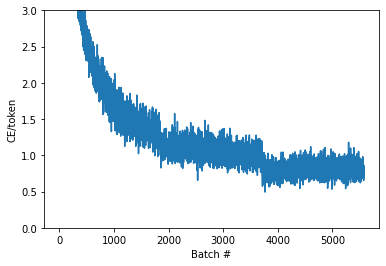

In [63]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

The visible jumps in the plot are at the epoch boundaries.

## Translate

Now that the model is trained, implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [64]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [65]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Convert token IDs to text

The first method to implement is `tokens_to_text` which converts from token IDs to human readable text.

In [66]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [67]:
Translator.tokens_to_text = tokens_to_text

Input some random token IDs and see what it generates:

In [68]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'tango disgusted', b'grade bombs', b'data breakfast',
       b'pregnant remembered', b'hadnt online'], dtype=object)

### Sample from the decoder's predictions

This function takes the decoder's logit outputs and samples token IDs from that distribution:

In [69]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [70]:
Translator.sample = sample

Test run this function on some random inputs:

In [71]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2855],
       [4666],
       [3925],
       [4426],
       [4102]])>

### Implement the translation loop

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using `tf.concat` to join them into tensors.

This implementation statically unrolls the graph out to `max_length` iterations.
This is okay with eager execution in python.

In [72]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [73]:
Translator.translate = translate_unrolled

Run it on a simple input:

In [74]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its very cold its cold here .
this is my life .

CPU times: user 214 ms, sys: 2.08 ms, total: 216 ms
Wall time: 210 ms


If you want to export this model you'll need to wrap this method in a `tf.function`. This basic implementation has a few issues if you try to do that:

1. The resulting graphs are very large and take a few seconds to build, save or load.
2. You can't break from a statically unrolled loop, so it will always run `max_length` iterations, even if all the outputs are done. But even then it's marginally faster than eager execution.


In [75]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

Run the `tf.function` once to compile it:

In [76]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 19.8 s, sys: 0 ns, total: 19.8 s
Wall time: 19.7 s


In [77]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

im very cold in a cold , too .
this is my life .

CPU times: user 158 ms, sys: 0 ns, total: 158 ms
Wall time: 83.1 ms


In [78]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [79]:
Translator.translate = translate_symbolic

The initial implementation used python lists to collect the outputs. This uses `tf.range` as the loop iterator, allowing `tf.autograph` to convert the loop. The biggest change in this implementation is the use of `tf.TensorArray` instead of python `list` to accumulate tensors. `tf.TensorArray` is required to collect a variable number of tensors in graph mode. 

With eager execution this implementation performs on par with the original:

In [80]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its a very cold here is the time ?
this is my life .

CPU times: user 294 ms, sys: 0 ns, total: 294 ms
Wall time: 286 ms


But when you wrap it in a `tf.function` you'll notice two differences.

In [81]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

First: Graph creation is much faster (~10x), since it doesn't create `max_iterations` copies of the model.

In [82]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.1 s


Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.

In [83]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its a lot of cold this way .
this is my life .

CPU times: user 59.5 ms, sys: 0 ns, total: 59.5 ms
Wall time: 23.2 ms


### Visualize the process

The attention weights returned by the `translate` method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [84]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.         0.99999994 1.         1.         1.         0.99999994
 1.         1.         1.        ]


Here is the attention distribution for the first output step of the first example. Note how the attention is now much more focused than it was for the untrained model:

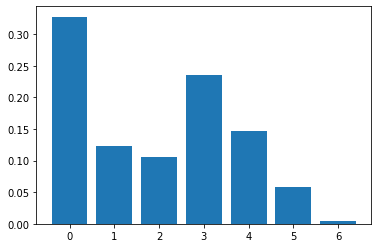

In [85]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

Since there is some rough alignment between the input and output words, you expect the attention to be focused near the diagonal:

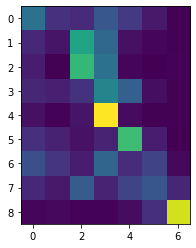

In [86]:
plt.imshow(np.array(a), vmin=0.0)

Here is some code to make a better attention plot:

In [87]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


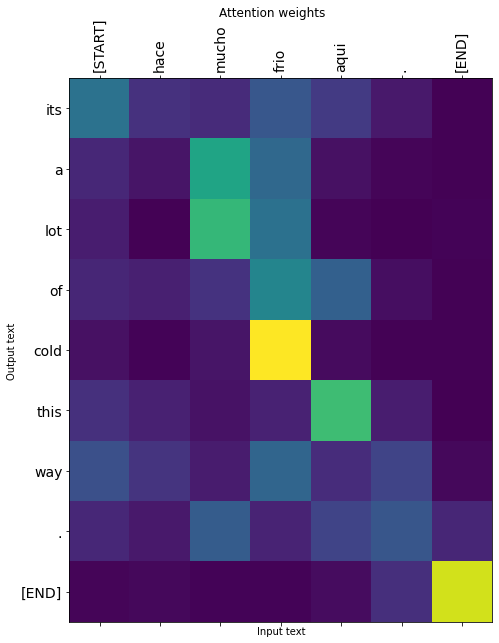

In [88]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

Translate a few more sentences and plot them:

In [89]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are you at home ?
finish the quit form .

CPU times: user 52.1 ms, sys: 42.1 ms, total: 94.1 ms
Wall time: 21.1 ms


In [90]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'this is my life .', b'are you at home ?',
       b'finish the quit form .'], dtype=object)>

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


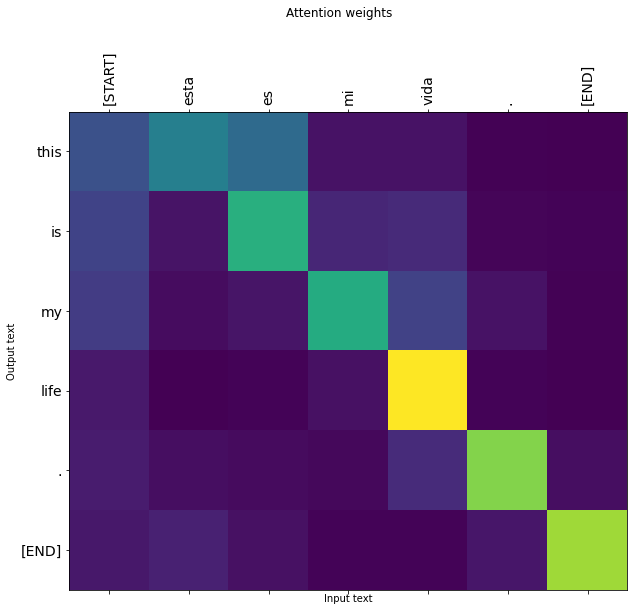

In [91]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


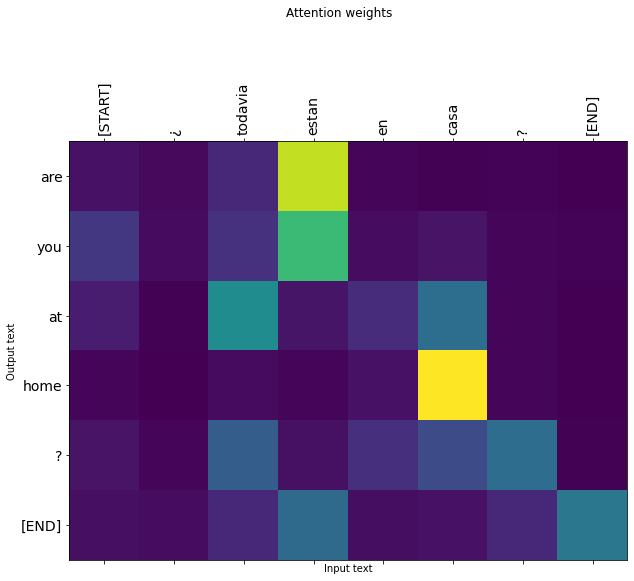

In [92]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


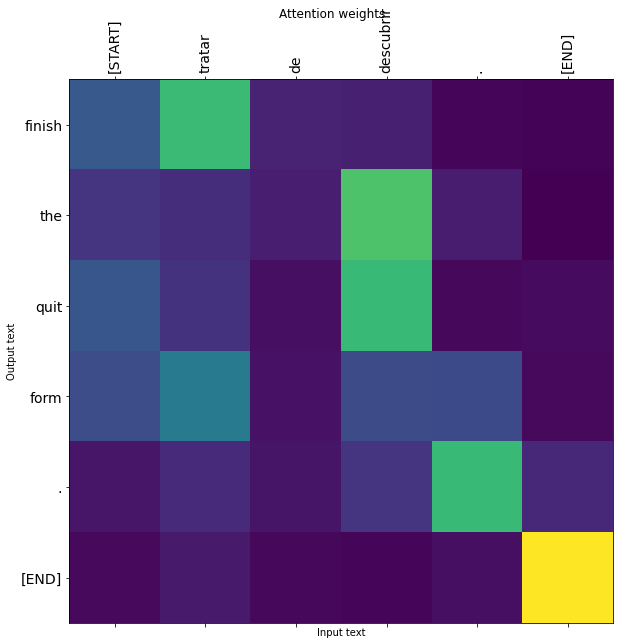

In [93]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. [Transformers](transformer.ipynb) solve this by using self-attention in the encoder and decoder.

In [94]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


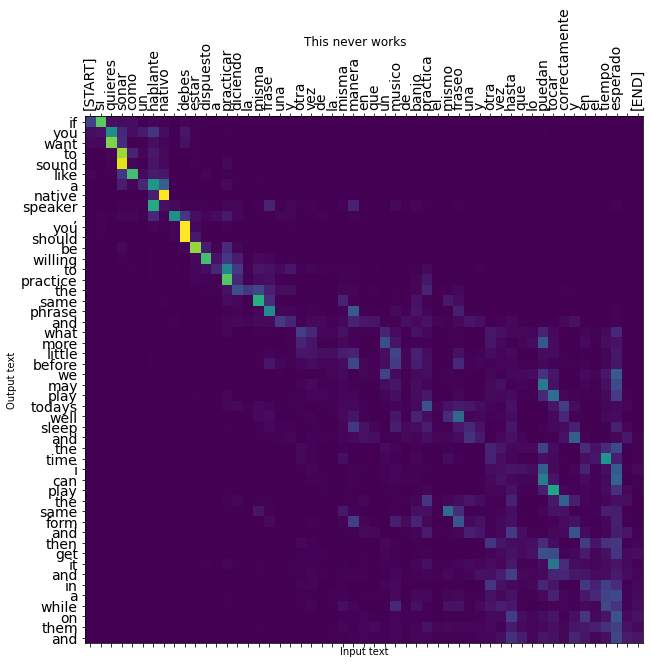

In [95]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

## Export

Once you have a model you're satisfied with you might want to export it as a `tf.saved_model` for use outside of this python program that created it.

Since the model is a subclass of `tf.Module` (through `keras.Model`), and all the functionality for export is compiled in a `tf.function` the model should export cleanly with `tf.saved_model.save`:  

Now that the function has been traced it can be exported using `saved_model.save`:

In [96]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

2022-02-11 13:05:07.485429: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [97]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [98]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are you still home ?
try to find out .

CPU times: user 41.2 ms, sys: 4.47 ms, total: 45.7 ms
Wall time: 18.2 ms


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses a transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement wordpiece tokenization.
* Have a look at the [tensorflow_addons.seq2seq](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt) for implementing this sort of sequence to sequence model. The `tfa.seq2seq` package includes higher level functionality like `seq2seq.BeamSearchDecoder`. 